In [68]:
import pandas as pd
import numpy as np
import json
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.graphics import tsaplots
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from statsmodels.tsa.seasonal import seasonal_decompose
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import pytorch_lightning as pl
from pytorch_lightning import loggers as pl_loggers
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from itertools import product
import warnings
from pytorch_lightning.callbacks import EarlyStopping
warnings.filterwarnings('ignore')

# Functions

## Plotting

In [5]:
def plot_graph(df, x_col = "Date", y_col = "Close", title = "S&P 500",
                        xlabel = 'Year', ylabel = 'Close value', start = "", end = ""):
    plt.figure(figsize=(10, 7))
    plt.plot(df[x_col], df[y_col])
    plt.title(title,fontsize=15)
    plt.xlabel(xlabel, fontsize=10)
    plt.ylabel(ylabel, fontsize=10)
    plt.show()
    return df

def plot_diff_series(df, x_col = "Date", y_col = "Log_Close", periods=365, xlabel= "Year", ylabel = 'Close value change',
                    title = "Differentiated Series Yearly"):
    df_diff = df.copy()
    df_diff = df_diff.set_index(x_col)
    df_diff=df_diff.diff(periods=periods)
    df_diff=df_diff.dropna() 

    plt.figure(figsize=(10, 7))
    plt.plot(df_diff.index, df_diff[y_col])
    plt.title(title,fontsize=15)
    plt.xlabel(xlabel, fontsize=10)
    plt.ylabel(ylabel, fontsize=10)
    return df_diff

def decompose_time_series(df, x_col = "Date", y_col = "Log_Close", period = 365):
    decomposition = seasonal_decompose(df[y_col], model='additive', period=period)

    plt.figure(figsize=(10, 7))

    plt.subplot(411)
    plt.plot(df[x_col],df[y_col], label='Original')
    plt.legend(loc='upper left')
    plt.title('Original Series')

    plt.subplot(412)
    plt.plot(df[x_col],decomposition.trend, label='Trend')
    plt.legend(loc='upper left')
    plt.title('Trend Component')

    plt.subplot(413)
    plt.plot(df[x_col],decomposition.seasonal, label='Seasonality')
    plt.legend(loc='upper left')
    plt.title('Seasonal Component')

    plt.subplot(414)
    plt.plot(df[x_col],decomposition.resid, label='Residuals')
    plt.legend(loc='upper left')
    plt.title('Residual Component')

    plt.tight_layout()
    plt.show()
    df_out = pd.DataFrame({"Date": df["Date"], "seasonal": decomposition.seasonal,
                          "trend": decomposition.trend, "resid":decomposition.resid})
    return df_out

def plot_org_w_pred(data):
    ax = data["Log_Close"].plot(label='Observed', figsize=(10, 5))
    data["Forecast"].plot(ax=ax, label='Forecast', legend=True)
    plt.legend()
    plt.show()

## Processing

In [85]:
def make_full_dates_df(sp500):
    full_sp500 = pd.DataFrame({
        "Date": pd.date_range(sp500["Date"].iloc[0], sp500["Date"].iloc[-1], freq="D")
    })
    
    full_sp500 = full_sp500.merge(sp500, on="Date", how="left")
    full_sp500["Open"].ffill(inplace=True)
    full_sp500["Close"].ffill(inplace=True)
    full_sp500["Adj Close"].ffill(inplace=True)
    full_sp500["Volume"].fillna(0, inplace=True)
    full_sp500["Low"].fillna(full_sp500["Close"], inplace=True)
    full_sp500["High"].fillna(full_sp500["Close"], inplace=True)
    
    return full_sp500

def split_data(data, validation_years=2, seq_length=12):
    validation_start_date = data.index.max() - pd.DateOffset(years=validation_years + seq_length/12)
    train_data = data[data.index < validation_start_date]
    validation_data = data[data.index >= validation_start_date]
    return train_data, validation_data

def create_inout_sequences(input_data, train_seq_len, extra_features=[], prediction_len=1):
    inout_seq = []
    L = len(input_data)
    if len(extra_features):
        combined_data = [ [input_data[i]] + [feature[i] for feature in extra_features] for i in range(L) ]
    else:
        combined_data = input_data
    for i in range(L-train_seq_len-prediction_len+1):
        train_seq = combined_data[i:i+train_seq_len]
        train_label = input_data[i+train_seq_len:i+train_seq_len+prediction_len]
        inout_seq.append((train_seq, train_label))
    return inout_seq

## LSTM functions

In [115]:
def create_dataloader(sequences, batch_size=128, shuffle=True, num_workers=4, persistent_workers=False):
    dataset = TensorDataset(torch.FloatTensor([i[0] for i in sequences]), 
                            torch.FloatTensor([i[1] for i in sequences]))
    loader = DataLoader(dataset, shuffle=shuffle, batch_size=batch_size, 
                        num_workers=num_workers, persistent_workers=persistent_workers)
    return loader

class CustomLSTM(pl.LightningModule):
    def __init__(self, input_size=1, hidden_layer_sizes=[100, 50], output_size=1, learning_rate=0.001,
                 dropout_probs=[0.2, 0.2], seq_length=12):
        super().__init__()
        self.save_hyperparameters()
        
        self.lstm_layers = nn.ModuleList()
        self.dropout_layers = nn.ModuleList()
        self.input_size = input_size
        
        for i, (hidden_size, dropout_prob) in enumerate(zip(hidden_layer_sizes, dropout_probs)):
            input_dim = input_size if i == 0 else hidden_layer_sizes[i-1]
            self.lstm_layers.append(nn.LSTM(input_dim, hidden_size, batch_first=True))
            self.dropout_layers.append(nn.Dropout(dropout_prob))
        
        self.linear = nn.Linear(hidden_layer_sizes[-1], output_size)
        self.seq_length = seq_length

    def forward(self, input_seq):
        current_input = input_seq
        for lstm, dropout in zip(self.lstm_layers, self.dropout_layers):
            lstm_out, _ = lstm(current_input)
            current_input = dropout(lstm_out)
        last_time_step_outputs = current_input[:, -1, :]
        predictions = self.linear(last_time_step_outputs)
        return predictions

    def configure_optimizers(self):
        self.optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.learning_rate)
        self.reduce_lr_on_plateau = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer,
            mode='min',
            factor=0.5,
            patience=5,
            verbose=True
        )
        return {"optimizer": self.optimizer, "lr_scheduler": self.reduce_lr_on_plateau, "monitor": "val_loss"}

    def training_step(self, batch, batch_idx):
        seq, labels = batch
        y_pred = self(seq.view(-1, self.seq_length, self.input_size)) 
        loss = nn.MSELoss()(y_pred, labels)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        seq, labels = batch
        y_pred = self(seq.view(-1, self.seq_length, self.input_size)) 
        val_loss = nn.MSELoss()(y_pred, labels)
        self.log('val_loss', val_loss, on_epoch=True, prog_bar=True)
        return val_loss
    
def train_model(train_loader, validation_loader, input_size=2, hidden_layer_sizes=[100, 50], dropout_probs=[0.2, 0.2], 
                output_size=1, learning_rate=0.001, max_epochs=10, name = "lightning_logs", seq_length=12):
    model = CustomLSTM(input_size=input_size, hidden_layer_sizes=hidden_layer_sizes, dropout_probs=dropout_probs, 
                       output_size=output_size, learning_rate=learning_rate, seq_length=seq_length)
    csv_logger = pl_loggers.CSVLogger(save_dir="logs/", name=name)
    early_stopping_callback = EarlyStopping(monitor='val_loss',patience=10,strict=False,verbose=True,mode='min')
    trainer = pl.Trainer(max_epochs=max_epochs, logger=csv_logger, callbacks = [early_stopping_callback])
    trainer.fit(model, train_loader, validation_loader)
    return model

def predict_iterativly(model, data, start_pred_point = "2019-11-06",
                       prediction_period = 12, add_forcast_to_frame=False, prediction_len=1, seq_length=12):
    predictions = torch.empty(0)
    train_data = data[data.index<start_pred_point]
    predictions_dates = data[data.index>=start_pred_point].index[:prediction_period]
    inference_input = train_data[-seq_length:]["Log_Close"].tolist()
    inference_input_tensor = torch.FloatTensor(inference_input).unsqueeze(0).unsqueeze(-1)
    for i in range(prediction_period//prediction_len + int(prediction_period%prediction_len > 0)):
        model.eval()
        pred = model(inference_input_tensor)[0]
        predictions = torch.cat((predictions, pred))
        inference_input_tensor = torch.cat((inference_input_tensor[:,prediction_len:, :], pred.unsqueeze(0).unsqueeze(-1)), dim = 1)
    predictions = predictions.detach().numpy()[:prediction_period]
    if add_forcast_to_frame:
        data["Forecast"] = np.nan
        data.loc[np.isin(data.index, predictions_dates), "Forecast"] = predictions
        return data
    return predictions_dates

def run_training_pipeline(data, seq_length=12, batch_size=32, input_size=2, hidden_layer_sizes=[100, 50],
                          prediction_len=1, learning_rate=1e-4, max_epochs=100, dropout_probs=[0.2, 0.2],
                          name="monthly_lr1e4_bs32", validation_years=2):
    train_data, validation_data = split_data(data, validation_years=validation_years, seq_length=seq_length)
    train_sequences = create_inout_sequences(train_data['Log_Close'].tolist(), seq_length,
                                             [train_data['Log_Close'].index.month.tolist()], prediction_len)
    validation_sequences = create_inout_sequences(validation_data['Log_Close'].tolist(), seq_length,
                                                  [validation_data['Log_Close'].index.month.tolist()], prediction_len)
    train_loader = create_dataloader(train_sequences, batch_size=batch_size, shuffle=True, num_workers=4, persistent_workers=False)
    validation_loader = create_dataloader(validation_sequences, batch_size=batch_size, shuffle=True, num_workers=4, persistent_workers=True)
    model = train_model(train_loader, validation_loader, input_size, hidden_layer_sizes,
                        dropout_probs=dropout_probs,  # Assuming a fixed dropout rate
                        output_size=prediction_len, learning_rate=learning_rate, max_epochs=max_epochs,
                        name="monthly_lr1e4_bs32", seq_length=seq_length)
    data = predict_iterativly(model, data, add_forcast_to_frame = True, seq_length=seq_length)
    plot_org_w_pred(data)
    
    params = {
        'seq_length': seq_length,
        'batch_size': batch_size,
        'input_size': input_size,
        'hidden_layer_sizes': hidden_layer_sizes,
        'prediction_len': prediction_len,
        'learning_rate': learning_rate,
        'max_epochs': max_epochs,
        'dropout_probs': dropout_probs,
        'name': name
    }
    
    params_dir = f"logs/{name}"
    os.makedirs(params_dir, exist_ok=True)
    
    with open(f"{params_dir}/params.json", 'w') as fp:
        json.dump(params, fp, indent=4)
    
    return model

## SARIMA

In [8]:
def forecast_with_sarimax(time_series, forecast_periods, order, seasonal_order, xlabel = 'Year',
                          ylabel = 'Log Close Price', freq='MS', plot=True, offset = 0, title = "", forcast_next = False):
    if forcast_next:
        sarima_model = SARIMAX(time_series, order=order, seasonal_order=seasonal_order)
    else:
        sarima_model = SARIMAX(time_series[:-forecast_periods - offset], order=order, seasonal_order=seasonal_order)
    sarima_model_fit = sarima_model.fit(disp=False)

    next_periods_forecast = sarima_model_fit.get_forecast(steps=forecast_periods)
    next_periods_ci = next_periods_forecast.conf_int()
    
    if forcast_next:
        future_dates = pd.date_range(start=time_series.index[-1], periods=forecast_periods, freq=freq)
    else:
        future_dates = pd.date_range(start=time_series.index[-forecast_periods - offset], periods=forecast_periods, freq=freq)
    next_periods_ci.index = future_dates

    futureDF_forecast = pd.DataFrame(next_periods_forecast.predicted_mean, index=future_dates)

    if plot:
        if offset == 0:
            ax = time_series.plot(label='Observed', figsize=(10, 5))
        else:
            ax = time_series[:-offset].plot(label='Observed', figsize=(10, 5))
        futureDF_forecast.plot(ax=ax, label='Forecast', legend=True)
        
        ax.fill_between(next_periods_ci.index,
                        next_periods_ci.iloc[:, 0],
                        next_periods_ci.iloc[:, 1], color='k', alpha=.1)
        ax.set_title(title)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        plt.legend()
        plt.show()
    return futureDF_forecast, next_periods_ci

In [9]:
def get_sarima_mse(time_series, order, seasonal_order, start_pred_point = "2019-11-06",
                       prediction_period = 12, y_col= 'Log_Close'):
    train_data = time_series[time_series["Date"]<start_pred_point][y_col]
    
    sarima_model = SARIMAX(train_data, order=order, seasonal_order=seasonal_order)
    sarima_model_fit = sarima_model.fit(disp=False)

    next_periods_forecast = sarima_model_fit.get_forecast(steps=prediction_period).predicted_mean
    next_periods_true = time_series[time_series["Date"]>start_pred_point][y_col][:prediction_period]
    mse_score = mean_squared_error(next_periods_forecast, next_periods_true)
    return mse_score

def cross_validate_sarima(time_series, cutoffs, order, seasonal_order, prediction_period = 12, y_col= 'Log_Close'):
    folds_res = []
    for i, cutoff in enumerate(cutoffs):
        print(f"starting fold {i+1}/{len(cutoffs)}", end = "\r")
        folds_res.append(get_sarima_mse(time_series, order, seasonal_order, cutoff, prediction_period, y_col))
    return folds_res, np.mean(folds_res)

In [10]:
def hyper_tune_sarima(monthly_data, cutoffs, p_values, d_values, q_values, P_values, D_values, Q_values, s_values):
    results = []
    for (p, d, q, P, D, Q, s) in product(p_values, d_values, q_values, P_values, D_values, Q_values, s_values):
        order = (p, d, q)
        seasonal_order = (P, D, Q, s)
        score = cross_validate_sarima(monthly_data, cutoffs, order, seasonal_order)[1]
        print(f"order={order}, seasonal_order={seasonal_order}, score={score}")
        results.append((order, seasonal_order, score))
    df = pd.DataFrame(results, columns=['Order', 'Seasonal_Order', 'Score'])
    df.to_csv('sarima_hyperparameters.csv', index=False)
    return df


## Prophet

In [11]:
def hyper_tune_prophet_model(df, cutoffs, param_grid):
    all_params = [dict(zip(param_grid.keys(), v)) for v in product(*param_grid.values())]
    mses = []

    for params in all_params:
        m = Prophet(**params).fit(df)
        df_cv = cross_validation(m, cutoffs=cutoffs, horizon='365 days')
        df_p = performance_metrics(df_cv, rolling_window=1)
        mses.append(df_p['mse'].values[0])

    tuning_results = pd.DataFrame(all_params)
    tuning_results['mse'] = mses
    
    return tuning_results

# Data loading

In [12]:
sp500 = pd.read_csv("SPY1950.csv")
sp500["Date"] = pd.to_datetime(sp500["Date"], format = "%d/%m/%Y")
sp500 = make_full_dates_df(sp500)
sp500["Log_Close"] = np.log(sp500["Close"])

In [13]:
sp500.head(5)

Date   Open   High    Low  Close  Adj Close     Volume  Log_Close
0 1950-01-03  16.66  16.66  16.66  16.66      16.66  1260000.0   2.813011
1 1950-01-04  16.85  16.85  16.85  16.85      16.85  1890000.0   2.824351
2 1950-01-05  16.93  16.93  16.93  16.93      16.93  2550000.0   2.829087
3 1950-01-06  16.98  16.98  16.98  16.98      16.98  2010000.0   2.832036
4 1950-01-07  16.98  16.98  16.98  16.98      16.98        0.0   2.832036

In [14]:
# date_diff = sp500["Date"].dt.month[1:].values - sp500["Date"].dt.month[:-1].values
# monthly_data = sp500[:-1][np.isin(date_diff, [1,-11])]
monthly_data = sp500[sp500["Date"].dt.day == 1]
monthly_data.reset_index(inplace = True, drop = True)
monthly_data["Log_Close"] = np.log(monthly_data["Close"])

# Plotting the data

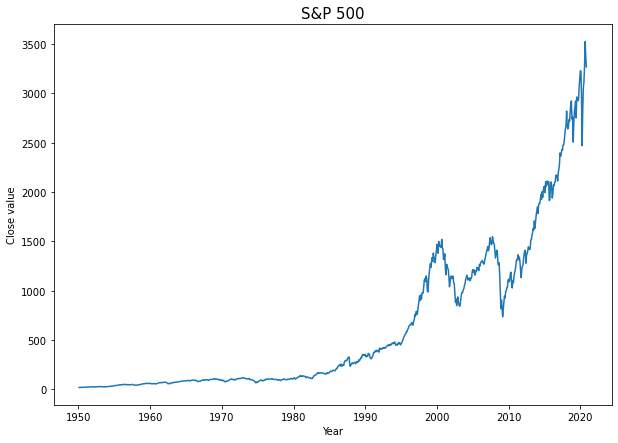

In [9]:
plot_graph(monthly_data);

this graph is rather exponential, lets take a look at the Log Close value

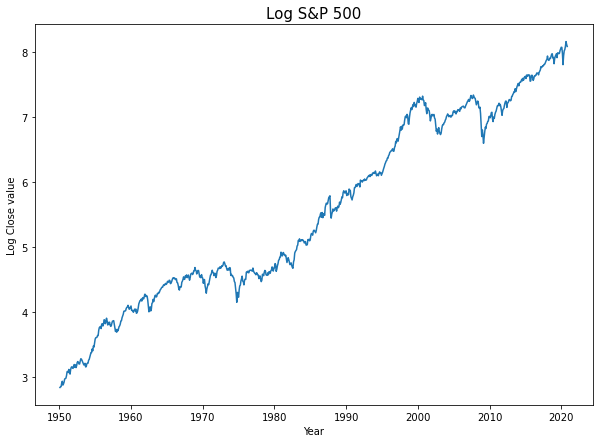

In [10]:
plot_graph(monthly_data, y_col= "Log_Close", ylabel = "Log Close value" , title = "Log S&P 500");

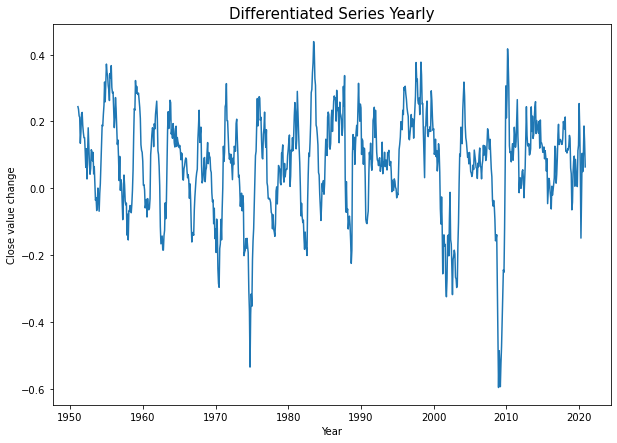

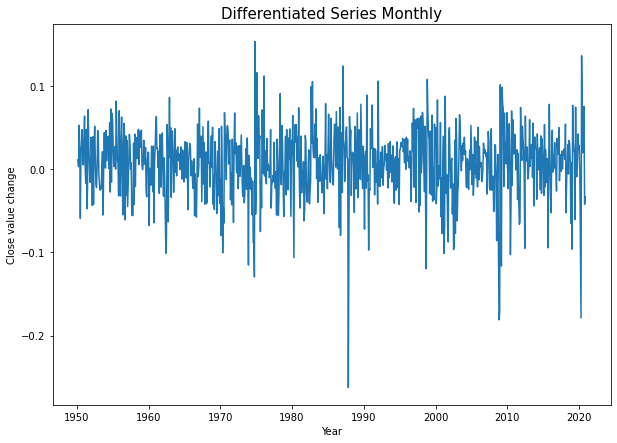

In [11]:
monthly_data_diff_Y = plot_diff_series(monthly_data, periods = 12)
monthly_data_diff_M = plot_diff_series(monthly_data, periods = 1, title = "Differentiated Series Monthly")

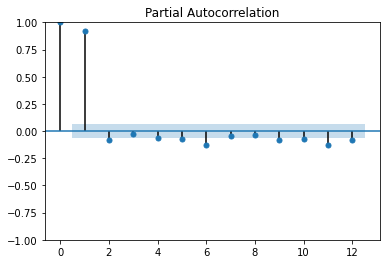

In [18]:
tsaplots.plot_pacf(monthly_data_diff_Y["Log_Close"], lags=12);

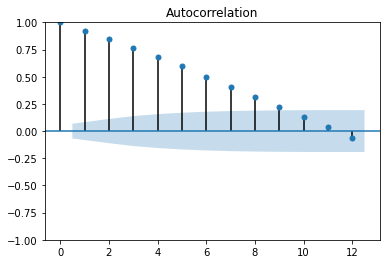

In [19]:
tsaplots.plot_acf(monthly_data_diff_Y["Log_Close"], lags=12);

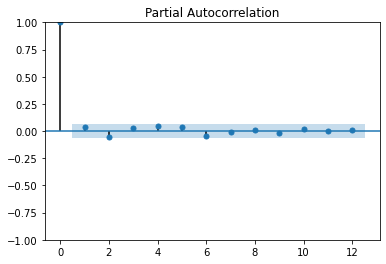

In [21]:
tsaplots.plot_pacf(monthly_data_diff_M["Log_Close"], lags=12);

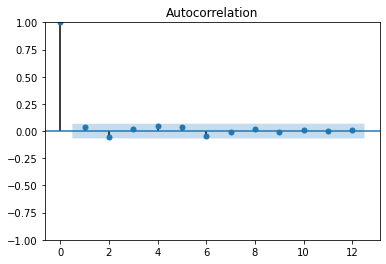

In [20]:
tsaplots.plot_acf(monthly_data_diff_M["Log_Close"], lags=12);

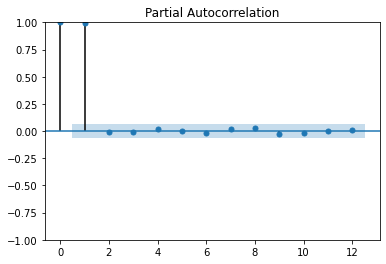

In [23]:
tsaplots.plot_pacf(monthly_data["Log_Close"], lags=12);

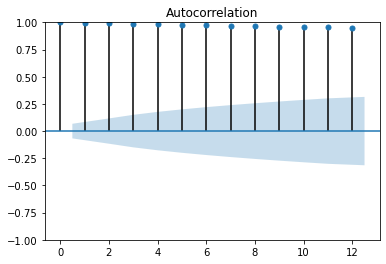

In [22]:
tsaplots.plot_acf(monthly_data["Log_Close"], lags=12);

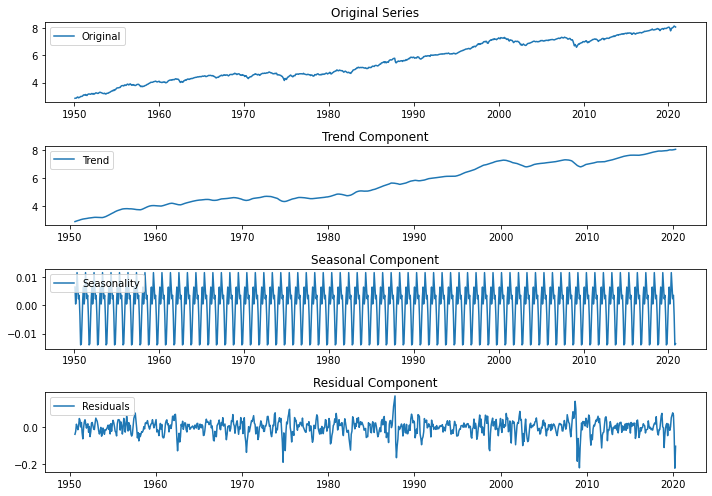

In [24]:
decomposition_year_montly = decompose_time_series(monthly_data, y_col = "Log_Close", period = 12)

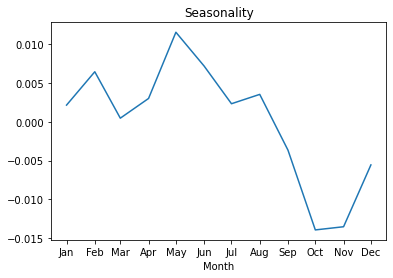

In [25]:
plt.plot(decomposition_year_montly["Date"][11:23],decomposition_year_montly["seasonal"][11:23])
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.xlabel("Month")
plt.title("Seasonality")
plt.plot();

# Modeling

## SARIMA (monthly)

In [70]:
cutoffs = pd.to_datetime([f'{year}-01-01' for year in [i*10 + 1969 for i in range(5)]])
p_values = [0, 1, 2]
d_values = [0, 1]
q_values = [0, 1, 2]
P_values = [0, 1]
D_values = [0, 1]
Q_values = [0, 1]
s_values = [12]
# hyper_tune_sarima(monthly_data, cutoffs, p_values, d_values, q_values, P_values, D_values, Q_values, s_values)

order=(0, 0, 0), seasonal_order=(0, 0, 0, 12), score=34.92649395786863
order=(0, 0, 0), seasonal_order=(0, 0, 1, 12), score=11.030030658864844
order=(0, 0, 0), seasonal_order=(0, 1, 0, 12), score=0.05258680322426703
order=(0, 0, 0), seasonal_order=(0, 1, 1, 12), score=0.05126340045112242
order=(0, 0, 0), seasonal_order=(1, 0, 0, 12), score=0.05293496649036944
order=(0, 0, 0), seasonal_order=(1, 0, 1, 12), score=0.05161599795371745
order=(0, 0, 0), seasonal_order=(1, 1, 0, 12), score=0.050984180870509335
order=(0, 0, 0), seasonal_order=(1, 1, 1, 12), score=0.05732671662872165
order=(0, 0, 1), seasonal_order=(0, 0, 0, 12), score=32.808857405532656
order=(0, 0, 1), seasonal_order=(0, 0, 1, 12), score=10.614089185741435
order=(0, 0, 1), seasonal_order=(0, 1, 0, 12), score=0.047855284269109524
order=(0, 0, 1), seasonal_order=(0, 1, 1, 12), score=0.04736453470019919
order=(0, 0, 1), seasonal_order=(1, 0, 0, 12), score=0.04821336313255916
order=(0, 0, 1), seasonal_order=(1, 0, 1, 12), score=0

order=(2, 0, 2), seasonal_order=(0, 0, 0, 12), score=0.022859424172008248
order=(2, 0, 2), seasonal_order=(0, 0, 1, 12), score=0.023375198689359944
order=(2, 0, 2), seasonal_order=(0, 1, 0, 12), score=0.02039408830838211
order=(2, 0, 2), seasonal_order=(0, 1, 1, 12), score=0.01918785150630073
order=(2, 0, 2), seasonal_order=(1, 0, 0, 12), score=0.023759949011754093
order=(2, 0, 2), seasonal_order=(1, 0, 1, 12), score=0.020469224190859746
order=(2, 0, 2), seasonal_order=(1, 1, 0, 12), score=0.0183390240563982
order=(2, 0, 2), seasonal_order=(1, 1, 1, 12), score=0.017190747760640578
order=(2, 1, 0), seasonal_order=(0, 0, 0, 12), score=0.02309073090520483
order=(2, 1, 0), seasonal_order=(0, 0, 1, 12), score=0.023434815808868116
order=(2, 1, 0), seasonal_order=(0, 1, 0, 12), score=0.044438307826939485
order=(2, 1, 0), seasonal_order=(0, 1, 1, 12), score=0.016688724241731727
order=(2, 1, 0), seasonal_order=(1, 0, 0, 12), score=0.023550287425960232
order=(2, 1, 0), seasonal_order=(1, 0, 1, 1

Order Seasonal_Order      Score
0    (0, 0, 0)  (0, 0, 0, 12)  34.926494
1    (0, 0, 0)  (0, 0, 1, 12)  11.030031
2    (0, 0, 0)  (0, 1, 0, 12)   0.052587
3    (0, 0, 0)  (0, 1, 1, 12)   0.051263
4    (0, 0, 0)  (1, 0, 0, 12)   0.052935
..         ...            ...        ...
139  (2, 1, 2)  (0, 1, 1, 12)   0.021351
140  (2, 1, 2)  (1, 0, 0, 12)   0.033099
141  (2, 1, 2)  (1, 0, 1, 12)   0.034961
142  (2, 1, 2)  (1, 1, 0, 12)   0.017016
143  (2, 1, 2)  (1, 1, 1, 12)   0.022541

[144 rows x 3 columns]

In [76]:
order = (2, 0, 0)
seasonal_order = (0, 1, 1, 12)
sarima_model = SARIMAX(monthly_data['Log_Close'], order=order, seasonal_order=seasonal_order).fit()
sarima_forecast = sarima_model.get_forecast(steps=12)
display(sarima_model.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                            Log_Close   No. Observations:                  850
Model:             SARIMAX(2, 0, 0)x(0, 1, [1], 12)   Log Likelihood                1437.732
Date:                              Tue, 09 Apr 2024   AIC                          -2867.463
Time:                                      18:09:19   BIC                          -2848.539
Sample:                                           0   HQIC                         -2860.209
                                              - 850                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0612      0.072     14.650      0.000       0.919       1.203
ar.L2         -0.0613      0.025     -2.443      0.015      -0.110      -0.012
ma.S.L12      -0.9995      1.097     -0.911      0.362      -3.149       1.150
sigma2         0.0018      0.002      0.980      0.327      -0.002       0.005
===================================================================================
Ljung-Box (L1) (Q):                   0.53   Jarque-Bera (JB):               425.01
Prob(Q):                              0.47   Prob(JB):                         0.00
Heteroskedasticity (H):               1.72   Skew:                            -0.73
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [48]:
order = (2, 0, 0)
seasonal_order = (0, 1, 1, 12)
get_sarima_mse(monthly_data, order, seasonal_order, start_pred_point = "2018-11-06", prediction_period = 24, y_col= 'Log_Close')

0.005069400150108827

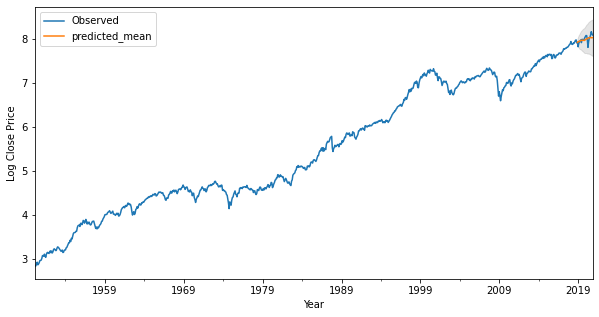

In [49]:
futureDF_forecast, next_periods_ci = forecast_with_sarimax(monthly_data.set_index("Date")['Log_Close'], 24, order=order,
                                                           seasonal_order=seasonal_order, offset = 0)

## Prophet (monthly)

In [163]:
cutoffs = pd.to_datetime([f'{year}-01-01' for year in [i*10 + 1969 for i in range(5)]])
monthly_data_prophet = monthly_data.rename({"Date": "ds", "Log_Close": "y"}, axis =1)
param_grid = {
    'changepoint_prior_scale': [0.01, 0.05, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 0.5, 1.0],
    'holidays_prior_scale': [0.01, 0.1, 0.5, 1.0, 10.0],
    'seasonality_mode': ['additive', 'multiplicative'],
    'changepoint_range': [0.8, 0.85, 0.9, 0.95]
}

tuning_results = hyper_tune_prophet_model(monthly_data_prophet, cutoffs, param_grid)
tuning_results.to_csv("prophet_tuning.csv")

23:27:49 - cmdstanpy - INFO - Chain [1] start processing
23:27:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:27:49 - cmdstanpy - INFO - Chain [1] start processing
23:27:49 - cmdstanpy - INFO - Chain [1] done processing
23:27:49 - cmdstanpy - INFO - Chain [1] start processing
23:27:49 - cmdstanpy - INFO - Chain [1] done processing
23:27:49 - cmdstanpy - INFO - Chain [1] start processing
23:27:50 - cmdstanpy - INFO - Chain [1] done processing
23:27:50 - cmdstanpy - INFO - Chain [1] start processing
23:27:50 - cmdstanpy - INFO - Chain [1] done processing
23:27:50 - cmdstanpy - INFO - Chain [1] start processing
23:27:50 - cmdstanpy - INFO - Chain [1] done processing
23:27:50 - cmdstanpy - INFO - Chain [1] start processing
23:27:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:27:51 - cmdstanpy - INFO - Chain [1] start processing
23:27:51 - cmdstanpy - INFO - Chain [1] done processing
23:27:51 - cmdstanpy - INFO - Chain [1] start processing
23:27:51 - cmdstanpy - INFO - Chain [1] done processing
23:27:51 - cmdstanpy - INFO - Chain [1] start processing
23:27:51 - cmdstanpy - INFO - Chain [1] done processing
23:27:51 - cmdstanpy - INFO - Chain [1] start processing
23:27:51 - cmdstanpy - INFO - Chain [1] done processing
23:27:52 - cmdstanpy - INFO - Chain [1] start processing
23:27:52 - cmdstanpy - INFO - Chain [1] done processing
23:27:52 - cmdstanpy - INFO - Chain [1] start processing
23:27:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:27:52 - cmdstanpy - INFO - Chain [1] start processing
23:27:52 - cmdstanpy - INFO - Chain [1] done processing
23:27:52 - cmdstanpy - INFO - Chain [1] start processing
23:27:52 - cmdstanpy - INFO - Chain [1] done processing
23:27:53 - cmdstanpy - INFO - Chain [1] start processing
23:27:53 - cmdstanpy - INFO - Chain [1] done processing
23:27:53 - cmdstanpy - INFO - Chain [1] start processing
23:27:53 - cmdstanpy - INFO - Chain [1] done processing
23:27:53 - cmdstanpy - INFO - Chain [1] start processing
23:27:53 - cmdstanpy - INFO - Chain [1] done processing
23:27:54 - cmdstanpy - INFO - Chain [1] start processing
23:27:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:27:54 - cmdstanpy - INFO - Chain [1] start processing
23:27:54 - cmdstanpy - INFO - Chain [1] done processing
23:27:54 - cmdstanpy - INFO - Chain [1] start processing
23:27:54 - cmdstanpy - INFO - Chain [1] done processing
23:27:54 - cmdstanpy - INFO - Chain [1] start processing
23:27:54 - cmdstanpy - INFO - Chain [1] done processing
23:27:54 - cmdstanpy - INFO - Chain [1] start processing
23:27:55 - cmdstanpy - INFO - Chain [1] done processing
23:27:55 - cmdstanpy - INFO - Chain [1] start processing
23:27:55 - cmdstanpy - INFO - Chain [1] done processing
23:27:55 - cmdstanpy - INFO - Chain [1] start processing
23:27:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:27:55 - cmdstanpy - INFO - Chain [1] start processing
23:27:55 - cmdstanpy - INFO - Chain [1] done processing
23:27:55 - cmdstanpy - INFO - Chain [1] start processing
23:27:56 - cmdstanpy - INFO - Chain [1] done processing
23:27:56 - cmdstanpy - INFO - Chain [1] start processing
23:27:56 - cmdstanpy - INFO - Chain [1] done processing
23:27:56 - cmdstanpy - INFO - Chain [1] start processing
23:27:56 - cmdstanpy - INFO - Chain [1] done processing
23:27:56 - cmdstanpy - INFO - Chain [1] start processing
23:27:56 - cmdstanpy - INFO - Chain [1] done processing
23:27:57 - cmdstanpy - INFO - Chain [1] start processing
23:27:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:27:57 - cmdstanpy - INFO - Chain [1] start processing
23:27:57 - cmdstanpy - INFO - Chain [1] done processing
23:27:57 - cmdstanpy - INFO - Chain [1] start processing
23:27:57 - cmdstanpy - INFO - Chain [1] done processing
23:27:57 - cmdstanpy - INFO - Chain [1] start processing
23:27:57 - cmdstanpy - INFO - Chain [1] done processing
23:27:57 - cmdstanpy - INFO - Chain [1] start processing
23:27:58 - cmdstanpy - INFO - Chain [1] done processing
23:27:58 - cmdstanpy - INFO - Chain [1] start processing
23:27:58 - cmdstanpy - INFO - Chain [1] done processing
23:27:58 - cmdstanpy - INFO - Chain [1] start processing
23:27:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:27:58 - cmdstanpy - INFO - Chain [1] start processing
23:27:58 - cmdstanpy - INFO - Chain [1] done processing
23:27:59 - cmdstanpy - INFO - Chain [1] start processing
23:27:59 - cmdstanpy - INFO - Chain [1] done processing
23:27:59 - cmdstanpy - INFO - Chain [1] start processing
23:27:59 - cmdstanpy - INFO - Chain [1] done processing
23:27:59 - cmdstanpy - INFO - Chain [1] start processing
23:27:59 - cmdstanpy - INFO - Chain [1] done processing
23:27:59 - cmdstanpy - INFO - Chain [1] start processing
23:27:59 - cmdstanpy - INFO - Chain [1] done processing
23:28:00 - cmdstanpy - INFO - Chain [1] start processing
23:28:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:28:00 - cmdstanpy - INFO - Chain [1] start processing
23:28:00 - cmdstanpy - INFO - Chain [1] done processing
23:28:00 - cmdstanpy - INFO - Chain [1] start processing
23:28:00 - cmdstanpy - INFO - Chain [1] done processing
23:28:00 - cmdstanpy - INFO - Chain [1] start processing
23:28:01 - cmdstanpy - INFO - Chain [1] done processing
23:28:01 - cmdstanpy - INFO - Chain [1] start processing
23:28:01 - cmdstanpy - INFO - Chain [1] done processing
23:28:01 - cmdstanpy - INFO - Chain [1] start processing
23:28:01 - cmdstanpy - INFO - Chain [1] done processing
23:28:01 - cmdstanpy - INFO - Chain [1] start processing
23:28:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:28:02 - cmdstanpy - INFO - Chain [1] start processing
23:28:02 - cmdstanpy - INFO - Chain [1] done processing
23:28:02 - cmdstanpy - INFO - Chain [1] start processing
23:28:02 - cmdstanpy - INFO - Chain [1] done processing
23:28:02 - cmdstanpy - INFO - Chain [1] start processing
23:28:02 - cmdstanpy - INFO - Chain [1] done processing
23:28:02 - cmdstanpy - INFO - Chain [1] start processing
23:28:03 - cmdstanpy - INFO - Chain [1] done processing
23:28:03 - cmdstanpy - INFO - Chain [1] start processing
23:28:03 - cmdstanpy - INFO - Chain [1] done processing
23:28:03 - cmdstanpy - INFO - Chain [1] start processing
23:28:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:28:03 - cmdstanpy - INFO - Chain [1] start processing
23:28:04 - cmdstanpy - INFO - Chain [1] done processing
23:28:04 - cmdstanpy - INFO - Chain [1] start processing
23:28:04 - cmdstanpy - INFO - Chain [1] done processing
23:28:04 - cmdstanpy - INFO - Chain [1] start processing
23:28:04 - cmdstanpy - INFO - Chain [1] done processing
23:28:04 - cmdstanpy - INFO - Chain [1] start processing
23:28:04 - cmdstanpy - INFO - Chain [1] done processing
23:28:04 - cmdstanpy - INFO - Chain [1] start processing
23:28:05 - cmdstanpy - INFO - Chain [1] done processing
23:28:05 - cmdstanpy - INFO - Chain [1] start processing
23:28:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:28:05 - cmdstanpy - INFO - Chain [1] start processing
23:28:05 - cmdstanpy - INFO - Chain [1] done processing
23:28:05 - cmdstanpy - INFO - Chain [1] start processing
23:28:05 - cmdstanpy - INFO - Chain [1] done processing
23:28:06 - cmdstanpy - INFO - Chain [1] start processing
23:28:06 - cmdstanpy - INFO - Chain [1] done processing
23:28:06 - cmdstanpy - INFO - Chain [1] start processing
23:28:06 - cmdstanpy - INFO - Chain [1] done processing
23:28:06 - cmdstanpy - INFO - Chain [1] start processing
23:28:06 - cmdstanpy - INFO - Chain [1] done processing
23:28:06 - cmdstanpy - INFO - Chain [1] start processing
23:28:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:28:07 - cmdstanpy - INFO - Chain [1] start processing
23:28:07 - cmdstanpy - INFO - Chain [1] done processing
23:28:07 - cmdstanpy - INFO - Chain [1] start processing
23:28:07 - cmdstanpy - INFO - Chain [1] done processing
23:28:07 - cmdstanpy - INFO - Chain [1] start processing
23:28:07 - cmdstanpy - INFO - Chain [1] done processing
23:28:07 - cmdstanpy - INFO - Chain [1] start processing
23:28:08 - cmdstanpy - INFO - Chain [1] done processing
23:28:08 - cmdstanpy - INFO - Chain [1] start processing
23:28:08 - cmdstanpy - INFO - Chain [1] done processing
23:28:08 - cmdstanpy - INFO - Chain [1] start processing
23:28:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:28:08 - cmdstanpy - INFO - Chain [1] start processing
23:28:08 - cmdstanpy - INFO - Chain [1] done processing
23:28:08 - cmdstanpy - INFO - Chain [1] start processing
23:28:09 - cmdstanpy - INFO - Chain [1] done processing
23:28:09 - cmdstanpy - INFO - Chain [1] start processing
23:28:09 - cmdstanpy - INFO - Chain [1] done processing
23:28:09 - cmdstanpy - INFO - Chain [1] start processing
23:28:09 - cmdstanpy - INFO - Chain [1] done processing
23:28:09 - cmdstanpy - INFO - Chain [1] start processing
23:28:09 - cmdstanpy - INFO - Chain [1] done processing
23:28:10 - cmdstanpy - INFO - Chain [1] start processing
23:28:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:28:10 - cmdstanpy - INFO - Chain [1] start processing
23:28:10 - cmdstanpy - INFO - Chain [1] done processing
23:28:10 - cmdstanpy - INFO - Chain [1] start processing
23:28:10 - cmdstanpy - INFO - Chain [1] done processing
23:28:10 - cmdstanpy - INFO - Chain [1] start processing
23:28:10 - cmdstanpy - INFO - Chain [1] done processing
23:28:11 - cmdstanpy - INFO - Chain [1] start processing
23:28:11 - cmdstanpy - INFO - Chain [1] done processing
23:28:11 - cmdstanpy - INFO - Chain [1] start processing
23:28:11 - cmdstanpy - INFO - Chain [1] done processing
23:28:11 - cmdstanpy - INFO - Chain [1] start processing
23:28:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:28:11 - cmdstanpy - INFO - Chain [1] start processing
23:28:12 - cmdstanpy - INFO - Chain [1] done processing
23:28:12 - cmdstanpy - INFO - Chain [1] start processing
23:28:12 - cmdstanpy - INFO - Chain [1] done processing
23:28:12 - cmdstanpy - INFO - Chain [1] start processing
23:28:12 - cmdstanpy - INFO - Chain [1] done processing
23:28:12 - cmdstanpy - INFO - Chain [1] start processing
23:28:12 - cmdstanpy - INFO - Chain [1] done processing
23:28:12 - cmdstanpy - INFO - Chain [1] start processing
23:28:12 - cmdstanpy - INFO - Chain [1] done processing
23:28:13 - cmdstanpy - INFO - Chain [1] start processing
23:28:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:28:13 - cmdstanpy - INFO - Chain [1] start processing
23:28:13 - cmdstanpy - INFO - Chain [1] done processing
23:28:13 - cmdstanpy - INFO - Chain [1] start processing
23:28:13 - cmdstanpy - INFO - Chain [1] done processing
23:28:13 - cmdstanpy - INFO - Chain [1] start processing
23:28:14 - cmdstanpy - INFO - Chain [1] done processing
23:28:14 - cmdstanpy - INFO - Chain [1] start processing
23:28:14 - cmdstanpy - INFO - Chain [1] done processing
23:28:14 - cmdstanpy - INFO - Chain [1] start processing
23:28:14 - cmdstanpy - INFO - Chain [1] done processing
23:28:14 - cmdstanpy - INFO - Chain [1] start processing
23:28:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:28:15 - cmdstanpy - INFO - Chain [1] start processing
23:28:15 - cmdstanpy - INFO - Chain [1] done processing
23:28:15 - cmdstanpy - INFO - Chain [1] start processing
23:28:15 - cmdstanpy - INFO - Chain [1] done processing
23:28:15 - cmdstanpy - INFO - Chain [1] start processing
23:28:15 - cmdstanpy - INFO - Chain [1] done processing
23:28:16 - cmdstanpy - INFO - Chain [1] start processing
23:28:16 - cmdstanpy - INFO - Chain [1] done processing
23:28:16 - cmdstanpy - INFO - Chain [1] start processing
23:28:16 - cmdstanpy - INFO - Chain [1] done processing
23:28:17 - cmdstanpy - INFO - Chain [1] start processing
23:28:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:28:17 - cmdstanpy - INFO - Chain [1] start processing
23:28:17 - cmdstanpy - INFO - Chain [1] done processing
23:28:17 - cmdstanpy - INFO - Chain [1] start processing
23:28:17 - cmdstanpy - INFO - Chain [1] done processing
23:28:18 - cmdstanpy - INFO - Chain [1] start processing
23:28:18 - cmdstanpy - INFO - Chain [1] done processing
23:28:18 - cmdstanpy - INFO - Chain [1] start processing
23:28:18 - cmdstanpy - INFO - Chain [1] done processing
23:28:18 - cmdstanpy - INFO - Chain [1] start processing
23:28:18 - cmdstanpy - INFO - Chain [1] done processing
23:28:19 - cmdstanpy - INFO - Chain [1] start processing
23:28:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:28:19 - cmdstanpy - INFO - Chain [1] start processing
23:28:19 - cmdstanpy - INFO - Chain [1] done processing
23:28:19 - cmdstanpy - INFO - Chain [1] start processing
23:28:19 - cmdstanpy - INFO - Chain [1] done processing
23:28:19 - cmdstanpy - INFO - Chain [1] start processing
23:28:19 - cmdstanpy - INFO - Chain [1] done processing
23:28:19 - cmdstanpy - INFO - Chain [1] start processing
23:28:20 - cmdstanpy - INFO - Chain [1] done processing
23:28:20 - cmdstanpy - INFO - Chain [1] start processing
23:28:20 - cmdstanpy - INFO - Chain [1] done processing
23:28:20 - cmdstanpy - INFO - Chain [1] start processing
23:28:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:28:20 - cmdstanpy - INFO - Chain [1] start processing
23:28:20 - cmdstanpy - INFO - Chain [1] done processing
23:28:20 - cmdstanpy - INFO - Chain [1] start processing
23:28:21 - cmdstanpy - INFO - Chain [1] done processing
23:28:21 - cmdstanpy - INFO - Chain [1] start processing
23:28:21 - cmdstanpy - INFO - Chain [1] done processing
23:28:21 - cmdstanpy - INFO - Chain [1] start processing
23:28:21 - cmdstanpy - INFO - Chain [1] done processing
23:28:21 - cmdstanpy - INFO - Chain [1] start processing
23:28:21 - cmdstanpy - INFO - Chain [1] done processing
23:28:22 - cmdstanpy - INFO - Chain [1] start processing
23:28:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:28:22 - cmdstanpy - INFO - Chain [1] start processing
23:28:22 - cmdstanpy - INFO - Chain [1] done processing
23:28:22 - cmdstanpy - INFO - Chain [1] start processing
23:28:22 - cmdstanpy - INFO - Chain [1] done processing
23:28:22 - cmdstanpy - INFO - Chain [1] start processing
23:28:22 - cmdstanpy - INFO - Chain [1] done processing
23:28:23 - cmdstanpy - INFO - Chain [1] start processing
23:28:23 - cmdstanpy - INFO - Chain [1] done processing
23:28:23 - cmdstanpy - INFO - Chain [1] start processing
23:28:23 - cmdstanpy - INFO - Chain [1] done processing
23:28:23 - cmdstanpy - INFO - Chain [1] start processing
23:28:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:28:24 - cmdstanpy - INFO - Chain [1] start processing
23:28:24 - cmdstanpy - INFO - Chain [1] done processing
23:28:24 - cmdstanpy - INFO - Chain [1] start processing
23:28:24 - cmdstanpy - INFO - Chain [1] done processing
23:28:24 - cmdstanpy - INFO - Chain [1] start processing
23:28:24 - cmdstanpy - INFO - Chain [1] done processing
23:28:24 - cmdstanpy - INFO - Chain [1] start processing
23:28:24 - cmdstanpy - INFO - Chain [1] done processing
23:28:25 - cmdstanpy - INFO - Chain [1] start processing
23:28:25 - cmdstanpy - INFO - Chain [1] done processing
23:28:25 - cmdstanpy - INFO - Chain [1] start processing
23:28:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:28:25 - cmdstanpy - INFO - Chain [1] start processing
23:28:25 - cmdstanpy - INFO - Chain [1] done processing
23:28:25 - cmdstanpy - INFO - Chain [1] start processing
23:28:25 - cmdstanpy - INFO - Chain [1] done processing
23:28:26 - cmdstanpy - INFO - Chain [1] start processing
23:28:26 - cmdstanpy - INFO - Chain [1] done processing
23:28:26 - cmdstanpy - INFO - Chain [1] start processing
23:28:26 - cmdstanpy - INFO - Chain [1] done processing
23:28:26 - cmdstanpy - INFO - Chain [1] start processing
23:28:26 - cmdstanpy - INFO - Chain [1] done processing
23:28:27 - cmdstanpy - INFO - Chain [1] start processing
23:28:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:28:27 - cmdstanpy - INFO - Chain [1] start processing
23:28:27 - cmdstanpy - INFO - Chain [1] done processing
23:28:27 - cmdstanpy - INFO - Chain [1] start processing
23:28:27 - cmdstanpy - INFO - Chain [1] done processing
23:28:27 - cmdstanpy - INFO - Chain [1] start processing
23:28:27 - cmdstanpy - INFO - Chain [1] done processing
23:28:28 - cmdstanpy - INFO - Chain [1] start processing
23:28:28 - cmdstanpy - INFO - Chain [1] done processing
23:28:28 - cmdstanpy - INFO - Chain [1] start processing
23:28:28 - cmdstanpy - INFO - Chain [1] done processing
23:28:28 - cmdstanpy - INFO - Chain [1] start processing
23:28:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:28:28 - cmdstanpy - INFO - Chain [1] start processing
23:28:29 - cmdstanpy - INFO - Chain [1] done processing
23:28:29 - cmdstanpy - INFO - Chain [1] start processing
23:28:29 - cmdstanpy - INFO - Chain [1] done processing
23:28:29 - cmdstanpy - INFO - Chain [1] start processing
23:28:29 - cmdstanpy - INFO - Chain [1] done processing
23:28:29 - cmdstanpy - INFO - Chain [1] start processing
23:28:29 - cmdstanpy - INFO - Chain [1] done processing
23:28:30 - cmdstanpy - INFO - Chain [1] start processing
23:28:30 - cmdstanpy - INFO - Chain [1] done processing
23:28:30 - cmdstanpy - INFO - Chain [1] start processing
23:28:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:28:30 - cmdstanpy - INFO - Chain [1] start processing
23:28:30 - cmdstanpy - INFO - Chain [1] done processing
23:28:30 - cmdstanpy - INFO - Chain [1] start processing
23:28:31 - cmdstanpy - INFO - Chain [1] done processing
23:28:31 - cmdstanpy - INFO - Chain [1] start processing
23:28:31 - cmdstanpy - INFO - Chain [1] done processing
23:28:31 - cmdstanpy - INFO - Chain [1] start processing
23:28:31 - cmdstanpy - INFO - Chain [1] done processing
23:28:31 - cmdstanpy - INFO - Chain [1] start processing
23:28:32 - cmdstanpy - INFO - Chain [1] done processing
23:28:32 - cmdstanpy - INFO - Chain [1] start processing
23:28:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:28:32 - cmdstanpy - INFO - Chain [1] start processing
23:28:32 - cmdstanpy - INFO - Chain [1] done processing
23:28:33 - cmdstanpy - INFO - Chain [1] start processing
23:28:33 - cmdstanpy - INFO - Chain [1] done processing
23:28:33 - cmdstanpy - INFO - Chain [1] start processing
23:28:33 - cmdstanpy - INFO - Chain [1] done processing
23:28:33 - cmdstanpy - INFO - Chain [1] start processing
23:28:33 - cmdstanpy - INFO - Chain [1] done processing
23:28:33 - cmdstanpy - INFO - Chain [1] start processing
23:28:34 - cmdstanpy - INFO - Chain [1] done processing
23:28:34 - cmdstanpy - INFO - Chain [1] start processing
23:28:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:28:34 - cmdstanpy - INFO - Chain [1] start processing
23:28:34 - cmdstanpy - INFO - Chain [1] done processing
23:28:34 - cmdstanpy - INFO - Chain [1] start processing
23:28:34 - cmdstanpy - INFO - Chain [1] done processing
23:28:34 - cmdstanpy - INFO - Chain [1] start processing
23:28:35 - cmdstanpy - INFO - Chain [1] done processing
23:28:35 - cmdstanpy - INFO - Chain [1] start processing
23:28:35 - cmdstanpy - INFO - Chain [1] done processing
23:28:35 - cmdstanpy - INFO - Chain [1] start processing
23:28:35 - cmdstanpy - INFO - Chain [1] done processing
23:28:35 - cmdstanpy - INFO - Chain [1] start processing
23:28:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:28:36 - cmdstanpy - INFO - Chain [1] start processing
23:28:36 - cmdstanpy - INFO - Chain [1] done processing
23:28:36 - cmdstanpy - INFO - Chain [1] start processing
23:28:36 - cmdstanpy - INFO - Chain [1] done processing
23:28:36 - cmdstanpy - INFO - Chain [1] start processing
23:28:36 - cmdstanpy - INFO - Chain [1] done processing
23:28:37 - cmdstanpy - INFO - Chain [1] start processing
23:28:37 - cmdstanpy - INFO - Chain [1] done processing
23:28:37 - cmdstanpy - INFO - Chain [1] start processing
23:28:37 - cmdstanpy - INFO - Chain [1] done processing
23:28:37 - cmdstanpy - INFO - Chain [1] start processing
23:28:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:28:38 - cmdstanpy - INFO - Chain [1] start processing
23:28:38 - cmdstanpy - INFO - Chain [1] done processing
23:28:38 - cmdstanpy - INFO - Chain [1] start processing
23:28:38 - cmdstanpy - INFO - Chain [1] done processing
23:28:38 - cmdstanpy - INFO - Chain [1] start processing
23:28:38 - cmdstanpy - INFO - Chain [1] done processing
23:28:38 - cmdstanpy - INFO - Chain [1] start processing
23:28:38 - cmdstanpy - INFO - Chain [1] done processing
23:28:38 - cmdstanpy - INFO - Chain [1] start processing
23:28:39 - cmdstanpy - INFO - Chain [1] done processing
23:28:39 - cmdstanpy - INFO - Chain [1] start processing
23:28:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:28:39 - cmdstanpy - INFO - Chain [1] start processing
23:28:39 - cmdstanpy - INFO - Chain [1] done processing
23:28:39 - cmdstanpy - INFO - Chain [1] start processing
23:28:39 - cmdstanpy - INFO - Chain [1] done processing
23:28:40 - cmdstanpy - INFO - Chain [1] start processing
23:28:40 - cmdstanpy - INFO - Chain [1] done processing
23:28:40 - cmdstanpy - INFO - Chain [1] start processing
23:28:40 - cmdstanpy - INFO - Chain [1] done processing
23:28:40 - cmdstanpy - INFO - Chain [1] start processing
23:28:40 - cmdstanpy - INFO - Chain [1] done processing
23:28:40 - cmdstanpy - INFO - Chain [1] start processing
23:28:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:28:41 - cmdstanpy - INFO - Chain [1] start processing
23:28:41 - cmdstanpy - INFO - Chain [1] done processing
23:28:41 - cmdstanpy - INFO - Chain [1] start processing
23:28:41 - cmdstanpy - INFO - Chain [1] done processing
23:28:41 - cmdstanpy - INFO - Chain [1] start processing
23:28:41 - cmdstanpy - INFO - Chain [1] done processing
23:28:41 - cmdstanpy - INFO - Chain [1] start processing
23:28:41 - cmdstanpy - INFO - Chain [1] done processing
23:28:42 - cmdstanpy - INFO - Chain [1] start processing
23:28:42 - cmdstanpy - INFO - Chain [1] done processing
23:28:42 - cmdstanpy - INFO - Chain [1] start processing
23:28:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:28:42 - cmdstanpy - INFO - Chain [1] start processing
23:28:42 - cmdstanpy - INFO - Chain [1] done processing
23:28:42 - cmdstanpy - INFO - Chain [1] start processing
23:28:43 - cmdstanpy - INFO - Chain [1] done processing
23:28:43 - cmdstanpy - INFO - Chain [1] start processing
23:28:43 - cmdstanpy - INFO - Chain [1] done processing
23:28:43 - cmdstanpy - INFO - Chain [1] start processing
23:28:43 - cmdstanpy - INFO - Chain [1] done processing
23:28:43 - cmdstanpy - INFO - Chain [1] start processing
23:28:43 - cmdstanpy - INFO - Chain [1] done processing
23:28:44 - cmdstanpy - INFO - Chain [1] start processing
23:28:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:28:44 - cmdstanpy - INFO - Chain [1] start processing
23:28:44 - cmdstanpy - INFO - Chain [1] done processing
23:28:44 - cmdstanpy - INFO - Chain [1] start processing
23:28:44 - cmdstanpy - INFO - Chain [1] done processing
23:28:44 - cmdstanpy - INFO - Chain [1] start processing
23:28:44 - cmdstanpy - INFO - Chain [1] done processing
23:28:45 - cmdstanpy - INFO - Chain [1] start processing
23:28:45 - cmdstanpy - INFO - Chain [1] done processing
23:28:45 - cmdstanpy - INFO - Chain [1] start processing
23:28:45 - cmdstanpy - INFO - Chain [1] done processing
23:28:45 - cmdstanpy - INFO - Chain [1] start processing
23:28:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:28:46 - cmdstanpy - INFO - Chain [1] start processing
23:28:46 - cmdstanpy - INFO - Chain [1] done processing
23:28:46 - cmdstanpy - INFO - Chain [1] start processing
23:28:46 - cmdstanpy - INFO - Chain [1] done processing
23:28:46 - cmdstanpy - INFO - Chain [1] start processing
23:28:46 - cmdstanpy - INFO - Chain [1] done processing
23:28:46 - cmdstanpy - INFO - Chain [1] start processing
23:28:46 - cmdstanpy - INFO - Chain [1] done processing
23:28:47 - cmdstanpy - INFO - Chain [1] start processing
23:28:47 - cmdstanpy - INFO - Chain [1] done processing
23:28:47 - cmdstanpy - INFO - Chain [1] start processing
23:28:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:28:47 - cmdstanpy - INFO - Chain [1] start processing
23:28:47 - cmdstanpy - INFO - Chain [1] done processing
23:28:48 - cmdstanpy - INFO - Chain [1] start processing
23:28:48 - cmdstanpy - INFO - Chain [1] done processing
23:28:48 - cmdstanpy - INFO - Chain [1] start processing
23:28:48 - cmdstanpy - INFO - Chain [1] done processing
23:28:48 - cmdstanpy - INFO - Chain [1] start processing
23:28:48 - cmdstanpy - INFO - Chain [1] done processing
23:28:48 - cmdstanpy - INFO - Chain [1] start processing
23:28:48 - cmdstanpy - INFO - Chain [1] done processing
23:28:49 - cmdstanpy - INFO - Chain [1] start processing
23:28:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:28:49 - cmdstanpy - INFO - Chain [1] start processing
23:28:49 - cmdstanpy - INFO - Chain [1] done processing
23:28:49 - cmdstanpy - INFO - Chain [1] start processing
23:28:49 - cmdstanpy - INFO - Chain [1] done processing
23:28:49 - cmdstanpy - INFO - Chain [1] start processing
23:28:49 - cmdstanpy - INFO - Chain [1] done processing
23:28:50 - cmdstanpy - INFO - Chain [1] start processing
23:28:50 - cmdstanpy - INFO - Chain [1] done processing
23:28:50 - cmdstanpy - INFO - Chain [1] start processing
23:28:50 - cmdstanpy - INFO - Chain [1] done processing
23:28:50 - cmdstanpy - INFO - Chain [1] start processing
23:28:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:28:51 - cmdstanpy - INFO - Chain [1] start processing
23:28:51 - cmdstanpy - INFO - Chain [1] done processing
23:28:51 - cmdstanpy - INFO - Chain [1] start processing
23:28:51 - cmdstanpy - INFO - Chain [1] done processing
23:28:51 - cmdstanpy - INFO - Chain [1] start processing
23:28:51 - cmdstanpy - INFO - Chain [1] done processing
23:28:51 - cmdstanpy - INFO - Chain [1] start processing
23:28:51 - cmdstanpy - INFO - Chain [1] done processing
23:28:52 - cmdstanpy - INFO - Chain [1] start processing
23:28:52 - cmdstanpy - INFO - Chain [1] done processing
23:28:52 - cmdstanpy - INFO - Chain [1] start processing
23:28:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:28:53 - cmdstanpy - INFO - Chain [1] start processing
23:28:53 - cmdstanpy - INFO - Chain [1] done processing
23:28:53 - cmdstanpy - INFO - Chain [1] start processing
23:28:53 - cmdstanpy - INFO - Chain [1] done processing
23:28:53 - cmdstanpy - INFO - Chain [1] start processing
23:28:53 - cmdstanpy - INFO - Chain [1] done processing
23:28:54 - cmdstanpy - INFO - Chain [1] start processing
23:28:54 - cmdstanpy - INFO - Chain [1] done processing
23:28:54 - cmdstanpy - INFO - Chain [1] start processing
23:28:54 - cmdstanpy - INFO - Chain [1] done processing
23:28:54 - cmdstanpy - INFO - Chain [1] start processing
23:28:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:28:55 - cmdstanpy - INFO - Chain [1] start processing
23:28:55 - cmdstanpy - INFO - Chain [1] done processing
23:28:55 - cmdstanpy - INFO - Chain [1] start processing
23:28:55 - cmdstanpy - INFO - Chain [1] done processing
23:28:55 - cmdstanpy - INFO - Chain [1] start processing
23:28:55 - cmdstanpy - INFO - Chain [1] done processing
23:28:55 - cmdstanpy - INFO - Chain [1] start processing
23:28:55 - cmdstanpy - INFO - Chain [1] done processing
23:28:56 - cmdstanpy - INFO - Chain [1] start processing
23:28:56 - cmdstanpy - INFO - Chain [1] done processing
23:28:56 - cmdstanpy - INFO - Chain [1] start processing
23:28:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:28:56 - cmdstanpy - INFO - Chain [1] start processing
23:28:57 - cmdstanpy - INFO - Chain [1] done processing
23:28:57 - cmdstanpy - INFO - Chain [1] start processing
23:28:57 - cmdstanpy - INFO - Chain [1] done processing
23:28:57 - cmdstanpy - INFO - Chain [1] start processing
23:28:57 - cmdstanpy - INFO - Chain [1] done processing
23:28:57 - cmdstanpy - INFO - Chain [1] start processing
23:28:58 - cmdstanpy - INFO - Chain [1] done processing
23:28:58 - cmdstanpy - INFO - Chain [1] start processing
23:28:58 - cmdstanpy - INFO - Chain [1] done processing
23:28:58 - cmdstanpy - INFO - Chain [1] start processing
23:28:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:28:58 - cmdstanpy - INFO - Chain [1] start processing
23:28:58 - cmdstanpy - INFO - Chain [1] done processing
23:28:59 - cmdstanpy - INFO - Chain [1] start processing
23:28:59 - cmdstanpy - INFO - Chain [1] done processing
23:28:59 - cmdstanpy - INFO - Chain [1] start processing
23:28:59 - cmdstanpy - INFO - Chain [1] done processing
23:28:59 - cmdstanpy - INFO - Chain [1] start processing
23:28:59 - cmdstanpy - INFO - Chain [1] done processing
23:28:59 - cmdstanpy - INFO - Chain [1] start processing
23:29:00 - cmdstanpy - INFO - Chain [1] done processing
23:29:00 - cmdstanpy - INFO - Chain [1] start processing
23:29:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:29:00 - cmdstanpy - INFO - Chain [1] start processing
23:29:00 - cmdstanpy - INFO - Chain [1] done processing
23:29:00 - cmdstanpy - INFO - Chain [1] start processing
23:29:00 - cmdstanpy - INFO - Chain [1] done processing
23:29:01 - cmdstanpy - INFO - Chain [1] start processing
23:29:01 - cmdstanpy - INFO - Chain [1] done processing
23:29:01 - cmdstanpy - INFO - Chain [1] start processing
23:29:01 - cmdstanpy - INFO - Chain [1] done processing
23:29:01 - cmdstanpy - INFO - Chain [1] start processing
23:29:01 - cmdstanpy - INFO - Chain [1] done processing
23:29:02 - cmdstanpy - INFO - Chain [1] start processing
23:29:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:29:02 - cmdstanpy - INFO - Chain [1] start processing
23:29:02 - cmdstanpy - INFO - Chain [1] done processing
23:29:03 - cmdstanpy - INFO - Chain [1] start processing
23:29:03 - cmdstanpy - INFO - Chain [1] done processing
23:29:03 - cmdstanpy - INFO - Chain [1] start processing
23:29:03 - cmdstanpy - INFO - Chain [1] done processing
23:29:03 - cmdstanpy - INFO - Chain [1] start processing
23:29:03 - cmdstanpy - INFO - Chain [1] done processing
23:29:03 - cmdstanpy - INFO - Chain [1] start processing
23:29:04 - cmdstanpy - INFO - Chain [1] done processing
23:29:04 - cmdstanpy - INFO - Chain [1] start processing
23:29:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:29:04 - cmdstanpy - INFO - Chain [1] start processing
23:29:04 - cmdstanpy - INFO - Chain [1] done processing
23:29:04 - cmdstanpy - INFO - Chain [1] start processing
23:29:04 - cmdstanpy - INFO - Chain [1] done processing
23:29:04 - cmdstanpy - INFO - Chain [1] start processing
23:29:04 - cmdstanpy - INFO - Chain [1] done processing
23:29:05 - cmdstanpy - INFO - Chain [1] start processing
23:29:05 - cmdstanpy - INFO - Chain [1] done processing
23:29:05 - cmdstanpy - INFO - Chain [1] start processing
23:29:05 - cmdstanpy - INFO - Chain [1] done processing
23:29:05 - cmdstanpy - INFO - Chain [1] start processing
23:29:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:29:06 - cmdstanpy - INFO - Chain [1] start processing
23:29:06 - cmdstanpy - INFO - Chain [1] done processing
23:29:06 - cmdstanpy - INFO - Chain [1] start processing
23:29:06 - cmdstanpy - INFO - Chain [1] done processing
23:29:06 - cmdstanpy - INFO - Chain [1] start processing
23:29:06 - cmdstanpy - INFO - Chain [1] done processing
23:29:07 - cmdstanpy - INFO - Chain [1] start processing
23:29:07 - cmdstanpy - INFO - Chain [1] done processing
23:29:07 - cmdstanpy - INFO - Chain [1] start processing
23:29:07 - cmdstanpy - INFO - Chain [1] done processing
23:29:07 - cmdstanpy - INFO - Chain [1] start processing
23:29:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:29:08 - cmdstanpy - INFO - Chain [1] start processing
23:29:08 - cmdstanpy - INFO - Chain [1] done processing
23:29:08 - cmdstanpy - INFO - Chain [1] start processing
23:29:08 - cmdstanpy - INFO - Chain [1] done processing
23:29:08 - cmdstanpy - INFO - Chain [1] start processing
23:29:08 - cmdstanpy - INFO - Chain [1] done processing
23:29:09 - cmdstanpy - INFO - Chain [1] start processing
23:29:09 - cmdstanpy - INFO - Chain [1] done processing
23:29:09 - cmdstanpy - INFO - Chain [1] start processing
23:29:09 - cmdstanpy - INFO - Chain [1] done processing
23:29:09 - cmdstanpy - INFO - Chain [1] start processing
23:29:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:29:09 - cmdstanpy - INFO - Chain [1] start processing
23:29:09 - cmdstanpy - INFO - Chain [1] done processing
23:29:10 - cmdstanpy - INFO - Chain [1] start processing
23:29:10 - cmdstanpy - INFO - Chain [1] done processing
23:29:10 - cmdstanpy - INFO - Chain [1] start processing
23:29:10 - cmdstanpy - INFO - Chain [1] done processing
23:29:10 - cmdstanpy - INFO - Chain [1] start processing
23:29:10 - cmdstanpy - INFO - Chain [1] done processing
23:29:10 - cmdstanpy - INFO - Chain [1] start processing
23:29:10 - cmdstanpy - INFO - Chain [1] done processing
23:29:11 - cmdstanpy - INFO - Chain [1] start processing
23:29:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:29:11 - cmdstanpy - INFO - Chain [1] start processing
23:29:11 - cmdstanpy - INFO - Chain [1] done processing
23:29:11 - cmdstanpy - INFO - Chain [1] start processing
23:29:11 - cmdstanpy - INFO - Chain [1] done processing
23:29:12 - cmdstanpy - INFO - Chain [1] start processing
23:29:12 - cmdstanpy - INFO - Chain [1] done processing
23:29:12 - cmdstanpy - INFO - Chain [1] start processing
23:29:12 - cmdstanpy - INFO - Chain [1] done processing
23:29:13 - cmdstanpy - INFO - Chain [1] start processing
23:29:13 - cmdstanpy - INFO - Chain [1] done processing
23:29:14 - cmdstanpy - INFO - Chain [1] start processing
23:29:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:29:14 - cmdstanpy - INFO - Chain [1] start processing
23:29:14 - cmdstanpy - INFO - Chain [1] done processing
23:29:15 - cmdstanpy - INFO - Chain [1] start processing
23:29:15 - cmdstanpy - INFO - Chain [1] done processing
23:29:15 - cmdstanpy - INFO - Chain [1] start processing
23:29:16 - cmdstanpy - INFO - Chain [1] done processing
23:29:16 - cmdstanpy - INFO - Chain [1] start processing
23:29:17 - cmdstanpy - INFO - Chain [1] done processing
23:29:17 - cmdstanpy - INFO - Chain [1] start processing
23:29:17 - cmdstanpy - INFO - Chain [1] done processing
23:29:18 - cmdstanpy - INFO - Chain [1] start processing
23:29:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:29:18 - cmdstanpy - INFO - Chain [1] start processing
23:29:18 - cmdstanpy - INFO - Chain [1] done processing
23:29:19 - cmdstanpy - INFO - Chain [1] start processing
23:29:19 - cmdstanpy - INFO - Chain [1] done processing
23:29:19 - cmdstanpy - INFO - Chain [1] start processing
23:29:19 - cmdstanpy - INFO - Chain [1] done processing
23:29:19 - cmdstanpy - INFO - Chain [1] start processing
23:29:20 - cmdstanpy - INFO - Chain [1] done processing
23:29:20 - cmdstanpy - INFO - Chain [1] start processing
23:29:20 - cmdstanpy - INFO - Chain [1] done processing
23:29:21 - cmdstanpy - INFO - Chain [1] start processing
23:29:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:29:21 - cmdstanpy - INFO - Chain [1] start processing
23:29:21 - cmdstanpy - INFO - Chain [1] done processing
23:29:22 - cmdstanpy - INFO - Chain [1] start processing
23:29:22 - cmdstanpy - INFO - Chain [1] done processing
23:29:22 - cmdstanpy - INFO - Chain [1] start processing
23:29:22 - cmdstanpy - INFO - Chain [1] done processing
23:29:23 - cmdstanpy - INFO - Chain [1] start processing
23:29:23 - cmdstanpy - INFO - Chain [1] done processing
23:29:24 - cmdstanpy - INFO - Chain [1] start processing
23:29:24 - cmdstanpy - INFO - Chain [1] done processing
23:29:25 - cmdstanpy - INFO - Chain [1] start processing
23:29:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:29:25 - cmdstanpy - INFO - Chain [1] start processing
23:29:25 - cmdstanpy - INFO - Chain [1] done processing
23:29:26 - cmdstanpy - INFO - Chain [1] start processing
23:29:26 - cmdstanpy - INFO - Chain [1] done processing
23:29:26 - cmdstanpy - INFO - Chain [1] start processing
23:29:27 - cmdstanpy - INFO - Chain [1] done processing
23:29:28 - cmdstanpy - INFO - Chain [1] start processing
23:29:28 - cmdstanpy - INFO - Chain [1] done processing
23:29:28 - cmdstanpy - INFO - Chain [1] start processing
23:29:29 - cmdstanpy - INFO - Chain [1] done processing
23:29:29 - cmdstanpy - INFO - Chain [1] start processing
23:29:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:29:30 - cmdstanpy - INFO - Chain [1] start processing
23:29:30 - cmdstanpy - INFO - Chain [1] done processing
23:29:31 - cmdstanpy - INFO - Chain [1] start processing
23:29:31 - cmdstanpy - INFO - Chain [1] done processing
23:29:32 - cmdstanpy - INFO - Chain [1] start processing
23:29:32 - cmdstanpy - INFO - Chain [1] done processing
23:29:33 - cmdstanpy - INFO - Chain [1] start processing
23:29:33 - cmdstanpy - INFO - Chain [1] done processing
23:29:33 - cmdstanpy - INFO - Chain [1] start processing
23:29:33 - cmdstanpy - INFO - Chain [1] done processing
23:29:34 - cmdstanpy - INFO - Chain [1] start processing
23:29:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:29:34 - cmdstanpy - INFO - Chain [1] start processing
23:29:35 - cmdstanpy - INFO - Chain [1] done processing
23:29:35 - cmdstanpy - INFO - Chain [1] start processing
23:29:35 - cmdstanpy - INFO - Chain [1] done processing
23:29:35 - cmdstanpy - INFO - Chain [1] start processing
23:29:35 - cmdstanpy - INFO - Chain [1] done processing
23:29:36 - cmdstanpy - INFO - Chain [1] start processing
23:29:36 - cmdstanpy - INFO - Chain [1] done processing
23:29:37 - cmdstanpy - INFO - Chain [1] start processing
23:29:37 - cmdstanpy - INFO - Chain [1] done processing
23:29:37 - cmdstanpy - INFO - Chain [1] start processing
23:29:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:29:38 - cmdstanpy - INFO - Chain [1] start processing
23:29:38 - cmdstanpy - INFO - Chain [1] done processing
23:29:38 - cmdstanpy - INFO - Chain [1] start processing
23:29:39 - cmdstanpy - INFO - Chain [1] done processing
23:29:40 - cmdstanpy - INFO - Chain [1] start processing
23:29:40 - cmdstanpy - INFO - Chain [1] done processing
23:29:41 - cmdstanpy - INFO - Chain [1] start processing
23:29:41 - cmdstanpy - INFO - Chain [1] done processing
23:29:41 - cmdstanpy - INFO - Chain [1] start processing
23:29:41 - cmdstanpy - INFO - Chain [1] done processing
23:29:42 - cmdstanpy - INFO - Chain [1] start processing
23:29:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:29:43 - cmdstanpy - INFO - Chain [1] start processing
23:29:43 - cmdstanpy - INFO - Chain [1] done processing
23:29:43 - cmdstanpy - INFO - Chain [1] start processing
23:29:44 - cmdstanpy - INFO - Chain [1] done processing
23:29:44 - cmdstanpy - INFO - Chain [1] start processing
23:29:44 - cmdstanpy - INFO - Chain [1] done processing
23:29:45 - cmdstanpy - INFO - Chain [1] start processing
23:29:45 - cmdstanpy - INFO - Chain [1] done processing
23:29:45 - cmdstanpy - INFO - Chain [1] start processing
23:29:45 - cmdstanpy - INFO - Chain [1] done processing
23:29:46 - cmdstanpy - INFO - Chain [1] start processing
23:29:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:29:47 - cmdstanpy - INFO - Chain [1] start processing
23:29:47 - cmdstanpy - INFO - Chain [1] done processing
23:29:48 - cmdstanpy - INFO - Chain [1] start processing
23:29:48 - cmdstanpy - INFO - Chain [1] done processing
23:29:48 - cmdstanpy - INFO - Chain [1] start processing
23:29:49 - cmdstanpy - INFO - Chain [1] done processing
23:29:49 - cmdstanpy - INFO - Chain [1] start processing
23:29:50 - cmdstanpy - INFO - Chain [1] done processing
23:29:51 - cmdstanpy - INFO - Chain [1] start processing
23:29:51 - cmdstanpy - INFO - Chain [1] done processing
23:29:53 - cmdstanpy - INFO - Chain [1] start processing
23:29:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:29:54 - cmdstanpy - INFO - Chain [1] start processing
23:29:54 - cmdstanpy - INFO - Chain [1] done processing
23:29:55 - cmdstanpy - INFO - Chain [1] start processing
23:29:55 - cmdstanpy - INFO - Chain [1] done processing
23:29:56 - cmdstanpy - INFO - Chain [1] start processing
23:29:56 - cmdstanpy - INFO - Chain [1] done processing
23:29:58 - cmdstanpy - INFO - Chain [1] start processing
23:29:58 - cmdstanpy - INFO - Chain [1] done processing
23:29:59 - cmdstanpy - INFO - Chain [1] start processing
23:29:59 - cmdstanpy - INFO - Chain [1] done processing
23:30:00 - cmdstanpy - INFO - Chain [1] start processing
23:30:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:30:01 - cmdstanpy - INFO - Chain [1] start processing
23:30:01 - cmdstanpy - INFO - Chain [1] done processing
23:30:01 - cmdstanpy - INFO - Chain [1] start processing
23:30:02 - cmdstanpy - INFO - Chain [1] done processing
23:30:02 - cmdstanpy - INFO - Chain [1] start processing
23:30:02 - cmdstanpy - INFO - Chain [1] done processing
23:30:03 - cmdstanpy - INFO - Chain [1] start processing
23:30:03 - cmdstanpy - INFO - Chain [1] done processing
23:30:04 - cmdstanpy - INFO - Chain [1] start processing
23:30:04 - cmdstanpy - INFO - Chain [1] done processing
23:30:05 - cmdstanpy - INFO - Chain [1] start processing
23:30:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:30:06 - cmdstanpy - INFO - Chain [1] start processing
23:30:06 - cmdstanpy - INFO - Chain [1] done processing
23:30:07 - cmdstanpy - INFO - Chain [1] start processing
23:30:07 - cmdstanpy - INFO - Chain [1] done processing
23:30:08 - cmdstanpy - INFO - Chain [1] start processing
23:30:08 - cmdstanpy - INFO - Chain [1] done processing
23:30:09 - cmdstanpy - INFO - Chain [1] start processing
23:30:09 - cmdstanpy - INFO - Chain [1] done processing
23:30:09 - cmdstanpy - INFO - Chain [1] start processing
23:30:10 - cmdstanpy - INFO - Chain [1] done processing
23:30:10 - cmdstanpy - INFO - Chain [1] start processing
23:30:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:30:12 - cmdstanpy - INFO - Chain [1] start processing
23:30:12 - cmdstanpy - INFO - Chain [1] done processing
23:30:13 - cmdstanpy - INFO - Chain [1] start processing
23:30:13 - cmdstanpy - INFO - Chain [1] done processing
23:30:13 - cmdstanpy - INFO - Chain [1] start processing
23:30:14 - cmdstanpy - INFO - Chain [1] done processing
23:30:14 - cmdstanpy - INFO - Chain [1] start processing
23:30:14 - cmdstanpy - INFO - Chain [1] done processing
23:30:15 - cmdstanpy - INFO - Chain [1] start processing
23:30:15 - cmdstanpy - INFO - Chain [1] done processing
23:30:16 - cmdstanpy - INFO - Chain [1] start processing
23:30:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:30:17 - cmdstanpy - INFO - Chain [1] start processing
23:30:17 - cmdstanpy - INFO - Chain [1] done processing
23:30:17 - cmdstanpy - INFO - Chain [1] start processing
23:30:17 - cmdstanpy - INFO - Chain [1] done processing
23:30:18 - cmdstanpy - INFO - Chain [1] start processing
23:30:18 - cmdstanpy - INFO - Chain [1] done processing
23:30:18 - cmdstanpy - INFO - Chain [1] start processing
23:30:19 - cmdstanpy - INFO - Chain [1] done processing
23:30:19 - cmdstanpy - INFO - Chain [1] start processing
23:30:19 - cmdstanpy - INFO - Chain [1] done processing
23:30:20 - cmdstanpy - INFO - Chain [1] start processing
23:30:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:30:20 - cmdstanpy - INFO - Chain [1] start processing
23:30:21 - cmdstanpy - INFO - Chain [1] done processing
23:30:21 - cmdstanpy - INFO - Chain [1] start processing
23:30:21 - cmdstanpy - INFO - Chain [1] done processing
23:30:21 - cmdstanpy - INFO - Chain [1] start processing
23:30:22 - cmdstanpy - INFO - Chain [1] done processing
23:30:22 - cmdstanpy - INFO - Chain [1] start processing
23:30:22 - cmdstanpy - INFO - Chain [1] done processing
23:30:23 - cmdstanpy - INFO - Chain [1] start processing
23:30:23 - cmdstanpy - INFO - Chain [1] done processing
23:30:24 - cmdstanpy - INFO - Chain [1] start processing
23:30:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:30:24 - cmdstanpy - INFO - Chain [1] start processing
23:30:24 - cmdstanpy - INFO - Chain [1] done processing
23:30:25 - cmdstanpy - INFO - Chain [1] start processing
23:30:25 - cmdstanpy - INFO - Chain [1] done processing
23:30:26 - cmdstanpy - INFO - Chain [1] start processing
23:30:26 - cmdstanpy - INFO - Chain [1] done processing
23:30:26 - cmdstanpy - INFO - Chain [1] start processing
23:30:26 - cmdstanpy - INFO - Chain [1] done processing
23:30:27 - cmdstanpy - INFO - Chain [1] start processing
23:30:27 - cmdstanpy - INFO - Chain [1] done processing
23:30:28 - cmdstanpy - INFO - Chain [1] start processing
23:30:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:30:28 - cmdstanpy - INFO - Chain [1] start processing
23:30:29 - cmdstanpy - INFO - Chain [1] done processing
23:30:29 - cmdstanpy - INFO - Chain [1] start processing
23:30:29 - cmdstanpy - INFO - Chain [1] done processing
23:30:30 - cmdstanpy - INFO - Chain [1] start processing
23:30:30 - cmdstanpy - INFO - Chain [1] done processing
23:30:31 - cmdstanpy - INFO - Chain [1] start processing
23:30:31 - cmdstanpy - INFO - Chain [1] done processing
23:30:32 - cmdstanpy - INFO - Chain [1] start processing
23:30:32 - cmdstanpy - INFO - Chain [1] done processing
23:30:33 - cmdstanpy - INFO - Chain [1] start processing
23:30:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:30:33 - cmdstanpy - INFO - Chain [1] start processing
23:30:33 - cmdstanpy - INFO - Chain [1] done processing
23:30:34 - cmdstanpy - INFO - Chain [1] start processing
23:30:34 - cmdstanpy - INFO - Chain [1] done processing
23:30:35 - cmdstanpy - INFO - Chain [1] start processing
23:30:35 - cmdstanpy - INFO - Chain [1] done processing
23:30:35 - cmdstanpy - INFO - Chain [1] start processing
23:30:35 - cmdstanpy - INFO - Chain [1] done processing
23:30:36 - cmdstanpy - INFO - Chain [1] start processing
23:30:36 - cmdstanpy - INFO - Chain [1] done processing
23:30:37 - cmdstanpy - INFO - Chain [1] start processing
23:30:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:30:37 - cmdstanpy - INFO - Chain [1] start processing
23:30:37 - cmdstanpy - INFO - Chain [1] done processing
23:30:38 - cmdstanpy - INFO - Chain [1] start processing
23:30:38 - cmdstanpy - INFO - Chain [1] done processing
23:30:39 - cmdstanpy - INFO - Chain [1] start processing
23:30:39 - cmdstanpy - INFO - Chain [1] done processing
23:30:39 - cmdstanpy - INFO - Chain [1] start processing
23:30:40 - cmdstanpy - INFO - Chain [1] done processing
23:30:40 - cmdstanpy - INFO - Chain [1] start processing
23:30:40 - cmdstanpy - INFO - Chain [1] done processing
23:30:41 - cmdstanpy - INFO - Chain [1] start processing
23:30:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:30:41 - cmdstanpy - INFO - Chain [1] start processing
23:30:41 - cmdstanpy - INFO - Chain [1] done processing
23:30:42 - cmdstanpy - INFO - Chain [1] start processing
23:30:42 - cmdstanpy - INFO - Chain [1] done processing
23:30:43 - cmdstanpy - INFO - Chain [1] start processing
23:30:43 - cmdstanpy - INFO - Chain [1] done processing
23:30:43 - cmdstanpy - INFO - Chain [1] start processing
23:30:43 - cmdstanpy - INFO - Chain [1] done processing
23:30:44 - cmdstanpy - INFO - Chain [1] start processing
23:30:44 - cmdstanpy - INFO - Chain [1] done processing
23:30:45 - cmdstanpy - INFO - Chain [1] start processing
23:30:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:30:45 - cmdstanpy - INFO - Chain [1] start processing
23:30:45 - cmdstanpy - INFO - Chain [1] done processing
23:30:46 - cmdstanpy - INFO - Chain [1] start processing
23:30:46 - cmdstanpy - INFO - Chain [1] done processing
23:30:46 - cmdstanpy - INFO - Chain [1] start processing
23:30:47 - cmdstanpy - INFO - Chain [1] done processing
23:30:47 - cmdstanpy - INFO - Chain [1] start processing
23:30:47 - cmdstanpy - INFO - Chain [1] done processing
23:30:48 - cmdstanpy - INFO - Chain [1] start processing
23:30:48 - cmdstanpy - INFO - Chain [1] done processing
23:30:49 - cmdstanpy - INFO - Chain [1] start processing
23:30:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:30:50 - cmdstanpy - INFO - Chain [1] start processing
23:30:50 - cmdstanpy - INFO - Chain [1] done processing
23:30:50 - cmdstanpy - INFO - Chain [1] start processing
23:30:50 - cmdstanpy - INFO - Chain [1] done processing
23:30:51 - cmdstanpy - INFO - Chain [1] start processing
23:30:51 - cmdstanpy - INFO - Chain [1] done processing
23:30:51 - cmdstanpy - INFO - Chain [1] start processing
23:30:52 - cmdstanpy - INFO - Chain [1] done processing
23:30:52 - cmdstanpy - INFO - Chain [1] start processing
23:30:52 - cmdstanpy - INFO - Chain [1] done processing
23:30:53 - cmdstanpy - INFO - Chain [1] start processing
23:30:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:30:53 - cmdstanpy - INFO - Chain [1] start processing
23:30:54 - cmdstanpy - INFO - Chain [1] done processing
23:30:54 - cmdstanpy - INFO - Chain [1] start processing
23:30:54 - cmdstanpy - INFO - Chain [1] done processing
23:30:55 - cmdstanpy - INFO - Chain [1] start processing
23:30:55 - cmdstanpy - INFO - Chain [1] done processing
23:30:56 - cmdstanpy - INFO - Chain [1] start processing
23:30:56 - cmdstanpy - INFO - Chain [1] done processing
23:30:56 - cmdstanpy - INFO - Chain [1] start processing
23:30:56 - cmdstanpy - INFO - Chain [1] done processing
23:30:57 - cmdstanpy - INFO - Chain [1] start processing
23:30:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:30:57 - cmdstanpy - INFO - Chain [1] start processing
23:30:57 - cmdstanpy - INFO - Chain [1] done processing
23:30:57 - cmdstanpy - INFO - Chain [1] start processing
23:30:57 - cmdstanpy - INFO - Chain [1] done processing
23:30:58 - cmdstanpy - INFO - Chain [1] start processing
23:30:58 - cmdstanpy - INFO - Chain [1] done processing
23:30:58 - cmdstanpy - INFO - Chain [1] start processing
23:30:59 - cmdstanpy - INFO - Chain [1] done processing
23:30:59 - cmdstanpy - INFO - Chain [1] start processing
23:31:00 - cmdstanpy - INFO - Chain [1] done processing
23:31:00 - cmdstanpy - INFO - Chain [1] start processing
23:31:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:31:01 - cmdstanpy - INFO - Chain [1] start processing
23:31:01 - cmdstanpy - INFO - Chain [1] done processing
23:31:01 - cmdstanpy - INFO - Chain [1] start processing
23:31:01 - cmdstanpy - INFO - Chain [1] done processing
23:31:02 - cmdstanpy - INFO - Chain [1] start processing
23:31:03 - cmdstanpy - INFO - Chain [1] done processing
23:31:04 - cmdstanpy - INFO - Chain [1] start processing
23:31:04 - cmdstanpy - INFO - Chain [1] done processing
23:31:06 - cmdstanpy - INFO - Chain [1] start processing
23:31:06 - cmdstanpy - INFO - Chain [1] done processing
23:31:08 - cmdstanpy - INFO - Chain [1] start processing
23:31:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:31:08 - cmdstanpy - INFO - Chain [1] start processing
23:31:09 - cmdstanpy - INFO - Chain [1] done processing
23:31:10 - cmdstanpy - INFO - Chain [1] start processing
23:31:10 - cmdstanpy - INFO - Chain [1] done processing
23:31:10 - cmdstanpy - INFO - Chain [1] start processing
23:31:10 - cmdstanpy - INFO - Chain [1] done processing
23:31:10 - cmdstanpy - INFO - Chain [1] start processing
23:31:11 - cmdstanpy - INFO - Chain [1] done processing
23:31:11 - cmdstanpy - INFO - Chain [1] start processing
23:31:11 - cmdstanpy - INFO - Chain [1] done processing
23:31:12 - cmdstanpy - INFO - Chain [1] start processing
23:31:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:31:12 - cmdstanpy - INFO - Chain [1] start processing
23:31:12 - cmdstanpy - INFO - Chain [1] done processing
23:31:12 - cmdstanpy - INFO - Chain [1] start processing
23:31:12 - cmdstanpy - INFO - Chain [1] done processing
23:31:13 - cmdstanpy - INFO - Chain [1] start processing
23:31:13 - cmdstanpy - INFO - Chain [1] done processing
23:31:13 - cmdstanpy - INFO - Chain [1] start processing
23:31:13 - cmdstanpy - INFO - Chain [1] done processing
23:31:13 - cmdstanpy - INFO - Chain [1] start processing
23:31:13 - cmdstanpy - INFO - Chain [1] done processing
23:31:14 - cmdstanpy - INFO - Chain [1] start processing
23:31:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:31:14 - cmdstanpy - INFO - Chain [1] start processing
23:31:14 - cmdstanpy - INFO - Chain [1] done processing
23:31:14 - cmdstanpy - INFO - Chain [1] start processing
23:31:14 - cmdstanpy - INFO - Chain [1] done processing
23:31:14 - cmdstanpy - INFO - Chain [1] start processing
23:31:14 - cmdstanpy - INFO - Chain [1] done processing
23:31:15 - cmdstanpy - INFO - Chain [1] start processing
23:31:15 - cmdstanpy - INFO - Chain [1] done processing
23:31:15 - cmdstanpy - INFO - Chain [1] start processing
23:31:15 - cmdstanpy - INFO - Chain [1] done processing
23:31:15 - cmdstanpy - INFO - Chain [1] start processing
23:31:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:31:15 - cmdstanpy - INFO - Chain [1] start processing
23:31:16 - cmdstanpy - INFO - Chain [1] done processing
23:31:16 - cmdstanpy - INFO - Chain [1] start processing
23:31:16 - cmdstanpy - INFO - Chain [1] done processing
23:31:16 - cmdstanpy - INFO - Chain [1] start processing
23:31:16 - cmdstanpy - INFO - Chain [1] done processing
23:31:16 - cmdstanpy - INFO - Chain [1] start processing
23:31:16 - cmdstanpy - INFO - Chain [1] done processing
23:31:17 - cmdstanpy - INFO - Chain [1] start processing
23:31:17 - cmdstanpy - INFO - Chain [1] done processing
23:31:17 - cmdstanpy - INFO - Chain [1] start processing
23:31:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:31:18 - cmdstanpy - INFO - Chain [1] start processing
23:31:18 - cmdstanpy - INFO - Chain [1] done processing
23:31:18 - cmdstanpy - INFO - Chain [1] start processing
23:31:18 - cmdstanpy - INFO - Chain [1] done processing
23:31:18 - cmdstanpy - INFO - Chain [1] start processing
23:31:18 - cmdstanpy - INFO - Chain [1] done processing
23:31:18 - cmdstanpy - INFO - Chain [1] start processing
23:31:19 - cmdstanpy - INFO - Chain [1] done processing
23:31:19 - cmdstanpy - INFO - Chain [1] start processing
23:31:19 - cmdstanpy - INFO - Chain [1] done processing
23:31:19 - cmdstanpy - INFO - Chain [1] start processing
23:31:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:31:20 - cmdstanpy - INFO - Chain [1] start processing
23:31:20 - cmdstanpy - INFO - Chain [1] done processing
23:31:20 - cmdstanpy - INFO - Chain [1] start processing
23:31:20 - cmdstanpy - INFO - Chain [1] done processing
23:31:20 - cmdstanpy - INFO - Chain [1] start processing
23:31:20 - cmdstanpy - INFO - Chain [1] done processing
23:31:21 - cmdstanpy - INFO - Chain [1] start processing
23:31:21 - cmdstanpy - INFO - Chain [1] done processing
23:31:21 - cmdstanpy - INFO - Chain [1] start processing
23:31:21 - cmdstanpy - INFO - Chain [1] done processing
23:31:21 - cmdstanpy - INFO - Chain [1] start processing
23:31:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:31:22 - cmdstanpy - INFO - Chain [1] start processing
23:31:22 - cmdstanpy - INFO - Chain [1] done processing
23:31:22 - cmdstanpy - INFO - Chain [1] start processing
23:31:22 - cmdstanpy - INFO - Chain [1] done processing
23:31:22 - cmdstanpy - INFO - Chain [1] start processing
23:31:22 - cmdstanpy - INFO - Chain [1] done processing
23:31:22 - cmdstanpy - INFO - Chain [1] start processing
23:31:23 - cmdstanpy - INFO - Chain [1] done processing
23:31:23 - cmdstanpy - INFO - Chain [1] start processing
23:31:23 - cmdstanpy - INFO - Chain [1] done processing
23:31:23 - cmdstanpy - INFO - Chain [1] start processing
23:31:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:31:23 - cmdstanpy - INFO - Chain [1] start processing
23:31:24 - cmdstanpy - INFO - Chain [1] done processing
23:31:24 - cmdstanpy - INFO - Chain [1] start processing
23:31:24 - cmdstanpy - INFO - Chain [1] done processing
23:31:24 - cmdstanpy - INFO - Chain [1] start processing
23:31:24 - cmdstanpy - INFO - Chain [1] done processing
23:31:24 - cmdstanpy - INFO - Chain [1] start processing
23:31:25 - cmdstanpy - INFO - Chain [1] done processing
23:31:25 - cmdstanpy - INFO - Chain [1] start processing
23:31:25 - cmdstanpy - INFO - Chain [1] done processing
23:31:25 - cmdstanpy - INFO - Chain [1] start processing
23:31:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:31:26 - cmdstanpy - INFO - Chain [1] start processing
23:31:26 - cmdstanpy - INFO - Chain [1] done processing
23:31:26 - cmdstanpy - INFO - Chain [1] start processing
23:31:26 - cmdstanpy - INFO - Chain [1] done processing
23:31:26 - cmdstanpy - INFO - Chain [1] start processing
23:31:26 - cmdstanpy - INFO - Chain [1] done processing
23:31:26 - cmdstanpy - INFO - Chain [1] start processing
23:31:26 - cmdstanpy - INFO - Chain [1] done processing
23:31:27 - cmdstanpy - INFO - Chain [1] start processing
23:31:27 - cmdstanpy - INFO - Chain [1] done processing
23:31:27 - cmdstanpy - INFO - Chain [1] start processing
23:31:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:31:27 - cmdstanpy - INFO - Chain [1] start processing
23:31:27 - cmdstanpy - INFO - Chain [1] done processing
23:31:28 - cmdstanpy - INFO - Chain [1] start processing
23:31:28 - cmdstanpy - INFO - Chain [1] done processing
23:31:28 - cmdstanpy - INFO - Chain [1] start processing
23:31:28 - cmdstanpy - INFO - Chain [1] done processing
23:31:28 - cmdstanpy - INFO - Chain [1] start processing
23:31:28 - cmdstanpy - INFO - Chain [1] done processing
23:31:28 - cmdstanpy - INFO - Chain [1] start processing
23:31:29 - cmdstanpy - INFO - Chain [1] done processing
23:31:29 - cmdstanpy - INFO - Chain [1] start processing
23:31:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:31:30 - cmdstanpy - INFO - Chain [1] start processing
23:31:30 - cmdstanpy - INFO - Chain [1] done processing
23:31:30 - cmdstanpy - INFO - Chain [1] start processing
23:31:30 - cmdstanpy - INFO - Chain [1] done processing
23:31:31 - cmdstanpy - INFO - Chain [1] start processing
23:31:31 - cmdstanpy - INFO - Chain [1] done processing
23:31:31 - cmdstanpy - INFO - Chain [1] start processing
23:31:31 - cmdstanpy - INFO - Chain [1] done processing
23:31:31 - cmdstanpy - INFO - Chain [1] start processing
23:31:31 - cmdstanpy - INFO - Chain [1] done processing
23:31:32 - cmdstanpy - INFO - Chain [1] start processing
23:31:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:31:32 - cmdstanpy - INFO - Chain [1] start processing
23:31:32 - cmdstanpy - INFO - Chain [1] done processing
23:31:33 - cmdstanpy - INFO - Chain [1] start processing
23:31:33 - cmdstanpy - INFO - Chain [1] done processing
23:31:33 - cmdstanpy - INFO - Chain [1] start processing
23:31:33 - cmdstanpy - INFO - Chain [1] done processing
23:31:33 - cmdstanpy - INFO - Chain [1] start processing
23:31:33 - cmdstanpy - INFO - Chain [1] done processing
23:31:34 - cmdstanpy - INFO - Chain [1] start processing
23:31:34 - cmdstanpy - INFO - Chain [1] done processing
23:31:34 - cmdstanpy - INFO - Chain [1] start processing
23:31:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:31:35 - cmdstanpy - INFO - Chain [1] start processing
23:31:35 - cmdstanpy - INFO - Chain [1] done processing
23:31:35 - cmdstanpy - INFO - Chain [1] start processing
23:31:35 - cmdstanpy - INFO - Chain [1] done processing
23:31:36 - cmdstanpy - INFO - Chain [1] start processing
23:31:36 - cmdstanpy - INFO - Chain [1] done processing
23:31:36 - cmdstanpy - INFO - Chain [1] start processing
23:31:36 - cmdstanpy - INFO - Chain [1] done processing
23:31:37 - cmdstanpy - INFO - Chain [1] start processing
23:31:37 - cmdstanpy - INFO - Chain [1] done processing
23:31:38 - cmdstanpy - INFO - Chain [1] start processing
23:31:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:31:38 - cmdstanpy - INFO - Chain [1] start processing
23:31:38 - cmdstanpy - INFO - Chain [1] done processing
23:31:39 - cmdstanpy - INFO - Chain [1] start processing
23:31:39 - cmdstanpy - INFO - Chain [1] done processing
23:31:39 - cmdstanpy - INFO - Chain [1] start processing
23:31:39 - cmdstanpy - INFO - Chain [1] done processing
23:31:40 - cmdstanpy - INFO - Chain [1] start processing
23:31:40 - cmdstanpy - INFO - Chain [1] done processing
23:31:40 - cmdstanpy - INFO - Chain [1] start processing
23:31:40 - cmdstanpy - INFO - Chain [1] done processing
23:31:41 - cmdstanpy - INFO - Chain [1] start processing
23:31:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:31:41 - cmdstanpy - INFO - Chain [1] start processing
23:31:41 - cmdstanpy - INFO - Chain [1] done processing
23:31:41 - cmdstanpy - INFO - Chain [1] start processing
23:31:41 - cmdstanpy - INFO - Chain [1] done processing
23:31:42 - cmdstanpy - INFO - Chain [1] start processing
23:31:42 - cmdstanpy - INFO - Chain [1] done processing
23:31:42 - cmdstanpy - INFO - Chain [1] start processing
23:31:42 - cmdstanpy - INFO - Chain [1] done processing
23:31:42 - cmdstanpy - INFO - Chain [1] start processing
23:31:42 - cmdstanpy - INFO - Chain [1] done processing
23:31:43 - cmdstanpy - INFO - Chain [1] start processing
23:31:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:31:43 - cmdstanpy - INFO - Chain [1] start processing
23:31:43 - cmdstanpy - INFO - Chain [1] done processing
23:31:43 - cmdstanpy - INFO - Chain [1] start processing
23:31:43 - cmdstanpy - INFO - Chain [1] done processing
23:31:44 - cmdstanpy - INFO - Chain [1] start processing
23:31:44 - cmdstanpy - INFO - Chain [1] done processing
23:31:44 - cmdstanpy - INFO - Chain [1] start processing
23:31:44 - cmdstanpy - INFO - Chain [1] done processing
23:31:45 - cmdstanpy - INFO - Chain [1] start processing
23:31:45 - cmdstanpy - INFO - Chain [1] done processing
23:31:46 - cmdstanpy - INFO - Chain [1] start processing
23:31:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:31:46 - cmdstanpy - INFO - Chain [1] start processing
23:31:46 - cmdstanpy - INFO - Chain [1] done processing
23:31:46 - cmdstanpy - INFO - Chain [1] start processing
23:31:46 - cmdstanpy - INFO - Chain [1] done processing
23:31:47 - cmdstanpy - INFO - Chain [1] start processing
23:31:47 - cmdstanpy - INFO - Chain [1] done processing
23:31:47 - cmdstanpy - INFO - Chain [1] start processing
23:31:47 - cmdstanpy - INFO - Chain [1] done processing
23:31:47 - cmdstanpy - INFO - Chain [1] start processing
23:31:47 - cmdstanpy - INFO - Chain [1] done processing
23:31:48 - cmdstanpy - INFO - Chain [1] start processing
23:31:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:31:48 - cmdstanpy - INFO - Chain [1] start processing
23:31:48 - cmdstanpy - INFO - Chain [1] done processing
23:31:48 - cmdstanpy - INFO - Chain [1] start processing
23:31:48 - cmdstanpy - INFO - Chain [1] done processing
23:31:49 - cmdstanpy - INFO - Chain [1] start processing
23:31:49 - cmdstanpy - INFO - Chain [1] done processing
23:31:49 - cmdstanpy - INFO - Chain [1] start processing
23:31:49 - cmdstanpy - INFO - Chain [1] done processing
23:31:49 - cmdstanpy - INFO - Chain [1] start processing
23:31:49 - cmdstanpy - INFO - Chain [1] done processing
23:31:50 - cmdstanpy - INFO - Chain [1] start processing
23:31:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:31:50 - cmdstanpy - INFO - Chain [1] start processing
23:31:50 - cmdstanpy - INFO - Chain [1] done processing
23:31:50 - cmdstanpy - INFO - Chain [1] start processing
23:31:50 - cmdstanpy - INFO - Chain [1] done processing
23:31:50 - cmdstanpy - INFO - Chain [1] start processing
23:31:51 - cmdstanpy - INFO - Chain [1] done processing
23:31:51 - cmdstanpy - INFO - Chain [1] start processing
23:31:51 - cmdstanpy - INFO - Chain [1] done processing
23:31:51 - cmdstanpy - INFO - Chain [1] start processing
23:31:51 - cmdstanpy - INFO - Chain [1] done processing
23:31:51 - cmdstanpy - INFO - Chain [1] start processing
23:31:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:31:52 - cmdstanpy - INFO - Chain [1] start processing
23:31:52 - cmdstanpy - INFO - Chain [1] done processing
23:31:52 - cmdstanpy - INFO - Chain [1] start processing
23:31:52 - cmdstanpy - INFO - Chain [1] done processing
23:31:52 - cmdstanpy - INFO - Chain [1] start processing
23:31:52 - cmdstanpy - INFO - Chain [1] done processing
23:31:52 - cmdstanpy - INFO - Chain [1] start processing
23:31:52 - cmdstanpy - INFO - Chain [1] done processing
23:31:53 - cmdstanpy - INFO - Chain [1] start processing
23:31:53 - cmdstanpy - INFO - Chain [1] done processing
23:31:53 - cmdstanpy - INFO - Chain [1] start processing
23:31:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:31:53 - cmdstanpy - INFO - Chain [1] start processing
23:31:53 - cmdstanpy - INFO - Chain [1] done processing
23:31:54 - cmdstanpy - INFO - Chain [1] start processing
23:31:54 - cmdstanpy - INFO - Chain [1] done processing
23:31:54 - cmdstanpy - INFO - Chain [1] start processing
23:31:54 - cmdstanpy - INFO - Chain [1] done processing
23:31:54 - cmdstanpy - INFO - Chain [1] start processing
23:31:54 - cmdstanpy - INFO - Chain [1] done processing
23:31:55 - cmdstanpy - INFO - Chain [1] start processing
23:31:55 - cmdstanpy - INFO - Chain [1] done processing
23:31:55 - cmdstanpy - INFO - Chain [1] start processing
23:31:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:31:55 - cmdstanpy - INFO - Chain [1] start processing
23:31:55 - cmdstanpy - INFO - Chain [1] done processing
23:31:55 - cmdstanpy - INFO - Chain [1] start processing
23:31:55 - cmdstanpy - INFO - Chain [1] done processing
23:31:56 - cmdstanpy - INFO - Chain [1] start processing
23:31:56 - cmdstanpy - INFO - Chain [1] done processing
23:31:56 - cmdstanpy - INFO - Chain [1] start processing
23:31:56 - cmdstanpy - INFO - Chain [1] done processing
23:31:56 - cmdstanpy - INFO - Chain [1] start processing
23:31:56 - cmdstanpy - INFO - Chain [1] done processing
23:31:56 - cmdstanpy - INFO - Chain [1] start processing
23:31:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:31:57 - cmdstanpy - INFO - Chain [1] start processing
23:31:57 - cmdstanpy - INFO - Chain [1] done processing
23:31:57 - cmdstanpy - INFO - Chain [1] start processing
23:31:57 - cmdstanpy - INFO - Chain [1] done processing
23:31:57 - cmdstanpy - INFO - Chain [1] start processing
23:31:57 - cmdstanpy - INFO - Chain [1] done processing
23:31:57 - cmdstanpy - INFO - Chain [1] start processing
23:31:58 - cmdstanpy - INFO - Chain [1] done processing
23:31:58 - cmdstanpy - INFO - Chain [1] start processing
23:31:58 - cmdstanpy - INFO - Chain [1] done processing
23:31:58 - cmdstanpy - INFO - Chain [1] start processing
23:31:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:31:58 - cmdstanpy - INFO - Chain [1] start processing
23:31:58 - cmdstanpy - INFO - Chain [1] done processing
23:31:59 - cmdstanpy - INFO - Chain [1] start processing
23:31:59 - cmdstanpy - INFO - Chain [1] done processing
23:31:59 - cmdstanpy - INFO - Chain [1] start processing
23:31:59 - cmdstanpy - INFO - Chain [1] done processing
23:31:59 - cmdstanpy - INFO - Chain [1] start processing
23:31:59 - cmdstanpy - INFO - Chain [1] done processing
23:31:59 - cmdstanpy - INFO - Chain [1] start processing
23:32:00 - cmdstanpy - INFO - Chain [1] done processing
23:32:00 - cmdstanpy - INFO - Chain [1] start processing
23:32:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:32:00 - cmdstanpy - INFO - Chain [1] start processing
23:32:00 - cmdstanpy - INFO - Chain [1] done processing
23:32:00 - cmdstanpy - INFO - Chain [1] start processing
23:32:00 - cmdstanpy - INFO - Chain [1] done processing
23:32:01 - cmdstanpy - INFO - Chain [1] start processing
23:32:01 - cmdstanpy - INFO - Chain [1] done processing
23:32:01 - cmdstanpy - INFO - Chain [1] start processing
23:32:01 - cmdstanpy - INFO - Chain [1] done processing
23:32:01 - cmdstanpy - INFO - Chain [1] start processing
23:32:01 - cmdstanpy - INFO - Chain [1] done processing
23:32:01 - cmdstanpy - INFO - Chain [1] start processing
23:32:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:32:02 - cmdstanpy - INFO - Chain [1] start processing
23:32:02 - cmdstanpy - INFO - Chain [1] done processing
23:32:02 - cmdstanpy - INFO - Chain [1] start processing
23:32:02 - cmdstanpy - INFO - Chain [1] done processing
23:32:02 - cmdstanpy - INFO - Chain [1] start processing
23:32:02 - cmdstanpy - INFO - Chain [1] done processing
23:32:02 - cmdstanpy - INFO - Chain [1] start processing
23:32:03 - cmdstanpy - INFO - Chain [1] done processing
23:32:03 - cmdstanpy - INFO - Chain [1] start processing
23:32:03 - cmdstanpy - INFO - Chain [1] done processing
23:32:03 - cmdstanpy - INFO - Chain [1] start processing
23:32:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:32:03 - cmdstanpy - INFO - Chain [1] start processing
23:32:03 - cmdstanpy - INFO - Chain [1] done processing
23:32:04 - cmdstanpy - INFO - Chain [1] start processing
23:32:04 - cmdstanpy - INFO - Chain [1] done processing
23:32:04 - cmdstanpy - INFO - Chain [1] start processing
23:32:04 - cmdstanpy - INFO - Chain [1] done processing
23:32:04 - cmdstanpy - INFO - Chain [1] start processing
23:32:04 - cmdstanpy - INFO - Chain [1] done processing
23:32:04 - cmdstanpy - INFO - Chain [1] start processing
23:32:05 - cmdstanpy - INFO - Chain [1] done processing
23:32:05 - cmdstanpy - INFO - Chain [1] start processing
23:32:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:32:05 - cmdstanpy - INFO - Chain [1] start processing
23:32:05 - cmdstanpy - INFO - Chain [1] done processing
23:32:05 - cmdstanpy - INFO - Chain [1] start processing
23:32:05 - cmdstanpy - INFO - Chain [1] done processing
23:32:06 - cmdstanpy - INFO - Chain [1] start processing
23:32:06 - cmdstanpy - INFO - Chain [1] done processing
23:32:06 - cmdstanpy - INFO - Chain [1] start processing
23:32:06 - cmdstanpy - INFO - Chain [1] done processing
23:32:06 - cmdstanpy - INFO - Chain [1] start processing
23:32:06 - cmdstanpy - INFO - Chain [1] done processing
23:32:07 - cmdstanpy - INFO - Chain [1] start processing
23:32:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:32:07 - cmdstanpy - INFO - Chain [1] start processing
23:32:07 - cmdstanpy - INFO - Chain [1] done processing
23:32:07 - cmdstanpy - INFO - Chain [1] start processing
23:32:07 - cmdstanpy - INFO - Chain [1] done processing
23:32:07 - cmdstanpy - INFO - Chain [1] start processing
23:32:07 - cmdstanpy - INFO - Chain [1] done processing
23:32:08 - cmdstanpy - INFO - Chain [1] start processing
23:32:08 - cmdstanpy - INFO - Chain [1] done processing
23:32:08 - cmdstanpy - INFO - Chain [1] start processing
23:32:08 - cmdstanpy - INFO - Chain [1] done processing
23:32:08 - cmdstanpy - INFO - Chain [1] start processing
23:32:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:32:08 - cmdstanpy - INFO - Chain [1] start processing
23:32:08 - cmdstanpy - INFO - Chain [1] done processing
23:32:09 - cmdstanpy - INFO - Chain [1] start processing
23:32:09 - cmdstanpy - INFO - Chain [1] done processing
23:32:09 - cmdstanpy - INFO - Chain [1] start processing
23:32:09 - cmdstanpy - INFO - Chain [1] done processing
23:32:09 - cmdstanpy - INFO - Chain [1] start processing
23:32:09 - cmdstanpy - INFO - Chain [1] done processing
23:32:10 - cmdstanpy - INFO - Chain [1] start processing
23:32:10 - cmdstanpy - INFO - Chain [1] done processing
23:32:10 - cmdstanpy - INFO - Chain [1] start processing
23:32:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:32:10 - cmdstanpy - INFO - Chain [1] start processing
23:32:10 - cmdstanpy - INFO - Chain [1] done processing
23:32:10 - cmdstanpy - INFO - Chain [1] start processing
23:32:10 - cmdstanpy - INFO - Chain [1] done processing
23:32:11 - cmdstanpy - INFO - Chain [1] start processing
23:32:11 - cmdstanpy - INFO - Chain [1] done processing
23:32:11 - cmdstanpy - INFO - Chain [1] start processing
23:32:11 - cmdstanpy - INFO - Chain [1] done processing
23:32:11 - cmdstanpy - INFO - Chain [1] start processing
23:32:11 - cmdstanpy - INFO - Chain [1] done processing
23:32:12 - cmdstanpy - INFO - Chain [1] start processing
23:32:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:32:12 - cmdstanpy - INFO - Chain [1] start processing
23:32:12 - cmdstanpy - INFO - Chain [1] done processing
23:32:12 - cmdstanpy - INFO - Chain [1] start processing
23:32:12 - cmdstanpy - INFO - Chain [1] done processing
23:32:12 - cmdstanpy - INFO - Chain [1] start processing
23:32:12 - cmdstanpy - INFO - Chain [1] done processing
23:32:12 - cmdstanpy - INFO - Chain [1] start processing
23:32:13 - cmdstanpy - INFO - Chain [1] done processing
23:32:13 - cmdstanpy - INFO - Chain [1] start processing
23:32:13 - cmdstanpy - INFO - Chain [1] done processing
23:32:13 - cmdstanpy - INFO - Chain [1] start processing
23:32:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:32:13 - cmdstanpy - INFO - Chain [1] start processing
23:32:14 - cmdstanpy - INFO - Chain [1] done processing
23:32:14 - cmdstanpy - INFO - Chain [1] start processing
23:32:14 - cmdstanpy - INFO - Chain [1] done processing
23:32:14 - cmdstanpy - INFO - Chain [1] start processing
23:32:14 - cmdstanpy - INFO - Chain [1] done processing
23:32:14 - cmdstanpy - INFO - Chain [1] start processing
23:32:14 - cmdstanpy - INFO - Chain [1] done processing
23:32:14 - cmdstanpy - INFO - Chain [1] start processing
23:32:15 - cmdstanpy - INFO - Chain [1] done processing
23:32:15 - cmdstanpy - INFO - Chain [1] start processing
23:32:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:32:15 - cmdstanpy - INFO - Chain [1] start processing
23:32:15 - cmdstanpy - INFO - Chain [1] done processing
23:32:15 - cmdstanpy - INFO - Chain [1] start processing
23:32:15 - cmdstanpy - INFO - Chain [1] done processing
23:32:16 - cmdstanpy - INFO - Chain [1] start processing
23:32:16 - cmdstanpy - INFO - Chain [1] done processing
23:32:16 - cmdstanpy - INFO - Chain [1] start processing
23:32:16 - cmdstanpy - INFO - Chain [1] done processing
23:32:16 - cmdstanpy - INFO - Chain [1] start processing
23:32:16 - cmdstanpy - INFO - Chain [1] done processing
23:32:17 - cmdstanpy - INFO - Chain [1] start processing
23:32:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:32:17 - cmdstanpy - INFO - Chain [1] start processing
23:32:17 - cmdstanpy - INFO - Chain [1] done processing
23:32:17 - cmdstanpy - INFO - Chain [1] start processing
23:32:17 - cmdstanpy - INFO - Chain [1] done processing
23:32:17 - cmdstanpy - INFO - Chain [1] start processing
23:32:17 - cmdstanpy - INFO - Chain [1] done processing
23:32:18 - cmdstanpy - INFO - Chain [1] start processing
23:32:18 - cmdstanpy - INFO - Chain [1] done processing
23:32:18 - cmdstanpy - INFO - Chain [1] start processing
23:32:18 - cmdstanpy - INFO - Chain [1] done processing
23:32:18 - cmdstanpy - INFO - Chain [1] start processing
23:32:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:32:18 - cmdstanpy - INFO - Chain [1] start processing
23:32:19 - cmdstanpy - INFO - Chain [1] done processing
23:32:19 - cmdstanpy - INFO - Chain [1] start processing
23:32:19 - cmdstanpy - INFO - Chain [1] done processing
23:32:19 - cmdstanpy - INFO - Chain [1] start processing
23:32:19 - cmdstanpy - INFO - Chain [1] done processing
23:32:19 - cmdstanpy - INFO - Chain [1] start processing
23:32:19 - cmdstanpy - INFO - Chain [1] done processing
23:32:20 - cmdstanpy - INFO - Chain [1] start processing
23:32:20 - cmdstanpy - INFO - Chain [1] done processing
23:32:20 - cmdstanpy - INFO - Chain [1] start processing
23:32:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:32:20 - cmdstanpy - INFO - Chain [1] start processing
23:32:20 - cmdstanpy - INFO - Chain [1] done processing
23:32:21 - cmdstanpy - INFO - Chain [1] start processing
23:32:21 - cmdstanpy - INFO - Chain [1] done processing
23:32:21 - cmdstanpy - INFO - Chain [1] start processing
23:32:21 - cmdstanpy - INFO - Chain [1] done processing
23:32:21 - cmdstanpy - INFO - Chain [1] start processing
23:32:21 - cmdstanpy - INFO - Chain [1] done processing
23:32:21 - cmdstanpy - INFO - Chain [1] start processing
23:32:21 - cmdstanpy - INFO - Chain [1] done processing
23:32:22 - cmdstanpy - INFO - Chain [1] start processing
23:32:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:32:22 - cmdstanpy - INFO - Chain [1] start processing
23:32:22 - cmdstanpy - INFO - Chain [1] done processing
23:32:22 - cmdstanpy - INFO - Chain [1] start processing
23:32:22 - cmdstanpy - INFO - Chain [1] done processing
23:32:22 - cmdstanpy - INFO - Chain [1] start processing
23:32:23 - cmdstanpy - INFO - Chain [1] done processing
23:32:23 - cmdstanpy - INFO - Chain [1] start processing
23:32:23 - cmdstanpy - INFO - Chain [1] done processing
23:32:23 - cmdstanpy - INFO - Chain [1] start processing
23:32:23 - cmdstanpy - INFO - Chain [1] done processing
23:32:23 - cmdstanpy - INFO - Chain [1] start processing
23:32:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:32:24 - cmdstanpy - INFO - Chain [1] start processing
23:32:24 - cmdstanpy - INFO - Chain [1] done processing
23:32:24 - cmdstanpy - INFO - Chain [1] start processing
23:32:24 - cmdstanpy - INFO - Chain [1] done processing
23:32:24 - cmdstanpy - INFO - Chain [1] start processing
23:32:24 - cmdstanpy - INFO - Chain [1] done processing
23:32:24 - cmdstanpy - INFO - Chain [1] start processing
23:32:24 - cmdstanpy - INFO - Chain [1] done processing
23:32:25 - cmdstanpy - INFO - Chain [1] start processing
23:32:25 - cmdstanpy - INFO - Chain [1] done processing
23:32:25 - cmdstanpy - INFO - Chain [1] start processing
23:32:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:32:25 - cmdstanpy - INFO - Chain [1] start processing
23:32:25 - cmdstanpy - INFO - Chain [1] done processing
23:32:26 - cmdstanpy - INFO - Chain [1] start processing
23:32:26 - cmdstanpy - INFO - Chain [1] done processing
23:32:26 - cmdstanpy - INFO - Chain [1] start processing
23:32:26 - cmdstanpy - INFO - Chain [1] done processing
23:32:26 - cmdstanpy - INFO - Chain [1] start processing
23:32:26 - cmdstanpy - INFO - Chain [1] done processing
23:32:26 - cmdstanpy - INFO - Chain [1] start processing
23:32:27 - cmdstanpy - INFO - Chain [1] done processing
23:32:27 - cmdstanpy - INFO - Chain [1] start processing
23:32:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:32:27 - cmdstanpy - INFO - Chain [1] start processing
23:32:27 - cmdstanpy - INFO - Chain [1] done processing
23:32:27 - cmdstanpy - INFO - Chain [1] start processing
23:32:27 - cmdstanpy - INFO - Chain [1] done processing
23:32:27 - cmdstanpy - INFO - Chain [1] start processing
23:32:28 - cmdstanpy - INFO - Chain [1] done processing
23:32:28 - cmdstanpy - INFO - Chain [1] start processing
23:32:28 - cmdstanpy - INFO - Chain [1] done processing
23:32:28 - cmdstanpy - INFO - Chain [1] start processing
23:32:28 - cmdstanpy - INFO - Chain [1] done processing
23:32:28 - cmdstanpy - INFO - Chain [1] start processing
23:32:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:32:29 - cmdstanpy - INFO - Chain [1] start processing
23:32:29 - cmdstanpy - INFO - Chain [1] done processing
23:32:29 - cmdstanpy - INFO - Chain [1] start processing
23:32:29 - cmdstanpy - INFO - Chain [1] done processing
23:32:29 - cmdstanpy - INFO - Chain [1] start processing
23:32:29 - cmdstanpy - INFO - Chain [1] done processing
23:32:29 - cmdstanpy - INFO - Chain [1] start processing
23:32:29 - cmdstanpy - INFO - Chain [1] done processing
23:32:30 - cmdstanpy - INFO - Chain [1] start processing
23:32:30 - cmdstanpy - INFO - Chain [1] done processing
23:32:30 - cmdstanpy - INFO - Chain [1] start processing
23:32:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:32:30 - cmdstanpy - INFO - Chain [1] start processing
23:32:30 - cmdstanpy - INFO - Chain [1] done processing
23:32:31 - cmdstanpy - INFO - Chain [1] start processing
23:32:31 - cmdstanpy - INFO - Chain [1] done processing
23:32:31 - cmdstanpy - INFO - Chain [1] start processing
23:32:31 - cmdstanpy - INFO - Chain [1] done processing
23:32:31 - cmdstanpy - INFO - Chain [1] start processing
23:32:31 - cmdstanpy - INFO - Chain [1] done processing
23:32:31 - cmdstanpy - INFO - Chain [1] start processing
23:32:31 - cmdstanpy - INFO - Chain [1] done processing
23:32:32 - cmdstanpy - INFO - Chain [1] start processing
23:32:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:32:32 - cmdstanpy - INFO - Chain [1] start processing
23:32:32 - cmdstanpy - INFO - Chain [1] done processing
23:32:32 - cmdstanpy - INFO - Chain [1] start processing
23:32:32 - cmdstanpy - INFO - Chain [1] done processing
23:32:32 - cmdstanpy - INFO - Chain [1] start processing
23:32:32 - cmdstanpy - INFO - Chain [1] done processing
23:32:33 - cmdstanpy - INFO - Chain [1] start processing
23:32:33 - cmdstanpy - INFO - Chain [1] done processing
23:32:33 - cmdstanpy - INFO - Chain [1] start processing
23:32:33 - cmdstanpy - INFO - Chain [1] done processing
23:32:33 - cmdstanpy - INFO - Chain [1] start processing
23:32:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:32:34 - cmdstanpy - INFO - Chain [1] start processing
23:32:34 - cmdstanpy - INFO - Chain [1] done processing
23:32:34 - cmdstanpy - INFO - Chain [1] start processing
23:32:34 - cmdstanpy - INFO - Chain [1] done processing
23:32:34 - cmdstanpy - INFO - Chain [1] start processing
23:32:34 - cmdstanpy - INFO - Chain [1] done processing
23:32:34 - cmdstanpy - INFO - Chain [1] start processing
23:32:34 - cmdstanpy - INFO - Chain [1] done processing
23:32:35 - cmdstanpy - INFO - Chain [1] start processing
23:32:35 - cmdstanpy - INFO - Chain [1] done processing
23:32:35 - cmdstanpy - INFO - Chain [1] start processing
23:32:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:32:35 - cmdstanpy - INFO - Chain [1] start processing
23:32:35 - cmdstanpy - INFO - Chain [1] done processing
23:32:36 - cmdstanpy - INFO - Chain [1] start processing
23:32:36 - cmdstanpy - INFO - Chain [1] done processing
23:32:36 - cmdstanpy - INFO - Chain [1] start processing
23:32:36 - cmdstanpy - INFO - Chain [1] done processing
23:32:36 - cmdstanpy - INFO - Chain [1] start processing
23:32:36 - cmdstanpy - INFO - Chain [1] done processing
23:32:36 - cmdstanpy - INFO - Chain [1] start processing
23:32:37 - cmdstanpy - INFO - Chain [1] done processing
23:32:37 - cmdstanpy - INFO - Chain [1] start processing
23:32:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:32:37 - cmdstanpy - INFO - Chain [1] start processing
23:32:37 - cmdstanpy - INFO - Chain [1] done processing
23:32:37 - cmdstanpy - INFO - Chain [1] start processing
23:32:37 - cmdstanpy - INFO - Chain [1] done processing
23:32:37 - cmdstanpy - INFO - Chain [1] start processing
23:32:38 - cmdstanpy - INFO - Chain [1] done processing
23:32:38 - cmdstanpy - INFO - Chain [1] start processing
23:32:38 - cmdstanpy - INFO - Chain [1] done processing
23:32:38 - cmdstanpy - INFO - Chain [1] start processing
23:32:38 - cmdstanpy - INFO - Chain [1] done processing
23:32:38 - cmdstanpy - INFO - Chain [1] start processing
23:32:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:32:39 - cmdstanpy - INFO - Chain [1] start processing
23:32:39 - cmdstanpy - INFO - Chain [1] done processing
23:32:39 - cmdstanpy - INFO - Chain [1] start processing
23:32:39 - cmdstanpy - INFO - Chain [1] done processing
23:32:39 - cmdstanpy - INFO - Chain [1] start processing
23:32:39 - cmdstanpy - INFO - Chain [1] done processing
23:32:39 - cmdstanpy - INFO - Chain [1] start processing
23:32:39 - cmdstanpy - INFO - Chain [1] done processing
23:32:40 - cmdstanpy - INFO - Chain [1] start processing
23:32:40 - cmdstanpy - INFO - Chain [1] done processing
23:32:40 - cmdstanpy - INFO - Chain [1] start processing
23:32:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:32:40 - cmdstanpy - INFO - Chain [1] start processing
23:32:40 - cmdstanpy - INFO - Chain [1] done processing
23:32:41 - cmdstanpy - INFO - Chain [1] start processing
23:32:41 - cmdstanpy - INFO - Chain [1] done processing
23:32:41 - cmdstanpy - INFO - Chain [1] start processing
23:32:41 - cmdstanpy - INFO - Chain [1] done processing
23:32:41 - cmdstanpy - INFO - Chain [1] start processing
23:32:41 - cmdstanpy - INFO - Chain [1] done processing
23:32:41 - cmdstanpy - INFO - Chain [1] start processing
23:32:42 - cmdstanpy - INFO - Chain [1] done processing
23:32:42 - cmdstanpy - INFO - Chain [1] start processing
23:32:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:32:42 - cmdstanpy - INFO - Chain [1] start processing
23:32:42 - cmdstanpy - INFO - Chain [1] done processing
23:32:42 - cmdstanpy - INFO - Chain [1] start processing
23:32:42 - cmdstanpy - INFO - Chain [1] done processing
23:32:42 - cmdstanpy - INFO - Chain [1] start processing
23:32:43 - cmdstanpy - INFO - Chain [1] done processing
23:32:43 - cmdstanpy - INFO - Chain [1] start processing
23:32:43 - cmdstanpy - INFO - Chain [1] done processing
23:32:43 - cmdstanpy - INFO - Chain [1] start processing
23:32:43 - cmdstanpy - INFO - Chain [1] done processing
23:32:43 - cmdstanpy - INFO - Chain [1] start processing
23:32:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:32:44 - cmdstanpy - INFO - Chain [1] start processing
23:32:44 - cmdstanpy - INFO - Chain [1] done processing
23:32:44 - cmdstanpy - INFO - Chain [1] start processing
23:32:44 - cmdstanpy - INFO - Chain [1] done processing
23:32:44 - cmdstanpy - INFO - Chain [1] start processing
23:32:44 - cmdstanpy - INFO - Chain [1] done processing
23:32:44 - cmdstanpy - INFO - Chain [1] start processing
23:32:44 - cmdstanpy - INFO - Chain [1] done processing
23:32:45 - cmdstanpy - INFO - Chain [1] start processing
23:32:45 - cmdstanpy - INFO - Chain [1] done processing
23:32:45 - cmdstanpy - INFO - Chain [1] start processing
23:32:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:32:45 - cmdstanpy - INFO - Chain [1] start processing
23:32:45 - cmdstanpy - INFO - Chain [1] done processing
23:32:45 - cmdstanpy - INFO - Chain [1] start processing
23:32:46 - cmdstanpy - INFO - Chain [1] done processing
23:32:46 - cmdstanpy - INFO - Chain [1] start processing
23:32:46 - cmdstanpy - INFO - Chain [1] done processing
23:32:46 - cmdstanpy - INFO - Chain [1] start processing
23:32:46 - cmdstanpy - INFO - Chain [1] done processing
23:32:46 - cmdstanpy - INFO - Chain [1] start processing
23:32:46 - cmdstanpy - INFO - Chain [1] done processing
23:32:47 - cmdstanpy - INFO - Chain [1] start processing
23:32:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:32:47 - cmdstanpy - INFO - Chain [1] start processing
23:32:47 - cmdstanpy - INFO - Chain [1] done processing
23:32:47 - cmdstanpy - INFO - Chain [1] start processing
23:32:47 - cmdstanpy - INFO - Chain [1] done processing
23:32:48 - cmdstanpy - INFO - Chain [1] start processing
23:32:48 - cmdstanpy - INFO - Chain [1] done processing
23:32:48 - cmdstanpy - INFO - Chain [1] start processing
23:32:48 - cmdstanpy - INFO - Chain [1] done processing
23:32:48 - cmdstanpy - INFO - Chain [1] start processing
23:32:48 - cmdstanpy - INFO - Chain [1] done processing
23:32:48 - cmdstanpy - INFO - Chain [1] start processing
23:32:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:32:49 - cmdstanpy - INFO - Chain [1] start processing
23:32:49 - cmdstanpy - INFO - Chain [1] done processing
23:32:49 - cmdstanpy - INFO - Chain [1] start processing
23:32:49 - cmdstanpy - INFO - Chain [1] done processing
23:32:49 - cmdstanpy - INFO - Chain [1] start processing
23:32:49 - cmdstanpy - INFO - Chain [1] done processing
23:32:49 - cmdstanpy - INFO - Chain [1] start processing
23:32:49 - cmdstanpy - INFO - Chain [1] done processing
23:32:50 - cmdstanpy - INFO - Chain [1] start processing
23:32:50 - cmdstanpy - INFO - Chain [1] done processing
23:32:50 - cmdstanpy - INFO - Chain [1] start processing
23:32:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:32:50 - cmdstanpy - INFO - Chain [1] start processing
23:32:51 - cmdstanpy - INFO - Chain [1] done processing
23:32:51 - cmdstanpy - INFO - Chain [1] start processing
23:32:51 - cmdstanpy - INFO - Chain [1] done processing
23:32:51 - cmdstanpy - INFO - Chain [1] start processing
23:32:51 - cmdstanpy - INFO - Chain [1] done processing
23:32:51 - cmdstanpy - INFO - Chain [1] start processing
23:32:51 - cmdstanpy - INFO - Chain [1] done processing
23:32:51 - cmdstanpy - INFO - Chain [1] start processing
23:32:52 - cmdstanpy - INFO - Chain [1] done processing
23:32:52 - cmdstanpy - INFO - Chain [1] start processing
23:32:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:32:52 - cmdstanpy - INFO - Chain [1] start processing
23:32:52 - cmdstanpy - INFO - Chain [1] done processing
23:32:52 - cmdstanpy - INFO - Chain [1] start processing
23:32:52 - cmdstanpy - INFO - Chain [1] done processing
23:32:53 - cmdstanpy - INFO - Chain [1] start processing
23:32:53 - cmdstanpy - INFO - Chain [1] done processing
23:32:53 - cmdstanpy - INFO - Chain [1] start processing
23:32:53 - cmdstanpy - INFO - Chain [1] done processing
23:32:53 - cmdstanpy - INFO - Chain [1] start processing
23:32:53 - cmdstanpy - INFO - Chain [1] done processing
23:32:53 - cmdstanpy - INFO - Chain [1] start processing
23:32:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:32:54 - cmdstanpy - INFO - Chain [1] start processing
23:32:54 - cmdstanpy - INFO - Chain [1] done processing
23:32:54 - cmdstanpy - INFO - Chain [1] start processing
23:32:54 - cmdstanpy - INFO - Chain [1] done processing
23:32:54 - cmdstanpy - INFO - Chain [1] start processing
23:32:54 - cmdstanpy - INFO - Chain [1] done processing
23:32:54 - cmdstanpy - INFO - Chain [1] start processing
23:32:54 - cmdstanpy - INFO - Chain [1] done processing
23:32:55 - cmdstanpy - INFO - Chain [1] start processing
23:32:55 - cmdstanpy - INFO - Chain [1] done processing
23:32:55 - cmdstanpy - INFO - Chain [1] start processing
23:32:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:32:55 - cmdstanpy - INFO - Chain [1] start processing
23:32:56 - cmdstanpy - INFO - Chain [1] done processing
23:32:56 - cmdstanpy - INFO - Chain [1] start processing
23:32:56 - cmdstanpy - INFO - Chain [1] done processing
23:32:56 - cmdstanpy - INFO - Chain [1] start processing
23:32:56 - cmdstanpy - INFO - Chain [1] done processing
23:32:56 - cmdstanpy - INFO - Chain [1] start processing
23:32:57 - cmdstanpy - INFO - Chain [1] done processing
23:32:57 - cmdstanpy - INFO - Chain [1] start processing
23:32:57 - cmdstanpy - INFO - Chain [1] done processing
23:32:57 - cmdstanpy - INFO - Chain [1] start processing
23:32:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:32:58 - cmdstanpy - INFO - Chain [1] start processing
23:32:58 - cmdstanpy - INFO - Chain [1] done processing
23:32:58 - cmdstanpy - INFO - Chain [1] start processing
23:32:58 - cmdstanpy - INFO - Chain [1] done processing
23:32:58 - cmdstanpy - INFO - Chain [1] start processing
23:32:58 - cmdstanpy - INFO - Chain [1] done processing
23:32:58 - cmdstanpy - INFO - Chain [1] start processing
23:32:58 - cmdstanpy - INFO - Chain [1] done processing
23:32:59 - cmdstanpy - INFO - Chain [1] start processing
23:32:59 - cmdstanpy - INFO - Chain [1] done processing
23:32:59 - cmdstanpy - INFO - Chain [1] start processing
23:32:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:32:59 - cmdstanpy - INFO - Chain [1] start processing
23:32:59 - cmdstanpy - INFO - Chain [1] done processing
23:33:00 - cmdstanpy - INFO - Chain [1] start processing
23:33:00 - cmdstanpy - INFO - Chain [1] done processing
23:33:00 - cmdstanpy - INFO - Chain [1] start processing
23:33:00 - cmdstanpy - INFO - Chain [1] done processing
23:33:00 - cmdstanpy - INFO - Chain [1] start processing
23:33:00 - cmdstanpy - INFO - Chain [1] done processing
23:33:00 - cmdstanpy - INFO - Chain [1] start processing
23:33:01 - cmdstanpy - INFO - Chain [1] done processing
23:33:01 - cmdstanpy - INFO - Chain [1] start processing
23:33:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:33:02 - cmdstanpy - INFO - Chain [1] start processing
23:33:02 - cmdstanpy - INFO - Chain [1] done processing
23:33:02 - cmdstanpy - INFO - Chain [1] start processing
23:33:02 - cmdstanpy - INFO - Chain [1] done processing
23:33:02 - cmdstanpy - INFO - Chain [1] start processing
23:33:02 - cmdstanpy - INFO - Chain [1] done processing
23:33:03 - cmdstanpy - INFO - Chain [1] start processing
23:33:03 - cmdstanpy - INFO - Chain [1] done processing
23:33:03 - cmdstanpy - INFO - Chain [1] start processing
23:33:03 - cmdstanpy - INFO - Chain [1] done processing
23:33:03 - cmdstanpy - INFO - Chain [1] start processing
23:33:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:33:03 - cmdstanpy - INFO - Chain [1] start processing
23:33:04 - cmdstanpy - INFO - Chain [1] done processing
23:33:04 - cmdstanpy - INFO - Chain [1] start processing
23:33:04 - cmdstanpy - INFO - Chain [1] done processing
23:33:04 - cmdstanpy - INFO - Chain [1] start processing
23:33:04 - cmdstanpy - INFO - Chain [1] done processing
23:33:04 - cmdstanpy - INFO - Chain [1] start processing
23:33:04 - cmdstanpy - INFO - Chain [1] done processing
23:33:05 - cmdstanpy - INFO - Chain [1] start processing
23:33:05 - cmdstanpy - INFO - Chain [1] done processing
23:33:05 - cmdstanpy - INFO - Chain [1] start processing
23:33:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:33:06 - cmdstanpy - INFO - Chain [1] start processing
23:33:06 - cmdstanpy - INFO - Chain [1] done processing
23:33:06 - cmdstanpy - INFO - Chain [1] start processing
23:33:06 - cmdstanpy - INFO - Chain [1] done processing
23:33:06 - cmdstanpy - INFO - Chain [1] start processing
23:33:06 - cmdstanpy - INFO - Chain [1] done processing
23:33:07 - cmdstanpy - INFO - Chain [1] start processing
23:33:07 - cmdstanpy - INFO - Chain [1] done processing
23:33:07 - cmdstanpy - INFO - Chain [1] start processing
23:33:07 - cmdstanpy - INFO - Chain [1] done processing
23:33:08 - cmdstanpy - INFO - Chain [1] start processing
23:33:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:33:08 - cmdstanpy - INFO - Chain [1] start processing
23:33:08 - cmdstanpy - INFO - Chain [1] done processing
23:33:08 - cmdstanpy - INFO - Chain [1] start processing
23:33:08 - cmdstanpy - INFO - Chain [1] done processing
23:33:08 - cmdstanpy - INFO - Chain [1] start processing
23:33:08 - cmdstanpy - INFO - Chain [1] done processing
23:33:09 - cmdstanpy - INFO - Chain [1] start processing
23:33:09 - cmdstanpy - INFO - Chain [1] done processing
23:33:09 - cmdstanpy - INFO - Chain [1] start processing
23:33:09 - cmdstanpy - INFO - Chain [1] done processing
23:33:09 - cmdstanpy - INFO - Chain [1] start processing
23:33:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:33:10 - cmdstanpy - INFO - Chain [1] start processing
23:33:10 - cmdstanpy - INFO - Chain [1] done processing
23:33:10 - cmdstanpy - INFO - Chain [1] start processing
23:33:10 - cmdstanpy - INFO - Chain [1] done processing
23:33:10 - cmdstanpy - INFO - Chain [1] start processing
23:33:10 - cmdstanpy - INFO - Chain [1] done processing
23:33:10 - cmdstanpy - INFO - Chain [1] start processing
23:33:11 - cmdstanpy - INFO - Chain [1] done processing
23:33:11 - cmdstanpy - INFO - Chain [1] start processing
23:33:11 - cmdstanpy - INFO - Chain [1] done processing
23:33:11 - cmdstanpy - INFO - Chain [1] start processing
23:33:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:33:12 - cmdstanpy - INFO - Chain [1] start processing
23:33:12 - cmdstanpy - INFO - Chain [1] done processing
23:33:12 - cmdstanpy - INFO - Chain [1] start processing
23:33:12 - cmdstanpy - INFO - Chain [1] done processing
23:33:12 - cmdstanpy - INFO - Chain [1] start processing
23:33:12 - cmdstanpy - INFO - Chain [1] done processing
23:33:12 - cmdstanpy - INFO - Chain [1] start processing
23:33:13 - cmdstanpy - INFO - Chain [1] done processing
23:33:13 - cmdstanpy - INFO - Chain [1] start processing
23:33:13 - cmdstanpy - INFO - Chain [1] done processing
23:33:13 - cmdstanpy - INFO - Chain [1] start processing
23:33:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:33:13 - cmdstanpy - INFO - Chain [1] start processing
23:33:13 - cmdstanpy - INFO - Chain [1] done processing
23:33:14 - cmdstanpy - INFO - Chain [1] start processing
23:33:14 - cmdstanpy - INFO - Chain [1] done processing
23:33:14 - cmdstanpy - INFO - Chain [1] start processing
23:33:14 - cmdstanpy - INFO - Chain [1] done processing
23:33:14 - cmdstanpy - INFO - Chain [1] start processing
23:33:14 - cmdstanpy - INFO - Chain [1] done processing
23:33:14 - cmdstanpy - INFO - Chain [1] start processing
23:33:15 - cmdstanpy - INFO - Chain [1] done processing
23:33:15 - cmdstanpy - INFO - Chain [1] start processing
23:33:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:33:15 - cmdstanpy - INFO - Chain [1] start processing
23:33:15 - cmdstanpy - INFO - Chain [1] done processing
23:33:15 - cmdstanpy - INFO - Chain [1] start processing
23:33:15 - cmdstanpy - INFO - Chain [1] done processing
23:33:16 - cmdstanpy - INFO - Chain [1] start processing
23:33:16 - cmdstanpy - INFO - Chain [1] done processing
23:33:16 - cmdstanpy - INFO - Chain [1] start processing
23:33:16 - cmdstanpy - INFO - Chain [1] done processing
23:33:16 - cmdstanpy - INFO - Chain [1] start processing
23:33:16 - cmdstanpy - INFO - Chain [1] done processing
23:33:17 - cmdstanpy - INFO - Chain [1] start processing
23:33:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:33:17 - cmdstanpy - INFO - Chain [1] start processing
23:33:17 - cmdstanpy - INFO - Chain [1] done processing
23:33:17 - cmdstanpy - INFO - Chain [1] start processing
23:33:17 - cmdstanpy - INFO - Chain [1] done processing
23:33:18 - cmdstanpy - INFO - Chain [1] start processing
23:33:18 - cmdstanpy - INFO - Chain [1] done processing
23:33:18 - cmdstanpy - INFO - Chain [1] start processing
23:33:18 - cmdstanpy - INFO - Chain [1] done processing
23:33:18 - cmdstanpy - INFO - Chain [1] start processing
23:33:18 - cmdstanpy - INFO - Chain [1] done processing
23:33:19 - cmdstanpy - INFO - Chain [1] start processing
23:33:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:33:19 - cmdstanpy - INFO - Chain [1] start processing
23:33:19 - cmdstanpy - INFO - Chain [1] done processing
23:33:19 - cmdstanpy - INFO - Chain [1] start processing
23:33:19 - cmdstanpy - INFO - Chain [1] done processing
23:33:20 - cmdstanpy - INFO - Chain [1] start processing
23:33:20 - cmdstanpy - INFO - Chain [1] done processing
23:33:20 - cmdstanpy - INFO - Chain [1] start processing
23:33:20 - cmdstanpy - INFO - Chain [1] done processing
23:33:20 - cmdstanpy - INFO - Chain [1] start processing
23:33:21 - cmdstanpy - INFO - Chain [1] done processing
23:33:21 - cmdstanpy - INFO - Chain [1] start processing
23:33:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:33:21 - cmdstanpy - INFO - Chain [1] start processing
23:33:21 - cmdstanpy - INFO - Chain [1] done processing
23:33:21 - cmdstanpy - INFO - Chain [1] start processing
23:33:21 - cmdstanpy - INFO - Chain [1] done processing
23:33:22 - cmdstanpy - INFO - Chain [1] start processing
23:33:22 - cmdstanpy - INFO - Chain [1] done processing
23:33:22 - cmdstanpy - INFO - Chain [1] start processing
23:33:22 - cmdstanpy - INFO - Chain [1] done processing
23:33:22 - cmdstanpy - INFO - Chain [1] start processing
23:33:22 - cmdstanpy - INFO - Chain [1] done processing
23:33:23 - cmdstanpy - INFO - Chain [1] start processing
23:33:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:33:23 - cmdstanpy - INFO - Chain [1] start processing
23:33:23 - cmdstanpy - INFO - Chain [1] done processing
23:33:23 - cmdstanpy - INFO - Chain [1] start processing
23:33:23 - cmdstanpy - INFO - Chain [1] done processing
23:33:24 - cmdstanpy - INFO - Chain [1] start processing
23:33:24 - cmdstanpy - INFO - Chain [1] done processing
23:33:24 - cmdstanpy - INFO - Chain [1] start processing
23:33:24 - cmdstanpy - INFO - Chain [1] done processing
23:33:24 - cmdstanpy - INFO - Chain [1] start processing
23:33:24 - cmdstanpy - INFO - Chain [1] done processing
23:33:25 - cmdstanpy - INFO - Chain [1] start processing
23:33:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:33:25 - cmdstanpy - INFO - Chain [1] start processing
23:33:25 - cmdstanpy - INFO - Chain [1] done processing
23:33:25 - cmdstanpy - INFO - Chain [1] start processing
23:33:25 - cmdstanpy - INFO - Chain [1] done processing
23:33:26 - cmdstanpy - INFO - Chain [1] start processing
23:33:26 - cmdstanpy - INFO - Chain [1] done processing
23:33:26 - cmdstanpy - INFO - Chain [1] start processing
23:33:26 - cmdstanpy - INFO - Chain [1] done processing
23:33:26 - cmdstanpy - INFO - Chain [1] start processing
23:33:26 - cmdstanpy - INFO - Chain [1] done processing
23:33:27 - cmdstanpy - INFO - Chain [1] start processing
23:33:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:33:27 - cmdstanpy - INFO - Chain [1] start processing
23:33:27 - cmdstanpy - INFO - Chain [1] done processing
23:33:27 - cmdstanpy - INFO - Chain [1] start processing
23:33:27 - cmdstanpy - INFO - Chain [1] done processing
23:33:28 - cmdstanpy - INFO - Chain [1] start processing
23:33:28 - cmdstanpy - INFO - Chain [1] done processing
23:33:28 - cmdstanpy - INFO - Chain [1] start processing
23:33:28 - cmdstanpy - INFO - Chain [1] done processing
23:33:28 - cmdstanpy - INFO - Chain [1] start processing
23:33:28 - cmdstanpy - INFO - Chain [1] done processing
23:33:29 - cmdstanpy - INFO - Chain [1] start processing
23:33:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:33:29 - cmdstanpy - INFO - Chain [1] start processing
23:33:29 - cmdstanpy - INFO - Chain [1] done processing
23:33:29 - cmdstanpy - INFO - Chain [1] start processing
23:33:29 - cmdstanpy - INFO - Chain [1] done processing
23:33:29 - cmdstanpy - INFO - Chain [1] start processing
23:33:29 - cmdstanpy - INFO - Chain [1] done processing
23:33:30 - cmdstanpy - INFO - Chain [1] start processing
23:33:30 - cmdstanpy - INFO - Chain [1] done processing
23:33:30 - cmdstanpy - INFO - Chain [1] start processing
23:33:30 - cmdstanpy - INFO - Chain [1] done processing
23:33:30 - cmdstanpy - INFO - Chain [1] start processing
23:33:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:33:31 - cmdstanpy - INFO - Chain [1] start processing
23:33:31 - cmdstanpy - INFO - Chain [1] done processing
23:33:31 - cmdstanpy - INFO - Chain [1] start processing
23:33:31 - cmdstanpy - INFO - Chain [1] done processing
23:33:31 - cmdstanpy - INFO - Chain [1] start processing
23:33:31 - cmdstanpy - INFO - Chain [1] done processing
23:33:31 - cmdstanpy - INFO - Chain [1] start processing
23:33:32 - cmdstanpy - INFO - Chain [1] done processing
23:33:32 - cmdstanpy - INFO - Chain [1] start processing
23:33:32 - cmdstanpy - INFO - Chain [1] done processing
23:33:32 - cmdstanpy - INFO - Chain [1] start processing
23:33:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:33:33 - cmdstanpy - INFO - Chain [1] start processing
23:33:33 - cmdstanpy - INFO - Chain [1] done processing
23:33:33 - cmdstanpy - INFO - Chain [1] start processing
23:33:33 - cmdstanpy - INFO - Chain [1] done processing
23:33:34 - cmdstanpy - INFO - Chain [1] start processing
23:33:34 - cmdstanpy - INFO - Chain [1] done processing
23:33:34 - cmdstanpy - INFO - Chain [1] start processing
23:33:34 - cmdstanpy - INFO - Chain [1] done processing
23:33:34 - cmdstanpy - INFO - Chain [1] start processing
23:33:34 - cmdstanpy - INFO - Chain [1] done processing
23:33:35 - cmdstanpy - INFO - Chain [1] start processing
23:33:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:33:35 - cmdstanpy - INFO - Chain [1] start processing
23:33:35 - cmdstanpy - INFO - Chain [1] done processing
23:33:35 - cmdstanpy - INFO - Chain [1] start processing
23:33:35 - cmdstanpy - INFO - Chain [1] done processing
23:33:36 - cmdstanpy - INFO - Chain [1] start processing
23:33:36 - cmdstanpy - INFO - Chain [1] done processing
23:33:36 - cmdstanpy - INFO - Chain [1] start processing
23:33:36 - cmdstanpy - INFO - Chain [1] done processing
23:33:36 - cmdstanpy - INFO - Chain [1] start processing
23:33:37 - cmdstanpy - INFO - Chain [1] done processing
23:33:37 - cmdstanpy - INFO - Chain [1] start processing
23:33:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:33:37 - cmdstanpy - INFO - Chain [1] start processing
23:33:37 - cmdstanpy - INFO - Chain [1] done processing
23:33:38 - cmdstanpy - INFO - Chain [1] start processing
23:33:38 - cmdstanpy - INFO - Chain [1] done processing
23:33:38 - cmdstanpy - INFO - Chain [1] start processing
23:33:38 - cmdstanpy - INFO - Chain [1] done processing
23:33:38 - cmdstanpy - INFO - Chain [1] start processing
23:33:38 - cmdstanpy - INFO - Chain [1] done processing
23:33:39 - cmdstanpy - INFO - Chain [1] start processing
23:33:39 - cmdstanpy - INFO - Chain [1] done processing
23:33:39 - cmdstanpy - INFO - Chain [1] start processing
23:33:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:33:39 - cmdstanpy - INFO - Chain [1] start processing
23:33:39 - cmdstanpy - INFO - Chain [1] done processing
23:33:40 - cmdstanpy - INFO - Chain [1] start processing
23:33:40 - cmdstanpy - INFO - Chain [1] done processing
23:33:40 - cmdstanpy - INFO - Chain [1] start processing
23:33:40 - cmdstanpy - INFO - Chain [1] done processing
23:33:40 - cmdstanpy - INFO - Chain [1] start processing
23:33:40 - cmdstanpy - INFO - Chain [1] done processing
23:33:40 - cmdstanpy - INFO - Chain [1] start processing
23:33:40 - cmdstanpy - INFO - Chain [1] done processing
23:33:41 - cmdstanpy - INFO - Chain [1] start processing
23:33:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:33:41 - cmdstanpy - INFO - Chain [1] start processing
23:33:41 - cmdstanpy - INFO - Chain [1] done processing
23:33:41 - cmdstanpy - INFO - Chain [1] start processing
23:33:41 - cmdstanpy - INFO - Chain [1] done processing
23:33:42 - cmdstanpy - INFO - Chain [1] start processing
23:33:42 - cmdstanpy - INFO - Chain [1] done processing
23:33:42 - cmdstanpy - INFO - Chain [1] start processing
23:33:42 - cmdstanpy - INFO - Chain [1] done processing
23:33:42 - cmdstanpy - INFO - Chain [1] start processing
23:33:42 - cmdstanpy - INFO - Chain [1] done processing
23:33:43 - cmdstanpy - INFO - Chain [1] start processing
23:33:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:33:43 - cmdstanpy - INFO - Chain [1] start processing
23:33:43 - cmdstanpy - INFO - Chain [1] done processing
23:33:43 - cmdstanpy - INFO - Chain [1] start processing
23:33:43 - cmdstanpy - INFO - Chain [1] done processing
23:33:43 - cmdstanpy - INFO - Chain [1] start processing
23:33:44 - cmdstanpy - INFO - Chain [1] done processing
23:33:44 - cmdstanpy - INFO - Chain [1] start processing
23:33:44 - cmdstanpy - INFO - Chain [1] done processing
23:33:44 - cmdstanpy - INFO - Chain [1] start processing
23:33:44 - cmdstanpy - INFO - Chain [1] done processing
23:33:44 - cmdstanpy - INFO - Chain [1] start processing
23:33:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:33:45 - cmdstanpy - INFO - Chain [1] start processing
23:33:45 - cmdstanpy - INFO - Chain [1] done processing
23:33:45 - cmdstanpy - INFO - Chain [1] start processing
23:33:45 - cmdstanpy - INFO - Chain [1] done processing
23:33:45 - cmdstanpy - INFO - Chain [1] start processing
23:33:45 - cmdstanpy - INFO - Chain [1] done processing
23:33:45 - cmdstanpy - INFO - Chain [1] start processing
23:33:45 - cmdstanpy - INFO - Chain [1] done processing
23:33:46 - cmdstanpy - INFO - Chain [1] start processing
23:33:46 - cmdstanpy - INFO - Chain [1] done processing
23:33:46 - cmdstanpy - INFO - Chain [1] start processing
23:33:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:33:46 - cmdstanpy - INFO - Chain [1] start processing
23:33:46 - cmdstanpy - INFO - Chain [1] done processing
23:33:47 - cmdstanpy - INFO - Chain [1] start processing
23:33:47 - cmdstanpy - INFO - Chain [1] done processing
23:33:47 - cmdstanpy - INFO - Chain [1] start processing
23:33:47 - cmdstanpy - INFO - Chain [1] done processing
23:33:47 - cmdstanpy - INFO - Chain [1] start processing
23:33:47 - cmdstanpy - INFO - Chain [1] done processing
23:33:47 - cmdstanpy - INFO - Chain [1] start processing
23:33:48 - cmdstanpy - INFO - Chain [1] done processing
23:33:48 - cmdstanpy - INFO - Chain [1] start processing
23:33:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:33:48 - cmdstanpy - INFO - Chain [1] start processing
23:33:48 - cmdstanpy - INFO - Chain [1] done processing
23:33:48 - cmdstanpy - INFO - Chain [1] start processing
23:33:48 - cmdstanpy - INFO - Chain [1] done processing
23:33:49 - cmdstanpy - INFO - Chain [1] start processing
23:33:49 - cmdstanpy - INFO - Chain [1] done processing
23:33:49 - cmdstanpy - INFO - Chain [1] start processing
23:33:49 - cmdstanpy - INFO - Chain [1] done processing
23:33:49 - cmdstanpy - INFO - Chain [1] start processing
23:33:49 - cmdstanpy - INFO - Chain [1] done processing
23:33:50 - cmdstanpy - INFO - Chain [1] start processing
23:33:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:33:50 - cmdstanpy - INFO - Chain [1] start processing
23:33:50 - cmdstanpy - INFO - Chain [1] done processing
23:33:50 - cmdstanpy - INFO - Chain [1] start processing
23:33:50 - cmdstanpy - INFO - Chain [1] done processing
23:33:50 - cmdstanpy - INFO - Chain [1] start processing
23:33:50 - cmdstanpy - INFO - Chain [1] done processing
23:33:51 - cmdstanpy - INFO - Chain [1] start processing
23:33:51 - cmdstanpy - INFO - Chain [1] done processing
23:33:51 - cmdstanpy - INFO - Chain [1] start processing
23:33:51 - cmdstanpy - INFO - Chain [1] done processing
23:33:52 - cmdstanpy - INFO - Chain [1] start processing
23:33:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:33:52 - cmdstanpy - INFO - Chain [1] start processing
23:33:52 - cmdstanpy - INFO - Chain [1] done processing
23:33:53 - cmdstanpy - INFO - Chain [1] start processing
23:33:53 - cmdstanpy - INFO - Chain [1] done processing
23:33:53 - cmdstanpy - INFO - Chain [1] start processing
23:33:53 - cmdstanpy - INFO - Chain [1] done processing
23:33:53 - cmdstanpy - INFO - Chain [1] start processing
23:33:53 - cmdstanpy - INFO - Chain [1] done processing
23:33:54 - cmdstanpy - INFO - Chain [1] start processing
23:33:54 - cmdstanpy - INFO - Chain [1] done processing
23:33:54 - cmdstanpy - INFO - Chain [1] start processing
23:33:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:33:55 - cmdstanpy - INFO - Chain [1] start processing
23:33:55 - cmdstanpy - INFO - Chain [1] done processing
23:33:55 - cmdstanpy - INFO - Chain [1] start processing
23:33:55 - cmdstanpy - INFO - Chain [1] done processing
23:33:55 - cmdstanpy - INFO - Chain [1] start processing
23:33:56 - cmdstanpy - INFO - Chain [1] done processing
23:33:56 - cmdstanpy - INFO - Chain [1] start processing
23:33:56 - cmdstanpy - INFO - Chain [1] done processing
23:33:56 - cmdstanpy - INFO - Chain [1] start processing
23:33:56 - cmdstanpy - INFO - Chain [1] done processing
23:33:56 - cmdstanpy - INFO - Chain [1] start processing
23:33:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:33:57 - cmdstanpy - INFO - Chain [1] start processing
23:33:57 - cmdstanpy - INFO - Chain [1] done processing
23:33:57 - cmdstanpy - INFO - Chain [1] start processing
23:33:57 - cmdstanpy - INFO - Chain [1] done processing
23:33:57 - cmdstanpy - INFO - Chain [1] start processing
23:33:58 - cmdstanpy - INFO - Chain [1] done processing
23:33:58 - cmdstanpy - INFO - Chain [1] start processing
23:33:58 - cmdstanpy - INFO - Chain [1] done processing
23:33:58 - cmdstanpy - INFO - Chain [1] start processing
23:33:58 - cmdstanpy - INFO - Chain [1] done processing
23:33:59 - cmdstanpy - INFO - Chain [1] start processing
23:33:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:33:59 - cmdstanpy - INFO - Chain [1] start processing
23:33:59 - cmdstanpy - INFO - Chain [1] done processing
23:33:59 - cmdstanpy - INFO - Chain [1] start processing
23:33:59 - cmdstanpy - INFO - Chain [1] done processing
23:34:00 - cmdstanpy - INFO - Chain [1] start processing
23:34:00 - cmdstanpy - INFO - Chain [1] done processing
23:34:00 - cmdstanpy - INFO - Chain [1] start processing
23:34:00 - cmdstanpy - INFO - Chain [1] done processing
23:34:00 - cmdstanpy - INFO - Chain [1] start processing
23:34:00 - cmdstanpy - INFO - Chain [1] done processing
23:34:01 - cmdstanpy - INFO - Chain [1] start processing
23:34:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:34:01 - cmdstanpy - INFO - Chain [1] start processing
23:34:01 - cmdstanpy - INFO - Chain [1] done processing
23:34:01 - cmdstanpy - INFO - Chain [1] start processing
23:34:01 - cmdstanpy - INFO - Chain [1] done processing
23:34:02 - cmdstanpy - INFO - Chain [1] start processing
23:34:02 - cmdstanpy - INFO - Chain [1] done processing
23:34:02 - cmdstanpy - INFO - Chain [1] start processing
23:34:02 - cmdstanpy - INFO - Chain [1] done processing
23:34:02 - cmdstanpy - INFO - Chain [1] start processing
23:34:03 - cmdstanpy - INFO - Chain [1] done processing
23:34:03 - cmdstanpy - INFO - Chain [1] start processing
23:34:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:34:03 - cmdstanpy - INFO - Chain [1] start processing
23:34:04 - cmdstanpy - INFO - Chain [1] done processing
23:34:04 - cmdstanpy - INFO - Chain [1] start processing
23:34:04 - cmdstanpy - INFO - Chain [1] done processing
23:34:04 - cmdstanpy - INFO - Chain [1] start processing
23:34:04 - cmdstanpy - INFO - Chain [1] done processing
23:34:04 - cmdstanpy - INFO - Chain [1] start processing
23:34:04 - cmdstanpy - INFO - Chain [1] done processing
23:34:05 - cmdstanpy - INFO - Chain [1] start processing
23:34:05 - cmdstanpy - INFO - Chain [1] done processing
23:34:05 - cmdstanpy - INFO - Chain [1] start processing
23:34:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:34:06 - cmdstanpy - INFO - Chain [1] start processing
23:34:06 - cmdstanpy - INFO - Chain [1] done processing
23:34:06 - cmdstanpy - INFO - Chain [1] start processing
23:34:06 - cmdstanpy - INFO - Chain [1] done processing
23:34:06 - cmdstanpy - INFO - Chain [1] start processing
23:34:06 - cmdstanpy - INFO - Chain [1] done processing
23:34:07 - cmdstanpy - INFO - Chain [1] start processing
23:34:07 - cmdstanpy - INFO - Chain [1] done processing
23:34:07 - cmdstanpy - INFO - Chain [1] start processing
23:34:07 - cmdstanpy - INFO - Chain [1] done processing
23:34:08 - cmdstanpy - INFO - Chain [1] start processing
23:34:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:34:08 - cmdstanpy - INFO - Chain [1] start processing
23:34:08 - cmdstanpy - INFO - Chain [1] done processing
23:34:08 - cmdstanpy - INFO - Chain [1] start processing
23:34:08 - cmdstanpy - INFO - Chain [1] done processing
23:34:09 - cmdstanpy - INFO - Chain [1] start processing
23:34:09 - cmdstanpy - INFO - Chain [1] done processing
23:34:09 - cmdstanpy - INFO - Chain [1] start processing
23:34:09 - cmdstanpy - INFO - Chain [1] done processing
23:34:09 - cmdstanpy - INFO - Chain [1] start processing
23:34:09 - cmdstanpy - INFO - Chain [1] done processing
23:34:10 - cmdstanpy - INFO - Chain [1] start processing
23:34:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:34:10 - cmdstanpy - INFO - Chain [1] start processing
23:34:10 - cmdstanpy - INFO - Chain [1] done processing
23:34:10 - cmdstanpy - INFO - Chain [1] start processing
23:34:10 - cmdstanpy - INFO - Chain [1] done processing
23:34:11 - cmdstanpy - INFO - Chain [1] start processing
23:34:11 - cmdstanpy - INFO - Chain [1] done processing
23:34:11 - cmdstanpy - INFO - Chain [1] start processing
23:34:11 - cmdstanpy - INFO - Chain [1] done processing
23:34:11 - cmdstanpy - INFO - Chain [1] start processing
23:34:12 - cmdstanpy - INFO - Chain [1] done processing
23:34:12 - cmdstanpy - INFO - Chain [1] start processing
23:34:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:34:13 - cmdstanpy - INFO - Chain [1] start processing
23:34:13 - cmdstanpy - INFO - Chain [1] done processing
23:34:13 - cmdstanpy - INFO - Chain [1] start processing
23:34:13 - cmdstanpy - INFO - Chain [1] done processing
23:34:13 - cmdstanpy - INFO - Chain [1] start processing
23:34:13 - cmdstanpy - INFO - Chain [1] done processing
23:34:14 - cmdstanpy - INFO - Chain [1] start processing
23:34:14 - cmdstanpy - INFO - Chain [1] done processing
23:34:14 - cmdstanpy - INFO - Chain [1] start processing
23:34:14 - cmdstanpy - INFO - Chain [1] done processing
23:34:14 - cmdstanpy - INFO - Chain [1] start processing
23:34:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:34:15 - cmdstanpy - INFO - Chain [1] start processing
23:34:15 - cmdstanpy - INFO - Chain [1] done processing
23:34:15 - cmdstanpy - INFO - Chain [1] start processing
23:34:15 - cmdstanpy - INFO - Chain [1] done processing
23:34:15 - cmdstanpy - INFO - Chain [1] start processing
23:34:16 - cmdstanpy - INFO - Chain [1] done processing
23:34:16 - cmdstanpy - INFO - Chain [1] start processing
23:34:16 - cmdstanpy - INFO - Chain [1] done processing
23:34:16 - cmdstanpy - INFO - Chain [1] start processing
23:34:17 - cmdstanpy - INFO - Chain [1] done processing
23:34:17 - cmdstanpy - INFO - Chain [1] start processing
23:34:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:34:18 - cmdstanpy - INFO - Chain [1] start processing
23:34:18 - cmdstanpy - INFO - Chain [1] done processing
23:34:18 - cmdstanpy - INFO - Chain [1] start processing
23:34:18 - cmdstanpy - INFO - Chain [1] done processing
23:34:18 - cmdstanpy - INFO - Chain [1] start processing
23:34:19 - cmdstanpy - INFO - Chain [1] done processing
23:34:19 - cmdstanpy - INFO - Chain [1] start processing
23:34:19 - cmdstanpy - INFO - Chain [1] done processing
23:34:19 - cmdstanpy - INFO - Chain [1] start processing
23:34:20 - cmdstanpy - INFO - Chain [1] done processing
23:34:20 - cmdstanpy - INFO - Chain [1] start processing
23:34:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:34:21 - cmdstanpy - INFO - Chain [1] start processing
23:34:21 - cmdstanpy - INFO - Chain [1] done processing
23:34:21 - cmdstanpy - INFO - Chain [1] start processing
23:34:21 - cmdstanpy - INFO - Chain [1] done processing
23:34:21 - cmdstanpy - INFO - Chain [1] start processing
23:34:21 - cmdstanpy - INFO - Chain [1] done processing
23:34:22 - cmdstanpy - INFO - Chain [1] start processing
23:34:22 - cmdstanpy - INFO - Chain [1] done processing
23:34:22 - cmdstanpy - INFO - Chain [1] start processing
23:34:22 - cmdstanpy - INFO - Chain [1] done processing
23:34:23 - cmdstanpy - INFO - Chain [1] start processing
23:34:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:34:23 - cmdstanpy - INFO - Chain [1] start processing
23:34:23 - cmdstanpy - INFO - Chain [1] done processing
23:34:24 - cmdstanpy - INFO - Chain [1] start processing
23:34:24 - cmdstanpy - INFO - Chain [1] done processing
23:34:24 - cmdstanpy - INFO - Chain [1] start processing
23:34:24 - cmdstanpy - INFO - Chain [1] done processing
23:34:24 - cmdstanpy - INFO - Chain [1] start processing
23:34:24 - cmdstanpy - INFO - Chain [1] done processing
23:34:24 - cmdstanpy - INFO - Chain [1] start processing
23:34:25 - cmdstanpy - INFO - Chain [1] done processing
23:34:25 - cmdstanpy - INFO - Chain [1] start processing
23:34:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:34:25 - cmdstanpy - INFO - Chain [1] start processing
23:34:25 - cmdstanpy - INFO - Chain [1] done processing
23:34:26 - cmdstanpy - INFO - Chain [1] start processing
23:34:26 - cmdstanpy - INFO - Chain [1] done processing
23:34:26 - cmdstanpy - INFO - Chain [1] start processing
23:34:26 - cmdstanpy - INFO - Chain [1] done processing
23:34:26 - cmdstanpy - INFO - Chain [1] start processing
23:34:26 - cmdstanpy - INFO - Chain [1] done processing
23:34:27 - cmdstanpy - INFO - Chain [1] start processing
23:34:27 - cmdstanpy - INFO - Chain [1] done processing
23:34:27 - cmdstanpy - INFO - Chain [1] start processing
23:34:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:34:28 - cmdstanpy - INFO - Chain [1] start processing
23:34:28 - cmdstanpy - INFO - Chain [1] done processing
23:34:28 - cmdstanpy - INFO - Chain [1] start processing
23:34:28 - cmdstanpy - INFO - Chain [1] done processing
23:34:28 - cmdstanpy - INFO - Chain [1] start processing
23:34:28 - cmdstanpy - INFO - Chain [1] done processing
23:34:29 - cmdstanpy - INFO - Chain [1] start processing
23:34:29 - cmdstanpy - INFO - Chain [1] done processing
23:34:29 - cmdstanpy - INFO - Chain [1] start processing
23:34:29 - cmdstanpy - INFO - Chain [1] done processing
23:34:30 - cmdstanpy - INFO - Chain [1] start processing
23:34:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:34:30 - cmdstanpy - INFO - Chain [1] start processing
23:34:30 - cmdstanpy - INFO - Chain [1] done processing
23:34:30 - cmdstanpy - INFO - Chain [1] start processing
23:34:30 - cmdstanpy - INFO - Chain [1] done processing
23:34:31 - cmdstanpy - INFO - Chain [1] start processing
23:34:31 - cmdstanpy - INFO - Chain [1] done processing
23:34:31 - cmdstanpy - INFO - Chain [1] start processing
23:34:31 - cmdstanpy - INFO - Chain [1] done processing
23:34:32 - cmdstanpy - INFO - Chain [1] start processing
23:34:32 - cmdstanpy - INFO - Chain [1] done processing
23:34:32 - cmdstanpy - INFO - Chain [1] start processing
23:34:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:34:33 - cmdstanpy - INFO - Chain [1] start processing
23:34:33 - cmdstanpy - INFO - Chain [1] done processing
23:34:33 - cmdstanpy - INFO - Chain [1] start processing
23:34:33 - cmdstanpy - INFO - Chain [1] done processing
23:34:33 - cmdstanpy - INFO - Chain [1] start processing
23:34:34 - cmdstanpy - INFO - Chain [1] done processing
23:34:34 - cmdstanpy - INFO - Chain [1] start processing
23:34:34 - cmdstanpy - INFO - Chain [1] done processing
23:34:34 - cmdstanpy - INFO - Chain [1] start processing
23:34:34 - cmdstanpy - INFO - Chain [1] done processing
23:34:35 - cmdstanpy - INFO - Chain [1] start processing
23:34:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:34:35 - cmdstanpy - INFO - Chain [1] start processing
23:34:35 - cmdstanpy - INFO - Chain [1] done processing
23:34:36 - cmdstanpy - INFO - Chain [1] start processing
23:34:36 - cmdstanpy - INFO - Chain [1] done processing
23:34:36 - cmdstanpy - INFO - Chain [1] start processing
23:34:36 - cmdstanpy - INFO - Chain [1] done processing
23:34:36 - cmdstanpy - INFO - Chain [1] start processing
23:34:37 - cmdstanpy - INFO - Chain [1] done processing
23:34:37 - cmdstanpy - INFO - Chain [1] start processing
23:34:37 - cmdstanpy - INFO - Chain [1] done processing
23:34:38 - cmdstanpy - INFO - Chain [1] start processing
23:34:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:34:38 - cmdstanpy - INFO - Chain [1] start processing
23:34:38 - cmdstanpy - INFO - Chain [1] done processing
23:34:39 - cmdstanpy - INFO - Chain [1] start processing
23:34:39 - cmdstanpy - INFO - Chain [1] done processing
23:34:39 - cmdstanpy - INFO - Chain [1] start processing
23:34:39 - cmdstanpy - INFO - Chain [1] done processing
23:34:39 - cmdstanpy - INFO - Chain [1] start processing
23:34:40 - cmdstanpy - INFO - Chain [1] done processing
23:34:40 - cmdstanpy - INFO - Chain [1] start processing
23:34:40 - cmdstanpy - INFO - Chain [1] done processing
23:34:40 - cmdstanpy - INFO - Chain [1] start processing
23:34:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:34:41 - cmdstanpy - INFO - Chain [1] start processing
23:34:41 - cmdstanpy - INFO - Chain [1] done processing
23:34:41 - cmdstanpy - INFO - Chain [1] start processing
23:34:41 - cmdstanpy - INFO - Chain [1] done processing
23:34:41 - cmdstanpy - INFO - Chain [1] start processing
23:34:42 - cmdstanpy - INFO - Chain [1] done processing
23:34:42 - cmdstanpy - INFO - Chain [1] start processing
23:34:42 - cmdstanpy - INFO - Chain [1] done processing
23:34:42 - cmdstanpy - INFO - Chain [1] start processing
23:34:43 - cmdstanpy - INFO - Chain [1] done processing
23:34:43 - cmdstanpy - INFO - Chain [1] start processing
23:34:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:34:44 - cmdstanpy - INFO - Chain [1] start processing
23:34:44 - cmdstanpy - INFO - Chain [1] done processing
23:34:44 - cmdstanpy - INFO - Chain [1] start processing
23:34:44 - cmdstanpy - INFO - Chain [1] done processing
23:34:44 - cmdstanpy - INFO - Chain [1] start processing
23:34:44 - cmdstanpy - INFO - Chain [1] done processing
23:34:44 - cmdstanpy - INFO - Chain [1] start processing
23:34:45 - cmdstanpy - INFO - Chain [1] done processing
23:34:45 - cmdstanpy - INFO - Chain [1] start processing
23:34:45 - cmdstanpy - INFO - Chain [1] done processing
23:34:45 - cmdstanpy - INFO - Chain [1] start processing
23:34:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:34:46 - cmdstanpy - INFO - Chain [1] start processing
23:34:46 - cmdstanpy - INFO - Chain [1] done processing
23:34:46 - cmdstanpy - INFO - Chain [1] start processing
23:34:46 - cmdstanpy - INFO - Chain [1] done processing
23:34:47 - cmdstanpy - INFO - Chain [1] start processing
23:34:47 - cmdstanpy - INFO - Chain [1] done processing
23:34:48 - cmdstanpy - INFO - Chain [1] start processing
23:34:48 - cmdstanpy - INFO - Chain [1] done processing
23:34:48 - cmdstanpy - INFO - Chain [1] start processing
23:34:48 - cmdstanpy - INFO - Chain [1] done processing
23:34:49 - cmdstanpy - INFO - Chain [1] start processing
23:34:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:34:49 - cmdstanpy - INFO - Chain [1] start processing
23:34:49 - cmdstanpy - INFO - Chain [1] done processing
23:34:49 - cmdstanpy - INFO - Chain [1] start processing
23:34:50 - cmdstanpy - INFO - Chain [1] done processing
23:34:50 - cmdstanpy - INFO - Chain [1] start processing
23:34:50 - cmdstanpy - INFO - Chain [1] done processing
23:34:50 - cmdstanpy - INFO - Chain [1] start processing
23:34:50 - cmdstanpy - INFO - Chain [1] done processing
23:34:50 - cmdstanpy - INFO - Chain [1] start processing
23:34:51 - cmdstanpy - INFO - Chain [1] done processing
23:34:51 - cmdstanpy - INFO - Chain [1] start processing
23:34:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:34:51 - cmdstanpy - INFO - Chain [1] start processing
23:34:51 - cmdstanpy - INFO - Chain [1] done processing
23:34:52 - cmdstanpy - INFO - Chain [1] start processing
23:34:52 - cmdstanpy - INFO - Chain [1] done processing
23:34:52 - cmdstanpy - INFO - Chain [1] start processing
23:34:52 - cmdstanpy - INFO - Chain [1] done processing
23:34:52 - cmdstanpy - INFO - Chain [1] start processing
23:34:52 - cmdstanpy - INFO - Chain [1] done processing
23:34:53 - cmdstanpy - INFO - Chain [1] start processing
23:34:53 - cmdstanpy - INFO - Chain [1] done processing
23:34:53 - cmdstanpy - INFO - Chain [1] start processing
23:34:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:34:54 - cmdstanpy - INFO - Chain [1] start processing
23:34:54 - cmdstanpy - INFO - Chain [1] done processing
23:34:54 - cmdstanpy - INFO - Chain [1] start processing
23:34:54 - cmdstanpy - INFO - Chain [1] done processing
23:34:54 - cmdstanpy - INFO - Chain [1] start processing
23:34:54 - cmdstanpy - INFO - Chain [1] done processing
23:34:55 - cmdstanpy - INFO - Chain [1] start processing
23:34:55 - cmdstanpy - INFO - Chain [1] done processing
23:34:55 - cmdstanpy - INFO - Chain [1] start processing
23:34:55 - cmdstanpy - INFO - Chain [1] done processing
23:34:55 - cmdstanpy - INFO - Chain [1] start processing
23:34:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:34:56 - cmdstanpy - INFO - Chain [1] start processing
23:34:56 - cmdstanpy - INFO - Chain [1] done processing
23:34:56 - cmdstanpy - INFO - Chain [1] start processing
23:34:56 - cmdstanpy - INFO - Chain [1] done processing
23:34:56 - cmdstanpy - INFO - Chain [1] start processing
23:34:56 - cmdstanpy - INFO - Chain [1] done processing
23:34:57 - cmdstanpy - INFO - Chain [1] start processing
23:34:57 - cmdstanpy - INFO - Chain [1] done processing
23:34:57 - cmdstanpy - INFO - Chain [1] start processing
23:34:57 - cmdstanpy - INFO - Chain [1] done processing
23:34:58 - cmdstanpy - INFO - Chain [1] start processing
23:34:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:34:58 - cmdstanpy - INFO - Chain [1] start processing
23:34:58 - cmdstanpy - INFO - Chain [1] done processing
23:34:59 - cmdstanpy - INFO - Chain [1] start processing
23:34:59 - cmdstanpy - INFO - Chain [1] done processing
23:34:59 - cmdstanpy - INFO - Chain [1] start processing
23:34:59 - cmdstanpy - INFO - Chain [1] done processing
23:34:59 - cmdstanpy - INFO - Chain [1] start processing
23:34:59 - cmdstanpy - INFO - Chain [1] done processing
23:35:00 - cmdstanpy - INFO - Chain [1] start processing
23:35:00 - cmdstanpy - INFO - Chain [1] done processing
23:35:00 - cmdstanpy - INFO - Chain [1] start processing
23:35:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:35:01 - cmdstanpy - INFO - Chain [1] start processing
23:35:01 - cmdstanpy - INFO - Chain [1] done processing
23:35:01 - cmdstanpy - INFO - Chain [1] start processing
23:35:01 - cmdstanpy - INFO - Chain [1] done processing
23:35:01 - cmdstanpy - INFO - Chain [1] start processing
23:35:01 - cmdstanpy - INFO - Chain [1] done processing
23:35:02 - cmdstanpy - INFO - Chain [1] start processing
23:35:02 - cmdstanpy - INFO - Chain [1] done processing
23:35:02 - cmdstanpy - INFO - Chain [1] start processing
23:35:02 - cmdstanpy - INFO - Chain [1] done processing
23:35:03 - cmdstanpy - INFO - Chain [1] start processing
23:35:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:35:03 - cmdstanpy - INFO - Chain [1] start processing
23:35:03 - cmdstanpy - INFO - Chain [1] done processing
23:35:03 - cmdstanpy - INFO - Chain [1] start processing
23:35:03 - cmdstanpy - INFO - Chain [1] done processing
23:35:04 - cmdstanpy - INFO - Chain [1] start processing
23:35:04 - cmdstanpy - INFO - Chain [1] done processing
23:35:04 - cmdstanpy - INFO - Chain [1] start processing
23:35:04 - cmdstanpy - INFO - Chain [1] done processing
23:35:04 - cmdstanpy - INFO - Chain [1] start processing
23:35:05 - cmdstanpy - INFO - Chain [1] done processing
23:35:05 - cmdstanpy - INFO - Chain [1] start processing
23:35:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:35:05 - cmdstanpy - INFO - Chain [1] start processing
23:35:05 - cmdstanpy - INFO - Chain [1] done processing
23:35:06 - cmdstanpy - INFO - Chain [1] start processing
23:35:06 - cmdstanpy - INFO - Chain [1] done processing
23:35:06 - cmdstanpy - INFO - Chain [1] start processing
23:35:06 - cmdstanpy - INFO - Chain [1] done processing
23:35:06 - cmdstanpy - INFO - Chain [1] start processing
23:35:06 - cmdstanpy - INFO - Chain [1] done processing
23:35:07 - cmdstanpy - INFO - Chain [1] start processing
23:35:07 - cmdstanpy - INFO - Chain [1] done processing
23:35:07 - cmdstanpy - INFO - Chain [1] start processing
23:35:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:35:08 - cmdstanpy - INFO - Chain [1] start processing
23:35:08 - cmdstanpy - INFO - Chain [1] done processing
23:35:08 - cmdstanpy - INFO - Chain [1] start processing
23:35:08 - cmdstanpy - INFO - Chain [1] done processing
23:35:08 - cmdstanpy - INFO - Chain [1] start processing
23:35:09 - cmdstanpy - INFO - Chain [1] done processing
23:35:09 - cmdstanpy - INFO - Chain [1] start processing
23:35:09 - cmdstanpy - INFO - Chain [1] done processing
23:35:09 - cmdstanpy - INFO - Chain [1] start processing
23:35:10 - cmdstanpy - INFO - Chain [1] done processing
23:35:10 - cmdstanpy - INFO - Chain [1] start processing
23:35:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:35:10 - cmdstanpy - INFO - Chain [1] start processing
23:35:10 - cmdstanpy - INFO - Chain [1] done processing
23:35:11 - cmdstanpy - INFO - Chain [1] start processing
23:35:11 - cmdstanpy - INFO - Chain [1] done processing
23:35:11 - cmdstanpy - INFO - Chain [1] start processing
23:35:11 - cmdstanpy - INFO - Chain [1] done processing
23:35:11 - cmdstanpy - INFO - Chain [1] start processing
23:35:11 - cmdstanpy - INFO - Chain [1] done processing
23:35:12 - cmdstanpy - INFO - Chain [1] start processing
23:35:12 - cmdstanpy - INFO - Chain [1] done processing
23:35:12 - cmdstanpy - INFO - Chain [1] start processing
23:35:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:35:13 - cmdstanpy - INFO - Chain [1] start processing
23:35:13 - cmdstanpy - INFO - Chain [1] done processing
23:35:13 - cmdstanpy - INFO - Chain [1] start processing
23:35:13 - cmdstanpy - INFO - Chain [1] done processing
23:35:13 - cmdstanpy - INFO - Chain [1] start processing
23:35:13 - cmdstanpy - INFO - Chain [1] done processing
23:35:14 - cmdstanpy - INFO - Chain [1] start processing
23:35:14 - cmdstanpy - INFO - Chain [1] done processing
23:35:14 - cmdstanpy - INFO - Chain [1] start processing
23:35:14 - cmdstanpy - INFO - Chain [1] done processing
23:35:14 - cmdstanpy - INFO - Chain [1] start processing
23:35:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:35:15 - cmdstanpy - INFO - Chain [1] start processing
23:35:15 - cmdstanpy - INFO - Chain [1] done processing
23:35:15 - cmdstanpy - INFO - Chain [1] start processing
23:35:15 - cmdstanpy - INFO - Chain [1] done processing
23:35:15 - cmdstanpy - INFO - Chain [1] start processing
23:35:15 - cmdstanpy - INFO - Chain [1] done processing
23:35:16 - cmdstanpy - INFO - Chain [1] start processing
23:35:16 - cmdstanpy - INFO - Chain [1] done processing
23:35:16 - cmdstanpy - INFO - Chain [1] start processing
23:35:16 - cmdstanpy - INFO - Chain [1] done processing
23:35:17 - cmdstanpy - INFO - Chain [1] start processing
23:35:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:35:17 - cmdstanpy - INFO - Chain [1] start processing
23:35:17 - cmdstanpy - INFO - Chain [1] done processing
23:35:17 - cmdstanpy - INFO - Chain [1] start processing
23:35:18 - cmdstanpy - INFO - Chain [1] done processing
23:35:18 - cmdstanpy - INFO - Chain [1] start processing
23:35:18 - cmdstanpy - INFO - Chain [1] done processing
23:35:18 - cmdstanpy - INFO - Chain [1] start processing
23:35:18 - cmdstanpy - INFO - Chain [1] done processing
23:35:19 - cmdstanpy - INFO - Chain [1] start processing
23:35:19 - cmdstanpy - INFO - Chain [1] done processing
23:35:19 - cmdstanpy - INFO - Chain [1] start processing
23:35:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:35:20 - cmdstanpy - INFO - Chain [1] start processing
23:35:20 - cmdstanpy - INFO - Chain [1] done processing
23:35:20 - cmdstanpy - INFO - Chain [1] start processing
23:35:20 - cmdstanpy - INFO - Chain [1] done processing
23:35:20 - cmdstanpy - INFO - Chain [1] start processing
23:35:20 - cmdstanpy - INFO - Chain [1] done processing
23:35:20 - cmdstanpy - INFO - Chain [1] start processing
23:35:21 - cmdstanpy - INFO - Chain [1] done processing
23:35:21 - cmdstanpy - INFO - Chain [1] start processing
23:35:21 - cmdstanpy - INFO - Chain [1] done processing
23:35:21 - cmdstanpy - INFO - Chain [1] start processing
23:35:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:35:22 - cmdstanpy - INFO - Chain [1] start processing
23:35:22 - cmdstanpy - INFO - Chain [1] done processing
23:35:22 - cmdstanpy - INFO - Chain [1] start processing
23:35:22 - cmdstanpy - INFO - Chain [1] done processing
23:35:22 - cmdstanpy - INFO - Chain [1] start processing
23:35:23 - cmdstanpy - INFO - Chain [1] done processing
23:35:23 - cmdstanpy - INFO - Chain [1] start processing
23:35:23 - cmdstanpy - INFO - Chain [1] done processing
23:35:23 - cmdstanpy - INFO - Chain [1] start processing
23:35:23 - cmdstanpy - INFO - Chain [1] done processing
23:35:24 - cmdstanpy - INFO - Chain [1] start processing
23:35:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:35:24 - cmdstanpy - INFO - Chain [1] start processing
23:35:24 - cmdstanpy - INFO - Chain [1] done processing
23:35:24 - cmdstanpy - INFO - Chain [1] start processing
23:35:24 - cmdstanpy - INFO - Chain [1] done processing
23:35:25 - cmdstanpy - INFO - Chain [1] start processing
23:35:25 - cmdstanpy - INFO - Chain [1] done processing
23:35:25 - cmdstanpy - INFO - Chain [1] start processing
23:35:25 - cmdstanpy - INFO - Chain [1] done processing
23:35:26 - cmdstanpy - INFO - Chain [1] start processing
23:35:26 - cmdstanpy - INFO - Chain [1] done processing
23:35:26 - cmdstanpy - INFO - Chain [1] start processing
23:35:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:35:27 - cmdstanpy - INFO - Chain [1] start processing
23:35:27 - cmdstanpy - INFO - Chain [1] done processing
23:35:27 - cmdstanpy - INFO - Chain [1] start processing
23:35:27 - cmdstanpy - INFO - Chain [1] done processing
23:35:27 - cmdstanpy - INFO - Chain [1] start processing
23:35:27 - cmdstanpy - INFO - Chain [1] done processing
23:35:27 - cmdstanpy - INFO - Chain [1] start processing
23:35:28 - cmdstanpy - INFO - Chain [1] done processing
23:35:28 - cmdstanpy - INFO - Chain [1] start processing
23:35:28 - cmdstanpy - INFO - Chain [1] done processing
23:35:28 - cmdstanpy - INFO - Chain [1] start processing
23:35:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:35:29 - cmdstanpy - INFO - Chain [1] start processing
23:35:29 - cmdstanpy - INFO - Chain [1] done processing
23:35:29 - cmdstanpy - INFO - Chain [1] start processing
23:35:29 - cmdstanpy - INFO - Chain [1] done processing
23:35:29 - cmdstanpy - INFO - Chain [1] start processing
23:35:29 - cmdstanpy - INFO - Chain [1] done processing
23:35:30 - cmdstanpy - INFO - Chain [1] start processing
23:35:30 - cmdstanpy - INFO - Chain [1] done processing
23:35:30 - cmdstanpy - INFO - Chain [1] start processing
23:35:30 - cmdstanpy - INFO - Chain [1] done processing
23:35:30 - cmdstanpy - INFO - Chain [1] start processing
23:35:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:35:31 - cmdstanpy - INFO - Chain [1] start processing
23:35:31 - cmdstanpy - INFO - Chain [1] done processing
23:35:31 - cmdstanpy - INFO - Chain [1] start processing
23:35:31 - cmdstanpy - INFO - Chain [1] done processing
23:35:31 - cmdstanpy - INFO - Chain [1] start processing
23:35:31 - cmdstanpy - INFO - Chain [1] done processing
23:35:32 - cmdstanpy - INFO - Chain [1] start processing
23:35:32 - cmdstanpy - INFO - Chain [1] done processing
23:35:32 - cmdstanpy - INFO - Chain [1] start processing
23:35:32 - cmdstanpy - INFO - Chain [1] done processing
23:35:32 - cmdstanpy - INFO - Chain [1] start processing
23:35:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:35:33 - cmdstanpy - INFO - Chain [1] start processing
23:35:33 - cmdstanpy - INFO - Chain [1] done processing
23:35:33 - cmdstanpy - INFO - Chain [1] start processing
23:35:33 - cmdstanpy - INFO - Chain [1] done processing
23:35:33 - cmdstanpy - INFO - Chain [1] start processing
23:35:33 - cmdstanpy - INFO - Chain [1] done processing
23:35:34 - cmdstanpy - INFO - Chain [1] start processing
23:35:34 - cmdstanpy - INFO - Chain [1] done processing
23:35:34 - cmdstanpy - INFO - Chain [1] start processing
23:35:34 - cmdstanpy - INFO - Chain [1] done processing
23:35:35 - cmdstanpy - INFO - Chain [1] start processing
23:35:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:35:35 - cmdstanpy - INFO - Chain [1] start processing
23:35:35 - cmdstanpy - INFO - Chain [1] done processing
23:35:35 - cmdstanpy - INFO - Chain [1] start processing
23:35:35 - cmdstanpy - INFO - Chain [1] done processing
23:35:36 - cmdstanpy - INFO - Chain [1] start processing
23:35:36 - cmdstanpy - INFO - Chain [1] done processing
23:35:36 - cmdstanpy - INFO - Chain [1] start processing
23:35:36 - cmdstanpy - INFO - Chain [1] done processing
23:35:36 - cmdstanpy - INFO - Chain [1] start processing
23:35:36 - cmdstanpy - INFO - Chain [1] done processing
23:35:37 - cmdstanpy - INFO - Chain [1] start processing
23:35:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:35:37 - cmdstanpy - INFO - Chain [1] start processing
23:35:37 - cmdstanpy - INFO - Chain [1] done processing
23:35:37 - cmdstanpy - INFO - Chain [1] start processing
23:35:37 - cmdstanpy - INFO - Chain [1] done processing
23:35:38 - cmdstanpy - INFO - Chain [1] start processing
23:35:38 - cmdstanpy - INFO - Chain [1] done processing
23:35:38 - cmdstanpy - INFO - Chain [1] start processing
23:35:38 - cmdstanpy - INFO - Chain [1] done processing
23:35:38 - cmdstanpy - INFO - Chain [1] start processing
23:35:39 - cmdstanpy - INFO - Chain [1] done processing
23:35:39 - cmdstanpy - INFO - Chain [1] start processing
23:35:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:35:39 - cmdstanpy - INFO - Chain [1] start processing
23:35:39 - cmdstanpy - INFO - Chain [1] done processing
23:35:40 - cmdstanpy - INFO - Chain [1] start processing
23:35:40 - cmdstanpy - INFO - Chain [1] done processing
23:35:40 - cmdstanpy - INFO - Chain [1] start processing
23:35:40 - cmdstanpy - INFO - Chain [1] done processing
23:35:40 - cmdstanpy - INFO - Chain [1] start processing
23:35:40 - cmdstanpy - INFO - Chain [1] done processing
23:35:40 - cmdstanpy - INFO - Chain [1] start processing
23:35:41 - cmdstanpy - INFO - Chain [1] done processing
23:35:41 - cmdstanpy - INFO - Chain [1] start processing
23:35:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:35:41 - cmdstanpy - INFO - Chain [1] start processing
23:35:41 - cmdstanpy - INFO - Chain [1] done processing
23:35:42 - cmdstanpy - INFO - Chain [1] start processing
23:35:42 - cmdstanpy - INFO - Chain [1] done processing
23:35:42 - cmdstanpy - INFO - Chain [1] start processing
23:35:42 - cmdstanpy - INFO - Chain [1] done processing
23:35:42 - cmdstanpy - INFO - Chain [1] start processing
23:35:42 - cmdstanpy - INFO - Chain [1] done processing
23:35:43 - cmdstanpy - INFO - Chain [1] start processing
23:35:43 - cmdstanpy - INFO - Chain [1] done processing
23:35:43 - cmdstanpy - INFO - Chain [1] start processing
23:35:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:35:44 - cmdstanpy - INFO - Chain [1] start processing
23:35:44 - cmdstanpy - INFO - Chain [1] done processing
23:35:44 - cmdstanpy - INFO - Chain [1] start processing
23:35:44 - cmdstanpy - INFO - Chain [1] done processing
23:35:44 - cmdstanpy - INFO - Chain [1] start processing
23:35:44 - cmdstanpy - INFO - Chain [1] done processing
23:35:44 - cmdstanpy - INFO - Chain [1] start processing
23:35:45 - cmdstanpy - INFO - Chain [1] done processing
23:35:45 - cmdstanpy - INFO - Chain [1] start processing
23:35:45 - cmdstanpy - INFO - Chain [1] done processing
23:35:45 - cmdstanpy - INFO - Chain [1] start processing
23:35:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:35:46 - cmdstanpy - INFO - Chain [1] start processing
23:35:46 - cmdstanpy - INFO - Chain [1] done processing
23:35:46 - cmdstanpy - INFO - Chain [1] start processing
23:35:46 - cmdstanpy - INFO - Chain [1] done processing
23:35:46 - cmdstanpy - INFO - Chain [1] start processing
23:35:46 - cmdstanpy - INFO - Chain [1] done processing
23:35:46 - cmdstanpy - INFO - Chain [1] start processing
23:35:47 - cmdstanpy - INFO - Chain [1] done processing
23:35:47 - cmdstanpy - INFO - Chain [1] start processing
23:35:47 - cmdstanpy - INFO - Chain [1] done processing
23:35:47 - cmdstanpy - INFO - Chain [1] start processing
23:35:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:35:48 - cmdstanpy - INFO - Chain [1] start processing
23:35:48 - cmdstanpy - INFO - Chain [1] done processing
23:35:48 - cmdstanpy - INFO - Chain [1] start processing
23:35:48 - cmdstanpy - INFO - Chain [1] done processing
23:35:48 - cmdstanpy - INFO - Chain [1] start processing
23:35:48 - cmdstanpy - INFO - Chain [1] done processing
23:35:49 - cmdstanpy - INFO - Chain [1] start processing
23:35:49 - cmdstanpy - INFO - Chain [1] done processing
23:35:49 - cmdstanpy - INFO - Chain [1] start processing
23:35:49 - cmdstanpy - INFO - Chain [1] done processing
23:35:50 - cmdstanpy - INFO - Chain [1] start processing
23:35:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:35:50 - cmdstanpy - INFO - Chain [1] start processing
23:35:50 - cmdstanpy - INFO - Chain [1] done processing
23:35:50 - cmdstanpy - INFO - Chain [1] start processing
23:35:50 - cmdstanpy - INFO - Chain [1] done processing
23:35:51 - cmdstanpy - INFO - Chain [1] start processing
23:35:51 - cmdstanpy - INFO - Chain [1] done processing
23:35:51 - cmdstanpy - INFO - Chain [1] start processing
23:35:51 - cmdstanpy - INFO - Chain [1] done processing
23:35:51 - cmdstanpy - INFO - Chain [1] start processing
23:35:52 - cmdstanpy - INFO - Chain [1] done processing
23:35:52 - cmdstanpy - INFO - Chain [1] start processing
23:35:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:35:52 - cmdstanpy - INFO - Chain [1] start processing
23:35:52 - cmdstanpy - INFO - Chain [1] done processing
23:35:52 - cmdstanpy - INFO - Chain [1] start processing
23:35:53 - cmdstanpy - INFO - Chain [1] done processing
23:35:53 - cmdstanpy - INFO - Chain [1] start processing
23:35:53 - cmdstanpy - INFO - Chain [1] done processing
23:35:53 - cmdstanpy - INFO - Chain [1] start processing
23:35:53 - cmdstanpy - INFO - Chain [1] done processing
23:35:53 - cmdstanpy - INFO - Chain [1] start processing
23:35:54 - cmdstanpy - INFO - Chain [1] done processing
23:35:54 - cmdstanpy - INFO - Chain [1] start processing
23:35:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:35:54 - cmdstanpy - INFO - Chain [1] start processing
23:35:54 - cmdstanpy - INFO - Chain [1] done processing
23:35:55 - cmdstanpy - INFO - Chain [1] start processing
23:35:55 - cmdstanpy - INFO - Chain [1] done processing
23:35:55 - cmdstanpy - INFO - Chain [1] start processing
23:35:55 - cmdstanpy - INFO - Chain [1] done processing
23:35:55 - cmdstanpy - INFO - Chain [1] start processing
23:35:55 - cmdstanpy - INFO - Chain [1] done processing
23:35:55 - cmdstanpy - INFO - Chain [1] start processing
23:35:56 - cmdstanpy - INFO - Chain [1] done processing
23:35:56 - cmdstanpy - INFO - Chain [1] start processing
23:35:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:35:56 - cmdstanpy - INFO - Chain [1] start processing
23:35:56 - cmdstanpy - INFO - Chain [1] done processing
23:35:57 - cmdstanpy - INFO - Chain [1] start processing
23:35:57 - cmdstanpy - INFO - Chain [1] done processing
23:35:57 - cmdstanpy - INFO - Chain [1] start processing
23:35:57 - cmdstanpy - INFO - Chain [1] done processing
23:35:57 - cmdstanpy - INFO - Chain [1] start processing
23:35:57 - cmdstanpy - INFO - Chain [1] done processing
23:35:58 - cmdstanpy - INFO - Chain [1] start processing
23:35:58 - cmdstanpy - INFO - Chain [1] done processing
23:35:58 - cmdstanpy - INFO - Chain [1] start processing
23:35:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:35:58 - cmdstanpy - INFO - Chain [1] start processing
23:35:59 - cmdstanpy - INFO - Chain [1] done processing
23:35:59 - cmdstanpy - INFO - Chain [1] start processing
23:35:59 - cmdstanpy - INFO - Chain [1] done processing
23:35:59 - cmdstanpy - INFO - Chain [1] start processing
23:35:59 - cmdstanpy - INFO - Chain [1] done processing
23:35:59 - cmdstanpy - INFO - Chain [1] start processing
23:36:00 - cmdstanpy - INFO - Chain [1] done processing
23:36:00 - cmdstanpy - INFO - Chain [1] start processing
23:36:00 - cmdstanpy - INFO - Chain [1] done processing
23:36:00 - cmdstanpy - INFO - Chain [1] start processing
23:36:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:36:01 - cmdstanpy - INFO - Chain [1] start processing
23:36:01 - cmdstanpy - INFO - Chain [1] done processing
23:36:01 - cmdstanpy - INFO - Chain [1] start processing
23:36:01 - cmdstanpy - INFO - Chain [1] done processing
23:36:01 - cmdstanpy - INFO - Chain [1] start processing
23:36:01 - cmdstanpy - INFO - Chain [1] done processing
23:36:01 - cmdstanpy - INFO - Chain [1] start processing
23:36:02 - cmdstanpy - INFO - Chain [1] done processing
23:36:02 - cmdstanpy - INFO - Chain [1] start processing
23:36:02 - cmdstanpy - INFO - Chain [1] done processing
23:36:02 - cmdstanpy - INFO - Chain [1] start processing
23:36:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:36:03 - cmdstanpy - INFO - Chain [1] start processing
23:36:03 - cmdstanpy - INFO - Chain [1] done processing
23:36:03 - cmdstanpy - INFO - Chain [1] start processing
23:36:03 - cmdstanpy - INFO - Chain [1] done processing
23:36:03 - cmdstanpy - INFO - Chain [1] start processing
23:36:03 - cmdstanpy - INFO - Chain [1] done processing
23:36:04 - cmdstanpy - INFO - Chain [1] start processing
23:36:04 - cmdstanpy - INFO - Chain [1] done processing
23:36:04 - cmdstanpy - INFO - Chain [1] start processing
23:36:04 - cmdstanpy - INFO - Chain [1] done processing
23:36:04 - cmdstanpy - INFO - Chain [1] start processing
23:36:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:36:05 - cmdstanpy - INFO - Chain [1] start processing
23:36:05 - cmdstanpy - INFO - Chain [1] done processing
23:36:05 - cmdstanpy - INFO - Chain [1] start processing
23:36:05 - cmdstanpy - INFO - Chain [1] done processing
23:36:05 - cmdstanpy - INFO - Chain [1] start processing
23:36:06 - cmdstanpy - INFO - Chain [1] done processing
23:36:06 - cmdstanpy - INFO - Chain [1] start processing
23:36:06 - cmdstanpy - INFO - Chain [1] done processing
23:36:06 - cmdstanpy - INFO - Chain [1] start processing
23:36:06 - cmdstanpy - INFO - Chain [1] done processing
23:36:07 - cmdstanpy - INFO - Chain [1] start processing
23:36:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:36:07 - cmdstanpy - INFO - Chain [1] start processing
23:36:07 - cmdstanpy - INFO - Chain [1] done processing
23:36:07 - cmdstanpy - INFO - Chain [1] start processing
23:36:07 - cmdstanpy - INFO - Chain [1] done processing
23:36:07 - cmdstanpy - INFO - Chain [1] start processing
23:36:08 - cmdstanpy - INFO - Chain [1] done processing
23:36:08 - cmdstanpy - INFO - Chain [1] start processing
23:36:08 - cmdstanpy - INFO - Chain [1] done processing
23:36:08 - cmdstanpy - INFO - Chain [1] start processing
23:36:08 - cmdstanpy - INFO - Chain [1] done processing
23:36:09 - cmdstanpy - INFO - Chain [1] start processing
23:36:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:36:09 - cmdstanpy - INFO - Chain [1] start processing
23:36:09 - cmdstanpy - INFO - Chain [1] done processing
23:36:09 - cmdstanpy - INFO - Chain [1] start processing
23:36:10 - cmdstanpy - INFO - Chain [1] done processing
23:36:10 - cmdstanpy - INFO - Chain [1] start processing
23:36:10 - cmdstanpy - INFO - Chain [1] done processing
23:36:10 - cmdstanpy - INFO - Chain [1] start processing
23:36:10 - cmdstanpy - INFO - Chain [1] done processing
23:36:10 - cmdstanpy - INFO - Chain [1] start processing
23:36:11 - cmdstanpy - INFO - Chain [1] done processing
23:36:11 - cmdstanpy - INFO - Chain [1] start processing
23:36:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:36:11 - cmdstanpy - INFO - Chain [1] start processing
23:36:11 - cmdstanpy - INFO - Chain [1] done processing
23:36:11 - cmdstanpy - INFO - Chain [1] start processing
23:36:12 - cmdstanpy - INFO - Chain [1] done processing
23:36:12 - cmdstanpy - INFO - Chain [1] start processing
23:36:12 - cmdstanpy - INFO - Chain [1] done processing
23:36:12 - cmdstanpy - INFO - Chain [1] start processing
23:36:12 - cmdstanpy - INFO - Chain [1] done processing
23:36:12 - cmdstanpy - INFO - Chain [1] start processing
23:36:13 - cmdstanpy - INFO - Chain [1] done processing
23:36:13 - cmdstanpy - INFO - Chain [1] start processing
23:36:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:36:13 - cmdstanpy - INFO - Chain [1] start processing
23:36:13 - cmdstanpy - INFO - Chain [1] done processing
23:36:13 - cmdstanpy - INFO - Chain [1] start processing
23:36:14 - cmdstanpy - INFO - Chain [1] done processing
23:36:14 - cmdstanpy - INFO - Chain [1] start processing
23:36:14 - cmdstanpy - INFO - Chain [1] done processing
23:36:14 - cmdstanpy - INFO - Chain [1] start processing
23:36:14 - cmdstanpy - INFO - Chain [1] done processing
23:36:14 - cmdstanpy - INFO - Chain [1] start processing
23:36:15 - cmdstanpy - INFO - Chain [1] done processing
23:36:15 - cmdstanpy - INFO - Chain [1] start processing
23:36:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:36:15 - cmdstanpy - INFO - Chain [1] start processing
23:36:15 - cmdstanpy - INFO - Chain [1] done processing
23:36:16 - cmdstanpy - INFO - Chain [1] start processing
23:36:16 - cmdstanpy - INFO - Chain [1] done processing
23:36:16 - cmdstanpy - INFO - Chain [1] start processing
23:36:16 - cmdstanpy - INFO - Chain [1] done processing
23:36:16 - cmdstanpy - INFO - Chain [1] start processing
23:36:16 - cmdstanpy - INFO - Chain [1] done processing
23:36:17 - cmdstanpy - INFO - Chain [1] start processing
23:36:17 - cmdstanpy - INFO - Chain [1] done processing
23:36:17 - cmdstanpy - INFO - Chain [1] start processing
23:36:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:36:17 - cmdstanpy - INFO - Chain [1] start processing
23:36:18 - cmdstanpy - INFO - Chain [1] done processing
23:36:18 - cmdstanpy - INFO - Chain [1] start processing
23:36:18 - cmdstanpy - INFO - Chain [1] done processing
23:36:18 - cmdstanpy - INFO - Chain [1] start processing
23:36:18 - cmdstanpy - INFO - Chain [1] done processing
23:36:18 - cmdstanpy - INFO - Chain [1] start processing
23:36:18 - cmdstanpy - INFO - Chain [1] done processing
23:36:19 - cmdstanpy - INFO - Chain [1] start processing
23:36:19 - cmdstanpy - INFO - Chain [1] done processing
23:36:19 - cmdstanpy - INFO - Chain [1] start processing
23:36:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:36:20 - cmdstanpy - INFO - Chain [1] start processing
23:36:20 - cmdstanpy - INFO - Chain [1] done processing
23:36:20 - cmdstanpy - INFO - Chain [1] start processing
23:36:20 - cmdstanpy - INFO - Chain [1] done processing
23:36:20 - cmdstanpy - INFO - Chain [1] start processing
23:36:20 - cmdstanpy - INFO - Chain [1] done processing
23:36:21 - cmdstanpy - INFO - Chain [1] start processing
23:36:21 - cmdstanpy - INFO - Chain [1] done processing
23:36:21 - cmdstanpy - INFO - Chain [1] start processing
23:36:21 - cmdstanpy - INFO - Chain [1] done processing
23:36:22 - cmdstanpy - INFO - Chain [1] start processing
23:36:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:36:22 - cmdstanpy - INFO - Chain [1] start processing
23:36:22 - cmdstanpy - INFO - Chain [1] done processing
23:36:22 - cmdstanpy - INFO - Chain [1] start processing
23:36:23 - cmdstanpy - INFO - Chain [1] done processing
23:36:23 - cmdstanpy - INFO - Chain [1] start processing
23:36:23 - cmdstanpy - INFO - Chain [1] done processing
23:36:23 - cmdstanpy - INFO - Chain [1] start processing
23:36:23 - cmdstanpy - INFO - Chain [1] done processing
23:36:23 - cmdstanpy - INFO - Chain [1] start processing
23:36:24 - cmdstanpy - INFO - Chain [1] done processing
23:36:24 - cmdstanpy - INFO - Chain [1] start processing
23:36:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:36:24 - cmdstanpy - INFO - Chain [1] start processing
23:36:25 - cmdstanpy - INFO - Chain [1] done processing
23:36:25 - cmdstanpy - INFO - Chain [1] start processing
23:36:25 - cmdstanpy - INFO - Chain [1] done processing
23:36:25 - cmdstanpy - INFO - Chain [1] start processing
23:36:25 - cmdstanpy - INFO - Chain [1] done processing
23:36:25 - cmdstanpy - INFO - Chain [1] start processing
23:36:26 - cmdstanpy - INFO - Chain [1] done processing
23:36:26 - cmdstanpy - INFO - Chain [1] start processing
23:36:26 - cmdstanpy - INFO - Chain [1] done processing
23:36:26 - cmdstanpy - INFO - Chain [1] start processing
23:36:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:36:27 - cmdstanpy - INFO - Chain [1] start processing
23:36:27 - cmdstanpy - INFO - Chain [1] done processing
23:36:27 - cmdstanpy - INFO - Chain [1] start processing
23:36:27 - cmdstanpy - INFO - Chain [1] done processing
23:36:27 - cmdstanpy - INFO - Chain [1] start processing
23:36:27 - cmdstanpy - INFO - Chain [1] done processing
23:36:28 - cmdstanpy - INFO - Chain [1] start processing
23:36:28 - cmdstanpy - INFO - Chain [1] done processing
23:36:28 - cmdstanpy - INFO - Chain [1] start processing
23:36:28 - cmdstanpy - INFO - Chain [1] done processing
23:36:29 - cmdstanpy - INFO - Chain [1] start processing
23:36:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:36:29 - cmdstanpy - INFO - Chain [1] start processing
23:36:29 - cmdstanpy - INFO - Chain [1] done processing
23:36:29 - cmdstanpy - INFO - Chain [1] start processing
23:36:29 - cmdstanpy - INFO - Chain [1] done processing
23:36:30 - cmdstanpy - INFO - Chain [1] start processing
23:36:30 - cmdstanpy - INFO - Chain [1] done processing
23:36:30 - cmdstanpy - INFO - Chain [1] start processing
23:36:30 - cmdstanpy - INFO - Chain [1] done processing
23:36:30 - cmdstanpy - INFO - Chain [1] start processing
23:36:31 - cmdstanpy - INFO - Chain [1] done processing
23:36:31 - cmdstanpy - INFO - Chain [1] start processing
23:36:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:36:31 - cmdstanpy - INFO - Chain [1] start processing
23:36:31 - cmdstanpy - INFO - Chain [1] done processing
23:36:32 - cmdstanpy - INFO - Chain [1] start processing
23:36:32 - cmdstanpy - INFO - Chain [1] done processing
23:36:32 - cmdstanpy - INFO - Chain [1] start processing
23:36:32 - cmdstanpy - INFO - Chain [1] done processing
23:36:32 - cmdstanpy - INFO - Chain [1] start processing
23:36:32 - cmdstanpy - INFO - Chain [1] done processing
23:36:32 - cmdstanpy - INFO - Chain [1] start processing
23:36:33 - cmdstanpy - INFO - Chain [1] done processing
23:36:33 - cmdstanpy - INFO - Chain [1] start processing
23:36:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:36:33 - cmdstanpy - INFO - Chain [1] start processing
23:36:33 - cmdstanpy - INFO - Chain [1] done processing
23:36:34 - cmdstanpy - INFO - Chain [1] start processing
23:36:34 - cmdstanpy - INFO - Chain [1] done processing
23:36:34 - cmdstanpy - INFO - Chain [1] start processing
23:36:34 - cmdstanpy - INFO - Chain [1] done processing
23:36:34 - cmdstanpy - INFO - Chain [1] start processing
23:36:34 - cmdstanpy - INFO - Chain [1] done processing
23:36:35 - cmdstanpy - INFO - Chain [1] start processing
23:36:35 - cmdstanpy - INFO - Chain [1] done processing
23:36:35 - cmdstanpy - INFO - Chain [1] start processing
23:36:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:36:36 - cmdstanpy - INFO - Chain [1] start processing
23:36:36 - cmdstanpy - INFO - Chain [1] done processing
23:36:36 - cmdstanpy - INFO - Chain [1] start processing
23:36:36 - cmdstanpy - INFO - Chain [1] done processing
23:36:36 - cmdstanpy - INFO - Chain [1] start processing
23:36:36 - cmdstanpy - INFO - Chain [1] done processing
23:36:37 - cmdstanpy - INFO - Chain [1] start processing
23:36:37 - cmdstanpy - INFO - Chain [1] done processing
23:36:37 - cmdstanpy - INFO - Chain [1] start processing
23:36:37 - cmdstanpy - INFO - Chain [1] done processing
23:36:37 - cmdstanpy - INFO - Chain [1] start processing
23:36:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:36:38 - cmdstanpy - INFO - Chain [1] start processing
23:36:38 - cmdstanpy - INFO - Chain [1] done processing
23:36:38 - cmdstanpy - INFO - Chain [1] start processing
23:36:39 - cmdstanpy - INFO - Chain [1] done processing
23:36:39 - cmdstanpy - INFO - Chain [1] start processing
23:36:39 - cmdstanpy - INFO - Chain [1] done processing
23:36:39 - cmdstanpy - INFO - Chain [1] start processing
23:36:40 - cmdstanpy - INFO - Chain [1] done processing
23:36:40 - cmdstanpy - INFO - Chain [1] start processing
23:36:40 - cmdstanpy - INFO - Chain [1] done processing
23:36:40 - cmdstanpy - INFO - Chain [1] start processing
23:36:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:36:41 - cmdstanpy - INFO - Chain [1] start processing
23:36:41 - cmdstanpy - INFO - Chain [1] done processing
23:36:41 - cmdstanpy - INFO - Chain [1] start processing
23:36:41 - cmdstanpy - INFO - Chain [1] done processing
23:36:41 - cmdstanpy - INFO - Chain [1] start processing
23:36:42 - cmdstanpy - INFO - Chain [1] done processing
23:36:42 - cmdstanpy - INFO - Chain [1] start processing
23:36:42 - cmdstanpy - INFO - Chain [1] done processing
23:36:42 - cmdstanpy - INFO - Chain [1] start processing
23:36:42 - cmdstanpy - INFO - Chain [1] done processing
23:36:43 - cmdstanpy - INFO - Chain [1] start processing
23:36:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:36:43 - cmdstanpy - INFO - Chain [1] start processing
23:36:43 - cmdstanpy - INFO - Chain [1] done processing
23:36:43 - cmdstanpy - INFO - Chain [1] start processing
23:36:43 - cmdstanpy - INFO - Chain [1] done processing
23:36:44 - cmdstanpy - INFO - Chain [1] start processing
23:36:44 - cmdstanpy - INFO - Chain [1] done processing
23:36:44 - cmdstanpy - INFO - Chain [1] start processing
23:36:44 - cmdstanpy - INFO - Chain [1] done processing
23:36:45 - cmdstanpy - INFO - Chain [1] start processing
23:36:45 - cmdstanpy - INFO - Chain [1] done processing
23:36:45 - cmdstanpy - INFO - Chain [1] start processing
23:36:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:36:46 - cmdstanpy - INFO - Chain [1] start processing
23:36:46 - cmdstanpy - INFO - Chain [1] done processing
23:36:46 - cmdstanpy - INFO - Chain [1] start processing
23:36:46 - cmdstanpy - INFO - Chain [1] done processing
23:36:46 - cmdstanpy - INFO - Chain [1] start processing
23:36:46 - cmdstanpy - INFO - Chain [1] done processing
23:36:47 - cmdstanpy - INFO - Chain [1] start processing
23:36:47 - cmdstanpy - INFO - Chain [1] done processing
23:36:47 - cmdstanpy - INFO - Chain [1] start processing
23:36:47 - cmdstanpy - INFO - Chain [1] done processing
23:36:47 - cmdstanpy - INFO - Chain [1] start processing
23:36:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:36:48 - cmdstanpy - INFO - Chain [1] start processing
23:36:48 - cmdstanpy - INFO - Chain [1] done processing
23:36:48 - cmdstanpy - INFO - Chain [1] start processing
23:36:48 - cmdstanpy - INFO - Chain [1] done processing
23:36:48 - cmdstanpy - INFO - Chain [1] start processing
23:36:49 - cmdstanpy - INFO - Chain [1] done processing
23:36:49 - cmdstanpy - INFO - Chain [1] start processing
23:36:49 - cmdstanpy - INFO - Chain [1] done processing
23:36:49 - cmdstanpy - INFO - Chain [1] start processing
23:36:50 - cmdstanpy - INFO - Chain [1] done processing
23:36:50 - cmdstanpy - INFO - Chain [1] start processing
23:36:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:36:50 - cmdstanpy - INFO - Chain [1] start processing
23:36:50 - cmdstanpy - INFO - Chain [1] done processing
23:36:51 - cmdstanpy - INFO - Chain [1] start processing
23:36:51 - cmdstanpy - INFO - Chain [1] done processing
23:36:51 - cmdstanpy - INFO - Chain [1] start processing
23:36:51 - cmdstanpy - INFO - Chain [1] done processing
23:36:51 - cmdstanpy - INFO - Chain [1] start processing
23:36:51 - cmdstanpy - INFO - Chain [1] done processing
23:36:52 - cmdstanpy - INFO - Chain [1] start processing
23:36:52 - cmdstanpy - INFO - Chain [1] done processing
23:36:52 - cmdstanpy - INFO - Chain [1] start processing
23:36:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:36:52 - cmdstanpy - INFO - Chain [1] start processing
23:36:52 - cmdstanpy - INFO - Chain [1] done processing
23:36:53 - cmdstanpy - INFO - Chain [1] start processing
23:36:53 - cmdstanpy - INFO - Chain [1] done processing
23:36:53 - cmdstanpy - INFO - Chain [1] start processing
23:36:53 - cmdstanpy - INFO - Chain [1] done processing
23:36:53 - cmdstanpy - INFO - Chain [1] start processing
23:36:53 - cmdstanpy - INFO - Chain [1] done processing
23:36:54 - cmdstanpy - INFO - Chain [1] start processing
23:36:54 - cmdstanpy - INFO - Chain [1] done processing
23:36:54 - cmdstanpy - INFO - Chain [1] start processing
23:36:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:36:55 - cmdstanpy - INFO - Chain [1] start processing
23:36:55 - cmdstanpy - INFO - Chain [1] done processing
23:36:55 - cmdstanpy - INFO - Chain [1] start processing
23:36:55 - cmdstanpy - INFO - Chain [1] done processing
23:36:55 - cmdstanpy - INFO - Chain [1] start processing
23:36:55 - cmdstanpy - INFO - Chain [1] done processing
23:36:55 - cmdstanpy - INFO - Chain [1] start processing
23:36:56 - cmdstanpy - INFO - Chain [1] done processing
23:36:56 - cmdstanpy - INFO - Chain [1] start processing
23:36:56 - cmdstanpy - INFO - Chain [1] done processing
23:36:56 - cmdstanpy - INFO - Chain [1] start processing
23:36:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:36:57 - cmdstanpy - INFO - Chain [1] start processing
23:36:57 - cmdstanpy - INFO - Chain [1] done processing
23:36:57 - cmdstanpy - INFO - Chain [1] start processing
23:36:57 - cmdstanpy - INFO - Chain [1] done processing
23:36:57 - cmdstanpy - INFO - Chain [1] start processing
23:36:57 - cmdstanpy - INFO - Chain [1] done processing
23:36:57 - cmdstanpy - INFO - Chain [1] start processing
23:36:58 - cmdstanpy - INFO - Chain [1] done processing
23:36:58 - cmdstanpy - INFO - Chain [1] start processing
23:36:58 - cmdstanpy - INFO - Chain [1] done processing
23:36:58 - cmdstanpy - INFO - Chain [1] start processing
23:36:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:36:59 - cmdstanpy - INFO - Chain [1] start processing
23:36:59 - cmdstanpy - INFO - Chain [1] done processing
23:36:59 - cmdstanpy - INFO - Chain [1] start processing
23:36:59 - cmdstanpy - INFO - Chain [1] done processing
23:36:59 - cmdstanpy - INFO - Chain [1] start processing
23:36:59 - cmdstanpy - INFO - Chain [1] done processing
23:37:00 - cmdstanpy - INFO - Chain [1] start processing
23:37:00 - cmdstanpy - INFO - Chain [1] done processing
23:37:00 - cmdstanpy - INFO - Chain [1] start processing
23:37:00 - cmdstanpy - INFO - Chain [1] done processing
23:37:00 - cmdstanpy - INFO - Chain [1] start processing
23:37:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:37:01 - cmdstanpy - INFO - Chain [1] start processing
23:37:01 - cmdstanpy - INFO - Chain [1] done processing
23:37:01 - cmdstanpy - INFO - Chain [1] start processing
23:37:01 - cmdstanpy - INFO - Chain [1] done processing
23:37:01 - cmdstanpy - INFO - Chain [1] start processing
23:37:01 - cmdstanpy - INFO - Chain [1] done processing
23:37:03 - cmdstanpy - INFO - Chain [1] start processing
23:37:03 - cmdstanpy - INFO - Chain [1] done processing
23:37:03 - cmdstanpy - INFO - Chain [1] start processing
23:37:03 - cmdstanpy - INFO - Chain [1] done processing
23:37:03 - cmdstanpy - INFO - Chain [1] start processing
23:37:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:37:04 - cmdstanpy - INFO - Chain [1] start processing
23:37:04 - cmdstanpy - INFO - Chain [1] done processing
23:37:04 - cmdstanpy - INFO - Chain [1] start processing
23:37:04 - cmdstanpy - INFO - Chain [1] done processing
23:37:04 - cmdstanpy - INFO - Chain [1] start processing
23:37:04 - cmdstanpy - INFO - Chain [1] done processing
23:37:05 - cmdstanpy - INFO - Chain [1] start processing
23:37:05 - cmdstanpy - INFO - Chain [1] done processing
23:37:05 - cmdstanpy - INFO - Chain [1] start processing
23:37:05 - cmdstanpy - INFO - Chain [1] done processing
23:37:06 - cmdstanpy - INFO - Chain [1] start processing
23:37:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:37:06 - cmdstanpy - INFO - Chain [1] start processing
23:37:06 - cmdstanpy - INFO - Chain [1] done processing
23:37:06 - cmdstanpy - INFO - Chain [1] start processing
23:37:06 - cmdstanpy - INFO - Chain [1] done processing
23:37:06 - cmdstanpy - INFO - Chain [1] start processing
23:37:07 - cmdstanpy - INFO - Chain [1] done processing
23:37:07 - cmdstanpy - INFO - Chain [1] start processing
23:37:07 - cmdstanpy - INFO - Chain [1] done processing
23:37:07 - cmdstanpy - INFO - Chain [1] start processing
23:37:07 - cmdstanpy - INFO - Chain [1] done processing
23:37:08 - cmdstanpy - INFO - Chain [1] start processing
23:37:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:37:08 - cmdstanpy - INFO - Chain [1] start processing
23:37:08 - cmdstanpy - INFO - Chain [1] done processing
23:37:08 - cmdstanpy - INFO - Chain [1] start processing
23:37:08 - cmdstanpy - INFO - Chain [1] done processing
23:37:09 - cmdstanpy - INFO - Chain [1] start processing
23:37:09 - cmdstanpy - INFO - Chain [1] done processing
23:37:09 - cmdstanpy - INFO - Chain [1] start processing
23:37:09 - cmdstanpy - INFO - Chain [1] done processing
23:37:09 - cmdstanpy - INFO - Chain [1] start processing
23:37:10 - cmdstanpy - INFO - Chain [1] done processing
23:37:10 - cmdstanpy - INFO - Chain [1] start processing
23:37:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:37:10 - cmdstanpy - INFO - Chain [1] start processing
23:37:10 - cmdstanpy - INFO - Chain [1] done processing
23:37:11 - cmdstanpy - INFO - Chain [1] start processing
23:37:11 - cmdstanpy - INFO - Chain [1] done processing
23:37:11 - cmdstanpy - INFO - Chain [1] start processing
23:37:11 - cmdstanpy - INFO - Chain [1] done processing
23:37:11 - cmdstanpy - INFO - Chain [1] start processing
23:37:12 - cmdstanpy - INFO - Chain [1] done processing
23:37:12 - cmdstanpy - INFO - Chain [1] start processing
23:37:12 - cmdstanpy - INFO - Chain [1] done processing
23:37:12 - cmdstanpy - INFO - Chain [1] start processing
23:37:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:37:13 - cmdstanpy - INFO - Chain [1] start processing
23:37:13 - cmdstanpy - INFO - Chain [1] done processing
23:37:13 - cmdstanpy - INFO - Chain [1] start processing
23:37:13 - cmdstanpy - INFO - Chain [1] done processing
23:37:13 - cmdstanpy - INFO - Chain [1] start processing
23:37:13 - cmdstanpy - INFO - Chain [1] done processing
23:37:14 - cmdstanpy - INFO - Chain [1] start processing
23:37:14 - cmdstanpy - INFO - Chain [1] done processing
23:37:14 - cmdstanpy - INFO - Chain [1] start processing
23:37:14 - cmdstanpy - INFO - Chain [1] done processing
23:37:14 - cmdstanpy - INFO - Chain [1] start processing
23:37:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:37:15 - cmdstanpy - INFO - Chain [1] start processing
23:37:15 - cmdstanpy - INFO - Chain [1] done processing
23:37:15 - cmdstanpy - INFO - Chain [1] start processing
23:37:15 - cmdstanpy - INFO - Chain [1] done processing
23:37:15 - cmdstanpy - INFO - Chain [1] start processing
23:37:15 - cmdstanpy - INFO - Chain [1] done processing
23:37:16 - cmdstanpy - INFO - Chain [1] start processing
23:37:16 - cmdstanpy - INFO - Chain [1] done processing
23:37:16 - cmdstanpy - INFO - Chain [1] start processing
23:37:16 - cmdstanpy - INFO - Chain [1] done processing
23:37:17 - cmdstanpy - INFO - Chain [1] start processing
23:37:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:37:17 - cmdstanpy - INFO - Chain [1] start processing
23:37:17 - cmdstanpy - INFO - Chain [1] done processing
23:37:17 - cmdstanpy - INFO - Chain [1] start processing
23:37:17 - cmdstanpy - INFO - Chain [1] done processing
23:37:17 - cmdstanpy - INFO - Chain [1] start processing
23:37:18 - cmdstanpy - INFO - Chain [1] done processing
23:37:18 - cmdstanpy - INFO - Chain [1] start processing
23:37:18 - cmdstanpy - INFO - Chain [1] done processing
23:37:18 - cmdstanpy - INFO - Chain [1] start processing
23:37:18 - cmdstanpy - INFO - Chain [1] done processing
23:37:19 - cmdstanpy - INFO - Chain [1] start processing
23:37:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:37:19 - cmdstanpy - INFO - Chain [1] start processing
23:37:19 - cmdstanpy - INFO - Chain [1] done processing
23:37:19 - cmdstanpy - INFO - Chain [1] start processing
23:37:19 - cmdstanpy - INFO - Chain [1] done processing
23:37:20 - cmdstanpy - INFO - Chain [1] start processing
23:37:20 - cmdstanpy - INFO - Chain [1] done processing
23:37:20 - cmdstanpy - INFO - Chain [1] start processing
23:37:20 - cmdstanpy - INFO - Chain [1] done processing
23:37:20 - cmdstanpy - INFO - Chain [1] start processing
23:37:21 - cmdstanpy - INFO - Chain [1] done processing
23:37:21 - cmdstanpy - INFO - Chain [1] start processing
23:37:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:37:21 - cmdstanpy - INFO - Chain [1] start processing
23:37:21 - cmdstanpy - INFO - Chain [1] done processing
23:37:22 - cmdstanpy - INFO - Chain [1] start processing
23:37:22 - cmdstanpy - INFO - Chain [1] done processing
23:37:22 - cmdstanpy - INFO - Chain [1] start processing
23:37:22 - cmdstanpy - INFO - Chain [1] done processing
23:37:22 - cmdstanpy - INFO - Chain [1] start processing
23:37:22 - cmdstanpy - INFO - Chain [1] done processing
23:37:22 - cmdstanpy - INFO - Chain [1] start processing
23:37:23 - cmdstanpy - INFO - Chain [1] done processing
23:37:23 - cmdstanpy - INFO - Chain [1] start processing
23:37:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:37:23 - cmdstanpy - INFO - Chain [1] start processing
23:37:23 - cmdstanpy - INFO - Chain [1] done processing
23:37:24 - cmdstanpy - INFO - Chain [1] start processing
23:37:24 - cmdstanpy - INFO - Chain [1] done processing
23:37:24 - cmdstanpy - INFO - Chain [1] start processing
23:37:24 - cmdstanpy - INFO - Chain [1] done processing
23:37:24 - cmdstanpy - INFO - Chain [1] start processing
23:37:24 - cmdstanpy - INFO - Chain [1] done processing
23:37:25 - cmdstanpy - INFO - Chain [1] start processing
23:37:25 - cmdstanpy - INFO - Chain [1] done processing
23:37:25 - cmdstanpy - INFO - Chain [1] start processing
23:37:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:37:26 - cmdstanpy - INFO - Chain [1] start processing
23:37:26 - cmdstanpy - INFO - Chain [1] done processing
23:37:26 - cmdstanpy - INFO - Chain [1] start processing
23:37:26 - cmdstanpy - INFO - Chain [1] done processing
23:37:26 - cmdstanpy - INFO - Chain [1] start processing
23:37:26 - cmdstanpy - INFO - Chain [1] done processing
23:37:27 - cmdstanpy - INFO - Chain [1] start processing
23:37:27 - cmdstanpy - INFO - Chain [1] done processing
23:37:27 - cmdstanpy - INFO - Chain [1] start processing
23:37:27 - cmdstanpy - INFO - Chain [1] done processing
23:37:27 - cmdstanpy - INFO - Chain [1] start processing
23:37:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:37:28 - cmdstanpy - INFO - Chain [1] start processing
23:37:28 - cmdstanpy - INFO - Chain [1] done processing
23:37:28 - cmdstanpy - INFO - Chain [1] start processing
23:37:28 - cmdstanpy - INFO - Chain [1] done processing
23:37:28 - cmdstanpy - INFO - Chain [1] start processing
23:37:28 - cmdstanpy - INFO - Chain [1] done processing
23:37:29 - cmdstanpy - INFO - Chain [1] start processing
23:37:29 - cmdstanpy - INFO - Chain [1] done processing
23:37:29 - cmdstanpy - INFO - Chain [1] start processing
23:37:29 - cmdstanpy - INFO - Chain [1] done processing
23:37:29 - cmdstanpy - INFO - Chain [1] start processing
23:37:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:37:30 - cmdstanpy - INFO - Chain [1] start processing
23:37:30 - cmdstanpy - INFO - Chain [1] done processing
23:37:30 - cmdstanpy - INFO - Chain [1] start processing
23:37:30 - cmdstanpy - INFO - Chain [1] done processing
23:37:31 - cmdstanpy - INFO - Chain [1] start processing
23:37:31 - cmdstanpy - INFO - Chain [1] done processing
23:37:31 - cmdstanpy - INFO - Chain [1] start processing
23:37:31 - cmdstanpy - INFO - Chain [1] done processing
23:37:31 - cmdstanpy - INFO - Chain [1] start processing
23:37:31 - cmdstanpy - INFO - Chain [1] done processing
23:37:32 - cmdstanpy - INFO - Chain [1] start processing
23:37:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:37:32 - cmdstanpy - INFO - Chain [1] start processing
23:37:32 - cmdstanpy - INFO - Chain [1] done processing
23:37:32 - cmdstanpy - INFO - Chain [1] start processing
23:37:32 - cmdstanpy - INFO - Chain [1] done processing
23:37:33 - cmdstanpy - INFO - Chain [1] start processing
23:37:33 - cmdstanpy - INFO - Chain [1] done processing
23:37:33 - cmdstanpy - INFO - Chain [1] start processing
23:37:33 - cmdstanpy - INFO - Chain [1] done processing
23:37:33 - cmdstanpy - INFO - Chain [1] start processing
23:37:33 - cmdstanpy - INFO - Chain [1] done processing
23:37:34 - cmdstanpy - INFO - Chain [1] start processing
23:37:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:37:34 - cmdstanpy - INFO - Chain [1] start processing
23:37:34 - cmdstanpy - INFO - Chain [1] done processing
23:37:34 - cmdstanpy - INFO - Chain [1] start processing
23:37:35 - cmdstanpy - INFO - Chain [1] done processing
23:37:35 - cmdstanpy - INFO - Chain [1] start processing
23:37:35 - cmdstanpy - INFO - Chain [1] done processing
23:37:35 - cmdstanpy - INFO - Chain [1] start processing
23:37:35 - cmdstanpy - INFO - Chain [1] done processing
23:37:36 - cmdstanpy - INFO - Chain [1] start processing
23:37:36 - cmdstanpy - INFO - Chain [1] done processing
23:37:36 - cmdstanpy - INFO - Chain [1] start processing
23:37:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:37:36 - cmdstanpy - INFO - Chain [1] start processing
23:37:36 - cmdstanpy - INFO - Chain [1] done processing
23:37:37 - cmdstanpy - INFO - Chain [1] start processing
23:37:37 - cmdstanpy - INFO - Chain [1] done processing
23:37:37 - cmdstanpy - INFO - Chain [1] start processing
23:37:37 - cmdstanpy - INFO - Chain [1] done processing
23:37:37 - cmdstanpy - INFO - Chain [1] start processing
23:37:37 - cmdstanpy - INFO - Chain [1] done processing
23:37:38 - cmdstanpy - INFO - Chain [1] start processing
23:37:38 - cmdstanpy - INFO - Chain [1] done processing
23:37:38 - cmdstanpy - INFO - Chain [1] start processing
23:37:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:37:38 - cmdstanpy - INFO - Chain [1] start processing
23:37:39 - cmdstanpy - INFO - Chain [1] done processing
23:37:39 - cmdstanpy - INFO - Chain [1] start processing
23:37:39 - cmdstanpy - INFO - Chain [1] done processing
23:37:39 - cmdstanpy - INFO - Chain [1] start processing
23:37:39 - cmdstanpy - INFO - Chain [1] done processing
23:37:39 - cmdstanpy - INFO - Chain [1] start processing
23:37:40 - cmdstanpy - INFO - Chain [1] done processing
23:37:40 - cmdstanpy - INFO - Chain [1] start processing
23:37:40 - cmdstanpy - INFO - Chain [1] done processing
23:37:40 - cmdstanpy - INFO - Chain [1] start processing
23:37:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:37:41 - cmdstanpy - INFO - Chain [1] start processing
23:37:41 - cmdstanpy - INFO - Chain [1] done processing
23:37:41 - cmdstanpy - INFO - Chain [1] start processing
23:37:41 - cmdstanpy - INFO - Chain [1] done processing
23:37:41 - cmdstanpy - INFO - Chain [1] start processing
23:37:41 - cmdstanpy - INFO - Chain [1] done processing
23:37:42 - cmdstanpy - INFO - Chain [1] start processing
23:37:42 - cmdstanpy - INFO - Chain [1] done processing
23:37:42 - cmdstanpy - INFO - Chain [1] start processing
23:37:42 - cmdstanpy - INFO - Chain [1] done processing
23:37:43 - cmdstanpy - INFO - Chain [1] start processing
23:37:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:37:43 - cmdstanpy - INFO - Chain [1] start processing
23:37:43 - cmdstanpy - INFO - Chain [1] done processing
23:37:43 - cmdstanpy - INFO - Chain [1] start processing
23:37:43 - cmdstanpy - INFO - Chain [1] done processing
23:37:43 - cmdstanpy - INFO - Chain [1] start processing
23:37:44 - cmdstanpy - INFO - Chain [1] done processing
23:37:44 - cmdstanpy - INFO - Chain [1] start processing
23:37:44 - cmdstanpy - INFO - Chain [1] done processing
23:37:44 - cmdstanpy - INFO - Chain [1] start processing
23:37:44 - cmdstanpy - INFO - Chain [1] done processing
23:37:45 - cmdstanpy - INFO - Chain [1] start processing
23:37:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:37:45 - cmdstanpy - INFO - Chain [1] start processing
23:37:45 - cmdstanpy - INFO - Chain [1] done processing
23:37:45 - cmdstanpy - INFO - Chain [1] start processing
23:37:46 - cmdstanpy - INFO - Chain [1] done processing
23:37:46 - cmdstanpy - INFO - Chain [1] start processing
23:37:46 - cmdstanpy - INFO - Chain [1] done processing
23:37:46 - cmdstanpy - INFO - Chain [1] start processing
23:37:46 - cmdstanpy - INFO - Chain [1] done processing
23:37:46 - cmdstanpy - INFO - Chain [1] start processing
23:37:47 - cmdstanpy - INFO - Chain [1] done processing
23:37:47 - cmdstanpy - INFO - Chain [1] start processing
23:37:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:37:47 - cmdstanpy - INFO - Chain [1] start processing
23:37:47 - cmdstanpy - INFO - Chain [1] done processing
23:37:48 - cmdstanpy - INFO - Chain [1] start processing
23:37:48 - cmdstanpy - INFO - Chain [1] done processing
23:37:48 - cmdstanpy - INFO - Chain [1] start processing
23:37:48 - cmdstanpy - INFO - Chain [1] done processing
23:37:48 - cmdstanpy - INFO - Chain [1] start processing
23:37:48 - cmdstanpy - INFO - Chain [1] done processing
23:37:48 - cmdstanpy - INFO - Chain [1] start processing
23:37:49 - cmdstanpy - INFO - Chain [1] done processing
23:37:49 - cmdstanpy - INFO - Chain [1] start processing
23:37:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:37:49 - cmdstanpy - INFO - Chain [1] start processing
23:37:49 - cmdstanpy - INFO - Chain [1] done processing
23:37:50 - cmdstanpy - INFO - Chain [1] start processing
23:37:50 - cmdstanpy - INFO - Chain [1] done processing
23:37:50 - cmdstanpy - INFO - Chain [1] start processing
23:37:50 - cmdstanpy - INFO - Chain [1] done processing
23:37:50 - cmdstanpy - INFO - Chain [1] start processing
23:37:50 - cmdstanpy - INFO - Chain [1] done processing
23:37:51 - cmdstanpy - INFO - Chain [1] start processing
23:37:51 - cmdstanpy - INFO - Chain [1] done processing
23:37:51 - cmdstanpy - INFO - Chain [1] start processing
23:37:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:37:52 - cmdstanpy - INFO - Chain [1] start processing
23:37:52 - cmdstanpy - INFO - Chain [1] done processing
23:37:52 - cmdstanpy - INFO - Chain [1] start processing
23:37:52 - cmdstanpy - INFO - Chain [1] done processing
23:37:52 - cmdstanpy - INFO - Chain [1] start processing
23:37:52 - cmdstanpy - INFO - Chain [1] done processing
23:37:52 - cmdstanpy - INFO - Chain [1] start processing
23:37:53 - cmdstanpy - INFO - Chain [1] done processing
23:37:53 - cmdstanpy - INFO - Chain [1] start processing
23:37:53 - cmdstanpy - INFO - Chain [1] done processing
23:37:53 - cmdstanpy - INFO - Chain [1] start processing
23:37:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:37:54 - cmdstanpy - INFO - Chain [1] start processing
23:37:54 - cmdstanpy - INFO - Chain [1] done processing
23:37:54 - cmdstanpy - INFO - Chain [1] start processing
23:37:54 - cmdstanpy - INFO - Chain [1] done processing
23:37:54 - cmdstanpy - INFO - Chain [1] start processing
23:37:54 - cmdstanpy - INFO - Chain [1] done processing
23:37:54 - cmdstanpy - INFO - Chain [1] start processing
23:37:55 - cmdstanpy - INFO - Chain [1] done processing
23:37:55 - cmdstanpy - INFO - Chain [1] start processing
23:37:55 - cmdstanpy - INFO - Chain [1] done processing
23:37:56 - cmdstanpy - INFO - Chain [1] start processing
23:37:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:37:56 - cmdstanpy - INFO - Chain [1] start processing
23:37:56 - cmdstanpy - INFO - Chain [1] done processing
23:37:56 - cmdstanpy - INFO - Chain [1] start processing
23:37:56 - cmdstanpy - INFO - Chain [1] done processing
23:37:57 - cmdstanpy - INFO - Chain [1] start processing
23:37:57 - cmdstanpy - INFO - Chain [1] done processing
23:37:57 - cmdstanpy - INFO - Chain [1] start processing
23:37:57 - cmdstanpy - INFO - Chain [1] done processing
23:37:57 - cmdstanpy - INFO - Chain [1] start processing
23:37:57 - cmdstanpy - INFO - Chain [1] done processing
23:37:58 - cmdstanpy - INFO - Chain [1] start processing
23:37:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:37:58 - cmdstanpy - INFO - Chain [1] start processing
23:37:58 - cmdstanpy - INFO - Chain [1] done processing
23:37:58 - cmdstanpy - INFO - Chain [1] start processing
23:37:58 - cmdstanpy - INFO - Chain [1] done processing
23:37:59 - cmdstanpy - INFO - Chain [1] start processing
23:37:59 - cmdstanpy - INFO - Chain [1] done processing
23:37:59 - cmdstanpy - INFO - Chain [1] start processing
23:37:59 - cmdstanpy - INFO - Chain [1] done processing
23:37:59 - cmdstanpy - INFO - Chain [1] start processing
23:38:00 - cmdstanpy - INFO - Chain [1] done processing
23:38:00 - cmdstanpy - INFO - Chain [1] start processing
23:38:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:38:01 - cmdstanpy - INFO - Chain [1] start processing
23:38:01 - cmdstanpy - INFO - Chain [1] done processing
23:38:01 - cmdstanpy - INFO - Chain [1] start processing
23:38:01 - cmdstanpy - INFO - Chain [1] done processing
23:38:01 - cmdstanpy - INFO - Chain [1] start processing
23:38:01 - cmdstanpy - INFO - Chain [1] done processing
23:38:02 - cmdstanpy - INFO - Chain [1] start processing
23:38:02 - cmdstanpy - INFO - Chain [1] done processing
23:38:02 - cmdstanpy - INFO - Chain [1] start processing
23:38:02 - cmdstanpy - INFO - Chain [1] done processing
23:38:03 - cmdstanpy - INFO - Chain [1] start processing
23:38:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:38:03 - cmdstanpy - INFO - Chain [1] start processing
23:38:03 - cmdstanpy - INFO - Chain [1] done processing
23:38:04 - cmdstanpy - INFO - Chain [1] start processing
23:38:04 - cmdstanpy - INFO - Chain [1] done processing
23:38:04 - cmdstanpy - INFO - Chain [1] start processing
23:38:04 - cmdstanpy - INFO - Chain [1] done processing
23:38:04 - cmdstanpy - INFO - Chain [1] start processing
23:38:04 - cmdstanpy - INFO - Chain [1] done processing
23:38:05 - cmdstanpy - INFO - Chain [1] start processing
23:38:05 - cmdstanpy - INFO - Chain [1] done processing
23:38:06 - cmdstanpy - INFO - Chain [1] start processing
23:38:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:38:06 - cmdstanpy - INFO - Chain [1] start processing
23:38:06 - cmdstanpy - INFO - Chain [1] done processing
23:38:07 - cmdstanpy - INFO - Chain [1] start processing
23:38:07 - cmdstanpy - INFO - Chain [1] done processing
23:38:07 - cmdstanpy - INFO - Chain [1] start processing
23:38:07 - cmdstanpy - INFO - Chain [1] done processing
23:38:07 - cmdstanpy - INFO - Chain [1] start processing
23:38:07 - cmdstanpy - INFO - Chain [1] done processing
23:38:07 - cmdstanpy - INFO - Chain [1] start processing
23:38:08 - cmdstanpy - INFO - Chain [1] done processing
23:38:08 - cmdstanpy - INFO - Chain [1] start processing
23:38:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:38:08 - cmdstanpy - INFO - Chain [1] start processing
23:38:08 - cmdstanpy - INFO - Chain [1] done processing
23:38:09 - cmdstanpy - INFO - Chain [1] start processing
23:38:09 - cmdstanpy - INFO - Chain [1] done processing
23:38:09 - cmdstanpy - INFO - Chain [1] start processing
23:38:09 - cmdstanpy - INFO - Chain [1] done processing
23:38:09 - cmdstanpy - INFO - Chain [1] start processing
23:38:09 - cmdstanpy - INFO - Chain [1] done processing
23:38:09 - cmdstanpy - INFO - Chain [1] start processing
23:38:10 - cmdstanpy - INFO - Chain [1] done processing
23:38:10 - cmdstanpy - INFO - Chain [1] start processing
23:38:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:38:11 - cmdstanpy - INFO - Chain [1] start processing
23:38:11 - cmdstanpy - INFO - Chain [1] done processing
23:38:11 - cmdstanpy - INFO - Chain [1] start processing
23:38:11 - cmdstanpy - INFO - Chain [1] done processing
23:38:11 - cmdstanpy - INFO - Chain [1] start processing
23:38:11 - cmdstanpy - INFO - Chain [1] done processing
23:38:11 - cmdstanpy - INFO - Chain [1] start processing
23:38:12 - cmdstanpy - INFO - Chain [1] done processing
23:38:12 - cmdstanpy - INFO - Chain [1] start processing
23:38:12 - cmdstanpy - INFO - Chain [1] done processing
23:38:12 - cmdstanpy - INFO - Chain [1] start processing
23:38:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:38:13 - cmdstanpy - INFO - Chain [1] start processing
23:38:13 - cmdstanpy - INFO - Chain [1] done processing
23:38:13 - cmdstanpy - INFO - Chain [1] start processing
23:38:13 - cmdstanpy - INFO - Chain [1] done processing
23:38:13 - cmdstanpy - INFO - Chain [1] start processing
23:38:13 - cmdstanpy - INFO - Chain [1] done processing
23:38:13 - cmdstanpy - INFO - Chain [1] start processing
23:38:14 - cmdstanpy - INFO - Chain [1] done processing
23:38:14 - cmdstanpy - INFO - Chain [1] start processing
23:38:14 - cmdstanpy - INFO - Chain [1] done processing
23:38:14 - cmdstanpy - INFO - Chain [1] start processing
23:38:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:38:15 - cmdstanpy - INFO - Chain [1] start processing
23:38:15 - cmdstanpy - INFO - Chain [1] done processing
23:38:15 - cmdstanpy - INFO - Chain [1] start processing
23:38:15 - cmdstanpy - INFO - Chain [1] done processing
23:38:15 - cmdstanpy - INFO - Chain [1] start processing
23:38:15 - cmdstanpy - INFO - Chain [1] done processing
23:38:16 - cmdstanpy - INFO - Chain [1] start processing
23:38:16 - cmdstanpy - INFO - Chain [1] done processing
23:38:16 - cmdstanpy - INFO - Chain [1] start processing
23:38:16 - cmdstanpy - INFO - Chain [1] done processing
23:38:17 - cmdstanpy - INFO - Chain [1] start processing
23:38:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:38:17 - cmdstanpy - INFO - Chain [1] start processing
23:38:17 - cmdstanpy - INFO - Chain [1] done processing
23:38:17 - cmdstanpy - INFO - Chain [1] start processing
23:38:17 - cmdstanpy - INFO - Chain [1] done processing
23:38:18 - cmdstanpy - INFO - Chain [1] start processing
23:38:18 - cmdstanpy - INFO - Chain [1] done processing
23:38:18 - cmdstanpy - INFO - Chain [1] start processing
23:38:18 - cmdstanpy - INFO - Chain [1] done processing
23:38:18 - cmdstanpy - INFO - Chain [1] start processing
23:38:18 - cmdstanpy - INFO - Chain [1] done processing
23:38:19 - cmdstanpy - INFO - Chain [1] start processing
23:38:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:38:19 - cmdstanpy - INFO - Chain [1] start processing
23:38:19 - cmdstanpy - INFO - Chain [1] done processing
23:38:20 - cmdstanpy - INFO - Chain [1] start processing
23:38:20 - cmdstanpy - INFO - Chain [1] done processing
23:38:20 - cmdstanpy - INFO - Chain [1] start processing
23:38:20 - cmdstanpy - INFO - Chain [1] done processing
23:38:20 - cmdstanpy - INFO - Chain [1] start processing
23:38:20 - cmdstanpy - INFO - Chain [1] done processing
23:38:21 - cmdstanpy - INFO - Chain [1] start processing
23:38:21 - cmdstanpy - INFO - Chain [1] done processing
23:38:21 - cmdstanpy - INFO - Chain [1] start processing
23:38:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:38:22 - cmdstanpy - INFO - Chain [1] start processing
23:38:22 - cmdstanpy - INFO - Chain [1] done processing
23:38:22 - cmdstanpy - INFO - Chain [1] start processing
23:38:22 - cmdstanpy - INFO - Chain [1] done processing
23:38:22 - cmdstanpy - INFO - Chain [1] start processing
23:38:22 - cmdstanpy - INFO - Chain [1] done processing
23:38:22 - cmdstanpy - INFO - Chain [1] start processing
23:38:23 - cmdstanpy - INFO - Chain [1] done processing
23:38:23 - cmdstanpy - INFO - Chain [1] start processing
23:38:23 - cmdstanpy - INFO - Chain [1] done processing
23:38:23 - cmdstanpy - INFO - Chain [1] start processing
23:38:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:38:24 - cmdstanpy - INFO - Chain [1] start processing
23:38:24 - cmdstanpy - INFO - Chain [1] done processing
23:38:24 - cmdstanpy - INFO - Chain [1] start processing
23:38:24 - cmdstanpy - INFO - Chain [1] done processing
23:38:24 - cmdstanpy - INFO - Chain [1] start processing
23:38:24 - cmdstanpy - INFO - Chain [1] done processing
23:38:25 - cmdstanpy - INFO - Chain [1] start processing
23:38:25 - cmdstanpy - INFO - Chain [1] done processing
23:38:25 - cmdstanpy - INFO - Chain [1] start processing
23:38:25 - cmdstanpy - INFO - Chain [1] done processing
23:38:25 - cmdstanpy - INFO - Chain [1] start processing
23:38:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:38:26 - cmdstanpy - INFO - Chain [1] start processing
23:38:26 - cmdstanpy - INFO - Chain [1] done processing
23:38:26 - cmdstanpy - INFO - Chain [1] start processing
23:38:26 - cmdstanpy - INFO - Chain [1] done processing
23:38:27 - cmdstanpy - INFO - Chain [1] start processing
23:38:27 - cmdstanpy - INFO - Chain [1] done processing
23:38:27 - cmdstanpy - INFO - Chain [1] start processing
23:38:27 - cmdstanpy - INFO - Chain [1] done processing
23:38:27 - cmdstanpy - INFO - Chain [1] start processing
23:38:27 - cmdstanpy - INFO - Chain [1] done processing
23:38:28 - cmdstanpy - INFO - Chain [1] start processing
23:38:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:38:28 - cmdstanpy - INFO - Chain [1] start processing
23:38:28 - cmdstanpy - INFO - Chain [1] done processing
23:38:28 - cmdstanpy - INFO - Chain [1] start processing
23:38:28 - cmdstanpy - INFO - Chain [1] done processing
23:38:29 - cmdstanpy - INFO - Chain [1] start processing
23:38:29 - cmdstanpy - INFO - Chain [1] done processing
23:38:29 - cmdstanpy - INFO - Chain [1] start processing
23:38:29 - cmdstanpy - INFO - Chain [1] done processing
23:38:29 - cmdstanpy - INFO - Chain [1] start processing
23:38:29 - cmdstanpy - INFO - Chain [1] done processing
23:38:30 - cmdstanpy - INFO - Chain [1] start processing
23:38:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:38:30 - cmdstanpy - INFO - Chain [1] start processing
23:38:30 - cmdstanpy - INFO - Chain [1] done processing
23:38:30 - cmdstanpy - INFO - Chain [1] start processing
23:38:31 - cmdstanpy - INFO - Chain [1] done processing
23:38:31 - cmdstanpy - INFO - Chain [1] start processing
23:38:31 - cmdstanpy - INFO - Chain [1] done processing
23:38:31 - cmdstanpy - INFO - Chain [1] start processing
23:38:31 - cmdstanpy - INFO - Chain [1] done processing
23:38:31 - cmdstanpy - INFO - Chain [1] start processing
23:38:32 - cmdstanpy - INFO - Chain [1] done processing
23:38:32 - cmdstanpy - INFO - Chain [1] start processing
23:38:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:38:32 - cmdstanpy - INFO - Chain [1] start processing
23:38:32 - cmdstanpy - INFO - Chain [1] done processing
23:38:33 - cmdstanpy - INFO - Chain [1] start processing
23:38:33 - cmdstanpy - INFO - Chain [1] done processing
23:38:33 - cmdstanpy - INFO - Chain [1] start processing
23:38:33 - cmdstanpy - INFO - Chain [1] done processing
23:38:33 - cmdstanpy - INFO - Chain [1] start processing
23:38:33 - cmdstanpy - INFO - Chain [1] done processing
23:38:34 - cmdstanpy - INFO - Chain [1] start processing
23:38:34 - cmdstanpy - INFO - Chain [1] done processing
23:38:34 - cmdstanpy - INFO - Chain [1] start processing
23:38:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:38:34 - cmdstanpy - INFO - Chain [1] start processing
23:38:34 - cmdstanpy - INFO - Chain [1] done processing
23:38:35 - cmdstanpy - INFO - Chain [1] start processing
23:38:35 - cmdstanpy - INFO - Chain [1] done processing
23:38:35 - cmdstanpy - INFO - Chain [1] start processing
23:38:35 - cmdstanpy - INFO - Chain [1] done processing
23:38:35 - cmdstanpy - INFO - Chain [1] start processing
23:38:36 - cmdstanpy - INFO - Chain [1] done processing
23:38:36 - cmdstanpy - INFO - Chain [1] start processing
23:38:36 - cmdstanpy - INFO - Chain [1] done processing
23:38:36 - cmdstanpy - INFO - Chain [1] start processing
23:38:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:38:37 - cmdstanpy - INFO - Chain [1] start processing
23:38:37 - cmdstanpy - INFO - Chain [1] done processing
23:38:37 - cmdstanpy - INFO - Chain [1] start processing
23:38:37 - cmdstanpy - INFO - Chain [1] done processing
23:38:37 - cmdstanpy - INFO - Chain [1] start processing
23:38:37 - cmdstanpy - INFO - Chain [1] done processing
23:38:38 - cmdstanpy - INFO - Chain [1] start processing
23:38:38 - cmdstanpy - INFO - Chain [1] done processing
23:38:38 - cmdstanpy - INFO - Chain [1] start processing
23:38:38 - cmdstanpy - INFO - Chain [1] done processing
23:38:38 - cmdstanpy - INFO - Chain [1] start processing
23:38:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:38:39 - cmdstanpy - INFO - Chain [1] start processing
23:38:39 - cmdstanpy - INFO - Chain [1] done processing
23:38:39 - cmdstanpy - INFO - Chain [1] start processing
23:38:39 - cmdstanpy - INFO - Chain [1] done processing
23:38:39 - cmdstanpy - INFO - Chain [1] start processing
23:38:39 - cmdstanpy - INFO - Chain [1] done processing
23:38:39 - cmdstanpy - INFO - Chain [1] start processing
23:38:40 - cmdstanpy - INFO - Chain [1] done processing
23:38:40 - cmdstanpy - INFO - Chain [1] start processing
23:38:40 - cmdstanpy - INFO - Chain [1] done processing
23:38:40 - cmdstanpy - INFO - Chain [1] start processing
23:38:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:38:41 - cmdstanpy - INFO - Chain [1] start processing
23:38:41 - cmdstanpy - INFO - Chain [1] done processing
23:38:41 - cmdstanpy - INFO - Chain [1] start processing
23:38:41 - cmdstanpy - INFO - Chain [1] done processing
23:38:41 - cmdstanpy - INFO - Chain [1] start processing
23:38:42 - cmdstanpy - INFO - Chain [1] done processing
23:38:42 - cmdstanpy - INFO - Chain [1] start processing
23:38:42 - cmdstanpy - INFO - Chain [1] done processing
23:38:42 - cmdstanpy - INFO - Chain [1] start processing
23:38:42 - cmdstanpy - INFO - Chain [1] done processing
23:38:43 - cmdstanpy - INFO - Chain [1] start processing
23:38:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:38:43 - cmdstanpy - INFO - Chain [1] start processing
23:38:43 - cmdstanpy - INFO - Chain [1] done processing
23:38:43 - cmdstanpy - INFO - Chain [1] start processing
23:38:43 - cmdstanpy - INFO - Chain [1] done processing
23:38:44 - cmdstanpy - INFO - Chain [1] start processing
23:38:44 - cmdstanpy - INFO - Chain [1] done processing
23:38:44 - cmdstanpy - INFO - Chain [1] start processing
23:38:44 - cmdstanpy - INFO - Chain [1] done processing
23:38:44 - cmdstanpy - INFO - Chain [1] start processing
23:38:44 - cmdstanpy - INFO - Chain [1] done processing
23:38:45 - cmdstanpy - INFO - Chain [1] start processing
23:38:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:38:45 - cmdstanpy - INFO - Chain [1] start processing
23:38:45 - cmdstanpy - INFO - Chain [1] done processing
23:38:45 - cmdstanpy - INFO - Chain [1] start processing
23:38:46 - cmdstanpy - INFO - Chain [1] done processing
23:38:46 - cmdstanpy - INFO - Chain [1] start processing
23:38:46 - cmdstanpy - INFO - Chain [1] done processing
23:38:46 - cmdstanpy - INFO - Chain [1] start processing
23:38:46 - cmdstanpy - INFO - Chain [1] done processing
23:38:46 - cmdstanpy - INFO - Chain [1] start processing
23:38:47 - cmdstanpy - INFO - Chain [1] done processing
23:38:47 - cmdstanpy - INFO - Chain [1] start processing
23:38:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:38:47 - cmdstanpy - INFO - Chain [1] start processing
23:38:47 - cmdstanpy - INFO - Chain [1] done processing
23:38:48 - cmdstanpy - INFO - Chain [1] start processing
23:38:48 - cmdstanpy - INFO - Chain [1] done processing
23:38:48 - cmdstanpy - INFO - Chain [1] start processing
23:38:48 - cmdstanpy - INFO - Chain [1] done processing
23:38:48 - cmdstanpy - INFO - Chain [1] start processing
23:38:48 - cmdstanpy - INFO - Chain [1] done processing
23:38:48 - cmdstanpy - INFO - Chain [1] start processing
23:38:49 - cmdstanpy - INFO - Chain [1] done processing
23:38:49 - cmdstanpy - INFO - Chain [1] start processing
23:38:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:38:49 - cmdstanpy - INFO - Chain [1] start processing
23:38:49 - cmdstanpy - INFO - Chain [1] done processing
23:38:50 - cmdstanpy - INFO - Chain [1] start processing
23:38:50 - cmdstanpy - INFO - Chain [1] done processing
23:38:50 - cmdstanpy - INFO - Chain [1] start processing
23:38:50 - cmdstanpy - INFO - Chain [1] done processing
23:38:50 - cmdstanpy - INFO - Chain [1] start processing
23:38:50 - cmdstanpy - INFO - Chain [1] done processing
23:38:51 - cmdstanpy - INFO - Chain [1] start processing
23:38:51 - cmdstanpy - INFO - Chain [1] done processing
23:38:51 - cmdstanpy - INFO - Chain [1] start processing
23:38:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:38:52 - cmdstanpy - INFO - Chain [1] start processing
23:38:52 - cmdstanpy - INFO - Chain [1] done processing
23:38:52 - cmdstanpy - INFO - Chain [1] start processing
23:38:52 - cmdstanpy - INFO - Chain [1] done processing
23:38:52 - cmdstanpy - INFO - Chain [1] start processing
23:38:52 - cmdstanpy - INFO - Chain [1] done processing
23:38:53 - cmdstanpy - INFO - Chain [1] start processing
23:38:53 - cmdstanpy - INFO - Chain [1] done processing
23:38:53 - cmdstanpy - INFO - Chain [1] start processing
23:38:53 - cmdstanpy - INFO - Chain [1] done processing
23:38:53 - cmdstanpy - INFO - Chain [1] start processing
23:38:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:38:54 - cmdstanpy - INFO - Chain [1] start processing
23:38:54 - cmdstanpy - INFO - Chain [1] done processing
23:38:54 - cmdstanpy - INFO - Chain [1] start processing
23:38:54 - cmdstanpy - INFO - Chain [1] done processing
23:38:54 - cmdstanpy - INFO - Chain [1] start processing
23:38:54 - cmdstanpy - INFO - Chain [1] done processing
23:38:55 - cmdstanpy - INFO - Chain [1] start processing
23:38:55 - cmdstanpy - INFO - Chain [1] done processing
23:38:55 - cmdstanpy - INFO - Chain [1] start processing
23:38:55 - cmdstanpy - INFO - Chain [1] done processing
23:38:55 - cmdstanpy - INFO - Chain [1] start processing
23:38:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:38:56 - cmdstanpy - INFO - Chain [1] start processing
23:38:56 - cmdstanpy - INFO - Chain [1] done processing
23:38:56 - cmdstanpy - INFO - Chain [1] start processing
23:38:56 - cmdstanpy - INFO - Chain [1] done processing
23:38:56 - cmdstanpy - INFO - Chain [1] start processing
23:38:57 - cmdstanpy - INFO - Chain [1] done processing
23:38:57 - cmdstanpy - INFO - Chain [1] start processing
23:38:57 - cmdstanpy - INFO - Chain [1] done processing
23:38:57 - cmdstanpy - INFO - Chain [1] start processing
23:38:57 - cmdstanpy - INFO - Chain [1] done processing
23:38:58 - cmdstanpy - INFO - Chain [1] start processing
23:38:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:38:58 - cmdstanpy - INFO - Chain [1] start processing
23:38:58 - cmdstanpy - INFO - Chain [1] done processing
23:38:58 - cmdstanpy - INFO - Chain [1] start processing
23:38:58 - cmdstanpy - INFO - Chain [1] done processing
23:38:59 - cmdstanpy - INFO - Chain [1] start processing
23:38:59 - cmdstanpy - INFO - Chain [1] done processing
23:38:59 - cmdstanpy - INFO - Chain [1] start processing
23:38:59 - cmdstanpy - INFO - Chain [1] done processing
23:38:59 - cmdstanpy - INFO - Chain [1] start processing
23:38:59 - cmdstanpy - INFO - Chain [1] done processing
23:39:00 - cmdstanpy - INFO - Chain [1] start processing
23:39:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:39:00 - cmdstanpy - INFO - Chain [1] start processing
23:39:00 - cmdstanpy - INFO - Chain [1] done processing
23:39:01 - cmdstanpy - INFO - Chain [1] start processing
23:39:01 - cmdstanpy - INFO - Chain [1] done processing
23:39:01 - cmdstanpy - INFO - Chain [1] start processing
23:39:01 - cmdstanpy - INFO - Chain [1] done processing
23:39:01 - cmdstanpy - INFO - Chain [1] start processing
23:39:01 - cmdstanpy - INFO - Chain [1] done processing
23:39:02 - cmdstanpy - INFO - Chain [1] start processing
23:39:02 - cmdstanpy - INFO - Chain [1] done processing
23:39:02 - cmdstanpy - INFO - Chain [1] start processing
23:39:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:39:03 - cmdstanpy - INFO - Chain [1] start processing
23:39:03 - cmdstanpy - INFO - Chain [1] done processing
23:39:03 - cmdstanpy - INFO - Chain [1] start processing
23:39:03 - cmdstanpy - INFO - Chain [1] done processing
23:39:03 - cmdstanpy - INFO - Chain [1] start processing
23:39:03 - cmdstanpy - INFO - Chain [1] done processing
23:39:03 - cmdstanpy - INFO - Chain [1] start processing
23:39:03 - cmdstanpy - INFO - Chain [1] done processing
23:39:04 - cmdstanpy - INFO - Chain [1] start processing
23:39:04 - cmdstanpy - INFO - Chain [1] done processing
23:39:04 - cmdstanpy - INFO - Chain [1] start processing
23:39:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:39:04 - cmdstanpy - INFO - Chain [1] start processing
23:39:05 - cmdstanpy - INFO - Chain [1] done processing
23:39:05 - cmdstanpy - INFO - Chain [1] start processing
23:39:05 - cmdstanpy - INFO - Chain [1] done processing
23:39:05 - cmdstanpy - INFO - Chain [1] start processing
23:39:05 - cmdstanpy - INFO - Chain [1] done processing
23:39:05 - cmdstanpy - INFO - Chain [1] start processing
23:39:06 - cmdstanpy - INFO - Chain [1] done processing
23:39:06 - cmdstanpy - INFO - Chain [1] start processing
23:39:06 - cmdstanpy - INFO - Chain [1] done processing
23:39:06 - cmdstanpy - INFO - Chain [1] start processing
23:39:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:39:07 - cmdstanpy - INFO - Chain [1] start processing
23:39:07 - cmdstanpy - INFO - Chain [1] done processing
23:39:07 - cmdstanpy - INFO - Chain [1] start processing
23:39:07 - cmdstanpy - INFO - Chain [1] done processing
23:39:07 - cmdstanpy - INFO - Chain [1] start processing
23:39:08 - cmdstanpy - INFO - Chain [1] done processing
23:39:08 - cmdstanpy - INFO - Chain [1] start processing
23:39:08 - cmdstanpy - INFO - Chain [1] done processing
23:39:08 - cmdstanpy - INFO - Chain [1] start processing
23:39:08 - cmdstanpy - INFO - Chain [1] done processing
23:39:08 - cmdstanpy - INFO - Chain [1] start processing
23:39:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:39:09 - cmdstanpy - INFO - Chain [1] start processing
23:39:09 - cmdstanpy - INFO - Chain [1] done processing
23:39:09 - cmdstanpy - INFO - Chain [1] start processing
23:39:09 - cmdstanpy - INFO - Chain [1] done processing
23:39:09 - cmdstanpy - INFO - Chain [1] start processing
23:39:09 - cmdstanpy - INFO - Chain [1] done processing
23:39:10 - cmdstanpy - INFO - Chain [1] start processing
23:39:10 - cmdstanpy - INFO - Chain [1] done processing
23:39:10 - cmdstanpy - INFO - Chain [1] start processing
23:39:10 - cmdstanpy - INFO - Chain [1] done processing
23:39:11 - cmdstanpy - INFO - Chain [1] start processing
23:39:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:39:11 - cmdstanpy - INFO - Chain [1] start processing
23:39:11 - cmdstanpy - INFO - Chain [1] done processing
23:39:11 - cmdstanpy - INFO - Chain [1] start processing
23:39:11 - cmdstanpy - INFO - Chain [1] done processing
23:39:12 - cmdstanpy - INFO - Chain [1] start processing
23:39:12 - cmdstanpy - INFO - Chain [1] done processing
23:39:12 - cmdstanpy - INFO - Chain [1] start processing
23:39:12 - cmdstanpy - INFO - Chain [1] done processing
23:39:12 - cmdstanpy - INFO - Chain [1] start processing
23:39:12 - cmdstanpy - INFO - Chain [1] done processing
23:39:13 - cmdstanpy - INFO - Chain [1] start processing
23:39:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:39:13 - cmdstanpy - INFO - Chain [1] start processing
23:39:13 - cmdstanpy - INFO - Chain [1] done processing
23:39:13 - cmdstanpy - INFO - Chain [1] start processing
23:39:13 - cmdstanpy - INFO - Chain [1] done processing
23:39:14 - cmdstanpy - INFO - Chain [1] start processing
23:39:14 - cmdstanpy - INFO - Chain [1] done processing
23:39:14 - cmdstanpy - INFO - Chain [1] start processing
23:39:14 - cmdstanpy - INFO - Chain [1] done processing
23:39:14 - cmdstanpy - INFO - Chain [1] start processing
23:39:14 - cmdstanpy - INFO - Chain [1] done processing
23:39:15 - cmdstanpy - INFO - Chain [1] start processing
23:39:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:39:15 - cmdstanpy - INFO - Chain [1] start processing
23:39:15 - cmdstanpy - INFO - Chain [1] done processing
23:39:15 - cmdstanpy - INFO - Chain [1] start processing
23:39:16 - cmdstanpy - INFO - Chain [1] done processing
23:39:16 - cmdstanpy - INFO - Chain [1] start processing
23:39:16 - cmdstanpy - INFO - Chain [1] done processing
23:39:16 - cmdstanpy - INFO - Chain [1] start processing
23:39:16 - cmdstanpy - INFO - Chain [1] done processing
23:39:17 - cmdstanpy - INFO - Chain [1] start processing
23:39:17 - cmdstanpy - INFO - Chain [1] done processing
23:39:17 - cmdstanpy - INFO - Chain [1] start processing
23:39:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:39:18 - cmdstanpy - INFO - Chain [1] start processing
23:39:18 - cmdstanpy - INFO - Chain [1] done processing
23:39:18 - cmdstanpy - INFO - Chain [1] start processing
23:39:18 - cmdstanpy - INFO - Chain [1] done processing
23:39:18 - cmdstanpy - INFO - Chain [1] start processing
23:39:18 - cmdstanpy - INFO - Chain [1] done processing
23:39:18 - cmdstanpy - INFO - Chain [1] start processing
23:39:19 - cmdstanpy - INFO - Chain [1] done processing
23:39:19 - cmdstanpy - INFO - Chain [1] start processing
23:39:19 - cmdstanpy - INFO - Chain [1] done processing
23:39:19 - cmdstanpy - INFO - Chain [1] start processing
23:39:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:39:20 - cmdstanpy - INFO - Chain [1] start processing
23:39:20 - cmdstanpy - INFO - Chain [1] done processing
23:39:20 - cmdstanpy - INFO - Chain [1] start processing
23:39:20 - cmdstanpy - INFO - Chain [1] done processing
23:39:20 - cmdstanpy - INFO - Chain [1] start processing
23:39:20 - cmdstanpy - INFO - Chain [1] done processing
23:39:21 - cmdstanpy - INFO - Chain [1] start processing
23:39:21 - cmdstanpy - INFO - Chain [1] done processing
23:39:21 - cmdstanpy - INFO - Chain [1] start processing
23:39:21 - cmdstanpy - INFO - Chain [1] done processing
23:39:22 - cmdstanpy - INFO - Chain [1] start processing
23:39:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:39:22 - cmdstanpy - INFO - Chain [1] start processing
23:39:22 - cmdstanpy - INFO - Chain [1] done processing
23:39:22 - cmdstanpy - INFO - Chain [1] start processing
23:39:22 - cmdstanpy - INFO - Chain [1] done processing
23:39:23 - cmdstanpy - INFO - Chain [1] start processing
23:39:23 - cmdstanpy - INFO - Chain [1] done processing
23:39:23 - cmdstanpy - INFO - Chain [1] start processing
23:39:23 - cmdstanpy - INFO - Chain [1] done processing
23:39:23 - cmdstanpy - INFO - Chain [1] start processing
23:39:23 - cmdstanpy - INFO - Chain [1] done processing
23:39:24 - cmdstanpy - INFO - Chain [1] start processing
23:39:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:39:24 - cmdstanpy - INFO - Chain [1] start processing
23:39:24 - cmdstanpy - INFO - Chain [1] done processing
23:39:24 - cmdstanpy - INFO - Chain [1] start processing
23:39:24 - cmdstanpy - INFO - Chain [1] done processing
23:39:25 - cmdstanpy - INFO - Chain [1] start processing
23:39:25 - cmdstanpy - INFO - Chain [1] done processing
23:39:25 - cmdstanpy - INFO - Chain [1] start processing
23:39:25 - cmdstanpy - INFO - Chain [1] done processing
23:39:25 - cmdstanpy - INFO - Chain [1] start processing
23:39:26 - cmdstanpy - INFO - Chain [1] done processing
23:39:26 - cmdstanpy - INFO - Chain [1] start processing
23:39:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:39:26 - cmdstanpy - INFO - Chain [1] start processing
23:39:26 - cmdstanpy - INFO - Chain [1] done processing
23:39:27 - cmdstanpy - INFO - Chain [1] start processing
23:39:27 - cmdstanpy - INFO - Chain [1] done processing
23:39:27 - cmdstanpy - INFO - Chain [1] start processing
23:39:27 - cmdstanpy - INFO - Chain [1] done processing
23:39:27 - cmdstanpy - INFO - Chain [1] start processing
23:39:27 - cmdstanpy - INFO - Chain [1] done processing
23:39:27 - cmdstanpy - INFO - Chain [1] start processing
23:39:28 - cmdstanpy - INFO - Chain [1] done processing
23:39:28 - cmdstanpy - INFO - Chain [1] start processing
23:39:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:39:28 - cmdstanpy - INFO - Chain [1] start processing
23:39:28 - cmdstanpy - INFO - Chain [1] done processing
23:39:29 - cmdstanpy - INFO - Chain [1] start processing
23:39:29 - cmdstanpy - INFO - Chain [1] done processing
23:39:29 - cmdstanpy - INFO - Chain [1] start processing
23:39:29 - cmdstanpy - INFO - Chain [1] done processing
23:39:29 - cmdstanpy - INFO - Chain [1] start processing
23:39:29 - cmdstanpy - INFO - Chain [1] done processing
23:39:30 - cmdstanpy - INFO - Chain [1] start processing
23:39:30 - cmdstanpy - INFO - Chain [1] done processing
23:39:30 - cmdstanpy - INFO - Chain [1] start processing
23:39:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:39:30 - cmdstanpy - INFO - Chain [1] start processing
23:39:30 - cmdstanpy - INFO - Chain [1] done processing
23:39:31 - cmdstanpy - INFO - Chain [1] start processing
23:39:31 - cmdstanpy - INFO - Chain [1] done processing
23:39:31 - cmdstanpy - INFO - Chain [1] start processing
23:39:31 - cmdstanpy - INFO - Chain [1] done processing
23:39:31 - cmdstanpy - INFO - Chain [1] start processing
23:39:31 - cmdstanpy - INFO - Chain [1] done processing
23:39:32 - cmdstanpy - INFO - Chain [1] start processing
23:39:32 - cmdstanpy - INFO - Chain [1] done processing
23:39:32 - cmdstanpy - INFO - Chain [1] start processing
23:39:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:39:33 - cmdstanpy - INFO - Chain [1] start processing
23:39:33 - cmdstanpy - INFO - Chain [1] done processing
23:39:33 - cmdstanpy - INFO - Chain [1] start processing
23:39:33 - cmdstanpy - INFO - Chain [1] done processing
23:39:33 - cmdstanpy - INFO - Chain [1] start processing
23:39:33 - cmdstanpy - INFO - Chain [1] done processing
23:39:33 - cmdstanpy - INFO - Chain [1] start processing
23:39:34 - cmdstanpy - INFO - Chain [1] done processing
23:39:34 - cmdstanpy - INFO - Chain [1] start processing
23:39:34 - cmdstanpy - INFO - Chain [1] done processing
23:39:34 - cmdstanpy - INFO - Chain [1] start processing
23:39:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:39:35 - cmdstanpy - INFO - Chain [1] start processing
23:39:35 - cmdstanpy - INFO - Chain [1] done processing
23:39:35 - cmdstanpy - INFO - Chain [1] start processing
23:39:35 - cmdstanpy - INFO - Chain [1] done processing
23:39:35 - cmdstanpy - INFO - Chain [1] start processing
23:39:35 - cmdstanpy - INFO - Chain [1] done processing
23:39:36 - cmdstanpy - INFO - Chain [1] start processing
23:39:36 - cmdstanpy - INFO - Chain [1] done processing
23:39:36 - cmdstanpy - INFO - Chain [1] start processing
23:39:36 - cmdstanpy - INFO - Chain [1] done processing
23:39:37 - cmdstanpy - INFO - Chain [1] start processing
23:39:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:39:37 - cmdstanpy - INFO - Chain [1] start processing
23:39:37 - cmdstanpy - INFO - Chain [1] done processing
23:39:37 - cmdstanpy - INFO - Chain [1] start processing
23:39:37 - cmdstanpy - INFO - Chain [1] done processing
23:39:38 - cmdstanpy - INFO - Chain [1] start processing
23:39:38 - cmdstanpy - INFO - Chain [1] done processing
23:39:38 - cmdstanpy - INFO - Chain [1] start processing
23:39:38 - cmdstanpy - INFO - Chain [1] done processing
23:39:38 - cmdstanpy - INFO - Chain [1] start processing
23:39:38 - cmdstanpy - INFO - Chain [1] done processing
23:39:39 - cmdstanpy - INFO - Chain [1] start processing
23:39:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:39:39 - cmdstanpy - INFO - Chain [1] start processing
23:39:39 - cmdstanpy - INFO - Chain [1] done processing
23:39:39 - cmdstanpy - INFO - Chain [1] start processing
23:39:39 - cmdstanpy - INFO - Chain [1] done processing
23:39:40 - cmdstanpy - INFO - Chain [1] start processing
23:39:40 - cmdstanpy - INFO - Chain [1] done processing
23:39:40 - cmdstanpy - INFO - Chain [1] start processing
23:39:40 - cmdstanpy - INFO - Chain [1] done processing
23:39:40 - cmdstanpy - INFO - Chain [1] start processing
23:39:40 - cmdstanpy - INFO - Chain [1] done processing
23:39:41 - cmdstanpy - INFO - Chain [1] start processing
23:39:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:39:41 - cmdstanpy - INFO - Chain [1] start processing
23:39:41 - cmdstanpy - INFO - Chain [1] done processing
23:39:41 - cmdstanpy - INFO - Chain [1] start processing
23:39:42 - cmdstanpy - INFO - Chain [1] done processing
23:39:42 - cmdstanpy - INFO - Chain [1] start processing
23:39:42 - cmdstanpy - INFO - Chain [1] done processing
23:39:42 - cmdstanpy - INFO - Chain [1] start processing
23:39:42 - cmdstanpy - INFO - Chain [1] done processing
23:39:43 - cmdstanpy - INFO - Chain [1] start processing
23:39:43 - cmdstanpy - INFO - Chain [1] done processing
23:39:43 - cmdstanpy - INFO - Chain [1] start processing
23:39:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:39:43 - cmdstanpy - INFO - Chain [1] start processing
23:39:43 - cmdstanpy - INFO - Chain [1] done processing
23:39:44 - cmdstanpy - INFO - Chain [1] start processing
23:39:44 - cmdstanpy - INFO - Chain [1] done processing
23:39:44 - cmdstanpy - INFO - Chain [1] start processing
23:39:44 - cmdstanpy - INFO - Chain [1] done processing
23:39:44 - cmdstanpy - INFO - Chain [1] start processing
23:39:44 - cmdstanpy - INFO - Chain [1] done processing
23:39:44 - cmdstanpy - INFO - Chain [1] start processing
23:39:45 - cmdstanpy - INFO - Chain [1] done processing
23:39:45 - cmdstanpy - INFO - Chain [1] start processing
23:39:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:39:46 - cmdstanpy - INFO - Chain [1] start processing
23:39:46 - cmdstanpy - INFO - Chain [1] done processing
23:39:46 - cmdstanpy - INFO - Chain [1] start processing
23:39:46 - cmdstanpy - INFO - Chain [1] done processing
23:39:46 - cmdstanpy - INFO - Chain [1] start processing
23:39:46 - cmdstanpy - INFO - Chain [1] done processing
23:39:47 - cmdstanpy - INFO - Chain [1] start processing
23:39:47 - cmdstanpy - INFO - Chain [1] done processing
23:39:47 - cmdstanpy - INFO - Chain [1] start processing
23:39:47 - cmdstanpy - INFO - Chain [1] done processing
23:39:47 - cmdstanpy - INFO - Chain [1] start processing
23:39:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:39:48 - cmdstanpy - INFO - Chain [1] start processing
23:39:48 - cmdstanpy - INFO - Chain [1] done processing
23:39:48 - cmdstanpy - INFO - Chain [1] start processing
23:39:48 - cmdstanpy - INFO - Chain [1] done processing
23:39:48 - cmdstanpy - INFO - Chain [1] start processing
23:39:49 - cmdstanpy - INFO - Chain [1] done processing
23:39:49 - cmdstanpy - INFO - Chain [1] start processing
23:39:49 - cmdstanpy - INFO - Chain [1] done processing
23:39:49 - cmdstanpy - INFO - Chain [1] start processing
23:39:49 - cmdstanpy - INFO - Chain [1] done processing
23:39:50 - cmdstanpy - INFO - Chain [1] start processing
23:39:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:39:50 - cmdstanpy - INFO - Chain [1] start processing
23:39:50 - cmdstanpy - INFO - Chain [1] done processing
23:39:50 - cmdstanpy - INFO - Chain [1] start processing
23:39:50 - cmdstanpy - INFO - Chain [1] done processing
23:39:51 - cmdstanpy - INFO - Chain [1] start processing
23:39:51 - cmdstanpy - INFO - Chain [1] done processing
23:39:51 - cmdstanpy - INFO - Chain [1] start processing
23:39:51 - cmdstanpy - INFO - Chain [1] done processing
23:39:51 - cmdstanpy - INFO - Chain [1] start processing
23:39:52 - cmdstanpy - INFO - Chain [1] done processing
23:39:52 - cmdstanpy - INFO - Chain [1] start processing
23:39:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:39:52 - cmdstanpy - INFO - Chain [1] start processing
23:39:52 - cmdstanpy - INFO - Chain [1] done processing
23:39:53 - cmdstanpy - INFO - Chain [1] start processing
23:39:53 - cmdstanpy - INFO - Chain [1] done processing
23:39:53 - cmdstanpy - INFO - Chain [1] start processing
23:39:53 - cmdstanpy - INFO - Chain [1] done processing
23:39:53 - cmdstanpy - INFO - Chain [1] start processing
23:39:54 - cmdstanpy - INFO - Chain [1] done processing
23:39:54 - cmdstanpy - INFO - Chain [1] start processing
23:39:54 - cmdstanpy - INFO - Chain [1] done processing
23:39:54 - cmdstanpy - INFO - Chain [1] start processing
23:39:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:39:55 - cmdstanpy - INFO - Chain [1] start processing
23:39:55 - cmdstanpy - INFO - Chain [1] done processing
23:39:55 - cmdstanpy - INFO - Chain [1] start processing
23:39:55 - cmdstanpy - INFO - Chain [1] done processing
23:39:55 - cmdstanpy - INFO - Chain [1] start processing
23:39:55 - cmdstanpy - INFO - Chain [1] done processing
23:39:56 - cmdstanpy - INFO - Chain [1] start processing
23:39:56 - cmdstanpy - INFO - Chain [1] done processing
23:39:56 - cmdstanpy - INFO - Chain [1] start processing
23:39:56 - cmdstanpy - INFO - Chain [1] done processing
23:39:57 - cmdstanpy - INFO - Chain [1] start processing
23:39:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:39:57 - cmdstanpy - INFO - Chain [1] start processing
23:39:57 - cmdstanpy - INFO - Chain [1] done processing
23:39:57 - cmdstanpy - INFO - Chain [1] start processing
23:39:58 - cmdstanpy - INFO - Chain [1] done processing
23:39:58 - cmdstanpy - INFO - Chain [1] start processing
23:39:58 - cmdstanpy - INFO - Chain [1] done processing
23:39:58 - cmdstanpy - INFO - Chain [1] start processing
23:39:58 - cmdstanpy - INFO - Chain [1] done processing
23:39:59 - cmdstanpy - INFO - Chain [1] start processing
23:39:59 - cmdstanpy - INFO - Chain [1] done processing
23:39:59 - cmdstanpy - INFO - Chain [1] start processing
23:39:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:39:59 - cmdstanpy - INFO - Chain [1] start processing
23:40:00 - cmdstanpy - INFO - Chain [1] done processing
23:40:00 - cmdstanpy - INFO - Chain [1] start processing
23:40:00 - cmdstanpy - INFO - Chain [1] done processing
23:40:00 - cmdstanpy - INFO - Chain [1] start processing
23:40:00 - cmdstanpy - INFO - Chain [1] done processing
23:40:00 - cmdstanpy - INFO - Chain [1] start processing
23:40:01 - cmdstanpy - INFO - Chain [1] done processing
23:40:01 - cmdstanpy - INFO - Chain [1] start processing
23:40:01 - cmdstanpy - INFO - Chain [1] done processing
23:40:01 - cmdstanpy - INFO - Chain [1] start processing
23:40:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:40:02 - cmdstanpy - INFO - Chain [1] start processing
23:40:02 - cmdstanpy - INFO - Chain [1] done processing
23:40:02 - cmdstanpy - INFO - Chain [1] start processing
23:40:02 - cmdstanpy - INFO - Chain [1] done processing
23:40:02 - cmdstanpy - INFO - Chain [1] start processing
23:40:03 - cmdstanpy - INFO - Chain [1] done processing
23:40:03 - cmdstanpy - INFO - Chain [1] start processing
23:40:03 - cmdstanpy - INFO - Chain [1] done processing
23:40:03 - cmdstanpy - INFO - Chain [1] start processing
23:40:03 - cmdstanpy - INFO - Chain [1] done processing
23:40:04 - cmdstanpy - INFO - Chain [1] start processing
23:40:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:40:04 - cmdstanpy - INFO - Chain [1] start processing
23:40:04 - cmdstanpy - INFO - Chain [1] done processing
23:40:04 - cmdstanpy - INFO - Chain [1] start processing
23:40:05 - cmdstanpy - INFO - Chain [1] done processing
23:40:05 - cmdstanpy - INFO - Chain [1] start processing
23:40:05 - cmdstanpy - INFO - Chain [1] done processing
23:40:05 - cmdstanpy - INFO - Chain [1] start processing
23:40:05 - cmdstanpy - INFO - Chain [1] done processing
23:40:06 - cmdstanpy - INFO - Chain [1] start processing
23:40:06 - cmdstanpy - INFO - Chain [1] done processing
23:40:06 - cmdstanpy - INFO - Chain [1] start processing
23:40:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:40:07 - cmdstanpy - INFO - Chain [1] start processing
23:40:07 - cmdstanpy - INFO - Chain [1] done processing
23:40:07 - cmdstanpy - INFO - Chain [1] start processing
23:40:07 - cmdstanpy - INFO - Chain [1] done processing
23:40:07 - cmdstanpy - INFO - Chain [1] start processing
23:40:07 - cmdstanpy - INFO - Chain [1] done processing
23:40:08 - cmdstanpy - INFO - Chain [1] start processing
23:40:08 - cmdstanpy - INFO - Chain [1] done processing
23:40:08 - cmdstanpy - INFO - Chain [1] start processing
23:40:08 - cmdstanpy - INFO - Chain [1] done processing
23:40:09 - cmdstanpy - INFO - Chain [1] start processing
23:40:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:40:09 - cmdstanpy - INFO - Chain [1] start processing
23:40:09 - cmdstanpy - INFO - Chain [1] done processing
23:40:09 - cmdstanpy - INFO - Chain [1] start processing
23:40:09 - cmdstanpy - INFO - Chain [1] done processing
23:40:10 - cmdstanpy - INFO - Chain [1] start processing
23:40:10 - cmdstanpy - INFO - Chain [1] done processing
23:40:10 - cmdstanpy - INFO - Chain [1] start processing
23:40:10 - cmdstanpy - INFO - Chain [1] done processing
23:40:10 - cmdstanpy - INFO - Chain [1] start processing
23:40:11 - cmdstanpy - INFO - Chain [1] done processing
23:40:11 - cmdstanpy - INFO - Chain [1] start processing
23:40:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:40:11 - cmdstanpy - INFO - Chain [1] start processing
23:40:11 - cmdstanpy - INFO - Chain [1] done processing
23:40:12 - cmdstanpy - INFO - Chain [1] start processing
23:40:12 - cmdstanpy - INFO - Chain [1] done processing
23:40:12 - cmdstanpy - INFO - Chain [1] start processing
23:40:12 - cmdstanpy - INFO - Chain [1] done processing
23:40:12 - cmdstanpy - INFO - Chain [1] start processing
23:40:13 - cmdstanpy - INFO - Chain [1] done processing
23:40:13 - cmdstanpy - INFO - Chain [1] start processing
23:40:13 - cmdstanpy - INFO - Chain [1] done processing
23:40:13 - cmdstanpy - INFO - Chain [1] start processing
23:40:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:40:14 - cmdstanpy - INFO - Chain [1] start processing
23:40:14 - cmdstanpy - INFO - Chain [1] done processing
23:40:14 - cmdstanpy - INFO - Chain [1] start processing
23:40:14 - cmdstanpy - INFO - Chain [1] done processing
23:40:14 - cmdstanpy - INFO - Chain [1] start processing
23:40:14 - cmdstanpy - INFO - Chain [1] done processing
23:40:15 - cmdstanpy - INFO - Chain [1] start processing
23:40:15 - cmdstanpy - INFO - Chain [1] done processing
23:40:15 - cmdstanpy - INFO - Chain [1] start processing
23:40:15 - cmdstanpy - INFO - Chain [1] done processing
23:40:16 - cmdstanpy - INFO - Chain [1] start processing
23:40:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:40:16 - cmdstanpy - INFO - Chain [1] start processing
23:40:16 - cmdstanpy - INFO - Chain [1] done processing
23:40:16 - cmdstanpy - INFO - Chain [1] start processing
23:40:16 - cmdstanpy - INFO - Chain [1] done processing
23:40:17 - cmdstanpy - INFO - Chain [1] start processing
23:40:17 - cmdstanpy - INFO - Chain [1] done processing
23:40:17 - cmdstanpy - INFO - Chain [1] start processing
23:40:17 - cmdstanpy - INFO - Chain [1] done processing
23:40:18 - cmdstanpy - INFO - Chain [1] start processing
23:40:18 - cmdstanpy - INFO - Chain [1] done processing
23:40:18 - cmdstanpy - INFO - Chain [1] start processing
23:40:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:40:19 - cmdstanpy - INFO - Chain [1] start processing
23:40:19 - cmdstanpy - INFO - Chain [1] done processing
23:40:19 - cmdstanpy - INFO - Chain [1] start processing
23:40:19 - cmdstanpy - INFO - Chain [1] done processing
23:40:19 - cmdstanpy - INFO - Chain [1] start processing
23:40:19 - cmdstanpy - INFO - Chain [1] done processing
23:40:19 - cmdstanpy - INFO - Chain [1] start processing
23:40:20 - cmdstanpy - INFO - Chain [1] done processing
23:40:20 - cmdstanpy - INFO - Chain [1] start processing
23:40:20 - cmdstanpy - INFO - Chain [1] done processing
23:40:20 - cmdstanpy - INFO - Chain [1] start processing
23:40:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:40:21 - cmdstanpy - INFO - Chain [1] start processing
23:40:21 - cmdstanpy - INFO - Chain [1] done processing
23:40:21 - cmdstanpy - INFO - Chain [1] start processing
23:40:21 - cmdstanpy - INFO - Chain [1] done processing
23:40:21 - cmdstanpy - INFO - Chain [1] start processing
23:40:22 - cmdstanpy - INFO - Chain [1] done processing
23:40:22 - cmdstanpy - INFO - Chain [1] start processing
23:40:22 - cmdstanpy - INFO - Chain [1] done processing
23:40:22 - cmdstanpy - INFO - Chain [1] start processing
23:40:22 - cmdstanpy - INFO - Chain [1] done processing
23:40:23 - cmdstanpy - INFO - Chain [1] start processing
23:40:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:40:23 - cmdstanpy - INFO - Chain [1] start processing
23:40:23 - cmdstanpy - INFO - Chain [1] done processing
23:40:24 - cmdstanpy - INFO - Chain [1] start processing
23:40:24 - cmdstanpy - INFO - Chain [1] done processing
23:40:24 - cmdstanpy - INFO - Chain [1] start processing
23:40:24 - cmdstanpy - INFO - Chain [1] done processing
23:40:24 - cmdstanpy - INFO - Chain [1] start processing
23:40:24 - cmdstanpy - INFO - Chain [1] done processing
23:40:25 - cmdstanpy - INFO - Chain [1] start processing
23:40:25 - cmdstanpy - INFO - Chain [1] done processing
23:40:25 - cmdstanpy - INFO - Chain [1] start processing
23:40:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:40:26 - cmdstanpy - INFO - Chain [1] start processing
23:40:26 - cmdstanpy - INFO - Chain [1] done processing
23:40:26 - cmdstanpy - INFO - Chain [1] start processing
23:40:26 - cmdstanpy - INFO - Chain [1] done processing
23:40:26 - cmdstanpy - INFO - Chain [1] start processing
23:40:26 - cmdstanpy - INFO - Chain [1] done processing
23:40:27 - cmdstanpy - INFO - Chain [1] start processing
23:40:27 - cmdstanpy - INFO - Chain [1] done processing
23:40:27 - cmdstanpy - INFO - Chain [1] start processing
23:40:27 - cmdstanpy - INFO - Chain [1] done processing
23:40:28 - cmdstanpy - INFO - Chain [1] start processing
23:40:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:40:28 - cmdstanpy - INFO - Chain [1] start processing
23:40:28 - cmdstanpy - INFO - Chain [1] done processing
23:40:28 - cmdstanpy - INFO - Chain [1] start processing
23:40:28 - cmdstanpy - INFO - Chain [1] done processing
23:40:29 - cmdstanpy - INFO - Chain [1] start processing
23:40:29 - cmdstanpy - INFO - Chain [1] done processing
23:40:29 - cmdstanpy - INFO - Chain [1] start processing
23:40:29 - cmdstanpy - INFO - Chain [1] done processing
23:40:29 - cmdstanpy - INFO - Chain [1] start processing
23:40:30 - cmdstanpy - INFO - Chain [1] done processing
23:40:30 - cmdstanpy - INFO - Chain [1] start processing
23:40:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:40:30 - cmdstanpy - INFO - Chain [1] start processing
23:40:30 - cmdstanpy - INFO - Chain [1] done processing
23:40:31 - cmdstanpy - INFO - Chain [1] start processing
23:40:31 - cmdstanpy - INFO - Chain [1] done processing
23:40:31 - cmdstanpy - INFO - Chain [1] start processing
23:40:31 - cmdstanpy - INFO - Chain [1] done processing
23:40:31 - cmdstanpy - INFO - Chain [1] start processing
23:40:31 - cmdstanpy - INFO - Chain [1] done processing
23:40:32 - cmdstanpy - INFO - Chain [1] start processing
23:40:32 - cmdstanpy - INFO - Chain [1] done processing
23:40:32 - cmdstanpy - INFO - Chain [1] start processing
23:40:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:40:33 - cmdstanpy - INFO - Chain [1] start processing
23:40:33 - cmdstanpy - INFO - Chain [1] done processing
23:40:33 - cmdstanpy - INFO - Chain [1] start processing
23:40:33 - cmdstanpy - INFO - Chain [1] done processing
23:40:33 - cmdstanpy - INFO - Chain [1] start processing
23:40:34 - cmdstanpy - INFO - Chain [1] done processing
23:40:34 - cmdstanpy - INFO - Chain [1] start processing
23:40:34 - cmdstanpy - INFO - Chain [1] done processing
23:40:34 - cmdstanpy - INFO - Chain [1] start processing
23:40:34 - cmdstanpy - INFO - Chain [1] done processing
23:40:35 - cmdstanpy - INFO - Chain [1] start processing
23:40:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:40:35 - cmdstanpy - INFO - Chain [1] start processing
23:40:35 - cmdstanpy - INFO - Chain [1] done processing
23:40:36 - cmdstanpy - INFO - Chain [1] start processing
23:40:36 - cmdstanpy - INFO - Chain [1] done processing
23:40:36 - cmdstanpy - INFO - Chain [1] start processing
23:40:36 - cmdstanpy - INFO - Chain [1] done processing
23:40:36 - cmdstanpy - INFO - Chain [1] start processing
23:40:36 - cmdstanpy - INFO - Chain [1] done processing
23:40:37 - cmdstanpy - INFO - Chain [1] start processing
23:40:37 - cmdstanpy - INFO - Chain [1] done processing
23:40:37 - cmdstanpy - INFO - Chain [1] start processing
23:40:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:40:38 - cmdstanpy - INFO - Chain [1] start processing
23:40:38 - cmdstanpy - INFO - Chain [1] done processing
23:40:38 - cmdstanpy - INFO - Chain [1] start processing
23:40:39 - cmdstanpy - INFO - Chain [1] done processing
23:40:39 - cmdstanpy - INFO - Chain [1] start processing
23:40:39 - cmdstanpy - INFO - Chain [1] done processing
23:40:39 - cmdstanpy - INFO - Chain [1] start processing
23:40:39 - cmdstanpy - INFO - Chain [1] done processing
23:40:40 - cmdstanpy - INFO - Chain [1] start processing
23:40:40 - cmdstanpy - INFO - Chain [1] done processing
23:40:40 - cmdstanpy - INFO - Chain [1] start processing
23:40:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:40:41 - cmdstanpy - INFO - Chain [1] start processing
23:40:41 - cmdstanpy - INFO - Chain [1] done processing
23:40:41 - cmdstanpy - INFO - Chain [1] start processing
23:40:41 - cmdstanpy - INFO - Chain [1] done processing
23:40:41 - cmdstanpy - INFO - Chain [1] start processing
23:40:41 - cmdstanpy - INFO - Chain [1] done processing
23:40:42 - cmdstanpy - INFO - Chain [1] start processing
23:40:42 - cmdstanpy - INFO - Chain [1] done processing
23:40:42 - cmdstanpy - INFO - Chain [1] start processing
23:40:43 - cmdstanpy - INFO - Chain [1] done processing
23:40:43 - cmdstanpy - INFO - Chain [1] start processing
23:40:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:40:43 - cmdstanpy - INFO - Chain [1] start processing
23:40:43 - cmdstanpy - INFO - Chain [1] done processing
23:40:44 - cmdstanpy - INFO - Chain [1] start processing
23:40:44 - cmdstanpy - INFO - Chain [1] done processing
23:40:44 - cmdstanpy - INFO - Chain [1] start processing
23:40:44 - cmdstanpy - INFO - Chain [1] done processing
23:40:44 - cmdstanpy - INFO - Chain [1] start processing
23:40:44 - cmdstanpy - INFO - Chain [1] done processing
23:40:45 - cmdstanpy - INFO - Chain [1] start processing
23:40:45 - cmdstanpy - INFO - Chain [1] done processing
23:40:45 - cmdstanpy - INFO - Chain [1] start processing
23:40:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:40:46 - cmdstanpy - INFO - Chain [1] start processing
23:40:46 - cmdstanpy - INFO - Chain [1] done processing
23:40:46 - cmdstanpy - INFO - Chain [1] start processing
23:40:46 - cmdstanpy - INFO - Chain [1] done processing
23:40:46 - cmdstanpy - INFO - Chain [1] start processing
23:40:46 - cmdstanpy - INFO - Chain [1] done processing
23:40:47 - cmdstanpy - INFO - Chain [1] start processing
23:40:47 - cmdstanpy - INFO - Chain [1] done processing
23:40:47 - cmdstanpy - INFO - Chain [1] start processing
23:40:47 - cmdstanpy - INFO - Chain [1] done processing
23:40:48 - cmdstanpy - INFO - Chain [1] start processing
23:40:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:40:48 - cmdstanpy - INFO - Chain [1] start processing
23:40:48 - cmdstanpy - INFO - Chain [1] done processing
23:40:48 - cmdstanpy - INFO - Chain [1] start processing
23:40:49 - cmdstanpy - INFO - Chain [1] done processing
23:40:49 - cmdstanpy - INFO - Chain [1] start processing
23:40:49 - cmdstanpy - INFO - Chain [1] done processing
23:40:49 - cmdstanpy - INFO - Chain [1] start processing
23:40:49 - cmdstanpy - INFO - Chain [1] done processing
23:40:49 - cmdstanpy - INFO - Chain [1] start processing
23:40:50 - cmdstanpy - INFO - Chain [1] done processing
23:40:50 - cmdstanpy - INFO - Chain [1] start processing
23:40:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:40:50 - cmdstanpy - INFO - Chain [1] start processing
23:40:51 - cmdstanpy - INFO - Chain [1] done processing
23:40:51 - cmdstanpy - INFO - Chain [1] start processing
23:40:51 - cmdstanpy - INFO - Chain [1] done processing
23:40:51 - cmdstanpy - INFO - Chain [1] start processing
23:40:51 - cmdstanpy - INFO - Chain [1] done processing
23:40:51 - cmdstanpy - INFO - Chain [1] start processing
23:40:52 - cmdstanpy - INFO - Chain [1] done processing
23:40:52 - cmdstanpy - INFO - Chain [1] start processing
23:40:52 - cmdstanpy - INFO - Chain [1] done processing
23:40:52 - cmdstanpy - INFO - Chain [1] start processing
23:40:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:40:53 - cmdstanpy - INFO - Chain [1] start processing
23:40:53 - cmdstanpy - INFO - Chain [1] done processing
23:40:53 - cmdstanpy - INFO - Chain [1] start processing
23:40:53 - cmdstanpy - INFO - Chain [1] done processing
23:40:53 - cmdstanpy - INFO - Chain [1] start processing
23:40:54 - cmdstanpy - INFO - Chain [1] done processing
23:40:54 - cmdstanpy - INFO - Chain [1] start processing
23:40:54 - cmdstanpy - INFO - Chain [1] done processing
23:40:54 - cmdstanpy - INFO - Chain [1] start processing
23:40:54 - cmdstanpy - INFO - Chain [1] done processing
23:40:55 - cmdstanpy - INFO - Chain [1] start processing
23:40:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:40:55 - cmdstanpy - INFO - Chain [1] start processing
23:40:55 - cmdstanpy - INFO - Chain [1] done processing
23:40:55 - cmdstanpy - INFO - Chain [1] start processing
23:40:56 - cmdstanpy - INFO - Chain [1] done processing
23:40:56 - cmdstanpy - INFO - Chain [1] start processing
23:40:56 - cmdstanpy - INFO - Chain [1] done processing
23:40:56 - cmdstanpy - INFO - Chain [1] start processing
23:40:56 - cmdstanpy - INFO - Chain [1] done processing
23:40:57 - cmdstanpy - INFO - Chain [1] start processing
23:40:57 - cmdstanpy - INFO - Chain [1] done processing
23:40:57 - cmdstanpy - INFO - Chain [1] start processing
23:40:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:40:58 - cmdstanpy - INFO - Chain [1] start processing
23:40:58 - cmdstanpy - INFO - Chain [1] done processing
23:40:58 - cmdstanpy - INFO - Chain [1] start processing
23:40:58 - cmdstanpy - INFO - Chain [1] done processing
23:40:58 - cmdstanpy - INFO - Chain [1] start processing
23:40:58 - cmdstanpy - INFO - Chain [1] done processing
23:40:59 - cmdstanpy - INFO - Chain [1] start processing
23:40:59 - cmdstanpy - INFO - Chain [1] done processing
23:40:59 - cmdstanpy - INFO - Chain [1] start processing
23:40:59 - cmdstanpy - INFO - Chain [1] done processing
23:40:59 - cmdstanpy - INFO - Chain [1] start processing
23:41:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:41:00 - cmdstanpy - INFO - Chain [1] start processing
23:41:00 - cmdstanpy - INFO - Chain [1] done processing
23:41:00 - cmdstanpy - INFO - Chain [1] start processing
23:41:00 - cmdstanpy - INFO - Chain [1] done processing
23:41:00 - cmdstanpy - INFO - Chain [1] start processing
23:41:01 - cmdstanpy - INFO - Chain [1] done processing
23:41:01 - cmdstanpy - INFO - Chain [1] start processing
23:41:01 - cmdstanpy - INFO - Chain [1] done processing
23:41:01 - cmdstanpy - INFO - Chain [1] start processing
23:41:02 - cmdstanpy - INFO - Chain [1] done processing
23:41:02 - cmdstanpy - INFO - Chain [1] start processing
23:41:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:41:02 - cmdstanpy - INFO - Chain [1] start processing
23:41:02 - cmdstanpy - INFO - Chain [1] done processing
23:41:03 - cmdstanpy - INFO - Chain [1] start processing
23:41:03 - cmdstanpy - INFO - Chain [1] done processing
23:41:03 - cmdstanpy - INFO - Chain [1] start processing
23:41:03 - cmdstanpy - INFO - Chain [1] done processing
23:41:03 - cmdstanpy - INFO - Chain [1] start processing
23:41:04 - cmdstanpy - INFO - Chain [1] done processing
23:41:04 - cmdstanpy - INFO - Chain [1] start processing
23:41:04 - cmdstanpy - INFO - Chain [1] done processing
23:41:04 - cmdstanpy - INFO - Chain [1] start processing
23:41:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:41:05 - cmdstanpy - INFO - Chain [1] start processing
23:41:05 - cmdstanpy - INFO - Chain [1] done processing
23:41:05 - cmdstanpy - INFO - Chain [1] start processing
23:41:05 - cmdstanpy - INFO - Chain [1] done processing
23:41:05 - cmdstanpy - INFO - Chain [1] start processing
23:41:06 - cmdstanpy - INFO - Chain [1] done processing
23:41:06 - cmdstanpy - INFO - Chain [1] start processing
23:41:06 - cmdstanpy - INFO - Chain [1] done processing
23:41:06 - cmdstanpy - INFO - Chain [1] start processing
23:41:06 - cmdstanpy - INFO - Chain [1] done processing
23:41:07 - cmdstanpy - INFO - Chain [1] start processing
23:41:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:41:07 - cmdstanpy - INFO - Chain [1] start processing
23:41:07 - cmdstanpy - INFO - Chain [1] done processing
23:41:07 - cmdstanpy - INFO - Chain [1] start processing
23:41:08 - cmdstanpy - INFO - Chain [1] done processing
23:41:08 - cmdstanpy - INFO - Chain [1] start processing
23:41:08 - cmdstanpy - INFO - Chain [1] done processing
23:41:08 - cmdstanpy - INFO - Chain [1] start processing
23:41:08 - cmdstanpy - INFO - Chain [1] done processing
23:41:09 - cmdstanpy - INFO - Chain [1] start processing
23:41:09 - cmdstanpy - INFO - Chain [1] done processing
23:41:09 - cmdstanpy - INFO - Chain [1] start processing
23:41:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:41:10 - cmdstanpy - INFO - Chain [1] start processing
23:41:10 - cmdstanpy - INFO - Chain [1] done processing
23:41:10 - cmdstanpy - INFO - Chain [1] start processing
23:41:10 - cmdstanpy - INFO - Chain [1] done processing
23:41:10 - cmdstanpy - INFO - Chain [1] start processing
23:41:10 - cmdstanpy - INFO - Chain [1] done processing
23:41:10 - cmdstanpy - INFO - Chain [1] start processing
23:41:11 - cmdstanpy - INFO - Chain [1] done processing
23:41:11 - cmdstanpy - INFO - Chain [1] start processing
23:41:11 - cmdstanpy - INFO - Chain [1] done processing
23:41:11 - cmdstanpy - INFO - Chain [1] start processing
23:41:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:41:12 - cmdstanpy - INFO - Chain [1] start processing
23:41:12 - cmdstanpy - INFO - Chain [1] done processing
23:41:12 - cmdstanpy - INFO - Chain [1] start processing
23:41:12 - cmdstanpy - INFO - Chain [1] done processing
23:41:12 - cmdstanpy - INFO - Chain [1] start processing
23:41:13 - cmdstanpy - INFO - Chain [1] done processing
23:41:13 - cmdstanpy - INFO - Chain [1] start processing
23:41:13 - cmdstanpy - INFO - Chain [1] done processing
23:41:13 - cmdstanpy - INFO - Chain [1] start processing
23:41:14 - cmdstanpy - INFO - Chain [1] done processing
23:41:14 - cmdstanpy - INFO - Chain [1] start processing
23:41:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:41:14 - cmdstanpy - INFO - Chain [1] start processing
23:41:14 - cmdstanpy - INFO - Chain [1] done processing
23:41:15 - cmdstanpy - INFO - Chain [1] start processing
23:41:15 - cmdstanpy - INFO - Chain [1] done processing
23:41:15 - cmdstanpy - INFO - Chain [1] start processing
23:41:15 - cmdstanpy - INFO - Chain [1] done processing
23:41:15 - cmdstanpy - INFO - Chain [1] start processing
23:41:15 - cmdstanpy - INFO - Chain [1] done processing
23:41:16 - cmdstanpy - INFO - Chain [1] start processing
23:41:16 - cmdstanpy - INFO - Chain [1] done processing
23:41:16 - cmdstanpy - INFO - Chain [1] start processing
23:41:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:41:17 - cmdstanpy - INFO - Chain [1] start processing
23:41:17 - cmdstanpy - INFO - Chain [1] done processing
23:41:17 - cmdstanpy - INFO - Chain [1] start processing
23:41:17 - cmdstanpy - INFO - Chain [1] done processing
23:41:17 - cmdstanpy - INFO - Chain [1] start processing
23:41:17 - cmdstanpy - INFO - Chain [1] done processing
23:41:18 - cmdstanpy - INFO - Chain [1] start processing
23:41:18 - cmdstanpy - INFO - Chain [1] done processing
23:41:18 - cmdstanpy - INFO - Chain [1] start processing
23:41:18 - cmdstanpy - INFO - Chain [1] done processing
23:41:19 - cmdstanpy - INFO - Chain [1] start processing
23:41:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:41:19 - cmdstanpy - INFO - Chain [1] start processing
23:41:19 - cmdstanpy - INFO - Chain [1] done processing
23:41:19 - cmdstanpy - INFO - Chain [1] start processing
23:41:19 - cmdstanpy - INFO - Chain [1] done processing
23:41:20 - cmdstanpy - INFO - Chain [1] start processing
23:41:20 - cmdstanpy - INFO - Chain [1] done processing
23:41:20 - cmdstanpy - INFO - Chain [1] start processing
23:41:20 - cmdstanpy - INFO - Chain [1] done processing
23:41:20 - cmdstanpy - INFO - Chain [1] start processing
23:41:21 - cmdstanpy - INFO - Chain [1] done processing
23:41:21 - cmdstanpy - INFO - Chain [1] start processing
23:41:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:41:21 - cmdstanpy - INFO - Chain [1] start processing
23:41:21 - cmdstanpy - INFO - Chain [1] done processing
23:41:22 - cmdstanpy - INFO - Chain [1] start processing
23:41:22 - cmdstanpy - INFO - Chain [1] done processing
23:41:22 - cmdstanpy - INFO - Chain [1] start processing
23:41:22 - cmdstanpy - INFO - Chain [1] done processing
23:41:22 - cmdstanpy - INFO - Chain [1] start processing
23:41:23 - cmdstanpy - INFO - Chain [1] done processing
23:41:23 - cmdstanpy - INFO - Chain [1] start processing
23:41:23 - cmdstanpy - INFO - Chain [1] done processing
23:41:23 - cmdstanpy - INFO - Chain [1] start processing
23:41:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:41:24 - cmdstanpy - INFO - Chain [1] start processing
23:41:24 - cmdstanpy - INFO - Chain [1] done processing
23:41:24 - cmdstanpy - INFO - Chain [1] start processing
23:41:24 - cmdstanpy - INFO - Chain [1] done processing
23:41:25 - cmdstanpy - INFO - Chain [1] start processing
23:41:25 - cmdstanpy - INFO - Chain [1] done processing
23:41:25 - cmdstanpy - INFO - Chain [1] start processing
23:41:25 - cmdstanpy - INFO - Chain [1] done processing
23:41:25 - cmdstanpy - INFO - Chain [1] start processing
23:41:25 - cmdstanpy - INFO - Chain [1] done processing
23:41:26 - cmdstanpy - INFO - Chain [1] start processing
23:41:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:41:26 - cmdstanpy - INFO - Chain [1] start processing
23:41:26 - cmdstanpy - INFO - Chain [1] done processing
23:41:27 - cmdstanpy - INFO - Chain [1] start processing
23:41:27 - cmdstanpy - INFO - Chain [1] done processing
23:41:27 - cmdstanpy - INFO - Chain [1] start processing
23:41:27 - cmdstanpy - INFO - Chain [1] done processing
23:41:27 - cmdstanpy - INFO - Chain [1] start processing
23:41:27 - cmdstanpy - INFO - Chain [1] done processing
23:41:28 - cmdstanpy - INFO - Chain [1] start processing
23:41:28 - cmdstanpy - INFO - Chain [1] done processing
23:41:28 - cmdstanpy - INFO - Chain [1] start processing
23:41:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:41:29 - cmdstanpy - INFO - Chain [1] start processing
23:41:29 - cmdstanpy - INFO - Chain [1] done processing
23:41:29 - cmdstanpy - INFO - Chain [1] start processing
23:41:29 - cmdstanpy - INFO - Chain [1] done processing
23:41:29 - cmdstanpy - INFO - Chain [1] start processing
23:41:29 - cmdstanpy - INFO - Chain [1] done processing
23:41:30 - cmdstanpy - INFO - Chain [1] start processing
23:41:30 - cmdstanpy - INFO - Chain [1] done processing
23:41:30 - cmdstanpy - INFO - Chain [1] start processing
23:41:30 - cmdstanpy - INFO - Chain [1] done processing
23:41:31 - cmdstanpy - INFO - Chain [1] start processing
23:41:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:41:31 - cmdstanpy - INFO - Chain [1] start processing
23:41:31 - cmdstanpy - INFO - Chain [1] done processing
23:41:31 - cmdstanpy - INFO - Chain [1] start processing
23:41:32 - cmdstanpy - INFO - Chain [1] done processing
23:41:32 - cmdstanpy - INFO - Chain [1] start processing
23:41:32 - cmdstanpy - INFO - Chain [1] done processing
23:41:32 - cmdstanpy - INFO - Chain [1] start processing
23:41:32 - cmdstanpy - INFO - Chain [1] done processing
23:41:33 - cmdstanpy - INFO - Chain [1] start processing
23:41:33 - cmdstanpy - INFO - Chain [1] done processing
23:41:33 - cmdstanpy - INFO - Chain [1] start processing
23:41:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:41:34 - cmdstanpy - INFO - Chain [1] start processing
23:41:34 - cmdstanpy - INFO - Chain [1] done processing
23:41:34 - cmdstanpy - INFO - Chain [1] start processing
23:41:34 - cmdstanpy - INFO - Chain [1] done processing
23:41:34 - cmdstanpy - INFO - Chain [1] start processing
23:41:34 - cmdstanpy - INFO - Chain [1] done processing
23:41:35 - cmdstanpy - INFO - Chain [1] start processing
23:41:35 - cmdstanpy - INFO - Chain [1] done processing
23:41:35 - cmdstanpy - INFO - Chain [1] start processing
23:41:35 - cmdstanpy - INFO - Chain [1] done processing
23:41:36 - cmdstanpy - INFO - Chain [1] start processing
23:41:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:41:36 - cmdstanpy - INFO - Chain [1] start processing
23:41:36 - cmdstanpy - INFO - Chain [1] done processing
23:41:36 - cmdstanpy - INFO - Chain [1] start processing
23:41:37 - cmdstanpy - INFO - Chain [1] done processing
23:41:37 - cmdstanpy - INFO - Chain [1] start processing
23:41:37 - cmdstanpy - INFO - Chain [1] done processing
23:41:37 - cmdstanpy - INFO - Chain [1] start processing
23:41:38 - cmdstanpy - INFO - Chain [1] done processing
23:41:38 - cmdstanpy - INFO - Chain [1] start processing
23:41:38 - cmdstanpy - INFO - Chain [1] done processing
23:41:38 - cmdstanpy - INFO - Chain [1] start processing
23:41:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:41:39 - cmdstanpy - INFO - Chain [1] start processing
23:41:39 - cmdstanpy - INFO - Chain [1] done processing
23:41:39 - cmdstanpy - INFO - Chain [1] start processing
23:41:39 - cmdstanpy - INFO - Chain [1] done processing
23:41:40 - cmdstanpy - INFO - Chain [1] start processing
23:41:40 - cmdstanpy - INFO - Chain [1] done processing
23:41:40 - cmdstanpy - INFO - Chain [1] start processing
23:41:40 - cmdstanpy - INFO - Chain [1] done processing
23:41:40 - cmdstanpy - INFO - Chain [1] start processing
23:41:40 - cmdstanpy - INFO - Chain [1] done processing
23:41:41 - cmdstanpy - INFO - Chain [1] start processing
23:41:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:41:41 - cmdstanpy - INFO - Chain [1] start processing
23:41:41 - cmdstanpy - INFO - Chain [1] done processing
23:41:41 - cmdstanpy - INFO - Chain [1] start processing
23:41:42 - cmdstanpy - INFO - Chain [1] done processing
23:41:42 - cmdstanpy - INFO - Chain [1] start processing
23:41:42 - cmdstanpy - INFO - Chain [1] done processing
23:41:42 - cmdstanpy - INFO - Chain [1] start processing
23:41:42 - cmdstanpy - INFO - Chain [1] done processing
23:41:42 - cmdstanpy - INFO - Chain [1] start processing
23:41:43 - cmdstanpy - INFO - Chain [1] done processing
23:41:43 - cmdstanpy - INFO - Chain [1] start processing
23:41:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:41:44 - cmdstanpy - INFO - Chain [1] start processing
23:41:44 - cmdstanpy - INFO - Chain [1] done processing
23:41:44 - cmdstanpy - INFO - Chain [1] start processing
23:41:44 - cmdstanpy - INFO - Chain [1] done processing
23:41:44 - cmdstanpy - INFO - Chain [1] start processing
23:41:44 - cmdstanpy - INFO - Chain [1] done processing
23:41:44 - cmdstanpy - INFO - Chain [1] start processing
23:41:45 - cmdstanpy - INFO - Chain [1] done processing
23:41:45 - cmdstanpy - INFO - Chain [1] start processing
23:41:45 - cmdstanpy - INFO - Chain [1] done processing
23:41:45 - cmdstanpy - INFO - Chain [1] start processing
23:41:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:41:46 - cmdstanpy - INFO - Chain [1] start processing
23:41:46 - cmdstanpy - INFO - Chain [1] done processing
23:41:46 - cmdstanpy - INFO - Chain [1] start processing
23:41:46 - cmdstanpy - INFO - Chain [1] done processing
23:41:47 - cmdstanpy - INFO - Chain [1] start processing
23:41:47 - cmdstanpy - INFO - Chain [1] done processing
23:41:47 - cmdstanpy - INFO - Chain [1] start processing
23:41:47 - cmdstanpy - INFO - Chain [1] done processing
23:41:47 - cmdstanpy - INFO - Chain [1] start processing
23:41:48 - cmdstanpy - INFO - Chain [1] done processing
23:41:48 - cmdstanpy - INFO - Chain [1] start processing
23:41:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:41:49 - cmdstanpy - INFO - Chain [1] start processing
23:41:49 - cmdstanpy - INFO - Chain [1] done processing
23:41:49 - cmdstanpy - INFO - Chain [1] start processing
23:41:49 - cmdstanpy - INFO - Chain [1] done processing
23:41:49 - cmdstanpy - INFO - Chain [1] start processing
23:41:49 - cmdstanpy - INFO - Chain [1] done processing
23:41:49 - cmdstanpy - INFO - Chain [1] start processing
23:41:50 - cmdstanpy - INFO - Chain [1] done processing
23:41:50 - cmdstanpy - INFO - Chain [1] start processing
23:41:50 - cmdstanpy - INFO - Chain [1] done processing
23:41:50 - cmdstanpy - INFO - Chain [1] start processing
23:41:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:41:51 - cmdstanpy - INFO - Chain [1] start processing
23:41:51 - cmdstanpy - INFO - Chain [1] done processing
23:41:51 - cmdstanpy - INFO - Chain [1] start processing
23:41:51 - cmdstanpy - INFO - Chain [1] done processing
23:41:52 - cmdstanpy - INFO - Chain [1] start processing
23:41:52 - cmdstanpy - INFO - Chain [1] done processing
23:41:52 - cmdstanpy - INFO - Chain [1] start processing
23:41:52 - cmdstanpy - INFO - Chain [1] done processing
23:41:52 - cmdstanpy - INFO - Chain [1] start processing
23:41:53 - cmdstanpy - INFO - Chain [1] done processing
23:41:53 - cmdstanpy - INFO - Chain [1] start processing
23:41:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:41:53 - cmdstanpy - INFO - Chain [1] start processing
23:41:54 - cmdstanpy - INFO - Chain [1] done processing
23:41:54 - cmdstanpy - INFO - Chain [1] start processing
23:41:54 - cmdstanpy - INFO - Chain [1] done processing
23:41:54 - cmdstanpy - INFO - Chain [1] start processing
23:41:54 - cmdstanpy - INFO - Chain [1] done processing
23:41:54 - cmdstanpy - INFO - Chain [1] start processing
23:41:55 - cmdstanpy - INFO - Chain [1] done processing
23:41:55 - cmdstanpy - INFO - Chain [1] start processing
23:41:55 - cmdstanpy - INFO - Chain [1] done processing
23:41:55 - cmdstanpy - INFO - Chain [1] start processing
23:41:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:41:56 - cmdstanpy - INFO - Chain [1] start processing
23:41:56 - cmdstanpy - INFO - Chain [1] done processing
23:41:56 - cmdstanpy - INFO - Chain [1] start processing
23:41:56 - cmdstanpy - INFO - Chain [1] done processing
23:41:57 - cmdstanpy - INFO - Chain [1] start processing
23:41:57 - cmdstanpy - INFO - Chain [1] done processing
23:41:57 - cmdstanpy - INFO - Chain [1] start processing
23:41:57 - cmdstanpy - INFO - Chain [1] done processing
23:41:58 - cmdstanpy - INFO - Chain [1] start processing
23:41:58 - cmdstanpy - INFO - Chain [1] done processing
23:41:58 - cmdstanpy - INFO - Chain [1] start processing
23:41:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:41:59 - cmdstanpy - INFO - Chain [1] start processing
23:41:59 - cmdstanpy - INFO - Chain [1] done processing
23:41:59 - cmdstanpy - INFO - Chain [1] start processing
23:41:59 - cmdstanpy - INFO - Chain [1] done processing
23:41:59 - cmdstanpy - INFO - Chain [1] start processing
23:41:59 - cmdstanpy - INFO - Chain [1] done processing
23:42:00 - cmdstanpy - INFO - Chain [1] start processing
23:42:00 - cmdstanpy - INFO - Chain [1] done processing
23:42:00 - cmdstanpy - INFO - Chain [1] start processing
23:42:00 - cmdstanpy - INFO - Chain [1] done processing
23:42:00 - cmdstanpy - INFO - Chain [1] start processing
23:42:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:42:01 - cmdstanpy - INFO - Chain [1] start processing
23:42:01 - cmdstanpy - INFO - Chain [1] done processing
23:42:01 - cmdstanpy - INFO - Chain [1] start processing
23:42:01 - cmdstanpy - INFO - Chain [1] done processing
23:42:02 - cmdstanpy - INFO - Chain [1] start processing
23:42:02 - cmdstanpy - INFO - Chain [1] done processing
23:42:02 - cmdstanpy - INFO - Chain [1] start processing
23:42:02 - cmdstanpy - INFO - Chain [1] done processing
23:42:02 - cmdstanpy - INFO - Chain [1] start processing
23:42:02 - cmdstanpy - INFO - Chain [1] done processing
23:42:03 - cmdstanpy - INFO - Chain [1] start processing
23:42:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:42:03 - cmdstanpy - INFO - Chain [1] start processing
23:42:04 - cmdstanpy - INFO - Chain [1] done processing
23:42:04 - cmdstanpy - INFO - Chain [1] start processing
23:42:04 - cmdstanpy - INFO - Chain [1] done processing
23:42:04 - cmdstanpy - INFO - Chain [1] start processing
23:42:04 - cmdstanpy - INFO - Chain [1] done processing
23:42:04 - cmdstanpy - INFO - Chain [1] start processing
23:42:05 - cmdstanpy - INFO - Chain [1] done processing
23:42:05 - cmdstanpy - INFO - Chain [1] start processing
23:42:05 - cmdstanpy - INFO - Chain [1] done processing
23:42:05 - cmdstanpy - INFO - Chain [1] start processing
23:42:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:42:06 - cmdstanpy - INFO - Chain [1] start processing
23:42:06 - cmdstanpy - INFO - Chain [1] done processing
23:42:06 - cmdstanpy - INFO - Chain [1] start processing
23:42:06 - cmdstanpy - INFO - Chain [1] done processing
23:42:06 - cmdstanpy - INFO - Chain [1] start processing
23:42:07 - cmdstanpy - INFO - Chain [1] done processing
23:42:07 - cmdstanpy - INFO - Chain [1] start processing
23:42:07 - cmdstanpy - INFO - Chain [1] done processing
23:42:07 - cmdstanpy - INFO - Chain [1] start processing
23:42:08 - cmdstanpy - INFO - Chain [1] done processing
23:42:08 - cmdstanpy - INFO - Chain [1] start processing
23:42:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:42:08 - cmdstanpy - INFO - Chain [1] start processing
23:42:09 - cmdstanpy - INFO - Chain [1] done processing
23:42:09 - cmdstanpy - INFO - Chain [1] start processing
23:42:09 - cmdstanpy - INFO - Chain [1] done processing
23:42:09 - cmdstanpy - INFO - Chain [1] start processing
23:42:09 - cmdstanpy - INFO - Chain [1] done processing
23:42:10 - cmdstanpy - INFO - Chain [1] start processing
23:42:10 - cmdstanpy - INFO - Chain [1] done processing
23:42:10 - cmdstanpy - INFO - Chain [1] start processing
23:42:10 - cmdstanpy - INFO - Chain [1] done processing
23:42:11 - cmdstanpy - INFO - Chain [1] start processing
23:42:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:42:11 - cmdstanpy - INFO - Chain [1] start processing
23:42:11 - cmdstanpy - INFO - Chain [1] done processing
23:42:12 - cmdstanpy - INFO - Chain [1] start processing
23:42:12 - cmdstanpy - INFO - Chain [1] done processing
23:42:12 - cmdstanpy - INFO - Chain [1] start processing
23:42:12 - cmdstanpy - INFO - Chain [1] done processing
23:42:12 - cmdstanpy - INFO - Chain [1] start processing
23:42:13 - cmdstanpy - INFO - Chain [1] done processing
23:42:13 - cmdstanpy - INFO - Chain [1] start processing
23:42:13 - cmdstanpy - INFO - Chain [1] done processing
23:42:14 - cmdstanpy - INFO - Chain [1] start processing
23:42:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:42:14 - cmdstanpy - INFO - Chain [1] start processing
23:42:14 - cmdstanpy - INFO - Chain [1] done processing
23:42:15 - cmdstanpy - INFO - Chain [1] start processing
23:42:15 - cmdstanpy - INFO - Chain [1] done processing
23:42:15 - cmdstanpy - INFO - Chain [1] start processing
23:42:15 - cmdstanpy - INFO - Chain [1] done processing
23:42:16 - cmdstanpy - INFO - Chain [1] start processing
23:42:16 - cmdstanpy - INFO - Chain [1] done processing
23:42:16 - cmdstanpy - INFO - Chain [1] start processing
23:42:16 - cmdstanpy - INFO - Chain [1] done processing
23:42:17 - cmdstanpy - INFO - Chain [1] start processing
23:42:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:42:17 - cmdstanpy - INFO - Chain [1] start processing
23:42:17 - cmdstanpy - INFO - Chain [1] done processing
23:42:17 - cmdstanpy - INFO - Chain [1] start processing
23:42:17 - cmdstanpy - INFO - Chain [1] done processing
23:42:18 - cmdstanpy - INFO - Chain [1] start processing
23:42:18 - cmdstanpy - INFO - Chain [1] done processing
23:42:18 - cmdstanpy - INFO - Chain [1] start processing
23:42:19 - cmdstanpy - INFO - Chain [1] done processing
23:42:19 - cmdstanpy - INFO - Chain [1] start processing
23:42:19 - cmdstanpy - INFO - Chain [1] done processing
23:42:19 - cmdstanpy - INFO - Chain [1] start processing
23:42:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:42:20 - cmdstanpy - INFO - Chain [1] start processing
23:42:20 - cmdstanpy - INFO - Chain [1] done processing
23:42:20 - cmdstanpy - INFO - Chain [1] start processing
23:42:20 - cmdstanpy - INFO - Chain [1] done processing
23:42:20 - cmdstanpy - INFO - Chain [1] start processing
23:42:21 - cmdstanpy - INFO - Chain [1] done processing
23:42:21 - cmdstanpy - INFO - Chain [1] start processing
23:42:21 - cmdstanpy - INFO - Chain [1] done processing
23:42:21 - cmdstanpy - INFO - Chain [1] start processing
23:42:21 - cmdstanpy - INFO - Chain [1] done processing
23:42:22 - cmdstanpy - INFO - Chain [1] start processing
23:42:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:42:22 - cmdstanpy - INFO - Chain [1] start processing
23:42:22 - cmdstanpy - INFO - Chain [1] done processing
23:42:22 - cmdstanpy - INFO - Chain [1] start processing
23:42:22 - cmdstanpy - INFO - Chain [1] done processing
23:42:23 - cmdstanpy - INFO - Chain [1] start processing
23:42:23 - cmdstanpy - INFO - Chain [1] done processing
23:42:23 - cmdstanpy - INFO - Chain [1] start processing
23:42:23 - cmdstanpy - INFO - Chain [1] done processing
23:42:23 - cmdstanpy - INFO - Chain [1] start processing
23:42:24 - cmdstanpy - INFO - Chain [1] done processing
23:42:24 - cmdstanpy - INFO - Chain [1] start processing
23:42:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:42:25 - cmdstanpy - INFO - Chain [1] start processing
23:42:25 - cmdstanpy - INFO - Chain [1] done processing
23:42:25 - cmdstanpy - INFO - Chain [1] start processing
23:42:25 - cmdstanpy - INFO - Chain [1] done processing
23:42:25 - cmdstanpy - INFO - Chain [1] start processing
23:42:25 - cmdstanpy - INFO - Chain [1] done processing
23:42:25 - cmdstanpy - INFO - Chain [1] start processing
23:42:26 - cmdstanpy - INFO - Chain [1] done processing
23:42:26 - cmdstanpy - INFO - Chain [1] start processing
23:42:26 - cmdstanpy - INFO - Chain [1] done processing
23:42:26 - cmdstanpy - INFO - Chain [1] start processing
23:42:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:42:27 - cmdstanpy - INFO - Chain [1] start processing
23:42:27 - cmdstanpy - INFO - Chain [1] done processing
23:42:27 - cmdstanpy - INFO - Chain [1] start processing
23:42:27 - cmdstanpy - INFO - Chain [1] done processing
23:42:27 - cmdstanpy - INFO - Chain [1] start processing
23:42:28 - cmdstanpy - INFO - Chain [1] done processing
23:42:28 - cmdstanpy - INFO - Chain [1] start processing
23:42:28 - cmdstanpy - INFO - Chain [1] done processing
23:42:28 - cmdstanpy - INFO - Chain [1] start processing
23:42:29 - cmdstanpy - INFO - Chain [1] done processing
23:42:29 - cmdstanpy - INFO - Chain [1] start processing
23:42:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:42:30 - cmdstanpy - INFO - Chain [1] start processing
23:42:30 - cmdstanpy - INFO - Chain [1] done processing
23:42:30 - cmdstanpy - INFO - Chain [1] start processing
23:42:30 - cmdstanpy - INFO - Chain [1] done processing
23:42:30 - cmdstanpy - INFO - Chain [1] start processing
23:42:30 - cmdstanpy - INFO - Chain [1] done processing
23:42:30 - cmdstanpy - INFO - Chain [1] start processing
23:42:31 - cmdstanpy - INFO - Chain [1] done processing
23:42:31 - cmdstanpy - INFO - Chain [1] start processing
23:42:31 - cmdstanpy - INFO - Chain [1] done processing
23:42:31 - cmdstanpy - INFO - Chain [1] start processing
23:42:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:42:32 - cmdstanpy - INFO - Chain [1] start processing
23:42:32 - cmdstanpy - INFO - Chain [1] done processing
23:42:32 - cmdstanpy - INFO - Chain [1] start processing
23:42:32 - cmdstanpy - INFO - Chain [1] done processing
23:42:32 - cmdstanpy - INFO - Chain [1] start processing
23:42:33 - cmdstanpy - INFO - Chain [1] done processing
23:42:33 - cmdstanpy - INFO - Chain [1] start processing
23:42:33 - cmdstanpy - INFO - Chain [1] done processing
23:42:33 - cmdstanpy - INFO - Chain [1] start processing
23:42:34 - cmdstanpy - INFO - Chain [1] done processing
23:42:34 - cmdstanpy - INFO - Chain [1] start processing
23:42:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:42:34 - cmdstanpy - INFO - Chain [1] start processing
23:42:35 - cmdstanpy - INFO - Chain [1] done processing
23:42:35 - cmdstanpy - INFO - Chain [1] start processing
23:42:35 - cmdstanpy - INFO - Chain [1] done processing
23:42:35 - cmdstanpy - INFO - Chain [1] start processing
23:42:35 - cmdstanpy - INFO - Chain [1] done processing
23:42:35 - cmdstanpy - INFO - Chain [1] start processing
23:42:36 - cmdstanpy - INFO - Chain [1] done processing
23:42:36 - cmdstanpy - INFO - Chain [1] start processing
23:42:36 - cmdstanpy - INFO - Chain [1] done processing
23:42:36 - cmdstanpy - INFO - Chain [1] start processing
23:42:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:42:37 - cmdstanpy - INFO - Chain [1] start processing
23:42:37 - cmdstanpy - INFO - Chain [1] done processing
23:42:37 - cmdstanpy - INFO - Chain [1] start processing
23:42:37 - cmdstanpy - INFO - Chain [1] done processing
23:42:37 - cmdstanpy - INFO - Chain [1] start processing
23:42:38 - cmdstanpy - INFO - Chain [1] done processing
23:42:38 - cmdstanpy - INFO - Chain [1] start processing
23:42:38 - cmdstanpy - INFO - Chain [1] done processing
23:42:39 - cmdstanpy - INFO - Chain [1] start processing
23:42:39 - cmdstanpy - INFO - Chain [1] done processing
23:42:39 - cmdstanpy - INFO - Chain [1] start processing
23:42:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:42:40 - cmdstanpy - INFO - Chain [1] start processing
23:42:40 - cmdstanpy - INFO - Chain [1] done processing
23:42:40 - cmdstanpy - INFO - Chain [1] start processing
23:42:40 - cmdstanpy - INFO - Chain [1] done processing
23:42:40 - cmdstanpy - INFO - Chain [1] start processing
23:42:40 - cmdstanpy - INFO - Chain [1] done processing
23:42:40 - cmdstanpy - INFO - Chain [1] start processing
23:42:41 - cmdstanpy - INFO - Chain [1] done processing
23:42:41 - cmdstanpy - INFO - Chain [1] start processing
23:42:41 - cmdstanpy - INFO - Chain [1] done processing
23:42:41 - cmdstanpy - INFO - Chain [1] start processing
23:42:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:42:42 - cmdstanpy - INFO - Chain [1] start processing
23:42:42 - cmdstanpy - INFO - Chain [1] done processing
23:42:42 - cmdstanpy - INFO - Chain [1] start processing
23:42:42 - cmdstanpy - INFO - Chain [1] done processing
23:42:42 - cmdstanpy - INFO - Chain [1] start processing
23:42:43 - cmdstanpy - INFO - Chain [1] done processing
23:42:43 - cmdstanpy - INFO - Chain [1] start processing
23:42:43 - cmdstanpy - INFO - Chain [1] done processing
23:42:43 - cmdstanpy - INFO - Chain [1] start processing
23:42:43 - cmdstanpy - INFO - Chain [1] done processing
23:42:44 - cmdstanpy - INFO - Chain [1] start processing
23:42:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:42:44 - cmdstanpy - INFO - Chain [1] start processing
23:42:44 - cmdstanpy - INFO - Chain [1] done processing
23:42:45 - cmdstanpy - INFO - Chain [1] start processing
23:42:45 - cmdstanpy - INFO - Chain [1] done processing
23:42:45 - cmdstanpy - INFO - Chain [1] start processing
23:42:45 - cmdstanpy - INFO - Chain [1] done processing
23:42:45 - cmdstanpy - INFO - Chain [1] start processing
23:42:45 - cmdstanpy - INFO - Chain [1] done processing
23:42:46 - cmdstanpy - INFO - Chain [1] start processing
23:42:46 - cmdstanpy - INFO - Chain [1] done processing
23:42:46 - cmdstanpy - INFO - Chain [1] start processing
23:42:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:42:47 - cmdstanpy - INFO - Chain [1] start processing
23:42:47 - cmdstanpy - INFO - Chain [1] done processing
23:42:47 - cmdstanpy - INFO - Chain [1] start processing
23:42:47 - cmdstanpy - INFO - Chain [1] done processing
23:42:47 - cmdstanpy - INFO - Chain [1] start processing
23:42:47 - cmdstanpy - INFO - Chain [1] done processing
23:42:48 - cmdstanpy - INFO - Chain [1] start processing
23:42:48 - cmdstanpy - INFO - Chain [1] done processing
23:42:48 - cmdstanpy - INFO - Chain [1] start processing
23:42:48 - cmdstanpy - INFO - Chain [1] done processing
23:42:49 - cmdstanpy - INFO - Chain [1] start processing
23:42:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:42:49 - cmdstanpy - INFO - Chain [1] start processing
23:42:49 - cmdstanpy - INFO - Chain [1] done processing
23:42:50 - cmdstanpy - INFO - Chain [1] start processing
23:42:50 - cmdstanpy - INFO - Chain [1] done processing
23:42:50 - cmdstanpy - INFO - Chain [1] start processing
23:42:50 - cmdstanpy - INFO - Chain [1] done processing
23:42:50 - cmdstanpy - INFO - Chain [1] start processing
23:42:50 - cmdstanpy - INFO - Chain [1] done processing
23:42:51 - cmdstanpy - INFO - Chain [1] start processing
23:42:51 - cmdstanpy - INFO - Chain [1] done processing
23:42:51 - cmdstanpy - INFO - Chain [1] start processing
23:42:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:42:52 - cmdstanpy - INFO - Chain [1] start processing
23:42:52 - cmdstanpy - INFO - Chain [1] done processing
23:42:52 - cmdstanpy - INFO - Chain [1] start processing
23:42:52 - cmdstanpy - INFO - Chain [1] done processing
23:42:53 - cmdstanpy - INFO - Chain [1] start processing
23:42:53 - cmdstanpy - INFO - Chain [1] done processing
23:42:53 - cmdstanpy - INFO - Chain [1] start processing
23:42:53 - cmdstanpy - INFO - Chain [1] done processing
23:42:53 - cmdstanpy - INFO - Chain [1] start processing
23:42:54 - cmdstanpy - INFO - Chain [1] done processing
23:42:54 - cmdstanpy - INFO - Chain [1] start processing
23:42:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:42:54 - cmdstanpy - INFO - Chain [1] start processing
23:42:55 - cmdstanpy - INFO - Chain [1] done processing
23:42:55 - cmdstanpy - INFO - Chain [1] start processing
23:42:55 - cmdstanpy - INFO - Chain [1] done processing
23:42:55 - cmdstanpy - INFO - Chain [1] start processing
23:42:55 - cmdstanpy - INFO - Chain [1] done processing
23:42:56 - cmdstanpy - INFO - Chain [1] start processing
23:42:56 - cmdstanpy - INFO - Chain [1] done processing
23:42:56 - cmdstanpy - INFO - Chain [1] start processing
23:42:56 - cmdstanpy - INFO - Chain [1] done processing
23:42:57 - cmdstanpy - INFO - Chain [1] start processing
23:42:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:42:57 - cmdstanpy - INFO - Chain [1] start processing
23:42:57 - cmdstanpy - INFO - Chain [1] done processing
23:42:57 - cmdstanpy - INFO - Chain [1] start processing
23:42:57 - cmdstanpy - INFO - Chain [1] done processing
23:42:58 - cmdstanpy - INFO - Chain [1] start processing
23:42:58 - cmdstanpy - INFO - Chain [1] done processing
23:42:58 - cmdstanpy - INFO - Chain [1] start processing
23:42:58 - cmdstanpy - INFO - Chain [1] done processing
23:42:59 - cmdstanpy - INFO - Chain [1] start processing
23:42:59 - cmdstanpy - INFO - Chain [1] done processing
23:42:59 - cmdstanpy - INFO - Chain [1] start processing
23:43:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:43:00 - cmdstanpy - INFO - Chain [1] start processing
23:43:00 - cmdstanpy - INFO - Chain [1] done processing
23:43:00 - cmdstanpy - INFO - Chain [1] start processing
23:43:00 - cmdstanpy - INFO - Chain [1] done processing
23:43:00 - cmdstanpy - INFO - Chain [1] start processing
23:43:00 - cmdstanpy - INFO - Chain [1] done processing
23:43:01 - cmdstanpy - INFO - Chain [1] start processing
23:43:01 - cmdstanpy - INFO - Chain [1] done processing
23:43:01 - cmdstanpy - INFO - Chain [1] start processing
23:43:01 - cmdstanpy - INFO - Chain [1] done processing
23:43:02 - cmdstanpy - INFO - Chain [1] start processing
23:43:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:43:02 - cmdstanpy - INFO - Chain [1] start processing
23:43:02 - cmdstanpy - INFO - Chain [1] done processing
23:43:02 - cmdstanpy - INFO - Chain [1] start processing
23:43:02 - cmdstanpy - INFO - Chain [1] done processing
23:43:03 - cmdstanpy - INFO - Chain [1] start processing
23:43:03 - cmdstanpy - INFO - Chain [1] done processing
23:43:03 - cmdstanpy - INFO - Chain [1] start processing
23:43:03 - cmdstanpy - INFO - Chain [1] done processing
23:43:03 - cmdstanpy - INFO - Chain [1] start processing
23:43:04 - cmdstanpy - INFO - Chain [1] done processing
23:43:04 - cmdstanpy - INFO - Chain [1] start processing
23:43:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:43:04 - cmdstanpy - INFO - Chain [1] start processing
23:43:05 - cmdstanpy - INFO - Chain [1] done processing
23:43:05 - cmdstanpy - INFO - Chain [1] start processing
23:43:05 - cmdstanpy - INFO - Chain [1] done processing
23:43:05 - cmdstanpy - INFO - Chain [1] start processing
23:43:05 - cmdstanpy - INFO - Chain [1] done processing
23:43:05 - cmdstanpy - INFO - Chain [1] start processing
23:43:06 - cmdstanpy - INFO - Chain [1] done processing
23:43:06 - cmdstanpy - INFO - Chain [1] start processing
23:43:06 - cmdstanpy - INFO - Chain [1] done processing
23:43:06 - cmdstanpy - INFO - Chain [1] start processing
23:43:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:43:07 - cmdstanpy - INFO - Chain [1] start processing
23:43:07 - cmdstanpy - INFO - Chain [1] done processing
23:43:07 - cmdstanpy - INFO - Chain [1] start processing
23:43:07 - cmdstanpy - INFO - Chain [1] done processing
23:43:07 - cmdstanpy - INFO - Chain [1] start processing
23:43:08 - cmdstanpy - INFO - Chain [1] done processing
23:43:08 - cmdstanpy - INFO - Chain [1] start processing
23:43:08 - cmdstanpy - INFO - Chain [1] done processing
23:43:08 - cmdstanpy - INFO - Chain [1] start processing
23:43:09 - cmdstanpy - INFO - Chain [1] done processing
23:43:09 - cmdstanpy - INFO - Chain [1] start processing
23:43:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:43:10 - cmdstanpy - INFO - Chain [1] start processing
23:43:10 - cmdstanpy - INFO - Chain [1] done processing
23:43:10 - cmdstanpy - INFO - Chain [1] start processing
23:43:10 - cmdstanpy - INFO - Chain [1] done processing
23:43:10 - cmdstanpy - INFO - Chain [1] start processing
23:43:10 - cmdstanpy - INFO - Chain [1] done processing
23:43:10 - cmdstanpy - INFO - Chain [1] start processing
23:43:11 - cmdstanpy - INFO - Chain [1] done processing
23:43:11 - cmdstanpy - INFO - Chain [1] start processing
23:43:11 - cmdstanpy - INFO - Chain [1] done processing
23:43:11 - cmdstanpy - INFO - Chain [1] start processing
23:43:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:43:12 - cmdstanpy - INFO - Chain [1] start processing
23:43:12 - cmdstanpy - INFO - Chain [1] done processing
23:43:12 - cmdstanpy - INFO - Chain [1] start processing
23:43:12 - cmdstanpy - INFO - Chain [1] done processing
23:43:12 - cmdstanpy - INFO - Chain [1] start processing
23:43:13 - cmdstanpy - INFO - Chain [1] done processing
23:43:13 - cmdstanpy - INFO - Chain [1] start processing
23:43:13 - cmdstanpy - INFO - Chain [1] done processing
23:43:13 - cmdstanpy - INFO - Chain [1] start processing
23:43:13 - cmdstanpy - INFO - Chain [1] done processing
23:43:14 - cmdstanpy - INFO - Chain [1] start processing
23:43:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:43:15 - cmdstanpy - INFO - Chain [1] start processing
23:43:15 - cmdstanpy - INFO - Chain [1] done processing
23:43:15 - cmdstanpy - INFO - Chain [1] start processing
23:43:15 - cmdstanpy - INFO - Chain [1] done processing
23:43:15 - cmdstanpy - INFO - Chain [1] start processing
23:43:16 - cmdstanpy - INFO - Chain [1] done processing
23:43:16 - cmdstanpy - INFO - Chain [1] start processing
23:43:16 - cmdstanpy - INFO - Chain [1] done processing
23:43:16 - cmdstanpy - INFO - Chain [1] start processing
23:43:16 - cmdstanpy - INFO - Chain [1] done processing
23:43:17 - cmdstanpy - INFO - Chain [1] start processing
23:43:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:43:18 - cmdstanpy - INFO - Chain [1] start processing
23:43:18 - cmdstanpy - INFO - Chain [1] done processing
23:43:18 - cmdstanpy - INFO - Chain [1] start processing
23:43:18 - cmdstanpy - INFO - Chain [1] done processing
23:43:18 - cmdstanpy - INFO - Chain [1] start processing
23:43:18 - cmdstanpy - INFO - Chain [1] done processing
23:43:19 - cmdstanpy - INFO - Chain [1] start processing
23:43:19 - cmdstanpy - INFO - Chain [1] done processing
23:43:19 - cmdstanpy - INFO - Chain [1] start processing
23:43:20 - cmdstanpy - INFO - Chain [1] done processing
23:43:20 - cmdstanpy - INFO - Chain [1] start processing
23:43:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:43:21 - cmdstanpy - INFO - Chain [1] start processing
23:43:21 - cmdstanpy - INFO - Chain [1] done processing
23:43:21 - cmdstanpy - INFO - Chain [1] start processing
23:43:21 - cmdstanpy - INFO - Chain [1] done processing
23:43:21 - cmdstanpy - INFO - Chain [1] start processing
23:43:21 - cmdstanpy - INFO - Chain [1] done processing
23:43:22 - cmdstanpy - INFO - Chain [1] start processing
23:43:22 - cmdstanpy - INFO - Chain [1] done processing
23:43:22 - cmdstanpy - INFO - Chain [1] start processing
23:43:22 - cmdstanpy - INFO - Chain [1] done processing
23:43:22 - cmdstanpy - INFO - Chain [1] start processing
23:43:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:43:23 - cmdstanpy - INFO - Chain [1] start processing
23:43:23 - cmdstanpy - INFO - Chain [1] done processing
23:43:23 - cmdstanpy - INFO - Chain [1] start processing
23:43:23 - cmdstanpy - INFO - Chain [1] done processing
23:43:24 - cmdstanpy - INFO - Chain [1] start processing
23:43:24 - cmdstanpy - INFO - Chain [1] done processing
23:43:24 - cmdstanpy - INFO - Chain [1] start processing
23:43:24 - cmdstanpy - INFO - Chain [1] done processing
23:43:24 - cmdstanpy - INFO - Chain [1] start processing
23:43:25 - cmdstanpy - INFO - Chain [1] done processing
23:43:25 - cmdstanpy - INFO - Chain [1] start processing
23:43:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:43:25 - cmdstanpy - INFO - Chain [1] start processing
23:43:26 - cmdstanpy - INFO - Chain [1] done processing
23:43:26 - cmdstanpy - INFO - Chain [1] start processing
23:43:26 - cmdstanpy - INFO - Chain [1] done processing
23:43:26 - cmdstanpy - INFO - Chain [1] start processing
23:43:26 - cmdstanpy - INFO - Chain [1] done processing
23:43:26 - cmdstanpy - INFO - Chain [1] start processing
23:43:27 - cmdstanpy - INFO - Chain [1] done processing
23:43:27 - cmdstanpy - INFO - Chain [1] start processing
23:43:27 - cmdstanpy - INFO - Chain [1] done processing
23:43:27 - cmdstanpy - INFO - Chain [1] start processing
23:43:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:43:28 - cmdstanpy - INFO - Chain [1] start processing
23:43:28 - cmdstanpy - INFO - Chain [1] done processing
23:43:28 - cmdstanpy - INFO - Chain [1] start processing
23:43:29 - cmdstanpy - INFO - Chain [1] done processing
23:43:29 - cmdstanpy - INFO - Chain [1] start processing
23:43:29 - cmdstanpy - INFO - Chain [1] done processing
23:43:29 - cmdstanpy - INFO - Chain [1] start processing
23:43:29 - cmdstanpy - INFO - Chain [1] done processing
23:43:30 - cmdstanpy - INFO - Chain [1] start processing
23:43:30 - cmdstanpy - INFO - Chain [1] done processing
23:43:30 - cmdstanpy - INFO - Chain [1] start processing
23:43:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:43:31 - cmdstanpy - INFO - Chain [1] start processing
23:43:31 - cmdstanpy - INFO - Chain [1] done processing
23:43:31 - cmdstanpy - INFO - Chain [1] start processing
23:43:31 - cmdstanpy - INFO - Chain [1] done processing
23:43:31 - cmdstanpy - INFO - Chain [1] start processing
23:43:31 - cmdstanpy - INFO - Chain [1] done processing
23:43:32 - cmdstanpy - INFO - Chain [1] start processing
23:43:32 - cmdstanpy - INFO - Chain [1] done processing
23:43:32 - cmdstanpy - INFO - Chain [1] start processing
23:43:32 - cmdstanpy - INFO - Chain [1] done processing
23:43:33 - cmdstanpy - INFO - Chain [1] start processing
23:43:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:43:33 - cmdstanpy - INFO - Chain [1] start processing
23:43:33 - cmdstanpy - INFO - Chain [1] done processing
23:43:33 - cmdstanpy - INFO - Chain [1] start processing
23:43:33 - cmdstanpy - INFO - Chain [1] done processing
23:43:34 - cmdstanpy - INFO - Chain [1] start processing
23:43:34 - cmdstanpy - INFO - Chain [1] done processing
23:43:34 - cmdstanpy - INFO - Chain [1] start processing
23:43:34 - cmdstanpy - INFO - Chain [1] done processing
23:43:35 - cmdstanpy - INFO - Chain [1] start processing
23:43:35 - cmdstanpy - INFO - Chain [1] done processing
23:43:35 - cmdstanpy - INFO - Chain [1] start processing
23:43:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:43:35 - cmdstanpy - INFO - Chain [1] start processing
23:43:36 - cmdstanpy - INFO - Chain [1] done processing
23:43:36 - cmdstanpy - INFO - Chain [1] start processing
23:43:36 - cmdstanpy - INFO - Chain [1] done processing
23:43:36 - cmdstanpy - INFO - Chain [1] start processing
23:43:36 - cmdstanpy - INFO - Chain [1] done processing
23:43:36 - cmdstanpy - INFO - Chain [1] start processing
23:43:37 - cmdstanpy - INFO - Chain [1] done processing
23:43:37 - cmdstanpy - INFO - Chain [1] start processing
23:43:37 - cmdstanpy - INFO - Chain [1] done processing
23:43:37 - cmdstanpy - INFO - Chain [1] start processing
23:43:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:43:38 - cmdstanpy - INFO - Chain [1] start processing
23:43:38 - cmdstanpy - INFO - Chain [1] done processing
23:43:38 - cmdstanpy - INFO - Chain [1] start processing
23:43:38 - cmdstanpy - INFO - Chain [1] done processing
23:43:39 - cmdstanpy - INFO - Chain [1] start processing
23:43:39 - cmdstanpy - INFO - Chain [1] done processing
23:43:39 - cmdstanpy - INFO - Chain [1] start processing
23:43:39 - cmdstanpy - INFO - Chain [1] done processing
23:43:40 - cmdstanpy - INFO - Chain [1] start processing
23:43:40 - cmdstanpy - INFO - Chain [1] done processing
23:43:40 - cmdstanpy - INFO - Chain [1] start processing
23:43:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:43:41 - cmdstanpy - INFO - Chain [1] start processing
23:43:41 - cmdstanpy - INFO - Chain [1] done processing
23:43:41 - cmdstanpy - INFO - Chain [1] start processing
23:43:41 - cmdstanpy - INFO - Chain [1] done processing
23:43:41 - cmdstanpy - INFO - Chain [1] start processing
23:43:41 - cmdstanpy - INFO - Chain [1] done processing
23:43:41 - cmdstanpy - INFO - Chain [1] start processing
23:43:42 - cmdstanpy - INFO - Chain [1] done processing
23:43:42 - cmdstanpy - INFO - Chain [1] start processing
23:43:42 - cmdstanpy - INFO - Chain [1] done processing
23:43:42 - cmdstanpy - INFO - Chain [1] start processing
23:43:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:43:43 - cmdstanpy - INFO - Chain [1] start processing
23:43:43 - cmdstanpy - INFO - Chain [1] done processing
23:43:43 - cmdstanpy - INFO - Chain [1] start processing
23:43:43 - cmdstanpy - INFO - Chain [1] done processing
23:43:44 - cmdstanpy - INFO - Chain [1] start processing
23:43:44 - cmdstanpy - INFO - Chain [1] done processing
23:43:44 - cmdstanpy - INFO - Chain [1] start processing
23:43:44 - cmdstanpy - INFO - Chain [1] done processing
23:43:44 - cmdstanpy - INFO - Chain [1] start processing
23:43:45 - cmdstanpy - INFO - Chain [1] done processing
23:43:45 - cmdstanpy - INFO - Chain [1] start processing
23:43:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:43:45 - cmdstanpy - INFO - Chain [1] start processing
23:43:46 - cmdstanpy - INFO - Chain [1] done processing
23:43:46 - cmdstanpy - INFO - Chain [1] start processing
23:43:46 - cmdstanpy - INFO - Chain [1] done processing
23:43:46 - cmdstanpy - INFO - Chain [1] start processing
23:43:46 - cmdstanpy - INFO - Chain [1] done processing
23:43:46 - cmdstanpy - INFO - Chain [1] start processing
23:43:47 - cmdstanpy - INFO - Chain [1] done processing
23:43:47 - cmdstanpy - INFO - Chain [1] start processing
23:43:47 - cmdstanpy - INFO - Chain [1] done processing
23:43:47 - cmdstanpy - INFO - Chain [1] start processing
23:43:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:43:48 - cmdstanpy - INFO - Chain [1] start processing
23:43:48 - cmdstanpy - INFO - Chain [1] done processing
23:43:48 - cmdstanpy - INFO - Chain [1] start processing
23:43:48 - cmdstanpy - INFO - Chain [1] done processing
23:43:49 - cmdstanpy - INFO - Chain [1] start processing
23:43:49 - cmdstanpy - INFO - Chain [1] done processing
23:43:49 - cmdstanpy - INFO - Chain [1] start processing
23:43:49 - cmdstanpy - INFO - Chain [1] done processing
23:43:49 - cmdstanpy - INFO - Chain [1] start processing
23:43:50 - cmdstanpy - INFO - Chain [1] done processing
23:43:50 - cmdstanpy - INFO - Chain [1] start processing
23:43:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:43:51 - cmdstanpy - INFO - Chain [1] start processing
23:43:51 - cmdstanpy - INFO - Chain [1] done processing
23:43:51 - cmdstanpy - INFO - Chain [1] start processing
23:43:51 - cmdstanpy - INFO - Chain [1] done processing
23:43:51 - cmdstanpy - INFO - Chain [1] start processing
23:43:51 - cmdstanpy - INFO - Chain [1] done processing
23:43:52 - cmdstanpy - INFO - Chain [1] start processing
23:43:52 - cmdstanpy - INFO - Chain [1] done processing
23:43:52 - cmdstanpy - INFO - Chain [1] start processing
23:43:52 - cmdstanpy - INFO - Chain [1] done processing
23:43:52 - cmdstanpy - INFO - Chain [1] start processing
23:43:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:43:53 - cmdstanpy - INFO - Chain [1] start processing
23:43:53 - cmdstanpy - INFO - Chain [1] done processing
23:43:53 - cmdstanpy - INFO - Chain [1] start processing
23:43:53 - cmdstanpy - INFO - Chain [1] done processing
23:43:54 - cmdstanpy - INFO - Chain [1] start processing
23:43:54 - cmdstanpy - INFO - Chain [1] done processing
23:43:54 - cmdstanpy - INFO - Chain [1] start processing
23:43:54 - cmdstanpy - INFO - Chain [1] done processing
23:43:54 - cmdstanpy - INFO - Chain [1] start processing
23:43:55 - cmdstanpy - INFO - Chain [1] done processing
23:43:55 - cmdstanpy - INFO - Chain [1] start processing
23:43:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:43:55 - cmdstanpy - INFO - Chain [1] start processing
23:43:55 - cmdstanpy - INFO - Chain [1] done processing
23:43:56 - cmdstanpy - INFO - Chain [1] start processing
23:43:56 - cmdstanpy - INFO - Chain [1] done processing
23:43:56 - cmdstanpy - INFO - Chain [1] start processing
23:43:56 - cmdstanpy - INFO - Chain [1] done processing
23:43:56 - cmdstanpy - INFO - Chain [1] start processing
23:43:57 - cmdstanpy - INFO - Chain [1] done processing
23:43:57 - cmdstanpy - INFO - Chain [1] start processing
23:43:57 - cmdstanpy - INFO - Chain [1] done processing
23:43:57 - cmdstanpy - INFO - Chain [1] start processing
23:43:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:43:58 - cmdstanpy - INFO - Chain [1] start processing
23:43:58 - cmdstanpy - INFO - Chain [1] done processing
23:43:58 - cmdstanpy - INFO - Chain [1] start processing
23:43:58 - cmdstanpy - INFO - Chain [1] done processing
23:43:59 - cmdstanpy - INFO - Chain [1] start processing
23:43:59 - cmdstanpy - INFO - Chain [1] done processing
23:43:59 - cmdstanpy - INFO - Chain [1] start processing
23:43:59 - cmdstanpy - INFO - Chain [1] done processing
23:43:59 - cmdstanpy - INFO - Chain [1] start processing
23:44:00 - cmdstanpy - INFO - Chain [1] done processing
23:44:00 - cmdstanpy - INFO - Chain [1] start processing
23:44:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:44:01 - cmdstanpy - INFO - Chain [1] start processing
23:44:01 - cmdstanpy - INFO - Chain [1] done processing
23:44:01 - cmdstanpy - INFO - Chain [1] start processing
23:44:01 - cmdstanpy - INFO - Chain [1] done processing
23:44:01 - cmdstanpy - INFO - Chain [1] start processing
23:44:01 - cmdstanpy - INFO - Chain [1] done processing
23:44:01 - cmdstanpy - INFO - Chain [1] start processing
23:44:02 - cmdstanpy - INFO - Chain [1] done processing
23:44:02 - cmdstanpy - INFO - Chain [1] start processing
23:44:02 - cmdstanpy - INFO - Chain [1] done processing
23:44:02 - cmdstanpy - INFO - Chain [1] start processing
23:44:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:44:03 - cmdstanpy - INFO - Chain [1] start processing
23:44:03 - cmdstanpy - INFO - Chain [1] done processing
23:44:03 - cmdstanpy - INFO - Chain [1] start processing
23:44:03 - cmdstanpy - INFO - Chain [1] done processing
23:44:03 - cmdstanpy - INFO - Chain [1] start processing
23:44:04 - cmdstanpy - INFO - Chain [1] done processing
23:44:04 - cmdstanpy - INFO - Chain [1] start processing
23:44:04 - cmdstanpy - INFO - Chain [1] done processing
23:44:04 - cmdstanpy - INFO - Chain [1] start processing
23:44:04 - cmdstanpy - INFO - Chain [1] done processing
23:44:05 - cmdstanpy - INFO - Chain [1] start processing
23:44:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:44:05 - cmdstanpy - INFO - Chain [1] start processing
23:44:05 - cmdstanpy - INFO - Chain [1] done processing
23:44:06 - cmdstanpy - INFO - Chain [1] start processing
23:44:06 - cmdstanpy - INFO - Chain [1] done processing
23:44:06 - cmdstanpy - INFO - Chain [1] start processing
23:44:06 - cmdstanpy - INFO - Chain [1] done processing
23:44:06 - cmdstanpy - INFO - Chain [1] start processing
23:44:07 - cmdstanpy - INFO - Chain [1] done processing
23:44:07 - cmdstanpy - INFO - Chain [1] start processing
23:44:07 - cmdstanpy - INFO - Chain [1] done processing
23:44:07 - cmdstanpy - INFO - Chain [1] start processing
23:44:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:44:08 - cmdstanpy - INFO - Chain [1] start processing
23:44:08 - cmdstanpy - INFO - Chain [1] done processing
23:44:08 - cmdstanpy - INFO - Chain [1] start processing
23:44:08 - cmdstanpy - INFO - Chain [1] done processing
23:44:08 - cmdstanpy - INFO - Chain [1] start processing
23:44:09 - cmdstanpy - INFO - Chain [1] done processing
23:44:09 - cmdstanpy - INFO - Chain [1] start processing
23:44:09 - cmdstanpy - INFO - Chain [1] done processing
23:44:09 - cmdstanpy - INFO - Chain [1] start processing
23:44:09 - cmdstanpy - INFO - Chain [1] done processing
23:44:10 - cmdstanpy - INFO - Chain [1] start processing
23:44:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:44:10 - cmdstanpy - INFO - Chain [1] start processing
23:44:10 - cmdstanpy - INFO - Chain [1] done processing
23:44:11 - cmdstanpy - INFO - Chain [1] start processing
23:44:11 - cmdstanpy - INFO - Chain [1] done processing
23:44:11 - cmdstanpy - INFO - Chain [1] start processing
23:44:11 - cmdstanpy - INFO - Chain [1] done processing
23:44:11 - cmdstanpy - INFO - Chain [1] start processing
23:44:12 - cmdstanpy - INFO - Chain [1] done processing
23:44:12 - cmdstanpy - INFO - Chain [1] start processing
23:44:12 - cmdstanpy - INFO - Chain [1] done processing
23:44:12 - cmdstanpy - INFO - Chain [1] start processing
23:44:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:44:13 - cmdstanpy - INFO - Chain [1] start processing
23:44:13 - cmdstanpy - INFO - Chain [1] done processing
23:44:13 - cmdstanpy - INFO - Chain [1] start processing
23:44:13 - cmdstanpy - INFO - Chain [1] done processing
23:44:13 - cmdstanpy - INFO - Chain [1] start processing
23:44:13 - cmdstanpy - INFO - Chain [1] done processing
23:44:14 - cmdstanpy - INFO - Chain [1] start processing
23:44:14 - cmdstanpy - INFO - Chain [1] done processing
23:44:14 - cmdstanpy - INFO - Chain [1] start processing
23:44:14 - cmdstanpy - INFO - Chain [1] done processing
23:44:15 - cmdstanpy - INFO - Chain [1] start processing
23:44:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:44:15 - cmdstanpy - INFO - Chain [1] start processing
23:44:15 - cmdstanpy - INFO - Chain [1] done processing
23:44:16 - cmdstanpy - INFO - Chain [1] start processing
23:44:16 - cmdstanpy - INFO - Chain [1] done processing
23:44:16 - cmdstanpy - INFO - Chain [1] start processing
23:44:16 - cmdstanpy - INFO - Chain [1] done processing
23:44:16 - cmdstanpy - INFO - Chain [1] start processing
23:44:16 - cmdstanpy - INFO - Chain [1] done processing
23:44:17 - cmdstanpy - INFO - Chain [1] start processing
23:44:17 - cmdstanpy - INFO - Chain [1] done processing
23:44:17 - cmdstanpy - INFO - Chain [1] start processing
23:44:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:44:18 - cmdstanpy - INFO - Chain [1] start processing
23:44:18 - cmdstanpy - INFO - Chain [1] done processing
23:44:18 - cmdstanpy - INFO - Chain [1] start processing
23:44:18 - cmdstanpy - INFO - Chain [1] done processing
23:44:18 - cmdstanpy - INFO - Chain [1] start processing
23:44:19 - cmdstanpy - INFO - Chain [1] done processing
23:44:19 - cmdstanpy - INFO - Chain [1] start processing
23:44:19 - cmdstanpy - INFO - Chain [1] done processing
23:44:20 - cmdstanpy - INFO - Chain [1] start processing
23:44:20 - cmdstanpy - INFO - Chain [1] done processing
23:44:20 - cmdstanpy - INFO - Chain [1] start processing
23:44:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:44:21 - cmdstanpy - INFO - Chain [1] start processing
23:44:21 - cmdstanpy - INFO - Chain [1] done processing
23:44:21 - cmdstanpy - INFO - Chain [1] start processing
23:44:21 - cmdstanpy - INFO - Chain [1] done processing
23:44:21 - cmdstanpy - INFO - Chain [1] start processing
23:44:21 - cmdstanpy - INFO - Chain [1] done processing
23:44:22 - cmdstanpy - INFO - Chain [1] start processing
23:44:22 - cmdstanpy - INFO - Chain [1] done processing
23:44:22 - cmdstanpy - INFO - Chain [1] start processing
23:44:22 - cmdstanpy - INFO - Chain [1] done processing
23:44:22 - cmdstanpy - INFO - Chain [1] start processing
23:44:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:44:23 - cmdstanpy - INFO - Chain [1] start processing
23:44:23 - cmdstanpy - INFO - Chain [1] done processing
23:44:23 - cmdstanpy - INFO - Chain [1] start processing
23:44:23 - cmdstanpy - INFO - Chain [1] done processing
23:44:24 - cmdstanpy - INFO - Chain [1] start processing
23:44:24 - cmdstanpy - INFO - Chain [1] done processing
23:44:24 - cmdstanpy - INFO - Chain [1] start processing
23:44:24 - cmdstanpy - INFO - Chain [1] done processing
23:44:24 - cmdstanpy - INFO - Chain [1] start processing
23:44:25 - cmdstanpy - INFO - Chain [1] done processing
23:44:25 - cmdstanpy - INFO - Chain [1] start processing
23:44:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:44:25 - cmdstanpy - INFO - Chain [1] start processing
23:44:26 - cmdstanpy - INFO - Chain [1] done processing
23:44:26 - cmdstanpy - INFO - Chain [1] start processing
23:44:26 - cmdstanpy - INFO - Chain [1] done processing
23:44:26 - cmdstanpy - INFO - Chain [1] start processing
23:44:26 - cmdstanpy - INFO - Chain [1] done processing
23:44:26 - cmdstanpy - INFO - Chain [1] start processing
23:44:27 - cmdstanpy - INFO - Chain [1] done processing
23:44:27 - cmdstanpy - INFO - Chain [1] start processing
23:44:27 - cmdstanpy - INFO - Chain [1] done processing
23:44:27 - cmdstanpy - INFO - Chain [1] start processing
23:44:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:44:28 - cmdstanpy - INFO - Chain [1] start processing
23:44:28 - cmdstanpy - INFO - Chain [1] done processing
23:44:28 - cmdstanpy - INFO - Chain [1] start processing
23:44:28 - cmdstanpy - INFO - Chain [1] done processing
23:44:28 - cmdstanpy - INFO - Chain [1] start processing
23:44:29 - cmdstanpy - INFO - Chain [1] done processing
23:44:29 - cmdstanpy - INFO - Chain [1] start processing
23:44:29 - cmdstanpy - INFO - Chain [1] done processing
23:44:29 - cmdstanpy - INFO - Chain [1] start processing
23:44:30 - cmdstanpy - INFO - Chain [1] done processing
23:44:31 - cmdstanpy - INFO - Chain [1] start processing
23:44:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:44:31 - cmdstanpy - INFO - Chain [1] start processing
23:44:31 - cmdstanpy - INFO - Chain [1] done processing
23:44:32 - cmdstanpy - INFO - Chain [1] start processing
23:44:32 - cmdstanpy - INFO - Chain [1] done processing
23:44:32 - cmdstanpy - INFO - Chain [1] start processing
23:44:32 - cmdstanpy - INFO - Chain [1] done processing
23:44:32 - cmdstanpy - INFO - Chain [1] start processing
23:44:32 - cmdstanpy - INFO - Chain [1] done processing
23:44:33 - cmdstanpy - INFO - Chain [1] start processing
23:44:33 - cmdstanpy - INFO - Chain [1] done processing
23:44:33 - cmdstanpy - INFO - Chain [1] start processing
23:44:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:44:34 - cmdstanpy - INFO - Chain [1] start processing
23:44:34 - cmdstanpy - INFO - Chain [1] done processing
23:44:34 - cmdstanpy - INFO - Chain [1] start processing
23:44:34 - cmdstanpy - INFO - Chain [1] done processing
23:44:34 - cmdstanpy - INFO - Chain [1] start processing
23:44:34 - cmdstanpy - INFO - Chain [1] done processing
23:44:35 - cmdstanpy - INFO - Chain [1] start processing
23:44:35 - cmdstanpy - INFO - Chain [1] done processing
23:44:35 - cmdstanpy - INFO - Chain [1] start processing
23:44:35 - cmdstanpy - INFO - Chain [1] done processing
23:44:36 - cmdstanpy - INFO - Chain [1] start processing
23:44:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:44:36 - cmdstanpy - INFO - Chain [1] start processing
23:44:36 - cmdstanpy - INFO - Chain [1] done processing
23:44:36 - cmdstanpy - INFO - Chain [1] start processing
23:44:36 - cmdstanpy - INFO - Chain [1] done processing
23:44:37 - cmdstanpy - INFO - Chain [1] start processing
23:44:37 - cmdstanpy - INFO - Chain [1] done processing
23:44:37 - cmdstanpy - INFO - Chain [1] start processing
23:44:37 - cmdstanpy - INFO - Chain [1] done processing
23:44:37 - cmdstanpy - INFO - Chain [1] start processing
23:44:38 - cmdstanpy - INFO - Chain [1] done processing
23:44:38 - cmdstanpy - INFO - Chain [1] start processing
23:44:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:44:39 - cmdstanpy - INFO - Chain [1] start processing
23:44:39 - cmdstanpy - INFO - Chain [1] done processing
23:44:39 - cmdstanpy - INFO - Chain [1] start processing
23:44:39 - cmdstanpy - INFO - Chain [1] done processing
23:44:39 - cmdstanpy - INFO - Chain [1] start processing
23:44:39 - cmdstanpy - INFO - Chain [1] done processing
23:44:40 - cmdstanpy - INFO - Chain [1] start processing
23:44:40 - cmdstanpy - INFO - Chain [1] done processing
23:44:40 - cmdstanpy - INFO - Chain [1] start processing
23:44:40 - cmdstanpy - INFO - Chain [1] done processing
23:44:41 - cmdstanpy - INFO - Chain [1] start processing
23:44:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:44:41 - cmdstanpy - INFO - Chain [1] start processing
23:44:41 - cmdstanpy - INFO - Chain [1] done processing
23:44:42 - cmdstanpy - INFO - Chain [1] start processing
23:44:42 - cmdstanpy - INFO - Chain [1] done processing
23:44:42 - cmdstanpy - INFO - Chain [1] start processing
23:44:42 - cmdstanpy - INFO - Chain [1] done processing
23:44:42 - cmdstanpy - INFO - Chain [1] start processing
23:44:42 - cmdstanpy - INFO - Chain [1] done processing
23:44:42 - cmdstanpy - INFO - Chain [1] start processing
23:44:43 - cmdstanpy - INFO - Chain [1] done processing
23:44:43 - cmdstanpy - INFO - Chain [1] start processing
23:44:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:44:43 - cmdstanpy - INFO - Chain [1] start processing
23:44:44 - cmdstanpy - INFO - Chain [1] done processing
23:44:44 - cmdstanpy - INFO - Chain [1] start processing
23:44:44 - cmdstanpy - INFO - Chain [1] done processing
23:44:44 - cmdstanpy - INFO - Chain [1] start processing
23:44:44 - cmdstanpy - INFO - Chain [1] done processing
23:44:44 - cmdstanpy - INFO - Chain [1] start processing
23:44:45 - cmdstanpy - INFO - Chain [1] done processing
23:44:45 - cmdstanpy - INFO - Chain [1] start processing
23:44:45 - cmdstanpy - INFO - Chain [1] done processing
23:44:45 - cmdstanpy - INFO - Chain [1] start processing
23:44:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:44:46 - cmdstanpy - INFO - Chain [1] start processing
23:44:46 - cmdstanpy - INFO - Chain [1] done processing
23:44:46 - cmdstanpy - INFO - Chain [1] start processing
23:44:46 - cmdstanpy - INFO - Chain [1] done processing
23:44:47 - cmdstanpy - INFO - Chain [1] start processing
23:44:47 - cmdstanpy - INFO - Chain [1] done processing
23:44:47 - cmdstanpy - INFO - Chain [1] start processing
23:44:47 - cmdstanpy - INFO - Chain [1] done processing
23:44:47 - cmdstanpy - INFO - Chain [1] start processing
23:44:48 - cmdstanpy - INFO - Chain [1] done processing
23:44:48 - cmdstanpy - INFO - Chain [1] start processing
23:44:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:44:48 - cmdstanpy - INFO - Chain [1] start processing
23:44:48 - cmdstanpy - INFO - Chain [1] done processing
23:44:49 - cmdstanpy - INFO - Chain [1] start processing
23:44:49 - cmdstanpy - INFO - Chain [1] done processing
23:44:49 - cmdstanpy - INFO - Chain [1] start processing
23:44:49 - cmdstanpy - INFO - Chain [1] done processing
23:44:49 - cmdstanpy - INFO - Chain [1] start processing
23:44:50 - cmdstanpy - INFO - Chain [1] done processing
23:44:50 - cmdstanpy - INFO - Chain [1] start processing
23:44:50 - cmdstanpy - INFO - Chain [1] done processing
23:44:50 - cmdstanpy - INFO - Chain [1] start processing
23:44:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:44:51 - cmdstanpy - INFO - Chain [1] start processing
23:44:51 - cmdstanpy - INFO - Chain [1] done processing
23:44:51 - cmdstanpy - INFO - Chain [1] start processing
23:44:51 - cmdstanpy - INFO - Chain [1] done processing
23:44:52 - cmdstanpy - INFO - Chain [1] start processing
23:44:52 - cmdstanpy - INFO - Chain [1] done processing
23:44:52 - cmdstanpy - INFO - Chain [1] start processing
23:44:52 - cmdstanpy - INFO - Chain [1] done processing
23:44:52 - cmdstanpy - INFO - Chain [1] start processing
23:44:53 - cmdstanpy - INFO - Chain [1] done processing
23:44:53 - cmdstanpy - INFO - Chain [1] start processing
23:44:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:44:53 - cmdstanpy - INFO - Chain [1] start processing
23:44:53 - cmdstanpy - INFO - Chain [1] done processing
23:44:54 - cmdstanpy - INFO - Chain [1] start processing
23:44:54 - cmdstanpy - INFO - Chain [1] done processing
23:44:54 - cmdstanpy - INFO - Chain [1] start processing
23:44:54 - cmdstanpy - INFO - Chain [1] done processing
23:44:54 - cmdstanpy - INFO - Chain [1] start processing
23:44:55 - cmdstanpy - INFO - Chain [1] done processing
23:44:55 - cmdstanpy - INFO - Chain [1] start processing
23:44:55 - cmdstanpy - INFO - Chain [1] done processing
23:44:55 - cmdstanpy - INFO - Chain [1] start processing
23:44:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:44:56 - cmdstanpy - INFO - Chain [1] start processing
23:44:56 - cmdstanpy - INFO - Chain [1] done processing
23:44:56 - cmdstanpy - INFO - Chain [1] start processing
23:44:56 - cmdstanpy - INFO - Chain [1] done processing
23:44:57 - cmdstanpy - INFO - Chain [1] start processing
23:44:57 - cmdstanpy - INFO - Chain [1] done processing
23:44:57 - cmdstanpy - INFO - Chain [1] start processing
23:44:57 - cmdstanpy - INFO - Chain [1] done processing
23:44:57 - cmdstanpy - INFO - Chain [1] start processing
23:44:58 - cmdstanpy - INFO - Chain [1] done processing
23:44:58 - cmdstanpy - INFO - Chain [1] start processing
23:44:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:44:58 - cmdstanpy - INFO - Chain [1] start processing
23:44:59 - cmdstanpy - INFO - Chain [1] done processing
23:44:59 - cmdstanpy - INFO - Chain [1] start processing
23:44:59 - cmdstanpy - INFO - Chain [1] done processing
23:44:59 - cmdstanpy - INFO - Chain [1] start processing
23:44:59 - cmdstanpy - INFO - Chain [1] done processing
23:44:59 - cmdstanpy - INFO - Chain [1] start processing
23:45:00 - cmdstanpy - INFO - Chain [1] done processing
23:45:00 - cmdstanpy - INFO - Chain [1] start processing
23:45:00 - cmdstanpy - INFO - Chain [1] done processing
23:45:01 - cmdstanpy - INFO - Chain [1] start processing
23:45:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:45:01 - cmdstanpy - INFO - Chain [1] start processing
23:45:01 - cmdstanpy - INFO - Chain [1] done processing
23:45:01 - cmdstanpy - INFO - Chain [1] start processing
23:45:01 - cmdstanpy - INFO - Chain [1] done processing
23:45:02 - cmdstanpy - INFO - Chain [1] start processing
23:45:02 - cmdstanpy - INFO - Chain [1] done processing
23:45:02 - cmdstanpy - INFO - Chain [1] start processing
23:45:02 - cmdstanpy - INFO - Chain [1] done processing
23:45:02 - cmdstanpy - INFO - Chain [1] start processing
23:45:02 - cmdstanpy - INFO - Chain [1] done processing
23:45:03 - cmdstanpy - INFO - Chain [1] start processing
23:45:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:45:03 - cmdstanpy - INFO - Chain [1] start processing
23:45:03 - cmdstanpy - INFO - Chain [1] done processing
23:45:04 - cmdstanpy - INFO - Chain [1] start processing
23:45:04 - cmdstanpy - INFO - Chain [1] done processing
23:45:04 - cmdstanpy - INFO - Chain [1] start processing
23:45:04 - cmdstanpy - INFO - Chain [1] done processing
23:45:04 - cmdstanpy - INFO - Chain [1] start processing
23:45:04 - cmdstanpy - INFO - Chain [1] done processing
23:45:05 - cmdstanpy - INFO - Chain [1] start processing
23:45:05 - cmdstanpy - INFO - Chain [1] done processing
23:45:05 - cmdstanpy - INFO - Chain [1] start processing
23:45:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:45:06 - cmdstanpy - INFO - Chain [1] start processing
23:45:06 - cmdstanpy - INFO - Chain [1] done processing
23:45:06 - cmdstanpy - INFO - Chain [1] start processing
23:45:06 - cmdstanpy - INFO - Chain [1] done processing
23:45:06 - cmdstanpy - INFO - Chain [1] start processing
23:45:07 - cmdstanpy - INFO - Chain [1] done processing
23:45:07 - cmdstanpy - INFO - Chain [1] start processing
23:45:07 - cmdstanpy - INFO - Chain [1] done processing
23:45:07 - cmdstanpy - INFO - Chain [1] start processing
23:45:07 - cmdstanpy - INFO - Chain [1] done processing
23:45:08 - cmdstanpy - INFO - Chain [1] start processing
23:45:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:45:08 - cmdstanpy - INFO - Chain [1] start processing
23:45:08 - cmdstanpy - INFO - Chain [1] done processing
23:45:08 - cmdstanpy - INFO - Chain [1] start processing
23:45:09 - cmdstanpy - INFO - Chain [1] done processing
23:45:09 - cmdstanpy - INFO - Chain [1] start processing
23:45:09 - cmdstanpy - INFO - Chain [1] done processing
23:45:09 - cmdstanpy - INFO - Chain [1] start processing
23:45:09 - cmdstanpy - INFO - Chain [1] done processing
23:45:10 - cmdstanpy - INFO - Chain [1] start processing
23:45:10 - cmdstanpy - INFO - Chain [1] done processing
23:45:10 - cmdstanpy - INFO - Chain [1] start processing
23:45:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:45:11 - cmdstanpy - INFO - Chain [1] start processing
23:45:11 - cmdstanpy - INFO - Chain [1] done processing
23:45:11 - cmdstanpy - INFO - Chain [1] start processing
23:45:11 - cmdstanpy - INFO - Chain [1] done processing
23:45:11 - cmdstanpy - INFO - Chain [1] start processing
23:45:11 - cmdstanpy - INFO - Chain [1] done processing
23:45:12 - cmdstanpy - INFO - Chain [1] start processing
23:45:12 - cmdstanpy - INFO - Chain [1] done processing
23:45:12 - cmdstanpy - INFO - Chain [1] start processing
23:45:12 - cmdstanpy - INFO - Chain [1] done processing
23:45:13 - cmdstanpy - INFO - Chain [1] start processing
23:45:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:45:13 - cmdstanpy - INFO - Chain [1] start processing
23:45:13 - cmdstanpy - INFO - Chain [1] done processing
23:45:13 - cmdstanpy - INFO - Chain [1] start processing
23:45:14 - cmdstanpy - INFO - Chain [1] done processing
23:45:14 - cmdstanpy - INFO - Chain [1] start processing
23:45:14 - cmdstanpy - INFO - Chain [1] done processing
23:45:14 - cmdstanpy - INFO - Chain [1] start processing
23:45:14 - cmdstanpy - INFO - Chain [1] done processing
23:45:15 - cmdstanpy - INFO - Chain [1] start processing
23:45:15 - cmdstanpy - INFO - Chain [1] done processing
23:45:15 - cmdstanpy - INFO - Chain [1] start processing
23:45:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:45:16 - cmdstanpy - INFO - Chain [1] start processing
23:45:16 - cmdstanpy - INFO - Chain [1] done processing
23:45:16 - cmdstanpy - INFO - Chain [1] start processing
23:45:16 - cmdstanpy - INFO - Chain [1] done processing
23:45:16 - cmdstanpy - INFO - Chain [1] start processing
23:45:17 - cmdstanpy - INFO - Chain [1] done processing
23:45:17 - cmdstanpy - INFO - Chain [1] start processing
23:45:17 - cmdstanpy - INFO - Chain [1] done processing
23:45:17 - cmdstanpy - INFO - Chain [1] start processing
23:45:17 - cmdstanpy - INFO - Chain [1] done processing
23:45:18 - cmdstanpy - INFO - Chain [1] start processing
23:45:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:45:18 - cmdstanpy - INFO - Chain [1] start processing
23:45:18 - cmdstanpy - INFO - Chain [1] done processing
23:45:19 - cmdstanpy - INFO - Chain [1] start processing
23:45:19 - cmdstanpy - INFO - Chain [1] done processing
23:45:19 - cmdstanpy - INFO - Chain [1] start processing
23:45:19 - cmdstanpy - INFO - Chain [1] done processing
23:45:19 - cmdstanpy - INFO - Chain [1] start processing
23:45:19 - cmdstanpy - INFO - Chain [1] done processing
23:45:20 - cmdstanpy - INFO - Chain [1] start processing
23:45:20 - cmdstanpy - INFO - Chain [1] done processing
23:45:20 - cmdstanpy - INFO - Chain [1] start processing
23:45:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:45:21 - cmdstanpy - INFO - Chain [1] start processing
23:45:21 - cmdstanpy - INFO - Chain [1] done processing
23:45:21 - cmdstanpy - INFO - Chain [1] start processing
23:45:21 - cmdstanpy - INFO - Chain [1] done processing
23:45:21 - cmdstanpy - INFO - Chain [1] start processing
23:45:22 - cmdstanpy - INFO - Chain [1] done processing
23:45:22 - cmdstanpy - INFO - Chain [1] start processing
23:45:22 - cmdstanpy - INFO - Chain [1] done processing
23:45:22 - cmdstanpy - INFO - Chain [1] start processing
23:45:22 - cmdstanpy - INFO - Chain [1] done processing
23:45:23 - cmdstanpy - INFO - Chain [1] start processing
23:45:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:45:23 - cmdstanpy - INFO - Chain [1] start processing
23:45:23 - cmdstanpy - INFO - Chain [1] done processing
23:45:23 - cmdstanpy - INFO - Chain [1] start processing
23:45:23 - cmdstanpy - INFO - Chain [1] done processing
23:45:24 - cmdstanpy - INFO - Chain [1] start processing
23:45:24 - cmdstanpy - INFO - Chain [1] done processing
23:45:24 - cmdstanpy - INFO - Chain [1] start processing
23:45:24 - cmdstanpy - INFO - Chain [1] done processing
23:45:24 - cmdstanpy - INFO - Chain [1] start processing
23:45:25 - cmdstanpy - INFO - Chain [1] done processing
23:45:25 - cmdstanpy - INFO - Chain [1] start processing
23:45:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:45:26 - cmdstanpy - INFO - Chain [1] start processing
23:45:26 - cmdstanpy - INFO - Chain [1] done processing
23:45:26 - cmdstanpy - INFO - Chain [1] start processing
23:45:26 - cmdstanpy - INFO - Chain [1] done processing
23:45:26 - cmdstanpy - INFO - Chain [1] start processing
23:45:26 - cmdstanpy - INFO - Chain [1] done processing
23:45:27 - cmdstanpy - INFO - Chain [1] start processing
23:45:27 - cmdstanpy - INFO - Chain [1] done processing
23:45:27 - cmdstanpy - INFO - Chain [1] start processing
23:45:28 - cmdstanpy - INFO - Chain [1] done processing
23:45:28 - cmdstanpy - INFO - Chain [1] start processing
23:45:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:45:28 - cmdstanpy - INFO - Chain [1] start processing
23:45:29 - cmdstanpy - INFO - Chain [1] done processing
23:45:29 - cmdstanpy - INFO - Chain [1] start processing
23:45:29 - cmdstanpy - INFO - Chain [1] done processing
23:45:29 - cmdstanpy - INFO - Chain [1] start processing
23:45:29 - cmdstanpy - INFO - Chain [1] done processing
23:45:29 - cmdstanpy - INFO - Chain [1] start processing
23:45:30 - cmdstanpy - INFO - Chain [1] done processing
23:45:30 - cmdstanpy - INFO - Chain [1] start processing
23:45:30 - cmdstanpy - INFO - Chain [1] done processing
23:45:30 - cmdstanpy - INFO - Chain [1] start processing
23:45:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:45:31 - cmdstanpy - INFO - Chain [1] start processing
23:45:31 - cmdstanpy - INFO - Chain [1] done processing
23:45:31 - cmdstanpy - INFO - Chain [1] start processing
23:45:31 - cmdstanpy - INFO - Chain [1] done processing
23:45:32 - cmdstanpy - INFO - Chain [1] start processing
23:45:32 - cmdstanpy - INFO - Chain [1] done processing
23:45:32 - cmdstanpy - INFO - Chain [1] start processing
23:45:32 - cmdstanpy - INFO - Chain [1] done processing
23:45:32 - cmdstanpy - INFO - Chain [1] start processing
23:45:33 - cmdstanpy - INFO - Chain [1] done processing
23:45:33 - cmdstanpy - INFO - Chain [1] start processing
23:45:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:45:33 - cmdstanpy - INFO - Chain [1] start processing
23:45:33 - cmdstanpy - INFO - Chain [1] done processing
23:45:34 - cmdstanpy - INFO - Chain [1] start processing
23:45:34 - cmdstanpy - INFO - Chain [1] done processing
23:45:34 - cmdstanpy - INFO - Chain [1] start processing
23:45:34 - cmdstanpy - INFO - Chain [1] done processing
23:45:34 - cmdstanpy - INFO - Chain [1] start processing
23:45:35 - cmdstanpy - INFO - Chain [1] done processing
23:45:35 - cmdstanpy - INFO - Chain [1] start processing
23:45:35 - cmdstanpy - INFO - Chain [1] done processing
23:45:35 - cmdstanpy - INFO - Chain [1] start processing
23:45:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:45:36 - cmdstanpy - INFO - Chain [1] start processing
23:45:36 - cmdstanpy - INFO - Chain [1] done processing
23:45:36 - cmdstanpy - INFO - Chain [1] start processing
23:45:36 - cmdstanpy - INFO - Chain [1] done processing
23:45:37 - cmdstanpy - INFO - Chain [1] start processing
23:45:37 - cmdstanpy - INFO - Chain [1] done processing
23:45:37 - cmdstanpy - INFO - Chain [1] start processing
23:45:37 - cmdstanpy - INFO - Chain [1] done processing
23:45:37 - cmdstanpy - INFO - Chain [1] start processing
23:45:38 - cmdstanpy - INFO - Chain [1] done processing
23:45:38 - cmdstanpy - INFO - Chain [1] start processing
23:45:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:45:38 - cmdstanpy - INFO - Chain [1] start processing
23:45:39 - cmdstanpy - INFO - Chain [1] done processing
23:45:39 - cmdstanpy - INFO - Chain [1] start processing
23:45:39 - cmdstanpy - INFO - Chain [1] done processing
23:45:39 - cmdstanpy - INFO - Chain [1] start processing
23:45:39 - cmdstanpy - INFO - Chain [1] done processing
23:45:39 - cmdstanpy - INFO - Chain [1] start processing
23:45:40 - cmdstanpy - INFO - Chain [1] done processing
23:45:40 - cmdstanpy - INFO - Chain [1] start processing
23:45:40 - cmdstanpy - INFO - Chain [1] done processing
23:45:41 - cmdstanpy - INFO - Chain [1] start processing
23:45:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:45:41 - cmdstanpy - INFO - Chain [1] start processing
23:45:41 - cmdstanpy - INFO - Chain [1] done processing
23:45:41 - cmdstanpy - INFO - Chain [1] start processing
23:45:41 - cmdstanpy - INFO - Chain [1] done processing
23:45:42 - cmdstanpy - INFO - Chain [1] start processing
23:45:42 - cmdstanpy - INFO - Chain [1] done processing
23:45:42 - cmdstanpy - INFO - Chain [1] start processing
23:45:42 - cmdstanpy - INFO - Chain [1] done processing
23:45:42 - cmdstanpy - INFO - Chain [1] start processing
23:45:43 - cmdstanpy - INFO - Chain [1] done processing
23:45:43 - cmdstanpy - INFO - Chain [1] start processing
23:45:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:45:43 - cmdstanpy - INFO - Chain [1] start processing
23:45:43 - cmdstanpy - INFO - Chain [1] done processing
23:45:44 - cmdstanpy - INFO - Chain [1] start processing
23:45:44 - cmdstanpy - INFO - Chain [1] done processing
23:45:44 - cmdstanpy - INFO - Chain [1] start processing
23:45:44 - cmdstanpy - INFO - Chain [1] done processing
23:45:44 - cmdstanpy - INFO - Chain [1] start processing
23:45:44 - cmdstanpy - INFO - Chain [1] done processing
23:45:45 - cmdstanpy - INFO - Chain [1] start processing
23:45:45 - cmdstanpy - INFO - Chain [1] done processing
23:45:45 - cmdstanpy - INFO - Chain [1] start processing
23:45:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:45:46 - cmdstanpy - INFO - Chain [1] start processing
23:45:46 - cmdstanpy - INFO - Chain [1] done processing
23:45:46 - cmdstanpy - INFO - Chain [1] start processing
23:45:46 - cmdstanpy - INFO - Chain [1] done processing
23:45:46 - cmdstanpy - INFO - Chain [1] start processing
23:45:47 - cmdstanpy - INFO - Chain [1] done processing
23:45:47 - cmdstanpy - INFO - Chain [1] start processing
23:45:47 - cmdstanpy - INFO - Chain [1] done processing
23:45:47 - cmdstanpy - INFO - Chain [1] start processing
23:45:48 - cmdstanpy - INFO - Chain [1] done processing
23:45:48 - cmdstanpy - INFO - Chain [1] start processing
23:45:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:45:48 - cmdstanpy - INFO - Chain [1] start processing
23:45:48 - cmdstanpy - INFO - Chain [1] done processing
23:45:49 - cmdstanpy - INFO - Chain [1] start processing
23:45:49 - cmdstanpy - INFO - Chain [1] done processing
23:45:49 - cmdstanpy - INFO - Chain [1] start processing
23:45:49 - cmdstanpy - INFO - Chain [1] done processing
23:45:49 - cmdstanpy - INFO - Chain [1] start processing
23:45:49 - cmdstanpy - INFO - Chain [1] done processing
23:45:50 - cmdstanpy - INFO - Chain [1] start processing
23:45:50 - cmdstanpy - INFO - Chain [1] done processing
23:45:50 - cmdstanpy - INFO - Chain [1] start processing
23:45:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:45:51 - cmdstanpy - INFO - Chain [1] start processing
23:45:51 - cmdstanpy - INFO - Chain [1] done processing
23:45:51 - cmdstanpy - INFO - Chain [1] start processing
23:45:51 - cmdstanpy - INFO - Chain [1] done processing
23:45:51 - cmdstanpy - INFO - Chain [1] start processing
23:45:52 - cmdstanpy - INFO - Chain [1] done processing
23:45:52 - cmdstanpy - INFO - Chain [1] start processing
23:45:52 - cmdstanpy - INFO - Chain [1] done processing
23:45:52 - cmdstanpy - INFO - Chain [1] start processing
23:45:52 - cmdstanpy - INFO - Chain [1] done processing
23:45:53 - cmdstanpy - INFO - Chain [1] start processing
23:45:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:45:53 - cmdstanpy - INFO - Chain [1] start processing
23:45:53 - cmdstanpy - INFO - Chain [1] done processing
23:45:54 - cmdstanpy - INFO - Chain [1] start processing
23:45:54 - cmdstanpy - INFO - Chain [1] done processing
23:45:54 - cmdstanpy - INFO - Chain [1] start processing
23:45:54 - cmdstanpy - INFO - Chain [1] done processing
23:45:54 - cmdstanpy - INFO - Chain [1] start processing
23:45:54 - cmdstanpy - INFO - Chain [1] done processing
23:45:55 - cmdstanpy - INFO - Chain [1] start processing
23:45:55 - cmdstanpy - INFO - Chain [1] done processing
23:45:55 - cmdstanpy - INFO - Chain [1] start processing
23:45:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:45:56 - cmdstanpy - INFO - Chain [1] start processing
23:45:56 - cmdstanpy - INFO - Chain [1] done processing
23:45:56 - cmdstanpy - INFO - Chain [1] start processing
23:45:56 - cmdstanpy - INFO - Chain [1] done processing
23:45:56 - cmdstanpy - INFO - Chain [1] start processing
23:45:57 - cmdstanpy - INFO - Chain [1] done processing
23:45:57 - cmdstanpy - INFO - Chain [1] start processing
23:45:57 - cmdstanpy - INFO - Chain [1] done processing
23:45:57 - cmdstanpy - INFO - Chain [1] start processing
23:45:57 - cmdstanpy - INFO - Chain [1] done processing
23:45:58 - cmdstanpy - INFO - Chain [1] start processing
23:45:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:45:58 - cmdstanpy - INFO - Chain [1] start processing
23:45:58 - cmdstanpy - INFO - Chain [1] done processing
23:45:59 - cmdstanpy - INFO - Chain [1] start processing
23:45:59 - cmdstanpy - INFO - Chain [1] done processing
23:45:59 - cmdstanpy - INFO - Chain [1] start processing
23:45:59 - cmdstanpy - INFO - Chain [1] done processing
23:45:59 - cmdstanpy - INFO - Chain [1] start processing
23:45:59 - cmdstanpy - INFO - Chain [1] done processing
23:46:00 - cmdstanpy - INFO - Chain [1] start processing
23:46:00 - cmdstanpy - INFO - Chain [1] done processing
23:46:00 - cmdstanpy - INFO - Chain [1] start processing
23:46:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:46:01 - cmdstanpy - INFO - Chain [1] start processing
23:46:01 - cmdstanpy - INFO - Chain [1] done processing
23:46:01 - cmdstanpy - INFO - Chain [1] start processing
23:46:01 - cmdstanpy - INFO - Chain [1] done processing
23:46:01 - cmdstanpy - INFO - Chain [1] start processing
23:46:01 - cmdstanpy - INFO - Chain [1] done processing
23:46:02 - cmdstanpy - INFO - Chain [1] start processing
23:46:02 - cmdstanpy - INFO - Chain [1] done processing
23:46:02 - cmdstanpy - INFO - Chain [1] start processing
23:46:02 - cmdstanpy - INFO - Chain [1] done processing
23:46:03 - cmdstanpy - INFO - Chain [1] start processing
23:46:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:46:03 - cmdstanpy - INFO - Chain [1] start processing
23:46:03 - cmdstanpy - INFO - Chain [1] done processing
23:46:03 - cmdstanpy - INFO - Chain [1] start processing
23:46:04 - cmdstanpy - INFO - Chain [1] done processing
23:46:04 - cmdstanpy - INFO - Chain [1] start processing
23:46:04 - cmdstanpy - INFO - Chain [1] done processing
23:46:04 - cmdstanpy - INFO - Chain [1] start processing
23:46:04 - cmdstanpy - INFO - Chain [1] done processing
23:46:04 - cmdstanpy - INFO - Chain [1] start processing
23:46:05 - cmdstanpy - INFO - Chain [1] done processing
23:46:05 - cmdstanpy - INFO - Chain [1] start processing
23:46:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:46:05 - cmdstanpy - INFO - Chain [1] start processing
23:46:06 - cmdstanpy - INFO - Chain [1] done processing
23:46:06 - cmdstanpy - INFO - Chain [1] start processing
23:46:06 - cmdstanpy - INFO - Chain [1] done processing
23:46:06 - cmdstanpy - INFO - Chain [1] start processing
23:46:06 - cmdstanpy - INFO - Chain [1] done processing
23:46:07 - cmdstanpy - INFO - Chain [1] start processing
23:46:07 - cmdstanpy - INFO - Chain [1] done processing
23:46:07 - cmdstanpy - INFO - Chain [1] start processing
23:46:07 - cmdstanpy - INFO - Chain [1] done processing
23:46:08 - cmdstanpy - INFO - Chain [1] start processing
23:46:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:46:08 - cmdstanpy - INFO - Chain [1] start processing
23:46:08 - cmdstanpy - INFO - Chain [1] done processing
23:46:08 - cmdstanpy - INFO - Chain [1] start processing
23:46:08 - cmdstanpy - INFO - Chain [1] done processing
23:46:09 - cmdstanpy - INFO - Chain [1] start processing
23:46:09 - cmdstanpy - INFO - Chain [1] done processing
23:46:09 - cmdstanpy - INFO - Chain [1] start processing
23:46:09 - cmdstanpy - INFO - Chain [1] done processing
23:46:09 - cmdstanpy - INFO - Chain [1] start processing
23:46:10 - cmdstanpy - INFO - Chain [1] done processing
23:46:10 - cmdstanpy - INFO - Chain [1] start processing
23:46:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:46:10 - cmdstanpy - INFO - Chain [1] start processing
23:46:11 - cmdstanpy - INFO - Chain [1] done processing
23:46:11 - cmdstanpy - INFO - Chain [1] start processing
23:46:11 - cmdstanpy - INFO - Chain [1] done processing
23:46:11 - cmdstanpy - INFO - Chain [1] start processing
23:46:11 - cmdstanpy - INFO - Chain [1] done processing
23:46:11 - cmdstanpy - INFO - Chain [1] start processing
23:46:12 - cmdstanpy - INFO - Chain [1] done processing
23:46:12 - cmdstanpy - INFO - Chain [1] start processing
23:46:12 - cmdstanpy - INFO - Chain [1] done processing
23:46:13 - cmdstanpy - INFO - Chain [1] start processing
23:46:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:46:13 - cmdstanpy - INFO - Chain [1] start processing
23:46:13 - cmdstanpy - INFO - Chain [1] done processing
23:46:13 - cmdstanpy - INFO - Chain [1] start processing
23:46:13 - cmdstanpy - INFO - Chain [1] done processing
23:46:14 - cmdstanpy - INFO - Chain [1] start processing
23:46:14 - cmdstanpy - INFO - Chain [1] done processing
23:46:14 - cmdstanpy - INFO - Chain [1] start processing
23:46:14 - cmdstanpy - INFO - Chain [1] done processing
23:46:14 - cmdstanpy - INFO - Chain [1] start processing
23:46:15 - cmdstanpy - INFO - Chain [1] done processing
23:46:15 - cmdstanpy - INFO - Chain [1] start processing
23:46:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:46:16 - cmdstanpy - INFO - Chain [1] start processing
23:46:16 - cmdstanpy - INFO - Chain [1] done processing
23:46:16 - cmdstanpy - INFO - Chain [1] start processing
23:46:16 - cmdstanpy - INFO - Chain [1] done processing
23:46:16 - cmdstanpy - INFO - Chain [1] start processing
23:46:16 - cmdstanpy - INFO - Chain [1] done processing
23:46:17 - cmdstanpy - INFO - Chain [1] start processing
23:46:17 - cmdstanpy - INFO - Chain [1] done processing
23:46:17 - cmdstanpy - INFO - Chain [1] start processing
23:46:17 - cmdstanpy - INFO - Chain [1] done processing
23:46:18 - cmdstanpy - INFO - Chain [1] start processing
23:46:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:46:18 - cmdstanpy - INFO - Chain [1] start processing
23:46:18 - cmdstanpy - INFO - Chain [1] done processing
23:46:18 - cmdstanpy - INFO - Chain [1] start processing
23:46:19 - cmdstanpy - INFO - Chain [1] done processing
23:46:19 - cmdstanpy - INFO - Chain [1] start processing
23:46:19 - cmdstanpy - INFO - Chain [1] done processing
23:46:19 - cmdstanpy - INFO - Chain [1] start processing
23:46:19 - cmdstanpy - INFO - Chain [1] done processing
23:46:20 - cmdstanpy - INFO - Chain [1] start processing
23:46:20 - cmdstanpy - INFO - Chain [1] done processing
23:46:20 - cmdstanpy - INFO - Chain [1] start processing
23:46:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:46:21 - cmdstanpy - INFO - Chain [1] start processing
23:46:21 - cmdstanpy - INFO - Chain [1] done processing
23:46:21 - cmdstanpy - INFO - Chain [1] start processing
23:46:21 - cmdstanpy - INFO - Chain [1] done processing
23:46:22 - cmdstanpy - INFO - Chain [1] start processing
23:46:22 - cmdstanpy - INFO - Chain [1] done processing
23:46:22 - cmdstanpy - INFO - Chain [1] start processing
23:46:22 - cmdstanpy - INFO - Chain [1] done processing
23:46:23 - cmdstanpy - INFO - Chain [1] start processing
23:46:23 - cmdstanpy - INFO - Chain [1] done processing
23:46:23 - cmdstanpy - INFO - Chain [1] start processing
23:46:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:46:24 - cmdstanpy - INFO - Chain [1] start processing
23:46:24 - cmdstanpy - INFO - Chain [1] done processing
23:46:24 - cmdstanpy - INFO - Chain [1] start processing
23:46:24 - cmdstanpy - INFO - Chain [1] done processing
23:46:25 - cmdstanpy - INFO - Chain [1] start processing
23:46:25 - cmdstanpy - INFO - Chain [1] done processing
23:46:25 - cmdstanpy - INFO - Chain [1] start processing
23:46:25 - cmdstanpy - INFO - Chain [1] done processing
23:46:25 - cmdstanpy - INFO - Chain [1] start processing
23:46:26 - cmdstanpy - INFO - Chain [1] done processing
23:46:26 - cmdstanpy - INFO - Chain [1] start processing
23:46:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:46:27 - cmdstanpy - INFO - Chain [1] start processing
23:46:27 - cmdstanpy - INFO - Chain [1] done processing
23:46:27 - cmdstanpy - INFO - Chain [1] start processing
23:46:27 - cmdstanpy - INFO - Chain [1] done processing
23:46:27 - cmdstanpy - INFO - Chain [1] start processing
23:46:27 - cmdstanpy - INFO - Chain [1] done processing
23:46:28 - cmdstanpy - INFO - Chain [1] start processing
23:46:28 - cmdstanpy - INFO - Chain [1] done processing
23:46:28 - cmdstanpy - INFO - Chain [1] start processing
23:46:28 - cmdstanpy - INFO - Chain [1] done processing
23:46:29 - cmdstanpy - INFO - Chain [1] start processing
23:46:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:46:29 - cmdstanpy - INFO - Chain [1] start processing
23:46:29 - cmdstanpy - INFO - Chain [1] done processing
23:46:29 - cmdstanpy - INFO - Chain [1] start processing
23:46:30 - cmdstanpy - INFO - Chain [1] done processing
23:46:30 - cmdstanpy - INFO - Chain [1] start processing
23:46:30 - cmdstanpy - INFO - Chain [1] done processing
23:46:30 - cmdstanpy - INFO - Chain [1] start processing
23:46:30 - cmdstanpy - INFO - Chain [1] done processing
23:46:31 - cmdstanpy - INFO - Chain [1] start processing
23:46:31 - cmdstanpy - INFO - Chain [1] done processing
23:46:31 - cmdstanpy - INFO - Chain [1] start processing
23:46:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:46:32 - cmdstanpy - INFO - Chain [1] start processing
23:46:32 - cmdstanpy - INFO - Chain [1] done processing
23:46:32 - cmdstanpy - INFO - Chain [1] start processing
23:46:32 - cmdstanpy - INFO - Chain [1] done processing
23:46:32 - cmdstanpy - INFO - Chain [1] start processing
23:46:33 - cmdstanpy - INFO - Chain [1] done processing
23:46:33 - cmdstanpy - INFO - Chain [1] start processing
23:46:33 - cmdstanpy - INFO - Chain [1] done processing
23:46:34 - cmdstanpy - INFO - Chain [1] start processing
23:46:34 - cmdstanpy - INFO - Chain [1] done processing
23:46:34 - cmdstanpy - INFO - Chain [1] start processing
23:46:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:46:35 - cmdstanpy - INFO - Chain [1] start processing
23:46:35 - cmdstanpy - INFO - Chain [1] done processing
23:46:35 - cmdstanpy - INFO - Chain [1] start processing
23:46:35 - cmdstanpy - INFO - Chain [1] done processing
23:46:35 - cmdstanpy - INFO - Chain [1] start processing
23:46:36 - cmdstanpy - INFO - Chain [1] done processing
23:46:36 - cmdstanpy - INFO - Chain [1] start processing
23:46:36 - cmdstanpy - INFO - Chain [1] done processing
23:46:37 - cmdstanpy - INFO - Chain [1] start processing
23:46:37 - cmdstanpy - INFO - Chain [1] done processing
23:46:37 - cmdstanpy - INFO - Chain [1] start processing
23:46:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:46:38 - cmdstanpy - INFO - Chain [1] start processing
23:46:38 - cmdstanpy - INFO - Chain [1] done processing
23:46:38 - cmdstanpy - INFO - Chain [1] start processing
23:46:38 - cmdstanpy - INFO - Chain [1] done processing
23:46:38 - cmdstanpy - INFO - Chain [1] start processing
23:46:39 - cmdstanpy - INFO - Chain [1] done processing
23:46:39 - cmdstanpy - INFO - Chain [1] start processing
23:46:39 - cmdstanpy - INFO - Chain [1] done processing
23:46:39 - cmdstanpy - INFO - Chain [1] start processing
23:46:40 - cmdstanpy - INFO - Chain [1] done processing
23:46:40 - cmdstanpy - INFO - Chain [1] start processing
23:46:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:46:40 - cmdstanpy - INFO - Chain [1] start processing
23:46:40 - cmdstanpy - INFO - Chain [1] done processing
23:46:41 - cmdstanpy - INFO - Chain [1] start processing
23:46:41 - cmdstanpy - INFO - Chain [1] done processing
23:46:41 - cmdstanpy - INFO - Chain [1] start processing
23:46:41 - cmdstanpy - INFO - Chain [1] done processing
23:46:42 - cmdstanpy - INFO - Chain [1] start processing
23:46:42 - cmdstanpy - INFO - Chain [1] done processing
23:46:42 - cmdstanpy - INFO - Chain [1] start processing
23:46:42 - cmdstanpy - INFO - Chain [1] done processing
23:46:43 - cmdstanpy - INFO - Chain [1] start processing
23:46:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:46:43 - cmdstanpy - INFO - Chain [1] start processing
23:46:43 - cmdstanpy - INFO - Chain [1] done processing
23:46:43 - cmdstanpy - INFO - Chain [1] start processing
23:46:44 - cmdstanpy - INFO - Chain [1] done processing
23:46:44 - cmdstanpy - INFO - Chain [1] start processing
23:46:44 - cmdstanpy - INFO - Chain [1] done processing
23:46:44 - cmdstanpy - INFO - Chain [1] start processing
23:46:45 - cmdstanpy - INFO - Chain [1] done processing
23:46:45 - cmdstanpy - INFO - Chain [1] start processing
23:46:45 - cmdstanpy - INFO - Chain [1] done processing
23:46:45 - cmdstanpy - INFO - Chain [1] start processing
23:46:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:46:46 - cmdstanpy - INFO - Chain [1] start processing
23:46:46 - cmdstanpy - INFO - Chain [1] done processing
23:46:46 - cmdstanpy - INFO - Chain [1] start processing
23:46:47 - cmdstanpy - INFO - Chain [1] done processing
23:46:47 - cmdstanpy - INFO - Chain [1] start processing
23:46:47 - cmdstanpy - INFO - Chain [1] done processing
23:46:47 - cmdstanpy - INFO - Chain [1] start processing
23:46:48 - cmdstanpy - INFO - Chain [1] done processing
23:46:48 - cmdstanpy - INFO - Chain [1] start processing
23:46:48 - cmdstanpy - INFO - Chain [1] done processing
23:46:48 - cmdstanpy - INFO - Chain [1] start processing
23:46:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:46:49 - cmdstanpy - INFO - Chain [1] start processing
23:46:49 - cmdstanpy - INFO - Chain [1] done processing
23:46:49 - cmdstanpy - INFO - Chain [1] start processing
23:46:49 - cmdstanpy - INFO - Chain [1] done processing
23:46:50 - cmdstanpy - INFO - Chain [1] start processing
23:46:50 - cmdstanpy - INFO - Chain [1] done processing
23:46:50 - cmdstanpy - INFO - Chain [1] start processing
23:46:50 - cmdstanpy - INFO - Chain [1] done processing
23:46:51 - cmdstanpy - INFO - Chain [1] start processing
23:46:51 - cmdstanpy - INFO - Chain [1] done processing
23:46:51 - cmdstanpy - INFO - Chain [1] start processing
23:46:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:46:52 - cmdstanpy - INFO - Chain [1] start processing
23:46:52 - cmdstanpy - INFO - Chain [1] done processing
23:46:52 - cmdstanpy - INFO - Chain [1] start processing
23:46:52 - cmdstanpy - INFO - Chain [1] done processing
23:46:52 - cmdstanpy - INFO - Chain [1] start processing
23:46:53 - cmdstanpy - INFO - Chain [1] done processing
23:46:53 - cmdstanpy - INFO - Chain [1] start processing
23:46:53 - cmdstanpy - INFO - Chain [1] done processing
23:46:53 - cmdstanpy - INFO - Chain [1] start processing
23:46:54 - cmdstanpy - INFO - Chain [1] done processing
23:46:54 - cmdstanpy - INFO - Chain [1] start processing
23:46:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:46:54 - cmdstanpy - INFO - Chain [1] start processing
23:46:55 - cmdstanpy - INFO - Chain [1] done processing
23:46:55 - cmdstanpy - INFO - Chain [1] start processing
23:46:55 - cmdstanpy - INFO - Chain [1] done processing
23:46:55 - cmdstanpy - INFO - Chain [1] start processing
23:46:55 - cmdstanpy - INFO - Chain [1] done processing
23:46:56 - cmdstanpy - INFO - Chain [1] start processing
23:46:56 - cmdstanpy - INFO - Chain [1] done processing
23:46:56 - cmdstanpy - INFO - Chain [1] start processing
23:46:57 - cmdstanpy - INFO - Chain [1] done processing
23:46:57 - cmdstanpy - INFO - Chain [1] start processing
23:46:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:46:58 - cmdstanpy - INFO - Chain [1] start processing
23:46:58 - cmdstanpy - INFO - Chain [1] done processing
23:46:58 - cmdstanpy - INFO - Chain [1] start processing
23:46:58 - cmdstanpy - INFO - Chain [1] done processing
23:46:58 - cmdstanpy - INFO - Chain [1] start processing
23:46:59 - cmdstanpy - INFO - Chain [1] done processing
23:46:59 - cmdstanpy - INFO - Chain [1] start processing
23:46:59 - cmdstanpy - INFO - Chain [1] done processing
23:46:59 - cmdstanpy - INFO - Chain [1] start processing
23:47:00 - cmdstanpy - INFO - Chain [1] done processing
23:47:00 - cmdstanpy - INFO - Chain [1] start processing
23:47:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:47:00 - cmdstanpy - INFO - Chain [1] start processing
23:47:01 - cmdstanpy - INFO - Chain [1] done processing
23:47:01 - cmdstanpy - INFO - Chain [1] start processing
23:47:01 - cmdstanpy - INFO - Chain [1] done processing
23:47:01 - cmdstanpy - INFO - Chain [1] start processing
23:47:01 - cmdstanpy - INFO - Chain [1] done processing
23:47:02 - cmdstanpy - INFO - Chain [1] start processing
23:47:02 - cmdstanpy - INFO - Chain [1] done processing
23:47:02 - cmdstanpy - INFO - Chain [1] start processing
23:47:03 - cmdstanpy - INFO - Chain [1] done processing
23:47:03 - cmdstanpy - INFO - Chain [1] start processing
23:47:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:47:03 - cmdstanpy - INFO - Chain [1] start processing
23:47:03 - cmdstanpy - INFO - Chain [1] done processing
23:47:04 - cmdstanpy - INFO - Chain [1] start processing
23:47:04 - cmdstanpy - INFO - Chain [1] done processing
23:47:04 - cmdstanpy - INFO - Chain [1] start processing
23:47:04 - cmdstanpy - INFO - Chain [1] done processing
23:47:04 - cmdstanpy - INFO - Chain [1] start processing
23:47:05 - cmdstanpy - INFO - Chain [1] done processing
23:47:05 - cmdstanpy - INFO - Chain [1] start processing
23:47:05 - cmdstanpy - INFO - Chain [1] done processing
23:47:05 - cmdstanpy - INFO - Chain [1] start processing
23:47:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:47:06 - cmdstanpy - INFO - Chain [1] start processing
23:47:06 - cmdstanpy - INFO - Chain [1] done processing
23:47:06 - cmdstanpy - INFO - Chain [1] start processing
23:47:07 - cmdstanpy - INFO - Chain [1] done processing
23:47:07 - cmdstanpy - INFO - Chain [1] start processing
23:47:07 - cmdstanpy - INFO - Chain [1] done processing
23:47:07 - cmdstanpy - INFO - Chain [1] start processing
23:47:08 - cmdstanpy - INFO - Chain [1] done processing
23:47:08 - cmdstanpy - INFO - Chain [1] start processing
23:47:08 - cmdstanpy - INFO - Chain [1] done processing
23:47:09 - cmdstanpy - INFO - Chain [1] start processing
23:47:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:47:09 - cmdstanpy - INFO - Chain [1] start processing
23:47:09 - cmdstanpy - INFO - Chain [1] done processing
23:47:09 - cmdstanpy - INFO - Chain [1] start processing
23:47:09 - cmdstanpy - INFO - Chain [1] done processing
23:47:10 - cmdstanpy - INFO - Chain [1] start processing
23:47:10 - cmdstanpy - INFO - Chain [1] done processing
23:47:10 - cmdstanpy - INFO - Chain [1] start processing
23:47:10 - cmdstanpy - INFO - Chain [1] done processing
23:47:11 - cmdstanpy - INFO - Chain [1] start processing
23:47:11 - cmdstanpy - INFO - Chain [1] done processing
23:47:11 - cmdstanpy - INFO - Chain [1] start processing
23:47:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:47:12 - cmdstanpy - INFO - Chain [1] start processing
23:47:12 - cmdstanpy - INFO - Chain [1] done processing
23:47:12 - cmdstanpy - INFO - Chain [1] start processing
23:47:12 - cmdstanpy - INFO - Chain [1] done processing
23:47:13 - cmdstanpy - INFO - Chain [1] start processing
23:47:13 - cmdstanpy - INFO - Chain [1] done processing
23:47:13 - cmdstanpy - INFO - Chain [1] start processing
23:47:13 - cmdstanpy - INFO - Chain [1] done processing
23:47:14 - cmdstanpy - INFO - Chain [1] start processing
23:47:14 - cmdstanpy - INFO - Chain [1] done processing
23:47:14 - cmdstanpy - INFO - Chain [1] start processing
23:47:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:47:15 - cmdstanpy - INFO - Chain [1] start processing
23:47:15 - cmdstanpy - INFO - Chain [1] done processing
23:47:15 - cmdstanpy - INFO - Chain [1] start processing
23:47:15 - cmdstanpy - INFO - Chain [1] done processing
23:47:15 - cmdstanpy - INFO - Chain [1] start processing
23:47:15 - cmdstanpy - INFO - Chain [1] done processing
23:47:16 - cmdstanpy - INFO - Chain [1] start processing
23:47:16 - cmdstanpy - INFO - Chain [1] done processing
23:47:16 - cmdstanpy - INFO - Chain [1] start processing
23:47:16 - cmdstanpy - INFO - Chain [1] done processing
23:47:17 - cmdstanpy - INFO - Chain [1] start processing
23:47:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:47:17 - cmdstanpy - INFO - Chain [1] start processing
23:47:18 - cmdstanpy - INFO - Chain [1] done processing
23:47:18 - cmdstanpy - INFO - Chain [1] start processing
23:47:18 - cmdstanpy - INFO - Chain [1] done processing
23:47:18 - cmdstanpy - INFO - Chain [1] start processing
23:47:18 - cmdstanpy - INFO - Chain [1] done processing
23:47:19 - cmdstanpy - INFO - Chain [1] start processing
23:47:19 - cmdstanpy - INFO - Chain [1] done processing
23:47:19 - cmdstanpy - INFO - Chain [1] start processing
23:47:20 - cmdstanpy - INFO - Chain [1] done processing
23:47:20 - cmdstanpy - INFO - Chain [1] start processing
23:47:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:47:20 - cmdstanpy - INFO - Chain [1] start processing
23:47:21 - cmdstanpy - INFO - Chain [1] done processing
23:47:21 - cmdstanpy - INFO - Chain [1] start processing
23:47:21 - cmdstanpy - INFO - Chain [1] done processing
23:47:21 - cmdstanpy - INFO - Chain [1] start processing
23:47:21 - cmdstanpy - INFO - Chain [1] done processing
23:47:22 - cmdstanpy - INFO - Chain [1] start processing
23:47:22 - cmdstanpy - INFO - Chain [1] done processing
23:47:22 - cmdstanpy - INFO - Chain [1] start processing
23:47:23 - cmdstanpy - INFO - Chain [1] done processing
23:47:23 - cmdstanpy - INFO - Chain [1] start processing
23:47:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:47:23 - cmdstanpy - INFO - Chain [1] start processing
23:47:23 - cmdstanpy - INFO - Chain [1] done processing
23:47:24 - cmdstanpy - INFO - Chain [1] start processing
23:47:24 - cmdstanpy - INFO - Chain [1] done processing
23:47:24 - cmdstanpy - INFO - Chain [1] start processing
23:47:24 - cmdstanpy - INFO - Chain [1] done processing
23:47:24 - cmdstanpy - INFO - Chain [1] start processing
23:47:25 - cmdstanpy - INFO - Chain [1] done processing
23:47:25 - cmdstanpy - INFO - Chain [1] start processing
23:47:25 - cmdstanpy - INFO - Chain [1] done processing
23:47:26 - cmdstanpy - INFO - Chain [1] start processing
23:47:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:47:26 - cmdstanpy - INFO - Chain [1] start processing
23:47:26 - cmdstanpy - INFO - Chain [1] done processing
23:47:26 - cmdstanpy - INFO - Chain [1] start processing
23:47:27 - cmdstanpy - INFO - Chain [1] done processing
23:47:27 - cmdstanpy - INFO - Chain [1] start processing
23:47:27 - cmdstanpy - INFO - Chain [1] done processing
23:47:27 - cmdstanpy - INFO - Chain [1] start processing
23:47:28 - cmdstanpy - INFO - Chain [1] done processing
23:47:28 - cmdstanpy - INFO - Chain [1] start processing
23:47:28 - cmdstanpy - INFO - Chain [1] done processing
23:47:28 - cmdstanpy - INFO - Chain [1] start processing
23:47:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:47:29 - cmdstanpy - INFO - Chain [1] start processing
23:47:29 - cmdstanpy - INFO - Chain [1] done processing
23:47:29 - cmdstanpy - INFO - Chain [1] start processing
23:47:29 - cmdstanpy - INFO - Chain [1] done processing
23:47:29 - cmdstanpy - INFO - Chain [1] start processing
23:47:30 - cmdstanpy - INFO - Chain [1] done processing
23:47:30 - cmdstanpy - INFO - Chain [1] start processing
23:47:30 - cmdstanpy - INFO - Chain [1] done processing
23:47:30 - cmdstanpy - INFO - Chain [1] start processing
23:47:31 - cmdstanpy - INFO - Chain [1] done processing
23:47:31 - cmdstanpy - INFO - Chain [1] start processing
23:47:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:47:32 - cmdstanpy - INFO - Chain [1] start processing
23:47:32 - cmdstanpy - INFO - Chain [1] done processing
23:47:32 - cmdstanpy - INFO - Chain [1] start processing
23:47:32 - cmdstanpy - INFO - Chain [1] done processing
23:47:33 - cmdstanpy - INFO - Chain [1] start processing
23:47:33 - cmdstanpy - INFO - Chain [1] done processing
23:47:33 - cmdstanpy - INFO - Chain [1] start processing
23:47:33 - cmdstanpy - INFO - Chain [1] done processing
23:47:33 - cmdstanpy - INFO - Chain [1] start processing
23:47:34 - cmdstanpy - INFO - Chain [1] done processing
23:47:34 - cmdstanpy - INFO - Chain [1] start processing
23:47:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:47:35 - cmdstanpy - INFO - Chain [1] start processing
23:47:35 - cmdstanpy - INFO - Chain [1] done processing
23:47:35 - cmdstanpy - INFO - Chain [1] start processing
23:47:35 - cmdstanpy - INFO - Chain [1] done processing
23:47:35 - cmdstanpy - INFO - Chain [1] start processing
23:47:35 - cmdstanpy - INFO - Chain [1] done processing
23:47:36 - cmdstanpy - INFO - Chain [1] start processing
23:47:36 - cmdstanpy - INFO - Chain [1] done processing
23:47:36 - cmdstanpy - INFO - Chain [1] start processing
23:47:37 - cmdstanpy - INFO - Chain [1] done processing
23:47:37 - cmdstanpy - INFO - Chain [1] start processing
23:47:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:47:37 - cmdstanpy - INFO - Chain [1] start processing
23:47:38 - cmdstanpy - INFO - Chain [1] done processing
23:47:38 - cmdstanpy - INFO - Chain [1] start processing
23:47:38 - cmdstanpy - INFO - Chain [1] done processing
23:47:38 - cmdstanpy - INFO - Chain [1] start processing
23:47:38 - cmdstanpy - INFO - Chain [1] done processing
23:47:39 - cmdstanpy - INFO - Chain [1] start processing
23:47:39 - cmdstanpy - INFO - Chain [1] done processing
23:47:39 - cmdstanpy - INFO - Chain [1] start processing
23:47:39 - cmdstanpy - INFO - Chain [1] done processing
23:47:40 - cmdstanpy - INFO - Chain [1] start processing
23:47:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:47:40 - cmdstanpy - INFO - Chain [1] start processing
23:47:40 - cmdstanpy - INFO - Chain [1] done processing
23:47:40 - cmdstanpy - INFO - Chain [1] start processing
23:47:41 - cmdstanpy - INFO - Chain [1] done processing
23:47:41 - cmdstanpy - INFO - Chain [1] start processing
23:47:41 - cmdstanpy - INFO - Chain [1] done processing
23:47:41 - cmdstanpy - INFO - Chain [1] start processing
23:47:42 - cmdstanpy - INFO - Chain [1] done processing
23:47:42 - cmdstanpy - INFO - Chain [1] start processing
23:47:42 - cmdstanpy - INFO - Chain [1] done processing
23:47:43 - cmdstanpy - INFO - Chain [1] start processing
23:47:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:47:43 - cmdstanpy - INFO - Chain [1] start processing
23:47:44 - cmdstanpy - INFO - Chain [1] done processing
23:47:44 - cmdstanpy - INFO - Chain [1] start processing
23:47:44 - cmdstanpy - INFO - Chain [1] done processing
23:47:44 - cmdstanpy - INFO - Chain [1] start processing
23:47:45 - cmdstanpy - INFO - Chain [1] done processing
23:47:45 - cmdstanpy - INFO - Chain [1] start processing
23:47:45 - cmdstanpy - INFO - Chain [1] done processing
23:47:45 - cmdstanpy - INFO - Chain [1] start processing
23:47:46 - cmdstanpy - INFO - Chain [1] done processing
23:47:46 - cmdstanpy - INFO - Chain [1] start processing
23:47:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:47:46 - cmdstanpy - INFO - Chain [1] start processing
23:47:47 - cmdstanpy - INFO - Chain [1] done processing
23:47:47 - cmdstanpy - INFO - Chain [1] start processing
23:47:47 - cmdstanpy - INFO - Chain [1] done processing
23:47:47 - cmdstanpy - INFO - Chain [1] start processing
23:47:47 - cmdstanpy - INFO - Chain [1] done processing
23:47:48 - cmdstanpy - INFO - Chain [1] start processing
23:47:48 - cmdstanpy - INFO - Chain [1] done processing
23:47:48 - cmdstanpy - INFO - Chain [1] start processing
23:47:48 - cmdstanpy - INFO - Chain [1] done processing
23:47:49 - cmdstanpy - INFO - Chain [1] start processing
23:47:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:47:49 - cmdstanpy - INFO - Chain [1] start processing
23:47:49 - cmdstanpy - INFO - Chain [1] done processing
23:47:50 - cmdstanpy - INFO - Chain [1] start processing
23:47:50 - cmdstanpy - INFO - Chain [1] done processing
23:47:50 - cmdstanpy - INFO - Chain [1] start processing
23:47:50 - cmdstanpy - INFO - Chain [1] done processing
23:47:50 - cmdstanpy - INFO - Chain [1] start processing
23:47:51 - cmdstanpy - INFO - Chain [1] done processing
23:47:51 - cmdstanpy - INFO - Chain [1] start processing
23:47:51 - cmdstanpy - INFO - Chain [1] done processing
23:47:51 - cmdstanpy - INFO - Chain [1] start processing
23:47:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:47:52 - cmdstanpy - INFO - Chain [1] start processing
23:47:53 - cmdstanpy - INFO - Chain [1] done processing
23:47:53 - cmdstanpy - INFO - Chain [1] start processing
23:47:53 - cmdstanpy - INFO - Chain [1] done processing
23:47:53 - cmdstanpy - INFO - Chain [1] start processing
23:47:54 - cmdstanpy - INFO - Chain [1] done processing
23:47:54 - cmdstanpy - INFO - Chain [1] start processing
23:47:54 - cmdstanpy - INFO - Chain [1] done processing
23:47:55 - cmdstanpy - INFO - Chain [1] start processing
23:47:55 - cmdstanpy - INFO - Chain [1] done processing
23:47:55 - cmdstanpy - INFO - Chain [1] start processing
23:47:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:47:56 - cmdstanpy - INFO - Chain [1] start processing
23:47:56 - cmdstanpy - INFO - Chain [1] done processing
23:47:56 - cmdstanpy - INFO - Chain [1] start processing
23:47:56 - cmdstanpy - INFO - Chain [1] done processing
23:47:57 - cmdstanpy - INFO - Chain [1] start processing
23:47:57 - cmdstanpy - INFO - Chain [1] done processing
23:47:57 - cmdstanpy - INFO - Chain [1] start processing
23:47:57 - cmdstanpy - INFO - Chain [1] done processing
23:47:58 - cmdstanpy - INFO - Chain [1] start processing
23:47:58 - cmdstanpy - INFO - Chain [1] done processing
23:47:58 - cmdstanpy - INFO - Chain [1] start processing
23:47:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:47:59 - cmdstanpy - INFO - Chain [1] start processing
23:47:59 - cmdstanpy - INFO - Chain [1] done processing
23:47:59 - cmdstanpy - INFO - Chain [1] start processing
23:47:59 - cmdstanpy - INFO - Chain [1] done processing
23:47:59 - cmdstanpy - INFO - Chain [1] start processing
23:48:00 - cmdstanpy - INFO - Chain [1] done processing
23:48:00 - cmdstanpy - INFO - Chain [1] start processing
23:48:00 - cmdstanpy - INFO - Chain [1] done processing
23:48:00 - cmdstanpy - INFO - Chain [1] start processing
23:48:01 - cmdstanpy - INFO - Chain [1] done processing
23:48:01 - cmdstanpy - INFO - Chain [1] start processing
23:48:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:48:01 - cmdstanpy - INFO - Chain [1] start processing
23:48:02 - cmdstanpy - INFO - Chain [1] done processing
23:48:02 - cmdstanpy - INFO - Chain [1] start processing
23:48:02 - cmdstanpy - INFO - Chain [1] done processing
23:48:02 - cmdstanpy - INFO - Chain [1] start processing
23:48:02 - cmdstanpy - INFO - Chain [1] done processing
23:48:03 - cmdstanpy - INFO - Chain [1] start processing
23:48:03 - cmdstanpy - INFO - Chain [1] done processing
23:48:03 - cmdstanpy - INFO - Chain [1] start processing
23:48:03 - cmdstanpy - INFO - Chain [1] done processing
23:48:04 - cmdstanpy - INFO - Chain [1] start processing
23:48:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:48:04 - cmdstanpy - INFO - Chain [1] start processing
23:48:04 - cmdstanpy - INFO - Chain [1] done processing
23:48:05 - cmdstanpy - INFO - Chain [1] start processing
23:48:05 - cmdstanpy - INFO - Chain [1] done processing
23:48:05 - cmdstanpy - INFO - Chain [1] start processing
23:48:05 - cmdstanpy - INFO - Chain [1] done processing
23:48:06 - cmdstanpy - INFO - Chain [1] start processing
23:48:06 - cmdstanpy - INFO - Chain [1] done processing
23:48:06 - cmdstanpy - INFO - Chain [1] start processing
23:48:06 - cmdstanpy - INFO - Chain [1] done processing
23:48:07 - cmdstanpy - INFO - Chain [1] start processing
23:48:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:48:07 - cmdstanpy - INFO - Chain [1] start processing
23:48:08 - cmdstanpy - INFO - Chain [1] done processing
23:48:08 - cmdstanpy - INFO - Chain [1] start processing
23:48:08 - cmdstanpy - INFO - Chain [1] done processing
23:48:08 - cmdstanpy - INFO - Chain [1] start processing
23:48:08 - cmdstanpy - INFO - Chain [1] done processing
23:48:09 - cmdstanpy - INFO - Chain [1] start processing
23:48:09 - cmdstanpy - INFO - Chain [1] done processing
23:48:09 - cmdstanpy - INFO - Chain [1] start processing
23:48:09 - cmdstanpy - INFO - Chain [1] done processing
23:48:10 - cmdstanpy - INFO - Chain [1] start processing
23:48:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:48:10 - cmdstanpy - INFO - Chain [1] start processing
23:48:10 - cmdstanpy - INFO - Chain [1] done processing
23:48:11 - cmdstanpy - INFO - Chain [1] start processing
23:48:11 - cmdstanpy - INFO - Chain [1] done processing
23:48:11 - cmdstanpy - INFO - Chain [1] start processing
23:48:11 - cmdstanpy - INFO - Chain [1] done processing
23:48:11 - cmdstanpy - INFO - Chain [1] start processing
23:48:12 - cmdstanpy - INFO - Chain [1] done processing
23:48:12 - cmdstanpy - INFO - Chain [1] start processing
23:48:12 - cmdstanpy - INFO - Chain [1] done processing
23:48:13 - cmdstanpy - INFO - Chain [1] start processing
23:48:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:48:13 - cmdstanpy - INFO - Chain [1] start processing
23:48:14 - cmdstanpy - INFO - Chain [1] done processing
23:48:14 - cmdstanpy - INFO - Chain [1] start processing
23:48:14 - cmdstanpy - INFO - Chain [1] done processing
23:48:14 - cmdstanpy - INFO - Chain [1] start processing
23:48:14 - cmdstanpy - INFO - Chain [1] done processing
23:48:14 - cmdstanpy - INFO - Chain [1] start processing
23:48:15 - cmdstanpy - INFO - Chain [1] done processing
23:48:15 - cmdstanpy - INFO - Chain [1] start processing
23:48:15 - cmdstanpy - INFO - Chain [1] done processing
23:48:15 - cmdstanpy - INFO - Chain [1] start processing
23:48:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:48:16 - cmdstanpy - INFO - Chain [1] start processing
23:48:16 - cmdstanpy - INFO - Chain [1] done processing
23:48:16 - cmdstanpy - INFO - Chain [1] start processing
23:48:17 - cmdstanpy - INFO - Chain [1] done processing
23:48:17 - cmdstanpy - INFO - Chain [1] start processing
23:48:17 - cmdstanpy - INFO - Chain [1] done processing
23:48:17 - cmdstanpy - INFO - Chain [1] start processing
23:48:18 - cmdstanpy - INFO - Chain [1] done processing
23:48:18 - cmdstanpy - INFO - Chain [1] start processing
23:48:18 - cmdstanpy - INFO - Chain [1] done processing
23:48:19 - cmdstanpy - INFO - Chain [1] start processing
23:48:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:48:19 - cmdstanpy - INFO - Chain [1] start processing
23:48:19 - cmdstanpy - INFO - Chain [1] done processing
23:48:19 - cmdstanpy - INFO - Chain [1] start processing
23:48:20 - cmdstanpy - INFO - Chain [1] done processing
23:48:20 - cmdstanpy - INFO - Chain [1] start processing
23:48:20 - cmdstanpy - INFO - Chain [1] done processing
23:48:20 - cmdstanpy - INFO - Chain [1] start processing
23:48:20 - cmdstanpy - INFO - Chain [1] done processing
23:48:21 - cmdstanpy - INFO - Chain [1] start processing
23:48:21 - cmdstanpy - INFO - Chain [1] done processing
23:48:21 - cmdstanpy - INFO - Chain [1] start processing
23:48:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:48:22 - cmdstanpy - INFO - Chain [1] start processing
23:48:22 - cmdstanpy - INFO - Chain [1] done processing
23:48:22 - cmdstanpy - INFO - Chain [1] start processing
23:48:22 - cmdstanpy - INFO - Chain [1] done processing
23:48:23 - cmdstanpy - INFO - Chain [1] start processing
23:48:23 - cmdstanpy - INFO - Chain [1] done processing
23:48:23 - cmdstanpy - INFO - Chain [1] start processing
23:48:23 - cmdstanpy - INFO - Chain [1] done processing
23:48:24 - cmdstanpy - INFO - Chain [1] start processing
23:48:24 - cmdstanpy - INFO - Chain [1] done processing
23:48:24 - cmdstanpy - INFO - Chain [1] start processing
23:48:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:48:25 - cmdstanpy - INFO - Chain [1] start processing
23:48:25 - cmdstanpy - INFO - Chain [1] done processing
23:48:25 - cmdstanpy - INFO - Chain [1] start processing
23:48:25 - cmdstanpy - INFO - Chain [1] done processing
23:48:25 - cmdstanpy - INFO - Chain [1] start processing
23:48:26 - cmdstanpy - INFO - Chain [1] done processing
23:48:26 - cmdstanpy - INFO - Chain [1] start processing
23:48:26 - cmdstanpy - INFO - Chain [1] done processing
23:48:26 - cmdstanpy - INFO - Chain [1] start processing
23:48:27 - cmdstanpy - INFO - Chain [1] done processing
23:48:27 - cmdstanpy - INFO - Chain [1] start processing
23:48:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:48:27 - cmdstanpy - INFO - Chain [1] start processing
23:48:28 - cmdstanpy - INFO - Chain [1] done processing
23:48:28 - cmdstanpy - INFO - Chain [1] start processing
23:48:28 - cmdstanpy - INFO - Chain [1] done processing
23:48:28 - cmdstanpy - INFO - Chain [1] start processing
23:48:29 - cmdstanpy - INFO - Chain [1] done processing
23:48:29 - cmdstanpy - INFO - Chain [1] start processing
23:48:29 - cmdstanpy - INFO - Chain [1] done processing
23:48:29 - cmdstanpy - INFO - Chain [1] start processing
23:48:30 - cmdstanpy - INFO - Chain [1] done processing
23:48:30 - cmdstanpy - INFO - Chain [1] start processing
23:48:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:48:30 - cmdstanpy - INFO - Chain [1] start processing
23:48:31 - cmdstanpy - INFO - Chain [1] done processing
23:48:31 - cmdstanpy - INFO - Chain [1] start processing
23:48:31 - cmdstanpy - INFO - Chain [1] done processing
23:48:31 - cmdstanpy - INFO - Chain [1] start processing
23:48:31 - cmdstanpy - INFO - Chain [1] done processing
23:48:32 - cmdstanpy - INFO - Chain [1] start processing
23:48:32 - cmdstanpy - INFO - Chain [1] done processing
23:48:32 - cmdstanpy - INFO - Chain [1] start processing
23:48:33 - cmdstanpy - INFO - Chain [1] done processing
23:48:34 - cmdstanpy - INFO - Chain [1] start processing
23:48:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:48:34 - cmdstanpy - INFO - Chain [1] start processing
23:48:34 - cmdstanpy - INFO - Chain [1] done processing
23:48:35 - cmdstanpy - INFO - Chain [1] start processing
23:48:35 - cmdstanpy - INFO - Chain [1] done processing
23:48:35 - cmdstanpy - INFO - Chain [1] start processing
23:48:35 - cmdstanpy - INFO - Chain [1] done processing
23:48:35 - cmdstanpy - INFO - Chain [1] start processing
23:48:36 - cmdstanpy - INFO - Chain [1] done processing
23:48:36 - cmdstanpy - INFO - Chain [1] start processing
23:48:36 - cmdstanpy - INFO - Chain [1] done processing
23:48:36 - cmdstanpy - INFO - Chain [1] start processing
23:48:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:48:37 - cmdstanpy - INFO - Chain [1] start processing
23:48:37 - cmdstanpy - INFO - Chain [1] done processing
23:48:37 - cmdstanpy - INFO - Chain [1] start processing
23:48:38 - cmdstanpy - INFO - Chain [1] done processing
23:48:38 - cmdstanpy - INFO - Chain [1] start processing
23:48:38 - cmdstanpy - INFO - Chain [1] done processing
23:48:38 - cmdstanpy - INFO - Chain [1] start processing
23:48:39 - cmdstanpy - INFO - Chain [1] done processing
23:48:39 - cmdstanpy - INFO - Chain [1] start processing
23:48:39 - cmdstanpy - INFO - Chain [1] done processing
23:48:39 - cmdstanpy - INFO - Chain [1] start processing
23:48:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:48:40 - cmdstanpy - INFO - Chain [1] start processing
23:48:40 - cmdstanpy - INFO - Chain [1] done processing
23:48:40 - cmdstanpy - INFO - Chain [1] start processing
23:48:41 - cmdstanpy - INFO - Chain [1] done processing
23:48:41 - cmdstanpy - INFO - Chain [1] start processing
23:48:41 - cmdstanpy - INFO - Chain [1] done processing
23:48:41 - cmdstanpy - INFO - Chain [1] start processing
23:48:42 - cmdstanpy - INFO - Chain [1] done processing
23:48:42 - cmdstanpy - INFO - Chain [1] start processing
23:48:42 - cmdstanpy - INFO - Chain [1] done processing
23:48:43 - cmdstanpy - INFO - Chain [1] start processing
23:48:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:48:43 - cmdstanpy - INFO - Chain [1] start processing
23:48:43 - cmdstanpy - INFO - Chain [1] done processing
23:48:43 - cmdstanpy - INFO - Chain [1] start processing
23:48:44 - cmdstanpy - INFO - Chain [1] done processing
23:48:44 - cmdstanpy - INFO - Chain [1] start processing
23:48:44 - cmdstanpy - INFO - Chain [1] done processing
23:48:44 - cmdstanpy - INFO - Chain [1] start processing
23:48:45 - cmdstanpy - INFO - Chain [1] done processing
23:48:45 - cmdstanpy - INFO - Chain [1] start processing
23:48:45 - cmdstanpy - INFO - Chain [1] done processing
23:48:45 - cmdstanpy - INFO - Chain [1] start processing
23:48:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:48:46 - cmdstanpy - INFO - Chain [1] start processing
23:48:46 - cmdstanpy - INFO - Chain [1] done processing
23:48:46 - cmdstanpy - INFO - Chain [1] start processing
23:48:46 - cmdstanpy - INFO - Chain [1] done processing
23:48:46 - cmdstanpy - INFO - Chain [1] start processing
23:48:47 - cmdstanpy - INFO - Chain [1] done processing
23:48:47 - cmdstanpy - INFO - Chain [1] start processing
23:48:47 - cmdstanpy - INFO - Chain [1] done processing
23:48:47 - cmdstanpy - INFO - Chain [1] start processing
23:48:48 - cmdstanpy - INFO - Chain [1] done processing
23:48:48 - cmdstanpy - INFO - Chain [1] start processing
23:48:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:48:49 - cmdstanpy - INFO - Chain [1] start processing
23:48:49 - cmdstanpy - INFO - Chain [1] done processing
23:48:49 - cmdstanpy - INFO - Chain [1] start processing
23:48:49 - cmdstanpy - INFO - Chain [1] done processing
23:48:49 - cmdstanpy - INFO - Chain [1] start processing
23:48:49 - cmdstanpy - INFO - Chain [1] done processing
23:48:50 - cmdstanpy - INFO - Chain [1] start processing
23:48:50 - cmdstanpy - INFO - Chain [1] done processing
23:48:50 - cmdstanpy - INFO - Chain [1] start processing
23:48:50 - cmdstanpy - INFO - Chain [1] done processing
23:48:51 - cmdstanpy - INFO - Chain [1] start processing
23:48:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:48:51 - cmdstanpy - INFO - Chain [1] start processing
23:48:51 - cmdstanpy - INFO - Chain [1] done processing
23:48:51 - cmdstanpy - INFO - Chain [1] start processing
23:48:52 - cmdstanpy - INFO - Chain [1] done processing
23:48:52 - cmdstanpy - INFO - Chain [1] start processing
23:48:52 - cmdstanpy - INFO - Chain [1] done processing
23:48:52 - cmdstanpy - INFO - Chain [1] start processing
23:48:53 - cmdstanpy - INFO - Chain [1] done processing
23:48:53 - cmdstanpy - INFO - Chain [1] start processing
23:48:53 - cmdstanpy - INFO - Chain [1] done processing
23:48:54 - cmdstanpy - INFO - Chain [1] start processing
23:48:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:48:54 - cmdstanpy - INFO - Chain [1] start processing
23:48:54 - cmdstanpy - INFO - Chain [1] done processing
23:48:55 - cmdstanpy - INFO - Chain [1] start processing
23:48:55 - cmdstanpy - INFO - Chain [1] done processing
23:48:55 - cmdstanpy - INFO - Chain [1] start processing
23:48:55 - cmdstanpy - INFO - Chain [1] done processing
23:48:55 - cmdstanpy - INFO - Chain [1] start processing
23:48:56 - cmdstanpy - INFO - Chain [1] done processing
23:48:56 - cmdstanpy - INFO - Chain [1] start processing
23:48:56 - cmdstanpy - INFO - Chain [1] done processing
23:48:56 - cmdstanpy - INFO - Chain [1] start processing
23:48:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:48:57 - cmdstanpy - INFO - Chain [1] start processing
23:48:57 - cmdstanpy - INFO - Chain [1] done processing
23:48:57 - cmdstanpy - INFO - Chain [1] start processing
23:48:58 - cmdstanpy - INFO - Chain [1] done processing
23:48:58 - cmdstanpy - INFO - Chain [1] start processing
23:48:58 - cmdstanpy - INFO - Chain [1] done processing
23:48:58 - cmdstanpy - INFO - Chain [1] start processing
23:48:59 - cmdstanpy - INFO - Chain [1] done processing
23:48:59 - cmdstanpy - INFO - Chain [1] start processing
23:48:59 - cmdstanpy - INFO - Chain [1] done processing
23:48:59 - cmdstanpy - INFO - Chain [1] start processing
23:49:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:49:00 - cmdstanpy - INFO - Chain [1] start processing
23:49:00 - cmdstanpy - INFO - Chain [1] done processing
23:49:00 - cmdstanpy - INFO - Chain [1] start processing
23:49:00 - cmdstanpy - INFO - Chain [1] done processing
23:49:00 - cmdstanpy - INFO - Chain [1] start processing
23:49:01 - cmdstanpy - INFO - Chain [1] done processing
23:49:01 - cmdstanpy - INFO - Chain [1] start processing
23:49:01 - cmdstanpy - INFO - Chain [1] done processing
23:49:01 - cmdstanpy - INFO - Chain [1] start processing
23:49:02 - cmdstanpy - INFO - Chain [1] done processing
23:49:02 - cmdstanpy - INFO - Chain [1] start processing
23:49:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:49:03 - cmdstanpy - INFO - Chain [1] start processing
23:49:03 - cmdstanpy - INFO - Chain [1] done processing
23:49:03 - cmdstanpy - INFO - Chain [1] start processing
23:49:03 - cmdstanpy - INFO - Chain [1] done processing
23:49:03 - cmdstanpy - INFO - Chain [1] start processing
23:49:04 - cmdstanpy - INFO - Chain [1] done processing
23:49:04 - cmdstanpy - INFO - Chain [1] start processing
23:49:04 - cmdstanpy - INFO - Chain [1] done processing
23:49:04 - cmdstanpy - INFO - Chain [1] start processing
23:49:05 - cmdstanpy - INFO - Chain [1] done processing
23:49:05 - cmdstanpy - INFO - Chain [1] start processing
23:49:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:49:05 - cmdstanpy - INFO - Chain [1] start processing
23:49:06 - cmdstanpy - INFO - Chain [1] done processing
23:49:06 - cmdstanpy - INFO - Chain [1] start processing
23:49:06 - cmdstanpy - INFO - Chain [1] done processing
23:49:06 - cmdstanpy - INFO - Chain [1] start processing
23:49:06 - cmdstanpy - INFO - Chain [1] done processing
23:49:07 - cmdstanpy - INFO - Chain [1] start processing
23:49:07 - cmdstanpy - INFO - Chain [1] done processing
23:49:07 - cmdstanpy - INFO - Chain [1] start processing
23:49:07 - cmdstanpy - INFO - Chain [1] done processing
23:49:08 - cmdstanpy - INFO - Chain [1] start processing
23:49:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:49:08 - cmdstanpy - INFO - Chain [1] start processing
23:49:08 - cmdstanpy - INFO - Chain [1] done processing
23:49:09 - cmdstanpy - INFO - Chain [1] start processing
23:49:09 - cmdstanpy - INFO - Chain [1] done processing
23:49:09 - cmdstanpy - INFO - Chain [1] start processing
23:49:09 - cmdstanpy - INFO - Chain [1] done processing
23:49:09 - cmdstanpy - INFO - Chain [1] start processing
23:49:10 - cmdstanpy - INFO - Chain [1] done processing
23:49:10 - cmdstanpy - INFO - Chain [1] start processing
23:49:10 - cmdstanpy - INFO - Chain [1] done processing
23:49:10 - cmdstanpy - INFO - Chain [1] start processing
23:49:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:49:11 - cmdstanpy - INFO - Chain [1] start processing
23:49:11 - cmdstanpy - INFO - Chain [1] done processing
23:49:11 - cmdstanpy - INFO - Chain [1] start processing
23:49:11 - cmdstanpy - INFO - Chain [1] done processing
23:49:12 - cmdstanpy - INFO - Chain [1] start processing
23:49:12 - cmdstanpy - INFO - Chain [1] done processing
23:49:12 - cmdstanpy - INFO - Chain [1] start processing
23:49:12 - cmdstanpy - INFO - Chain [1] done processing
23:49:13 - cmdstanpy - INFO - Chain [1] start processing
23:49:13 - cmdstanpy - INFO - Chain [1] done processing
23:49:13 - cmdstanpy - INFO - Chain [1] start processing
23:49:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:49:14 - cmdstanpy - INFO - Chain [1] start processing
23:49:14 - cmdstanpy - INFO - Chain [1] done processing
23:49:14 - cmdstanpy - INFO - Chain [1] start processing
23:49:14 - cmdstanpy - INFO - Chain [1] done processing
23:49:15 - cmdstanpy - INFO - Chain [1] start processing
23:49:15 - cmdstanpy - INFO - Chain [1] done processing
23:49:15 - cmdstanpy - INFO - Chain [1] start processing
23:49:15 - cmdstanpy - INFO - Chain [1] done processing
23:49:15 - cmdstanpy - INFO - Chain [1] start processing
23:49:16 - cmdstanpy - INFO - Chain [1] done processing
23:49:16 - cmdstanpy - INFO - Chain [1] start processing
23:49:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:49:17 - cmdstanpy - INFO - Chain [1] start processing
23:49:17 - cmdstanpy - INFO - Chain [1] done processing
23:49:17 - cmdstanpy - INFO - Chain [1] start processing
23:49:17 - cmdstanpy - INFO - Chain [1] done processing
23:49:18 - cmdstanpy - INFO - Chain [1] start processing
23:49:18 - cmdstanpy - INFO - Chain [1] done processing
23:49:18 - cmdstanpy - INFO - Chain [1] start processing
23:49:18 - cmdstanpy - INFO - Chain [1] done processing
23:49:19 - cmdstanpy - INFO - Chain [1] start processing
23:49:19 - cmdstanpy - INFO - Chain [1] done processing
23:49:19 - cmdstanpy - INFO - Chain [1] start processing
23:49:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:49:20 - cmdstanpy - INFO - Chain [1] start processing
23:49:20 - cmdstanpy - INFO - Chain [1] done processing
23:49:20 - cmdstanpy - INFO - Chain [1] start processing
23:49:20 - cmdstanpy - INFO - Chain [1] done processing
23:49:21 - cmdstanpy - INFO - Chain [1] start processing
23:49:21 - cmdstanpy - INFO - Chain [1] done processing
23:49:21 - cmdstanpy - INFO - Chain [1] start processing
23:49:21 - cmdstanpy - INFO - Chain [1] done processing
23:49:21 - cmdstanpy - INFO - Chain [1] start processing
23:49:22 - cmdstanpy - INFO - Chain [1] done processing
23:49:22 - cmdstanpy - INFO - Chain [1] start processing
23:49:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:49:23 - cmdstanpy - INFO - Chain [1] start processing
23:49:23 - cmdstanpy - INFO - Chain [1] done processing
23:49:23 - cmdstanpy - INFO - Chain [1] start processing
23:49:23 - cmdstanpy - INFO - Chain [1] done processing
23:49:23 - cmdstanpy - INFO - Chain [1] start processing
23:49:24 - cmdstanpy - INFO - Chain [1] done processing
23:49:24 - cmdstanpy - INFO - Chain [1] start processing
23:49:24 - cmdstanpy - INFO - Chain [1] done processing
23:49:24 - cmdstanpy - INFO - Chain [1] start processing
23:49:25 - cmdstanpy - INFO - Chain [1] done processing
23:49:25 - cmdstanpy - INFO - Chain [1] start processing
23:49:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:49:25 - cmdstanpy - INFO - Chain [1] start processing
23:49:26 - cmdstanpy - INFO - Chain [1] done processing
23:49:26 - cmdstanpy - INFO - Chain [1] start processing
23:49:26 - cmdstanpy - INFO - Chain [1] done processing
23:49:26 - cmdstanpy - INFO - Chain [1] start processing
23:49:26 - cmdstanpy - INFO - Chain [1] done processing
23:49:27 - cmdstanpy - INFO - Chain [1] start processing
23:49:27 - cmdstanpy - INFO - Chain [1] done processing
23:49:27 - cmdstanpy - INFO - Chain [1] start processing
23:49:28 - cmdstanpy - INFO - Chain [1] done processing
23:49:28 - cmdstanpy - INFO - Chain [1] start processing
23:49:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:49:28 - cmdstanpy - INFO - Chain [1] start processing
23:49:29 - cmdstanpy - INFO - Chain [1] done processing
23:49:29 - cmdstanpy - INFO - Chain [1] start processing
23:49:29 - cmdstanpy - INFO - Chain [1] done processing
23:49:29 - cmdstanpy - INFO - Chain [1] start processing
23:49:29 - cmdstanpy - INFO - Chain [1] done processing
23:49:30 - cmdstanpy - INFO - Chain [1] start processing
23:49:30 - cmdstanpy - INFO - Chain [1] done processing
23:49:30 - cmdstanpy - INFO - Chain [1] start processing
23:49:30 - cmdstanpy - INFO - Chain [1] done processing
23:49:31 - cmdstanpy - INFO - Chain [1] start processing
23:49:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:49:31 - cmdstanpy - INFO - Chain [1] start processing
23:49:31 - cmdstanpy - INFO - Chain [1] done processing
23:49:31 - cmdstanpy - INFO - Chain [1] start processing
23:49:32 - cmdstanpy - INFO - Chain [1] done processing
23:49:32 - cmdstanpy - INFO - Chain [1] start processing
23:49:32 - cmdstanpy - INFO - Chain [1] done processing
23:49:32 - cmdstanpy - INFO - Chain [1] start processing
23:49:32 - cmdstanpy - INFO - Chain [1] done processing
23:49:33 - cmdstanpy - INFO - Chain [1] start processing
23:49:33 - cmdstanpy - INFO - Chain [1] done processing
23:49:33 - cmdstanpy - INFO - Chain [1] start processing
23:49:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:49:34 - cmdstanpy - INFO - Chain [1] start processing
23:49:34 - cmdstanpy - INFO - Chain [1] done processing
23:49:34 - cmdstanpy - INFO - Chain [1] start processing
23:49:34 - cmdstanpy - INFO - Chain [1] done processing
23:49:35 - cmdstanpy - INFO - Chain [1] start processing
23:49:35 - cmdstanpy - INFO - Chain [1] done processing
23:49:35 - cmdstanpy - INFO - Chain [1] start processing
23:49:35 - cmdstanpy - INFO - Chain [1] done processing
23:49:35 - cmdstanpy - INFO - Chain [1] start processing
23:49:36 - cmdstanpy - INFO - Chain [1] done processing
23:49:36 - cmdstanpy - INFO - Chain [1] start processing
23:49:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:49:36 - cmdstanpy - INFO - Chain [1] start processing
23:49:37 - cmdstanpy - INFO - Chain [1] done processing
23:49:37 - cmdstanpy - INFO - Chain [1] start processing
23:49:37 - cmdstanpy - INFO - Chain [1] done processing
23:49:37 - cmdstanpy - INFO - Chain [1] start processing
23:49:37 - cmdstanpy - INFO - Chain [1] done processing
23:49:38 - cmdstanpy - INFO - Chain [1] start processing
23:49:38 - cmdstanpy - INFO - Chain [1] done processing
23:49:38 - cmdstanpy - INFO - Chain [1] start processing
23:49:39 - cmdstanpy - INFO - Chain [1] done processing
23:49:39 - cmdstanpy - INFO - Chain [1] start processing
23:49:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:49:40 - cmdstanpy - INFO - Chain [1] start processing
23:49:40 - cmdstanpy - INFO - Chain [1] done processing
23:49:40 - cmdstanpy - INFO - Chain [1] start processing
23:49:40 - cmdstanpy - INFO - Chain [1] done processing
23:49:40 - cmdstanpy - INFO - Chain [1] start processing
23:49:41 - cmdstanpy - INFO - Chain [1] done processing
23:49:41 - cmdstanpy - INFO - Chain [1] start processing
23:49:41 - cmdstanpy - INFO - Chain [1] done processing
23:49:41 - cmdstanpy - INFO - Chain [1] start processing
23:49:42 - cmdstanpy - INFO - Chain [1] done processing
23:49:42 - cmdstanpy - INFO - Chain [1] start processing
23:49:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:49:42 - cmdstanpy - INFO - Chain [1] start processing
23:49:43 - cmdstanpy - INFO - Chain [1] done processing
23:49:43 - cmdstanpy - INFO - Chain [1] start processing
23:49:43 - cmdstanpy - INFO - Chain [1] done processing
23:49:43 - cmdstanpy - INFO - Chain [1] start processing
23:49:43 - cmdstanpy - INFO - Chain [1] done processing
23:49:44 - cmdstanpy - INFO - Chain [1] start processing
23:49:44 - cmdstanpy - INFO - Chain [1] done processing
23:49:44 - cmdstanpy - INFO - Chain [1] start processing
23:49:44 - cmdstanpy - INFO - Chain [1] done processing
23:49:45 - cmdstanpy - INFO - Chain [1] start processing
23:49:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:49:45 - cmdstanpy - INFO - Chain [1] start processing
23:49:45 - cmdstanpy - INFO - Chain [1] done processing
23:49:46 - cmdstanpy - INFO - Chain [1] start processing
23:49:46 - cmdstanpy - INFO - Chain [1] done processing
23:49:46 - cmdstanpy - INFO - Chain [1] start processing
23:49:46 - cmdstanpy - INFO - Chain [1] done processing
23:49:46 - cmdstanpy - INFO - Chain [1] start processing
23:49:47 - cmdstanpy - INFO - Chain [1] done processing
23:49:47 - cmdstanpy - INFO - Chain [1] start processing
23:49:47 - cmdstanpy - INFO - Chain [1] done processing
23:49:47 - cmdstanpy - INFO - Chain [1] start processing
23:49:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:49:48 - cmdstanpy - INFO - Chain [1] start processing
23:49:48 - cmdstanpy - INFO - Chain [1] done processing
23:49:48 - cmdstanpy - INFO - Chain [1] start processing
23:49:49 - cmdstanpy - INFO - Chain [1] done processing
23:49:49 - cmdstanpy - INFO - Chain [1] start processing
23:49:49 - cmdstanpy - INFO - Chain [1] done processing
23:49:49 - cmdstanpy - INFO - Chain [1] start processing
23:49:50 - cmdstanpy - INFO - Chain [1] done processing
23:49:50 - cmdstanpy - INFO - Chain [1] start processing
23:49:50 - cmdstanpy - INFO - Chain [1] done processing
23:49:50 - cmdstanpy - INFO - Chain [1] start processing
23:49:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:49:51 - cmdstanpy - INFO - Chain [1] start processing
23:49:51 - cmdstanpy - INFO - Chain [1] done processing
23:49:51 - cmdstanpy - INFO - Chain [1] start processing
23:49:51 - cmdstanpy - INFO - Chain [1] done processing
23:49:52 - cmdstanpy - INFO - Chain [1] start processing
23:49:52 - cmdstanpy - INFO - Chain [1] done processing
23:49:52 - cmdstanpy - INFO - Chain [1] start processing
23:49:52 - cmdstanpy - INFO - Chain [1] done processing
23:49:53 - cmdstanpy - INFO - Chain [1] start processing
23:49:53 - cmdstanpy - INFO - Chain [1] done processing
23:49:53 - cmdstanpy - INFO - Chain [1] start processing
23:49:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:49:54 - cmdstanpy - INFO - Chain [1] start processing
23:49:54 - cmdstanpy - INFO - Chain [1] done processing
23:49:54 - cmdstanpy - INFO - Chain [1] start processing
23:49:54 - cmdstanpy - INFO - Chain [1] done processing
23:49:54 - cmdstanpy - INFO - Chain [1] start processing
23:49:55 - cmdstanpy - INFO - Chain [1] done processing
23:49:55 - cmdstanpy - INFO - Chain [1] start processing
23:49:55 - cmdstanpy - INFO - Chain [1] done processing
23:49:55 - cmdstanpy - INFO - Chain [1] start processing
23:49:56 - cmdstanpy - INFO - Chain [1] done processing
23:49:56 - cmdstanpy - INFO - Chain [1] start processing
23:49:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:49:56 - cmdstanpy - INFO - Chain [1] start processing
23:49:56 - cmdstanpy - INFO - Chain [1] done processing
23:49:57 - cmdstanpy - INFO - Chain [1] start processing
23:49:57 - cmdstanpy - INFO - Chain [1] done processing
23:49:57 - cmdstanpy - INFO - Chain [1] start processing
23:49:57 - cmdstanpy - INFO - Chain [1] done processing
23:49:57 - cmdstanpy - INFO - Chain [1] start processing
23:49:58 - cmdstanpy - INFO - Chain [1] done processing
23:49:58 - cmdstanpy - INFO - Chain [1] start processing
23:49:58 - cmdstanpy - INFO - Chain [1] done processing
23:49:58 - cmdstanpy - INFO - Chain [1] start processing
23:49:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:49:59 - cmdstanpy - INFO - Chain [1] start processing
23:49:59 - cmdstanpy - INFO - Chain [1] done processing
23:49:59 - cmdstanpy - INFO - Chain [1] start processing
23:50:00 - cmdstanpy - INFO - Chain [1] done processing
23:50:00 - cmdstanpy - INFO - Chain [1] start processing
23:50:00 - cmdstanpy - INFO - Chain [1] done processing
23:50:00 - cmdstanpy - INFO - Chain [1] start processing
23:50:01 - cmdstanpy - INFO - Chain [1] done processing
23:50:01 - cmdstanpy - INFO - Chain [1] start processing
23:50:01 - cmdstanpy - INFO - Chain [1] done processing
23:50:01 - cmdstanpy - INFO - Chain [1] start processing
23:50:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:50:02 - cmdstanpy - INFO - Chain [1] start processing
23:50:02 - cmdstanpy - INFO - Chain [1] done processing
23:50:02 - cmdstanpy - INFO - Chain [1] start processing
23:50:03 - cmdstanpy - INFO - Chain [1] done processing
23:50:03 - cmdstanpy - INFO - Chain [1] start processing
23:50:03 - cmdstanpy - INFO - Chain [1] done processing
23:50:03 - cmdstanpy - INFO - Chain [1] start processing
23:50:04 - cmdstanpy - INFO - Chain [1] done processing
23:50:04 - cmdstanpy - INFO - Chain [1] start processing
23:50:04 - cmdstanpy - INFO - Chain [1] done processing
23:50:04 - cmdstanpy - INFO - Chain [1] start processing
23:50:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:50:05 - cmdstanpy - INFO - Chain [1] start processing
23:50:05 - cmdstanpy - INFO - Chain [1] done processing
23:50:05 - cmdstanpy - INFO - Chain [1] start processing
23:50:06 - cmdstanpy - INFO - Chain [1] done processing
23:50:06 - cmdstanpy - INFO - Chain [1] start processing
23:50:06 - cmdstanpy - INFO - Chain [1] done processing
23:50:06 - cmdstanpy - INFO - Chain [1] start processing
23:50:06 - cmdstanpy - INFO - Chain [1] done processing
23:50:07 - cmdstanpy - INFO - Chain [1] start processing
23:50:07 - cmdstanpy - INFO - Chain [1] done processing
23:50:07 - cmdstanpy - INFO - Chain [1] start processing
23:50:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:50:08 - cmdstanpy - INFO - Chain [1] start processing
23:50:08 - cmdstanpy - INFO - Chain [1] done processing
23:50:08 - cmdstanpy - INFO - Chain [1] start processing
23:50:08 - cmdstanpy - INFO - Chain [1] done processing
23:50:08 - cmdstanpy - INFO - Chain [1] start processing
23:50:09 - cmdstanpy - INFO - Chain [1] done processing
23:50:09 - cmdstanpy - INFO - Chain [1] start processing
23:50:09 - cmdstanpy - INFO - Chain [1] done processing
23:50:09 - cmdstanpy - INFO - Chain [1] start processing
23:50:10 - cmdstanpy - INFO - Chain [1] done processing
23:50:10 - cmdstanpy - INFO - Chain [1] start processing
23:50:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:50:10 - cmdstanpy - INFO - Chain [1] start processing
23:50:11 - cmdstanpy - INFO - Chain [1] done processing
23:50:11 - cmdstanpy - INFO - Chain [1] start processing
23:50:11 - cmdstanpy - INFO - Chain [1] done processing
23:50:11 - cmdstanpy - INFO - Chain [1] start processing
23:50:12 - cmdstanpy - INFO - Chain [1] done processing
23:50:12 - cmdstanpy - INFO - Chain [1] start processing
23:50:12 - cmdstanpy - INFO - Chain [1] done processing
23:50:12 - cmdstanpy - INFO - Chain [1] start processing
23:50:13 - cmdstanpy - INFO - Chain [1] done processing
23:50:13 - cmdstanpy - INFO - Chain [1] start processing
23:50:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:50:13 - cmdstanpy - INFO - Chain [1] start processing
23:50:14 - cmdstanpy - INFO - Chain [1] done processing
23:50:14 - cmdstanpy - INFO - Chain [1] start processing
23:50:14 - cmdstanpy - INFO - Chain [1] done processing
23:50:14 - cmdstanpy - INFO - Chain [1] start processing
23:50:14 - cmdstanpy - INFO - Chain [1] done processing
23:50:15 - cmdstanpy - INFO - Chain [1] start processing
23:50:15 - cmdstanpy - INFO - Chain [1] done processing
23:50:15 - cmdstanpy - INFO - Chain [1] start processing
23:50:15 - cmdstanpy - INFO - Chain [1] done processing
23:50:16 - cmdstanpy - INFO - Chain [1] start processing
23:50:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:50:16 - cmdstanpy - INFO - Chain [1] start processing
23:50:16 - cmdstanpy - INFO - Chain [1] done processing
23:50:16 - cmdstanpy - INFO - Chain [1] start processing
23:50:17 - cmdstanpy - INFO - Chain [1] done processing
23:50:17 - cmdstanpy - INFO - Chain [1] start processing
23:50:17 - cmdstanpy - INFO - Chain [1] done processing
23:50:17 - cmdstanpy - INFO - Chain [1] start processing
23:50:17 - cmdstanpy - INFO - Chain [1] done processing
23:50:18 - cmdstanpy - INFO - Chain [1] start processing
23:50:18 - cmdstanpy - INFO - Chain [1] done processing
23:50:18 - cmdstanpy - INFO - Chain [1] start processing
23:50:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:50:19 - cmdstanpy - INFO - Chain [1] start processing
23:50:19 - cmdstanpy - INFO - Chain [1] done processing
23:50:19 - cmdstanpy - INFO - Chain [1] start processing
23:50:19 - cmdstanpy - INFO - Chain [1] done processing
23:50:20 - cmdstanpy - INFO - Chain [1] start processing
23:50:20 - cmdstanpy - INFO - Chain [1] done processing
23:50:20 - cmdstanpy - INFO - Chain [1] start processing
23:50:20 - cmdstanpy - INFO - Chain [1] done processing
23:50:20 - cmdstanpy - INFO - Chain [1] start processing
23:50:21 - cmdstanpy - INFO - Chain [1] done processing
23:50:21 - cmdstanpy - INFO - Chain [1] start processing
23:50:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:50:21 - cmdstanpy - INFO - Chain [1] start processing
23:50:22 - cmdstanpy - INFO - Chain [1] done processing
23:50:22 - cmdstanpy - INFO - Chain [1] start processing
23:50:22 - cmdstanpy - INFO - Chain [1] done processing
23:50:22 - cmdstanpy - INFO - Chain [1] start processing
23:50:23 - cmdstanpy - INFO - Chain [1] done processing
23:50:23 - cmdstanpy - INFO - Chain [1] start processing
23:50:23 - cmdstanpy - INFO - Chain [1] done processing
23:50:23 - cmdstanpy - INFO - Chain [1] start processing
23:50:24 - cmdstanpy - INFO - Chain [1] done processing
23:50:24 - cmdstanpy - INFO - Chain [1] start processing
23:50:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:50:25 - cmdstanpy - INFO - Chain [1] start processing
23:50:25 - cmdstanpy - INFO - Chain [1] done processing
23:50:25 - cmdstanpy - INFO - Chain [1] start processing
23:50:25 - cmdstanpy - INFO - Chain [1] done processing
23:50:25 - cmdstanpy - INFO - Chain [1] start processing
23:50:26 - cmdstanpy - INFO - Chain [1] done processing
23:50:26 - cmdstanpy - INFO - Chain [1] start processing
23:50:26 - cmdstanpy - INFO - Chain [1] done processing
23:50:26 - cmdstanpy - INFO - Chain [1] start processing
23:50:27 - cmdstanpy - INFO - Chain [1] done processing
23:50:27 - cmdstanpy - INFO - Chain [1] start processing
23:50:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:50:27 - cmdstanpy - INFO - Chain [1] start processing
23:50:28 - cmdstanpy - INFO - Chain [1] done processing
23:50:28 - cmdstanpy - INFO - Chain [1] start processing
23:50:28 - cmdstanpy - INFO - Chain [1] done processing
23:50:28 - cmdstanpy - INFO - Chain [1] start processing
23:50:29 - cmdstanpy - INFO - Chain [1] done processing
23:50:29 - cmdstanpy - INFO - Chain [1] start processing
23:50:29 - cmdstanpy - INFO - Chain [1] done processing
23:50:29 - cmdstanpy - INFO - Chain [1] start processing
23:50:30 - cmdstanpy - INFO - Chain [1] done processing
23:50:30 - cmdstanpy - INFO - Chain [1] start processing
23:50:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:50:31 - cmdstanpy - INFO - Chain [1] start processing
23:50:31 - cmdstanpy - INFO - Chain [1] done processing
23:50:31 - cmdstanpy - INFO - Chain [1] start processing
23:50:31 - cmdstanpy - INFO - Chain [1] done processing
23:50:31 - cmdstanpy - INFO - Chain [1] start processing
23:50:32 - cmdstanpy - INFO - Chain [1] done processing
23:50:32 - cmdstanpy - INFO - Chain [1] start processing
23:50:32 - cmdstanpy - INFO - Chain [1] done processing
23:50:33 - cmdstanpy - INFO - Chain [1] start processing
23:50:33 - cmdstanpy - INFO - Chain [1] done processing
23:50:33 - cmdstanpy - INFO - Chain [1] start processing
23:50:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:50:34 - cmdstanpy - INFO - Chain [1] start processing
23:50:34 - cmdstanpy - INFO - Chain [1] done processing
23:50:35 - cmdstanpy - INFO - Chain [1] start processing
23:50:35 - cmdstanpy - INFO - Chain [1] done processing
23:50:35 - cmdstanpy - INFO - Chain [1] start processing
23:50:35 - cmdstanpy - INFO - Chain [1] done processing
23:50:36 - cmdstanpy - INFO - Chain [1] start processing
23:50:36 - cmdstanpy - INFO - Chain [1] done processing
23:50:36 - cmdstanpy - INFO - Chain [1] start processing
23:50:37 - cmdstanpy - INFO - Chain [1] done processing
23:50:37 - cmdstanpy - INFO - Chain [1] start processing
23:50:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:50:38 - cmdstanpy - INFO - Chain [1] start processing
23:50:38 - cmdstanpy - INFO - Chain [1] done processing
23:50:38 - cmdstanpy - INFO - Chain [1] start processing
23:50:38 - cmdstanpy - INFO - Chain [1] done processing
23:50:38 - cmdstanpy - INFO - Chain [1] start processing
23:50:39 - cmdstanpy - INFO - Chain [1] done processing
23:50:39 - cmdstanpy - INFO - Chain [1] start processing
23:50:39 - cmdstanpy - INFO - Chain [1] done processing
23:50:39 - cmdstanpy - INFO - Chain [1] start processing
23:50:40 - cmdstanpy - INFO - Chain [1] done processing
23:50:40 - cmdstanpy - INFO - Chain [1] start processing
23:50:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:50:40 - cmdstanpy - INFO - Chain [1] start processing
23:50:41 - cmdstanpy - INFO - Chain [1] done processing
23:50:41 - cmdstanpy - INFO - Chain [1] start processing
23:50:41 - cmdstanpy - INFO - Chain [1] done processing
23:50:41 - cmdstanpy - INFO - Chain [1] start processing
23:50:41 - cmdstanpy - INFO - Chain [1] done processing
23:50:42 - cmdstanpy - INFO - Chain [1] start processing
23:50:42 - cmdstanpy - INFO - Chain [1] done processing
23:50:42 - cmdstanpy - INFO - Chain [1] start processing
23:50:43 - cmdstanpy - INFO - Chain [1] done processing
23:50:43 - cmdstanpy - INFO - Chain [1] start processing
23:50:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:50:43 - cmdstanpy - INFO - Chain [1] start processing
23:50:44 - cmdstanpy - INFO - Chain [1] done processing
23:50:44 - cmdstanpy - INFO - Chain [1] start processing
23:50:44 - cmdstanpy - INFO - Chain [1] done processing
23:50:44 - cmdstanpy - INFO - Chain [1] start processing
23:50:44 - cmdstanpy - INFO - Chain [1] done processing
23:50:45 - cmdstanpy - INFO - Chain [1] start processing
23:50:45 - cmdstanpy - INFO - Chain [1] done processing
23:50:45 - cmdstanpy - INFO - Chain [1] start processing
23:50:45 - cmdstanpy - INFO - Chain [1] done processing
23:50:46 - cmdstanpy - INFO - Chain [1] start processing
23:50:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:50:46 - cmdstanpy - INFO - Chain [1] start processing
23:50:46 - cmdstanpy - INFO - Chain [1] done processing
23:50:47 - cmdstanpy - INFO - Chain [1] start processing
23:50:47 - cmdstanpy - INFO - Chain [1] done processing
23:50:47 - cmdstanpy - INFO - Chain [1] start processing
23:50:47 - cmdstanpy - INFO - Chain [1] done processing
23:50:47 - cmdstanpy - INFO - Chain [1] start processing
23:50:48 - cmdstanpy - INFO - Chain [1] done processing
23:50:48 - cmdstanpy - INFO - Chain [1] start processing
23:50:48 - cmdstanpy - INFO - Chain [1] done processing
23:50:49 - cmdstanpy - INFO - Chain [1] start processing
23:50:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:50:49 - cmdstanpy - INFO - Chain [1] start processing
23:50:49 - cmdstanpy - INFO - Chain [1] done processing
23:50:50 - cmdstanpy - INFO - Chain [1] start processing
23:50:50 - cmdstanpy - INFO - Chain [1] done processing
23:50:50 - cmdstanpy - INFO - Chain [1] start processing
23:50:50 - cmdstanpy - INFO - Chain [1] done processing
23:50:51 - cmdstanpy - INFO - Chain [1] start processing
23:50:51 - cmdstanpy - INFO - Chain [1] done processing
23:50:51 - cmdstanpy - INFO - Chain [1] start processing
23:50:51 - cmdstanpy - INFO - Chain [1] done processing
23:50:52 - cmdstanpy - INFO - Chain [1] start processing
23:50:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:50:52 - cmdstanpy - INFO - Chain [1] start processing
23:50:52 - cmdstanpy - INFO - Chain [1] done processing
23:50:52 - cmdstanpy - INFO - Chain [1] start processing
23:50:53 - cmdstanpy - INFO - Chain [1] done processing
23:50:53 - cmdstanpy - INFO - Chain [1] start processing
23:50:53 - cmdstanpy - INFO - Chain [1] done processing
23:50:53 - cmdstanpy - INFO - Chain [1] start processing
23:50:54 - cmdstanpy - INFO - Chain [1] done processing
23:50:54 - cmdstanpy - INFO - Chain [1] start processing
23:50:54 - cmdstanpy - INFO - Chain [1] done processing
23:50:55 - cmdstanpy - INFO - Chain [1] start processing
23:50:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:50:55 - cmdstanpy - INFO - Chain [1] start processing
23:50:55 - cmdstanpy - INFO - Chain [1] done processing
23:50:55 - cmdstanpy - INFO - Chain [1] start processing
23:50:56 - cmdstanpy - INFO - Chain [1] done processing
23:50:56 - cmdstanpy - INFO - Chain [1] start processing
23:50:56 - cmdstanpy - INFO - Chain [1] done processing
23:50:56 - cmdstanpy - INFO - Chain [1] start processing
23:50:56 - cmdstanpy - INFO - Chain [1] done processing
23:50:57 - cmdstanpy - INFO - Chain [1] start processing
23:50:57 - cmdstanpy - INFO - Chain [1] done processing
23:50:57 - cmdstanpy - INFO - Chain [1] start processing
23:50:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:50:58 - cmdstanpy - INFO - Chain [1] start processing
23:50:58 - cmdstanpy - INFO - Chain [1] done processing
23:50:58 - cmdstanpy - INFO - Chain [1] start processing
23:50:58 - cmdstanpy - INFO - Chain [1] done processing
23:50:58 - cmdstanpy - INFO - Chain [1] start processing
23:50:59 - cmdstanpy - INFO - Chain [1] done processing
23:50:59 - cmdstanpy - INFO - Chain [1] start processing
23:50:59 - cmdstanpy - INFO - Chain [1] done processing
23:51:00 - cmdstanpy - INFO - Chain [1] start processing
23:51:00 - cmdstanpy - INFO - Chain [1] done processing
23:51:00 - cmdstanpy - INFO - Chain [1] start processing
23:51:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:51:01 - cmdstanpy - INFO - Chain [1] start processing
23:51:01 - cmdstanpy - INFO - Chain [1] done processing
23:51:01 - cmdstanpy - INFO - Chain [1] start processing
23:51:01 - cmdstanpy - INFO - Chain [1] done processing
23:51:01 - cmdstanpy - INFO - Chain [1] start processing
23:51:02 - cmdstanpy - INFO - Chain [1] done processing
23:51:02 - cmdstanpy - INFO - Chain [1] start processing
23:51:02 - cmdstanpy - INFO - Chain [1] done processing
23:51:02 - cmdstanpy - INFO - Chain [1] start processing
23:51:03 - cmdstanpy - INFO - Chain [1] done processing
23:51:03 - cmdstanpy - INFO - Chain [1] start processing
23:51:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:51:03 - cmdstanpy - INFO - Chain [1] start processing
23:51:04 - cmdstanpy - INFO - Chain [1] done processing
23:51:04 - cmdstanpy - INFO - Chain [1] start processing
23:51:04 - cmdstanpy - INFO - Chain [1] done processing
23:51:04 - cmdstanpy - INFO - Chain [1] start processing
23:51:05 - cmdstanpy - INFO - Chain [1] done processing
23:51:05 - cmdstanpy - INFO - Chain [1] start processing
23:51:05 - cmdstanpy - INFO - Chain [1] done processing
23:51:05 - cmdstanpy - INFO - Chain [1] start processing
23:51:06 - cmdstanpy - INFO - Chain [1] done processing
23:51:06 - cmdstanpy - INFO - Chain [1] start processing
23:51:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:51:06 - cmdstanpy - INFO - Chain [1] start processing
23:51:07 - cmdstanpy - INFO - Chain [1] done processing
23:51:07 - cmdstanpy - INFO - Chain [1] start processing
23:51:07 - cmdstanpy - INFO - Chain [1] done processing
23:51:07 - cmdstanpy - INFO - Chain [1] start processing
23:51:07 - cmdstanpy - INFO - Chain [1] done processing
23:51:08 - cmdstanpy - INFO - Chain [1] start processing
23:51:08 - cmdstanpy - INFO - Chain [1] done processing
23:51:08 - cmdstanpy - INFO - Chain [1] start processing
23:51:08 - cmdstanpy - INFO - Chain [1] done processing
23:51:09 - cmdstanpy - INFO - Chain [1] start processing
23:51:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:51:09 - cmdstanpy - INFO - Chain [1] start processing
23:51:09 - cmdstanpy - INFO - Chain [1] done processing
23:51:10 - cmdstanpy - INFO - Chain [1] start processing
23:51:10 - cmdstanpy - INFO - Chain [1] done processing
23:51:10 - cmdstanpy - INFO - Chain [1] start processing
23:51:10 - cmdstanpy - INFO - Chain [1] done processing
23:51:11 - cmdstanpy - INFO - Chain [1] start processing
23:51:11 - cmdstanpy - INFO - Chain [1] done processing
23:51:11 - cmdstanpy - INFO - Chain [1] start processing
23:51:11 - cmdstanpy - INFO - Chain [1] done processing
23:51:12 - cmdstanpy - INFO - Chain [1] start processing
23:51:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:51:12 - cmdstanpy - INFO - Chain [1] start processing
23:51:12 - cmdstanpy - INFO - Chain [1] done processing
23:51:13 - cmdstanpy - INFO - Chain [1] start processing
23:51:13 - cmdstanpy - INFO - Chain [1] done processing
23:51:13 - cmdstanpy - INFO - Chain [1] start processing
23:51:13 - cmdstanpy - INFO - Chain [1] done processing
23:51:13 - cmdstanpy - INFO - Chain [1] start processing
23:51:14 - cmdstanpy - INFO - Chain [1] done processing
23:51:14 - cmdstanpy - INFO - Chain [1] start processing
23:51:15 - cmdstanpy - INFO - Chain [1] done processing
23:51:15 - cmdstanpy - INFO - Chain [1] start processing
23:51:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:51:15 - cmdstanpy - INFO - Chain [1] start processing
23:51:15 - cmdstanpy - INFO - Chain [1] done processing
23:51:16 - cmdstanpy - INFO - Chain [1] start processing
23:51:16 - cmdstanpy - INFO - Chain [1] done processing
23:51:16 - cmdstanpy - INFO - Chain [1] start processing
23:51:16 - cmdstanpy - INFO - Chain [1] done processing
23:51:16 - cmdstanpy - INFO - Chain [1] start processing
23:51:17 - cmdstanpy - INFO - Chain [1] done processing
23:51:17 - cmdstanpy - INFO - Chain [1] start processing
23:51:17 - cmdstanpy - INFO - Chain [1] done processing
23:51:18 - cmdstanpy - INFO - Chain [1] start processing
23:51:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:51:18 - cmdstanpy - INFO - Chain [1] start processing
23:51:18 - cmdstanpy - INFO - Chain [1] done processing
23:51:18 - cmdstanpy - INFO - Chain [1] start processing
23:51:18 - cmdstanpy - INFO - Chain [1] done processing
23:51:19 - cmdstanpy - INFO - Chain [1] start processing
23:51:19 - cmdstanpy - INFO - Chain [1] done processing
23:51:19 - cmdstanpy - INFO - Chain [1] start processing
23:51:20 - cmdstanpy - INFO - Chain [1] done processing
23:51:20 - cmdstanpy - INFO - Chain [1] start processing
23:51:20 - cmdstanpy - INFO - Chain [1] done processing
23:51:20 - cmdstanpy - INFO - Chain [1] start processing
23:51:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:51:21 - cmdstanpy - INFO - Chain [1] start processing
23:51:21 - cmdstanpy - INFO - Chain [1] done processing
23:51:21 - cmdstanpy - INFO - Chain [1] start processing
23:51:21 - cmdstanpy - INFO - Chain [1] done processing
23:51:22 - cmdstanpy - INFO - Chain [1] start processing
23:51:22 - cmdstanpy - INFO - Chain [1] done processing
23:51:22 - cmdstanpy - INFO - Chain [1] start processing
23:51:22 - cmdstanpy - INFO - Chain [1] done processing
23:51:23 - cmdstanpy - INFO - Chain [1] start processing
23:51:23 - cmdstanpy - INFO - Chain [1] done processing
23:51:23 - cmdstanpy - INFO - Chain [1] start processing
23:51:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:51:24 - cmdstanpy - INFO - Chain [1] start processing
23:51:24 - cmdstanpy - INFO - Chain [1] done processing
23:51:24 - cmdstanpy - INFO - Chain [1] start processing
23:51:24 - cmdstanpy - INFO - Chain [1] done processing
23:51:25 - cmdstanpy - INFO - Chain [1] start processing
23:51:25 - cmdstanpy - INFO - Chain [1] done processing
23:51:25 - cmdstanpy - INFO - Chain [1] start processing
23:51:25 - cmdstanpy - INFO - Chain [1] done processing
23:51:26 - cmdstanpy - INFO - Chain [1] start processing
23:51:26 - cmdstanpy - INFO - Chain [1] done processing
23:51:26 - cmdstanpy - INFO - Chain [1] start processing
23:51:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:51:27 - cmdstanpy - INFO - Chain [1] start processing
23:51:27 - cmdstanpy - INFO - Chain [1] done processing
23:51:27 - cmdstanpy - INFO - Chain [1] start processing
23:51:27 - cmdstanpy - INFO - Chain [1] done processing
23:51:27 - cmdstanpy - INFO - Chain [1] start processing
23:51:28 - cmdstanpy - INFO - Chain [1] done processing
23:51:28 - cmdstanpy - INFO - Chain [1] start processing
23:51:28 - cmdstanpy - INFO - Chain [1] done processing
23:51:28 - cmdstanpy - INFO - Chain [1] start processing
23:51:29 - cmdstanpy - INFO - Chain [1] done processing
23:51:29 - cmdstanpy - INFO - Chain [1] start processing
23:51:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:51:30 - cmdstanpy - INFO - Chain [1] start processing
23:51:30 - cmdstanpy - INFO - Chain [1] done processing
23:51:30 - cmdstanpy - INFO - Chain [1] start processing
23:51:30 - cmdstanpy - INFO - Chain [1] done processing
23:51:30 - cmdstanpy - INFO - Chain [1] start processing
23:51:30 - cmdstanpy - INFO - Chain [1] done processing
23:51:31 - cmdstanpy - INFO - Chain [1] start processing
23:51:31 - cmdstanpy - INFO - Chain [1] done processing
23:51:31 - cmdstanpy - INFO - Chain [1] start processing
23:51:32 - cmdstanpy - INFO - Chain [1] done processing
23:51:32 - cmdstanpy - INFO - Chain [1] start processing
23:51:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:51:32 - cmdstanpy - INFO - Chain [1] start processing
23:51:32 - cmdstanpy - INFO - Chain [1] done processing
23:51:33 - cmdstanpy - INFO - Chain [1] start processing
23:51:33 - cmdstanpy - INFO - Chain [1] done processing
23:51:33 - cmdstanpy - INFO - Chain [1] start processing
23:51:33 - cmdstanpy - INFO - Chain [1] done processing
23:51:34 - cmdstanpy - INFO - Chain [1] start processing
23:51:34 - cmdstanpy - INFO - Chain [1] done processing
23:51:34 - cmdstanpy - INFO - Chain [1] start processing
23:51:35 - cmdstanpy - INFO - Chain [1] done processing
23:51:35 - cmdstanpy - INFO - Chain [1] start processing
23:51:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:51:35 - cmdstanpy - INFO - Chain [1] start processing
23:51:36 - cmdstanpy - INFO - Chain [1] done processing
23:51:36 - cmdstanpy - INFO - Chain [1] start processing
23:51:36 - cmdstanpy - INFO - Chain [1] done processing
23:51:36 - cmdstanpy - INFO - Chain [1] start processing
23:51:36 - cmdstanpy - INFO - Chain [1] done processing
23:51:37 - cmdstanpy - INFO - Chain [1] start processing
23:51:37 - cmdstanpy - INFO - Chain [1] done processing
23:51:37 - cmdstanpy - INFO - Chain [1] start processing
23:51:37 - cmdstanpy - INFO - Chain [1] done processing
23:51:38 - cmdstanpy - INFO - Chain [1] start processing
23:51:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:51:38 - cmdstanpy - INFO - Chain [1] start processing
23:51:39 - cmdstanpy - INFO - Chain [1] done processing
23:51:39 - cmdstanpy - INFO - Chain [1] start processing
23:51:39 - cmdstanpy - INFO - Chain [1] done processing
23:51:39 - cmdstanpy - INFO - Chain [1] start processing
23:51:40 - cmdstanpy - INFO - Chain [1] done processing
23:51:40 - cmdstanpy - INFO - Chain [1] start processing
23:51:40 - cmdstanpy - INFO - Chain [1] done processing
23:51:40 - cmdstanpy - INFO - Chain [1] start processing
23:51:41 - cmdstanpy - INFO - Chain [1] done processing
23:51:41 - cmdstanpy - INFO - Chain [1] start processing
23:51:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:51:42 - cmdstanpy - INFO - Chain [1] start processing
23:51:42 - cmdstanpy - INFO - Chain [1] done processing
23:51:42 - cmdstanpy - INFO - Chain [1] start processing
23:51:42 - cmdstanpy - INFO - Chain [1] done processing
23:51:42 - cmdstanpy - INFO - Chain [1] start processing
23:51:42 - cmdstanpy - INFO - Chain [1] done processing
23:51:43 - cmdstanpy - INFO - Chain [1] start processing
23:51:43 - cmdstanpy - INFO - Chain [1] done processing
23:51:43 - cmdstanpy - INFO - Chain [1] start processing
23:51:43 - cmdstanpy - INFO - Chain [1] done processing
23:51:44 - cmdstanpy - INFO - Chain [1] start processing
23:51:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:51:44 - cmdstanpy - INFO - Chain [1] start processing
23:51:44 - cmdstanpy - INFO - Chain [1] done processing
23:51:45 - cmdstanpy - INFO - Chain [1] start processing
23:51:45 - cmdstanpy - INFO - Chain [1] done processing
23:51:45 - cmdstanpy - INFO - Chain [1] start processing
23:51:45 - cmdstanpy - INFO - Chain [1] done processing
23:51:46 - cmdstanpy - INFO - Chain [1] start processing
23:51:46 - cmdstanpy - INFO - Chain [1] done processing
23:51:46 - cmdstanpy - INFO - Chain [1] start processing
23:51:46 - cmdstanpy - INFO - Chain [1] done processing
23:51:47 - cmdstanpy - INFO - Chain [1] start processing
23:51:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:51:47 - cmdstanpy - INFO - Chain [1] start processing
23:51:47 - cmdstanpy - INFO - Chain [1] done processing
23:51:47 - cmdstanpy - INFO - Chain [1] start processing
23:51:48 - cmdstanpy - INFO - Chain [1] done processing
23:51:48 - cmdstanpy - INFO - Chain [1] start processing
23:51:48 - cmdstanpy - INFO - Chain [1] done processing
23:51:48 - cmdstanpy - INFO - Chain [1] start processing
23:51:49 - cmdstanpy - INFO - Chain [1] done processing
23:51:49 - cmdstanpy - INFO - Chain [1] start processing
23:51:49 - cmdstanpy - INFO - Chain [1] done processing
23:51:49 - cmdstanpy - INFO - Chain [1] start processing
23:51:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:51:50 - cmdstanpy - INFO - Chain [1] start processing
23:51:50 - cmdstanpy - INFO - Chain [1] done processing
23:51:50 - cmdstanpy - INFO - Chain [1] start processing
23:51:51 - cmdstanpy - INFO - Chain [1] done processing
23:51:51 - cmdstanpy - INFO - Chain [1] start processing
23:51:51 - cmdstanpy - INFO - Chain [1] done processing
23:51:51 - cmdstanpy - INFO - Chain [1] start processing
23:51:51 - cmdstanpy - INFO - Chain [1] done processing
23:51:52 - cmdstanpy - INFO - Chain [1] start processing
23:51:52 - cmdstanpy - INFO - Chain [1] done processing
23:51:52 - cmdstanpy - INFO - Chain [1] start processing
23:51:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:51:53 - cmdstanpy - INFO - Chain [1] start processing
23:51:53 - cmdstanpy - INFO - Chain [1] done processing
23:51:53 - cmdstanpy - INFO - Chain [1] start processing
23:51:53 - cmdstanpy - INFO - Chain [1] done processing
23:51:53 - cmdstanpy - INFO - Chain [1] start processing
23:51:54 - cmdstanpy - INFO - Chain [1] done processing
23:51:54 - cmdstanpy - INFO - Chain [1] start processing
23:51:54 - cmdstanpy - INFO - Chain [1] done processing
23:51:55 - cmdstanpy - INFO - Chain [1] start processing
23:51:55 - cmdstanpy - INFO - Chain [1] done processing
23:51:55 - cmdstanpy - INFO - Chain [1] start processing
23:51:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:51:56 - cmdstanpy - INFO - Chain [1] start processing
23:51:56 - cmdstanpy - INFO - Chain [1] done processing
23:51:56 - cmdstanpy - INFO - Chain [1] start processing
23:51:56 - cmdstanpy - INFO - Chain [1] done processing
23:51:57 - cmdstanpy - INFO - Chain [1] start processing
23:51:57 - cmdstanpy - INFO - Chain [1] done processing
23:51:57 - cmdstanpy - INFO - Chain [1] start processing
23:51:57 - cmdstanpy - INFO - Chain [1] done processing
23:51:58 - cmdstanpy - INFO - Chain [1] start processing
23:51:58 - cmdstanpy - INFO - Chain [1] done processing
23:51:58 - cmdstanpy - INFO - Chain [1] start processing
23:51:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:51:59 - cmdstanpy - INFO - Chain [1] start processing
23:51:59 - cmdstanpy - INFO - Chain [1] done processing
23:51:59 - cmdstanpy - INFO - Chain [1] start processing
23:51:59 - cmdstanpy - INFO - Chain [1] done processing
23:52:00 - cmdstanpy - INFO - Chain [1] start processing
23:52:00 - cmdstanpy - INFO - Chain [1] done processing
23:52:00 - cmdstanpy - INFO - Chain [1] start processing
23:52:00 - cmdstanpy - INFO - Chain [1] done processing
23:52:01 - cmdstanpy - INFO - Chain [1] start processing
23:52:01 - cmdstanpy - INFO - Chain [1] done processing
23:52:01 - cmdstanpy - INFO - Chain [1] start processing
23:52:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:52:02 - cmdstanpy - INFO - Chain [1] start processing
23:52:02 - cmdstanpy - INFO - Chain [1] done processing
23:52:02 - cmdstanpy - INFO - Chain [1] start processing
23:52:02 - cmdstanpy - INFO - Chain [1] done processing
23:52:02 - cmdstanpy - INFO - Chain [1] start processing
23:52:03 - cmdstanpy - INFO - Chain [1] done processing
23:52:03 - cmdstanpy - INFO - Chain [1] start processing
23:52:03 - cmdstanpy - INFO - Chain [1] done processing
23:52:04 - cmdstanpy - INFO - Chain [1] start processing
23:52:04 - cmdstanpy - INFO - Chain [1] done processing
23:52:04 - cmdstanpy - INFO - Chain [1] start processing
23:52:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:52:05 - cmdstanpy - INFO - Chain [1] start processing
23:52:05 - cmdstanpy - INFO - Chain [1] done processing
23:52:05 - cmdstanpy - INFO - Chain [1] start processing
23:52:06 - cmdstanpy - INFO - Chain [1] done processing
23:52:06 - cmdstanpy - INFO - Chain [1] start processing
23:52:06 - cmdstanpy - INFO - Chain [1] done processing
23:52:06 - cmdstanpy - INFO - Chain [1] start processing
23:52:07 - cmdstanpy - INFO - Chain [1] done processing
23:52:07 - cmdstanpy - INFO - Chain [1] start processing
23:52:07 - cmdstanpy - INFO - Chain [1] done processing
23:52:07 - cmdstanpy - INFO - Chain [1] start processing
23:52:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:52:08 - cmdstanpy - INFO - Chain [1] start processing
23:52:08 - cmdstanpy - INFO - Chain [1] done processing
23:52:08 - cmdstanpy - INFO - Chain [1] start processing
23:52:08 - cmdstanpy - INFO - Chain [1] done processing
23:52:08 - cmdstanpy - INFO - Chain [1] start processing
23:52:09 - cmdstanpy - INFO - Chain [1] done processing
23:52:09 - cmdstanpy - INFO - Chain [1] start processing
23:52:09 - cmdstanpy - INFO - Chain [1] done processing
23:52:09 - cmdstanpy - INFO - Chain [1] start processing
23:52:10 - cmdstanpy - INFO - Chain [1] done processing
23:52:10 - cmdstanpy - INFO - Chain [1] start processing
23:52:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:52:11 - cmdstanpy - INFO - Chain [1] start processing
23:52:11 - cmdstanpy - INFO - Chain [1] done processing
23:52:11 - cmdstanpy - INFO - Chain [1] start processing
23:52:11 - cmdstanpy - INFO - Chain [1] done processing
23:52:11 - cmdstanpy - INFO - Chain [1] start processing
23:52:12 - cmdstanpy - INFO - Chain [1] done processing
23:52:12 - cmdstanpy - INFO - Chain [1] start processing
23:52:12 - cmdstanpy - INFO - Chain [1] done processing
23:52:12 - cmdstanpy - INFO - Chain [1] start processing
23:52:12 - cmdstanpy - INFO - Chain [1] done processing
23:52:13 - cmdstanpy - INFO - Chain [1] start processing
23:52:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:52:13 - cmdstanpy - INFO - Chain [1] start processing
23:52:13 - cmdstanpy - INFO - Chain [1] done processing
23:52:14 - cmdstanpy - INFO - Chain [1] start processing
23:52:14 - cmdstanpy - INFO - Chain [1] done processing
23:52:14 - cmdstanpy - INFO - Chain [1] start processing
23:52:14 - cmdstanpy - INFO - Chain [1] done processing
23:52:15 - cmdstanpy - INFO - Chain [1] start processing
23:52:15 - cmdstanpy - INFO - Chain [1] done processing
23:52:15 - cmdstanpy - INFO - Chain [1] start processing
23:52:16 - cmdstanpy - INFO - Chain [1] done processing
23:52:16 - cmdstanpy - INFO - Chain [1] start processing
23:52:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:52:16 - cmdstanpy - INFO - Chain [1] start processing
23:52:16 - cmdstanpy - INFO - Chain [1] done processing
23:52:17 - cmdstanpy - INFO - Chain [1] start processing
23:52:17 - cmdstanpy - INFO - Chain [1] done processing
23:52:17 - cmdstanpy - INFO - Chain [1] start processing
23:52:17 - cmdstanpy - INFO - Chain [1] done processing
23:52:17 - cmdstanpy - INFO - Chain [1] start processing
23:52:18 - cmdstanpy - INFO - Chain [1] done processing
23:52:18 - cmdstanpy - INFO - Chain [1] start processing
23:52:18 - cmdstanpy - INFO - Chain [1] done processing
23:52:19 - cmdstanpy - INFO - Chain [1] start processing
23:52:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:52:19 - cmdstanpy - INFO - Chain [1] start processing
23:52:19 - cmdstanpy - INFO - Chain [1] done processing
23:52:20 - cmdstanpy - INFO - Chain [1] start processing
23:52:20 - cmdstanpy - INFO - Chain [1] done processing
23:52:20 - cmdstanpy - INFO - Chain [1] start processing
23:52:20 - cmdstanpy - INFO - Chain [1] done processing
23:52:21 - cmdstanpy - INFO - Chain [1] start processing
23:52:21 - cmdstanpy - INFO - Chain [1] done processing
23:52:21 - cmdstanpy - INFO - Chain [1] start processing
23:52:21 - cmdstanpy - INFO - Chain [1] done processing
23:52:22 - cmdstanpy - INFO - Chain [1] start processing
23:52:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:52:22 - cmdstanpy - INFO - Chain [1] start processing
23:52:22 - cmdstanpy - INFO - Chain [1] done processing
23:52:22 - cmdstanpy - INFO - Chain [1] start processing
23:52:23 - cmdstanpy - INFO - Chain [1] done processing
23:52:23 - cmdstanpy - INFO - Chain [1] start processing
23:52:23 - cmdstanpy - INFO - Chain [1] done processing
23:52:23 - cmdstanpy - INFO - Chain [1] start processing
23:52:24 - cmdstanpy - INFO - Chain [1] done processing
23:52:24 - cmdstanpy - INFO - Chain [1] start processing
23:52:24 - cmdstanpy - INFO - Chain [1] done processing
23:52:24 - cmdstanpy - INFO - Chain [1] start processing
23:52:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:52:25 - cmdstanpy - INFO - Chain [1] start processing
23:52:25 - cmdstanpy - INFO - Chain [1] done processing
23:52:25 - cmdstanpy - INFO - Chain [1] start processing
23:52:26 - cmdstanpy - INFO - Chain [1] done processing
23:52:26 - cmdstanpy - INFO - Chain [1] start processing
23:52:26 - cmdstanpy - INFO - Chain [1] done processing
23:52:26 - cmdstanpy - INFO - Chain [1] start processing
23:52:27 - cmdstanpy - INFO - Chain [1] done processing
23:52:27 - cmdstanpy - INFO - Chain [1] start processing
23:52:27 - cmdstanpy - INFO - Chain [1] done processing
23:52:27 - cmdstanpy - INFO - Chain [1] start processing
23:52:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:52:28 - cmdstanpy - INFO - Chain [1] start processing
23:52:28 - cmdstanpy - INFO - Chain [1] done processing
23:52:28 - cmdstanpy - INFO - Chain [1] start processing
23:52:28 - cmdstanpy - INFO - Chain [1] done processing
23:52:28 - cmdstanpy - INFO - Chain [1] start processing
23:52:29 - cmdstanpy - INFO - Chain [1] done processing
23:52:29 - cmdstanpy - INFO - Chain [1] start processing
23:52:29 - cmdstanpy - INFO - Chain [1] done processing
23:52:29 - cmdstanpy - INFO - Chain [1] start processing
23:52:30 - cmdstanpy - INFO - Chain [1] done processing
23:52:30 - cmdstanpy - INFO - Chain [1] start processing
23:52:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:52:30 - cmdstanpy - INFO - Chain [1] start processing
23:52:31 - cmdstanpy - INFO - Chain [1] done processing
23:52:31 - cmdstanpy - INFO - Chain [1] start processing
23:52:31 - cmdstanpy - INFO - Chain [1] done processing
23:52:31 - cmdstanpy - INFO - Chain [1] start processing
23:52:31 - cmdstanpy - INFO - Chain [1] done processing
23:52:32 - cmdstanpy - INFO - Chain [1] start processing
23:52:32 - cmdstanpy - INFO - Chain [1] done processing
23:52:32 - cmdstanpy - INFO - Chain [1] start processing
23:52:32 - cmdstanpy - INFO - Chain [1] done processing
23:52:33 - cmdstanpy - INFO - Chain [1] start processing
23:52:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:52:33 - cmdstanpy - INFO - Chain [1] start processing
23:52:33 - cmdstanpy - INFO - Chain [1] done processing
23:52:34 - cmdstanpy - INFO - Chain [1] start processing
23:52:34 - cmdstanpy - INFO - Chain [1] done processing
23:52:34 - cmdstanpy - INFO - Chain [1] start processing
23:52:34 - cmdstanpy - INFO - Chain [1] done processing
23:52:34 - cmdstanpy - INFO - Chain [1] start processing
23:52:35 - cmdstanpy - INFO - Chain [1] done processing
23:52:35 - cmdstanpy - INFO - Chain [1] start processing
23:52:35 - cmdstanpy - INFO - Chain [1] done processing
23:52:36 - cmdstanpy - INFO - Chain [1] start processing
23:52:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:52:36 - cmdstanpy - INFO - Chain [1] start processing
23:52:36 - cmdstanpy - INFO - Chain [1] done processing
23:52:37 - cmdstanpy - INFO - Chain [1] start processing
23:52:37 - cmdstanpy - INFO - Chain [1] done processing
23:52:37 - cmdstanpy - INFO - Chain [1] start processing
23:52:37 - cmdstanpy - INFO - Chain [1] done processing
23:52:37 - cmdstanpy - INFO - Chain [1] start processing
23:52:38 - cmdstanpy - INFO - Chain [1] done processing
23:52:38 - cmdstanpy - INFO - Chain [1] start processing
23:52:38 - cmdstanpy - INFO - Chain [1] done processing
23:52:39 - cmdstanpy - INFO - Chain [1] start processing
23:52:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:52:39 - cmdstanpy - INFO - Chain [1] start processing
23:52:39 - cmdstanpy - INFO - Chain [1] done processing
23:52:40 - cmdstanpy - INFO - Chain [1] start processing
23:52:40 - cmdstanpy - INFO - Chain [1] done processing
23:52:40 - cmdstanpy - INFO - Chain [1] start processing
23:52:40 - cmdstanpy - INFO - Chain [1] done processing
23:52:40 - cmdstanpy - INFO - Chain [1] start processing
23:52:41 - cmdstanpy - INFO - Chain [1] done processing
23:52:41 - cmdstanpy - INFO - Chain [1] start processing
23:52:41 - cmdstanpy - INFO - Chain [1] done processing
23:52:42 - cmdstanpy - INFO - Chain [1] start processing
23:52:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:52:42 - cmdstanpy - INFO - Chain [1] start processing
23:52:42 - cmdstanpy - INFO - Chain [1] done processing
23:52:43 - cmdstanpy - INFO - Chain [1] start processing
23:52:43 - cmdstanpy - INFO - Chain [1] done processing
23:52:43 - cmdstanpy - INFO - Chain [1] start processing
23:52:43 - cmdstanpy - INFO - Chain [1] done processing
23:52:43 - cmdstanpy - INFO - Chain [1] start processing
23:52:44 - cmdstanpy - INFO - Chain [1] done processing
23:52:44 - cmdstanpy - INFO - Chain [1] start processing
23:52:44 - cmdstanpy - INFO - Chain [1] done processing
23:52:45 - cmdstanpy - INFO - Chain [1] start processing
23:52:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:52:45 - cmdstanpy - INFO - Chain [1] start processing
23:52:45 - cmdstanpy - INFO - Chain [1] done processing
23:52:46 - cmdstanpy - INFO - Chain [1] start processing
23:52:46 - cmdstanpy - INFO - Chain [1] done processing
23:52:46 - cmdstanpy - INFO - Chain [1] start processing
23:52:46 - cmdstanpy - INFO - Chain [1] done processing
23:52:47 - cmdstanpy - INFO - Chain [1] start processing
23:52:47 - cmdstanpy - INFO - Chain [1] done processing
23:52:47 - cmdstanpy - INFO - Chain [1] start processing
23:52:47 - cmdstanpy - INFO - Chain [1] done processing
23:52:48 - cmdstanpy - INFO - Chain [1] start processing
23:52:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:52:48 - cmdstanpy - INFO - Chain [1] start processing
23:52:48 - cmdstanpy - INFO - Chain [1] done processing
23:52:48 - cmdstanpy - INFO - Chain [1] start processing
23:52:49 - cmdstanpy - INFO - Chain [1] done processing
23:52:49 - cmdstanpy - INFO - Chain [1] start processing
23:52:49 - cmdstanpy - INFO - Chain [1] done processing
23:52:49 - cmdstanpy - INFO - Chain [1] start processing
23:52:50 - cmdstanpy - INFO - Chain [1] done processing
23:52:50 - cmdstanpy - INFO - Chain [1] start processing
23:52:50 - cmdstanpy - INFO - Chain [1] done processing
23:52:50 - cmdstanpy - INFO - Chain [1] start processing
23:52:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:52:51 - cmdstanpy - INFO - Chain [1] start processing
23:52:51 - cmdstanpy - INFO - Chain [1] done processing
23:52:51 - cmdstanpy - INFO - Chain [1] start processing
23:52:51 - cmdstanpy - INFO - Chain [1] done processing
23:52:52 - cmdstanpy - INFO - Chain [1] start processing
23:52:52 - cmdstanpy - INFO - Chain [1] done processing
23:52:52 - cmdstanpy - INFO - Chain [1] start processing
23:52:52 - cmdstanpy - INFO - Chain [1] done processing
23:52:52 - cmdstanpy - INFO - Chain [1] start processing
23:52:53 - cmdstanpy - INFO - Chain [1] done processing
23:52:53 - cmdstanpy - INFO - Chain [1] start processing
23:52:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:52:54 - cmdstanpy - INFO - Chain [1] start processing
23:52:54 - cmdstanpy - INFO - Chain [1] done processing
23:52:54 - cmdstanpy - INFO - Chain [1] start processing
23:52:54 - cmdstanpy - INFO - Chain [1] done processing
23:52:54 - cmdstanpy - INFO - Chain [1] start processing
23:52:55 - cmdstanpy - INFO - Chain [1] done processing
23:52:55 - cmdstanpy - INFO - Chain [1] start processing
23:52:55 - cmdstanpy - INFO - Chain [1] done processing
23:52:55 - cmdstanpy - INFO - Chain [1] start processing
23:52:56 - cmdstanpy - INFO - Chain [1] done processing
23:52:56 - cmdstanpy - INFO - Chain [1] start processing
23:52:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:52:56 - cmdstanpy - INFO - Chain [1] start processing
23:52:57 - cmdstanpy - INFO - Chain [1] done processing
23:52:57 - cmdstanpy - INFO - Chain [1] start processing
23:52:57 - cmdstanpy - INFO - Chain [1] done processing
23:52:57 - cmdstanpy - INFO - Chain [1] start processing
23:52:57 - cmdstanpy - INFO - Chain [1] done processing
23:52:57 - cmdstanpy - INFO - Chain [1] start processing
23:52:58 - cmdstanpy - INFO - Chain [1] done processing
23:52:58 - cmdstanpy - INFO - Chain [1] start processing
23:52:58 - cmdstanpy - INFO - Chain [1] done processing
23:52:59 - cmdstanpy - INFO - Chain [1] start processing
23:52:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:52:59 - cmdstanpy - INFO - Chain [1] start processing
23:52:59 - cmdstanpy - INFO - Chain [1] done processing
23:52:59 - cmdstanpy - INFO - Chain [1] start processing
23:53:00 - cmdstanpy - INFO - Chain [1] done processing
23:53:00 - cmdstanpy - INFO - Chain [1] start processing
23:53:00 - cmdstanpy - INFO - Chain [1] done processing
23:53:00 - cmdstanpy - INFO - Chain [1] start processing
23:53:01 - cmdstanpy - INFO - Chain [1] done processing
23:53:01 - cmdstanpy - INFO - Chain [1] start processing
23:53:01 - cmdstanpy - INFO - Chain [1] done processing
23:53:01 - cmdstanpy - INFO - Chain [1] start processing
23:53:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:53:02 - cmdstanpy - INFO - Chain [1] start processing
23:53:02 - cmdstanpy - INFO - Chain [1] done processing
23:53:02 - cmdstanpy - INFO - Chain [1] start processing
23:53:02 - cmdstanpy - INFO - Chain [1] done processing
23:53:03 - cmdstanpy - INFO - Chain [1] start processing
23:53:03 - cmdstanpy - INFO - Chain [1] done processing
23:53:03 - cmdstanpy - INFO - Chain [1] start processing
23:53:03 - cmdstanpy - INFO - Chain [1] done processing
23:53:04 - cmdstanpy - INFO - Chain [1] start processing
23:53:04 - cmdstanpy - INFO - Chain [1] done processing
23:53:04 - cmdstanpy - INFO - Chain [1] start processing
23:53:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:53:05 - cmdstanpy - INFO - Chain [1] start processing
23:53:05 - cmdstanpy - INFO - Chain [1] done processing
23:53:05 - cmdstanpy - INFO - Chain [1] start processing
23:53:05 - cmdstanpy - INFO - Chain [1] done processing
23:53:06 - cmdstanpy - INFO - Chain [1] start processing
23:53:06 - cmdstanpy - INFO - Chain [1] done processing
23:53:06 - cmdstanpy - INFO - Chain [1] start processing
23:53:06 - cmdstanpy - INFO - Chain [1] done processing
23:53:07 - cmdstanpy - INFO - Chain [1] start processing
23:53:07 - cmdstanpy - INFO - Chain [1] done processing
23:53:07 - cmdstanpy - INFO - Chain [1] start processing
23:53:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:53:08 - cmdstanpy - INFO - Chain [1] start processing
23:53:08 - cmdstanpy - INFO - Chain [1] done processing
23:53:08 - cmdstanpy - INFO - Chain [1] start processing
23:53:08 - cmdstanpy - INFO - Chain [1] done processing
23:53:08 - cmdstanpy - INFO - Chain [1] start processing
23:53:09 - cmdstanpy - INFO - Chain [1] done processing
23:53:09 - cmdstanpy - INFO - Chain [1] start processing
23:53:09 - cmdstanpy - INFO - Chain [1] done processing
23:53:09 - cmdstanpy - INFO - Chain [1] start processing
23:53:10 - cmdstanpy - INFO - Chain [1] done processing
23:53:10 - cmdstanpy - INFO - Chain [1] start processing
23:53:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:53:11 - cmdstanpy - INFO - Chain [1] start processing
23:53:11 - cmdstanpy - INFO - Chain [1] done processing
23:53:11 - cmdstanpy - INFO - Chain [1] start processing
23:53:11 - cmdstanpy - INFO - Chain [1] done processing
23:53:11 - cmdstanpy - INFO - Chain [1] start processing
23:53:12 - cmdstanpy - INFO - Chain [1] done processing
23:53:12 - cmdstanpy - INFO - Chain [1] start processing
23:53:12 - cmdstanpy - INFO - Chain [1] done processing
23:53:12 - cmdstanpy - INFO - Chain [1] start processing
23:53:13 - cmdstanpy - INFO - Chain [1] done processing
23:53:13 - cmdstanpy - INFO - Chain [1] start processing
23:53:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:53:13 - cmdstanpy - INFO - Chain [1] start processing
23:53:13 - cmdstanpy - INFO - Chain [1] done processing
23:53:14 - cmdstanpy - INFO - Chain [1] start processing
23:53:14 - cmdstanpy - INFO - Chain [1] done processing
23:53:14 - cmdstanpy - INFO - Chain [1] start processing
23:53:14 - cmdstanpy - INFO - Chain [1] done processing
23:53:14 - cmdstanpy - INFO - Chain [1] start processing
23:53:15 - cmdstanpy - INFO - Chain [1] done processing
23:53:15 - cmdstanpy - INFO - Chain [1] start processing
23:53:15 - cmdstanpy - INFO - Chain [1] done processing
23:53:16 - cmdstanpy - INFO - Chain [1] start processing
23:53:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:53:16 - cmdstanpy - INFO - Chain [1] start processing
23:53:16 - cmdstanpy - INFO - Chain [1] done processing
23:53:16 - cmdstanpy - INFO - Chain [1] start processing
23:53:17 - cmdstanpy - INFO - Chain [1] done processing
23:53:17 - cmdstanpy - INFO - Chain [1] start processing
23:53:17 - cmdstanpy - INFO - Chain [1] done processing
23:53:17 - cmdstanpy - INFO - Chain [1] start processing
23:53:18 - cmdstanpy - INFO - Chain [1] done processing
23:53:18 - cmdstanpy - INFO - Chain [1] start processing
23:53:18 - cmdstanpy - INFO - Chain [1] done processing
23:53:18 - cmdstanpy - INFO - Chain [1] start processing
23:53:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:53:19 - cmdstanpy - INFO - Chain [1] start processing
23:53:19 - cmdstanpy - INFO - Chain [1] done processing
23:53:19 - cmdstanpy - INFO - Chain [1] start processing
23:53:19 - cmdstanpy - INFO - Chain [1] done processing
23:53:20 - cmdstanpy - INFO - Chain [1] start processing
23:53:20 - cmdstanpy - INFO - Chain [1] done processing
23:53:20 - cmdstanpy - INFO - Chain [1] start processing
23:53:20 - cmdstanpy - INFO - Chain [1] done processing
23:53:21 - cmdstanpy - INFO - Chain [1] start processing
23:53:21 - cmdstanpy - INFO - Chain [1] done processing
23:53:21 - cmdstanpy - INFO - Chain [1] start processing
23:53:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:53:22 - cmdstanpy - INFO - Chain [1] start processing
23:53:22 - cmdstanpy - INFO - Chain [1] done processing
23:53:22 - cmdstanpy - INFO - Chain [1] start processing
23:53:22 - cmdstanpy - INFO - Chain [1] done processing
23:53:23 - cmdstanpy - INFO - Chain [1] start processing
23:53:23 - cmdstanpy - INFO - Chain [1] done processing
23:53:23 - cmdstanpy - INFO - Chain [1] start processing
23:53:23 - cmdstanpy - INFO - Chain [1] done processing
23:53:23 - cmdstanpy - INFO - Chain [1] start processing
23:53:24 - cmdstanpy - INFO - Chain [1] done processing
23:53:24 - cmdstanpy - INFO - Chain [1] start processing
23:53:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:53:25 - cmdstanpy - INFO - Chain [1] start processing
23:53:25 - cmdstanpy - INFO - Chain [1] done processing
23:53:25 - cmdstanpy - INFO - Chain [1] start processing
23:53:25 - cmdstanpy - INFO - Chain [1] done processing
23:53:26 - cmdstanpy - INFO - Chain [1] start processing
23:53:26 - cmdstanpy - INFO - Chain [1] done processing
23:53:26 - cmdstanpy - INFO - Chain [1] start processing
23:53:26 - cmdstanpy - INFO - Chain [1] done processing
23:53:27 - cmdstanpy - INFO - Chain [1] start processing
23:53:27 - cmdstanpy - INFO - Chain [1] done processing
23:53:27 - cmdstanpy - INFO - Chain [1] start processing
23:53:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:53:28 - cmdstanpy - INFO - Chain [1] start processing
23:53:28 - cmdstanpy - INFO - Chain [1] done processing
23:53:28 - cmdstanpy - INFO - Chain [1] start processing
23:53:28 - cmdstanpy - INFO - Chain [1] done processing
23:53:28 - cmdstanpy - INFO - Chain [1] start processing
23:53:29 - cmdstanpy - INFO - Chain [1] done processing
23:53:29 - cmdstanpy - INFO - Chain [1] start processing
23:53:29 - cmdstanpy - INFO - Chain [1] done processing
23:53:29 - cmdstanpy - INFO - Chain [1] start processing
23:53:30 - cmdstanpy - INFO - Chain [1] done processing
23:53:30 - cmdstanpy - INFO - Chain [1] start processing
23:53:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:53:31 - cmdstanpy - INFO - Chain [1] start processing
23:53:31 - cmdstanpy - INFO - Chain [1] done processing
23:53:31 - cmdstanpy - INFO - Chain [1] start processing
23:53:31 - cmdstanpy - INFO - Chain [1] done processing
23:53:31 - cmdstanpy - INFO - Chain [1] start processing
23:53:32 - cmdstanpy - INFO - Chain [1] done processing
23:53:32 - cmdstanpy - INFO - Chain [1] start processing
23:53:32 - cmdstanpy - INFO - Chain [1] done processing
23:53:32 - cmdstanpy - INFO - Chain [1] start processing
23:53:33 - cmdstanpy - INFO - Chain [1] done processing
23:53:33 - cmdstanpy - INFO - Chain [1] start processing
23:53:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:53:33 - cmdstanpy - INFO - Chain [1] start processing
23:53:34 - cmdstanpy - INFO - Chain [1] done processing
23:53:34 - cmdstanpy - INFO - Chain [1] start processing
23:53:34 - cmdstanpy - INFO - Chain [1] done processing
23:53:34 - cmdstanpy - INFO - Chain [1] start processing
23:53:34 - cmdstanpy - INFO - Chain [1] done processing
23:53:35 - cmdstanpy - INFO - Chain [1] start processing
23:53:35 - cmdstanpy - INFO - Chain [1] done processing
23:53:35 - cmdstanpy - INFO - Chain [1] start processing
23:53:36 - cmdstanpy - INFO - Chain [1] done processing
23:53:36 - cmdstanpy - INFO - Chain [1] start processing
23:53:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:53:36 - cmdstanpy - INFO - Chain [1] start processing
23:53:36 - cmdstanpy - INFO - Chain [1] done processing
23:53:37 - cmdstanpy - INFO - Chain [1] start processing
23:53:37 - cmdstanpy - INFO - Chain [1] done processing
23:53:37 - cmdstanpy - INFO - Chain [1] start processing
23:53:37 - cmdstanpy - INFO - Chain [1] done processing
23:53:37 - cmdstanpy - INFO - Chain [1] start processing
23:53:38 - cmdstanpy - INFO - Chain [1] done processing
23:53:38 - cmdstanpy - INFO - Chain [1] start processing
23:53:38 - cmdstanpy - INFO - Chain [1] done processing
23:53:38 - cmdstanpy - INFO - Chain [1] start processing
23:53:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:53:39 - cmdstanpy - INFO - Chain [1] start processing
23:53:39 - cmdstanpy - INFO - Chain [1] done processing
23:53:39 - cmdstanpy - INFO - Chain [1] start processing
23:53:39 - cmdstanpy - INFO - Chain [1] done processing
23:53:40 - cmdstanpy - INFO - Chain [1] start processing
23:53:40 - cmdstanpy - INFO - Chain [1] done processing
23:53:40 - cmdstanpy - INFO - Chain [1] start processing
23:53:40 - cmdstanpy - INFO - Chain [1] done processing
23:53:41 - cmdstanpy - INFO - Chain [1] start processing
23:53:41 - cmdstanpy - INFO - Chain [1] done processing
23:53:41 - cmdstanpy - INFO - Chain [1] start processing
23:53:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:53:42 - cmdstanpy - INFO - Chain [1] start processing
23:53:42 - cmdstanpy - INFO - Chain [1] done processing
23:53:42 - cmdstanpy - INFO - Chain [1] start processing
23:53:42 - cmdstanpy - INFO - Chain [1] done processing
23:53:43 - cmdstanpy - INFO - Chain [1] start processing
23:53:43 - cmdstanpy - INFO - Chain [1] done processing
23:53:43 - cmdstanpy - INFO - Chain [1] start processing
23:53:43 - cmdstanpy - INFO - Chain [1] done processing
23:53:43 - cmdstanpy - INFO - Chain [1] start processing
23:53:44 - cmdstanpy - INFO - Chain [1] done processing
23:53:44 - cmdstanpy - INFO - Chain [1] start processing
23:53:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:53:45 - cmdstanpy - INFO - Chain [1] start processing
23:53:45 - cmdstanpy - INFO - Chain [1] done processing
23:53:45 - cmdstanpy - INFO - Chain [1] start processing
23:53:45 - cmdstanpy - INFO - Chain [1] done processing
23:53:45 - cmdstanpy - INFO - Chain [1] start processing
23:53:46 - cmdstanpy - INFO - Chain [1] done processing
23:53:46 - cmdstanpy - INFO - Chain [1] start processing
23:53:46 - cmdstanpy - INFO - Chain [1] done processing
23:53:46 - cmdstanpy - INFO - Chain [1] start processing
23:53:47 - cmdstanpy - INFO - Chain [1] done processing
23:53:47 - cmdstanpy - INFO - Chain [1] start processing
23:53:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:53:48 - cmdstanpy - INFO - Chain [1] start processing
23:53:48 - cmdstanpy - INFO - Chain [1] done processing
23:53:48 - cmdstanpy - INFO - Chain [1] start processing
23:53:48 - cmdstanpy - INFO - Chain [1] done processing
23:53:48 - cmdstanpy - INFO - Chain [1] start processing
23:53:48 - cmdstanpy - INFO - Chain [1] done processing
23:53:49 - cmdstanpy - INFO - Chain [1] start processing
23:53:49 - cmdstanpy - INFO - Chain [1] done processing
23:53:49 - cmdstanpy - INFO - Chain [1] start processing
23:53:49 - cmdstanpy - INFO - Chain [1] done processing
23:53:50 - cmdstanpy - INFO - Chain [1] start processing
23:53:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:53:50 - cmdstanpy - INFO - Chain [1] start processing
23:53:50 - cmdstanpy - INFO - Chain [1] done processing
23:53:51 - cmdstanpy - INFO - Chain [1] start processing
23:53:51 - cmdstanpy - INFO - Chain [1] done processing
23:53:51 - cmdstanpy - INFO - Chain [1] start processing
23:53:51 - cmdstanpy - INFO - Chain [1] done processing
23:53:52 - cmdstanpy - INFO - Chain [1] start processing
23:53:52 - cmdstanpy - INFO - Chain [1] done processing
23:53:52 - cmdstanpy - INFO - Chain [1] start processing
23:53:52 - cmdstanpy - INFO - Chain [1] done processing
23:53:53 - cmdstanpy - INFO - Chain [1] start processing
23:53:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:53:53 - cmdstanpy - INFO - Chain [1] start processing
23:53:53 - cmdstanpy - INFO - Chain [1] done processing
23:53:54 - cmdstanpy - INFO - Chain [1] start processing
23:53:54 - cmdstanpy - INFO - Chain [1] done processing
23:53:54 - cmdstanpy - INFO - Chain [1] start processing
23:53:54 - cmdstanpy - INFO - Chain [1] done processing
23:53:54 - cmdstanpy - INFO - Chain [1] start processing
23:53:55 - cmdstanpy - INFO - Chain [1] done processing
23:53:55 - cmdstanpy - INFO - Chain [1] start processing
23:53:55 - cmdstanpy - INFO - Chain [1] done processing
23:53:55 - cmdstanpy - INFO - Chain [1] start processing
23:53:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:53:56 - cmdstanpy - INFO - Chain [1] start processing
23:53:56 - cmdstanpy - INFO - Chain [1] done processing
23:53:56 - cmdstanpy - INFO - Chain [1] start processing
23:53:57 - cmdstanpy - INFO - Chain [1] done processing
23:53:57 - cmdstanpy - INFO - Chain [1] start processing
23:53:57 - cmdstanpy - INFO - Chain [1] done processing
23:53:57 - cmdstanpy - INFO - Chain [1] start processing
23:53:58 - cmdstanpy - INFO - Chain [1] done processing
23:53:58 - cmdstanpy - INFO - Chain [1] start processing
23:53:58 - cmdstanpy - INFO - Chain [1] done processing
23:53:58 - cmdstanpy - INFO - Chain [1] start processing
23:53:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:53:59 - cmdstanpy - INFO - Chain [1] start processing
23:53:59 - cmdstanpy - INFO - Chain [1] done processing
23:53:59 - cmdstanpy - INFO - Chain [1] start processing
23:53:59 - cmdstanpy - INFO - Chain [1] done processing
23:53:59 - cmdstanpy - INFO - Chain [1] start processing
23:54:00 - cmdstanpy - INFO - Chain [1] done processing
23:54:00 - cmdstanpy - INFO - Chain [1] start processing
23:54:00 - cmdstanpy - INFO - Chain [1] done processing
23:54:00 - cmdstanpy - INFO - Chain [1] start processing
23:54:01 - cmdstanpy - INFO - Chain [1] done processing
23:54:01 - cmdstanpy - INFO - Chain [1] start processing
23:54:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:54:02 - cmdstanpy - INFO - Chain [1] start processing
23:54:02 - cmdstanpy - INFO - Chain [1] done processing
23:54:02 - cmdstanpy - INFO - Chain [1] start processing
23:54:02 - cmdstanpy - INFO - Chain [1] done processing
23:54:03 - cmdstanpy - INFO - Chain [1] start processing
23:54:03 - cmdstanpy - INFO - Chain [1] done processing
23:54:03 - cmdstanpy - INFO - Chain [1] start processing
23:54:03 - cmdstanpy - INFO - Chain [1] done processing
23:54:04 - cmdstanpy - INFO - Chain [1] start processing
23:54:04 - cmdstanpy - INFO - Chain [1] done processing
23:54:04 - cmdstanpy - INFO - Chain [1] start processing
23:54:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:54:05 - cmdstanpy - INFO - Chain [1] start processing
23:54:05 - cmdstanpy - INFO - Chain [1] done processing
23:54:05 - cmdstanpy - INFO - Chain [1] start processing
23:54:05 - cmdstanpy - INFO - Chain [1] done processing
23:54:05 - cmdstanpy - INFO - Chain [1] start processing
23:54:06 - cmdstanpy - INFO - Chain [1] done processing
23:54:06 - cmdstanpy - INFO - Chain [1] start processing
23:54:06 - cmdstanpy - INFO - Chain [1] done processing
23:54:06 - cmdstanpy - INFO - Chain [1] start processing
23:54:07 - cmdstanpy - INFO - Chain [1] done processing
23:54:07 - cmdstanpy - INFO - Chain [1] start processing
23:54:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:54:08 - cmdstanpy - INFO - Chain [1] start processing
23:54:08 - cmdstanpy - INFO - Chain [1] done processing
23:54:08 - cmdstanpy - INFO - Chain [1] start processing
23:54:08 - cmdstanpy - INFO - Chain [1] done processing
23:54:08 - cmdstanpy - INFO - Chain [1] start processing
23:54:09 - cmdstanpy - INFO - Chain [1] done processing
23:54:09 - cmdstanpy - INFO - Chain [1] start processing
23:54:09 - cmdstanpy - INFO - Chain [1] done processing
23:54:09 - cmdstanpy - INFO - Chain [1] start processing
23:54:10 - cmdstanpy - INFO - Chain [1] done processing
23:54:10 - cmdstanpy - INFO - Chain [1] start processing
23:54:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:54:11 - cmdstanpy - INFO - Chain [1] start processing
23:54:11 - cmdstanpy - INFO - Chain [1] done processing
23:54:11 - cmdstanpy - INFO - Chain [1] start processing
23:54:11 - cmdstanpy - INFO - Chain [1] done processing
23:54:12 - cmdstanpy - INFO - Chain [1] start processing
23:54:12 - cmdstanpy - INFO - Chain [1] done processing
23:54:12 - cmdstanpy - INFO - Chain [1] start processing
23:54:12 - cmdstanpy - INFO - Chain [1] done processing
23:54:13 - cmdstanpy - INFO - Chain [1] start processing
23:54:13 - cmdstanpy - INFO - Chain [1] done processing


In [164]:
tuning_results.sort_values(by="mse")

changepoint_prior_scale  seasonality_prior_scale  holidays_prior_scale  \
489                     0.50                     0.01                  0.10   
513                     0.50                     0.01                 10.00   
497                     0.50                     0.01                  0.50   
481                     0.50                     0.01                  0.01   
505                     0.50                     0.01                  1.00   
..                       ...                      ...                   ...   
108                     0.01                     0.50                  1.00   
84                      0.01                     0.50                  0.01   
92                      0.01                     0.50                  0.10   
100                     0.01                     0.50                  0.50   
116                     0.01                     0.50                 10.00   

    seasonality_mode  changepoint_range       mse  
489         additive               0.85  0.027125  
513         additive               0.85  0.027125  
497         additive               0.85  0.027125  
481         additive               0.85  0.027125  
505         additive               0.85  0.027125  
..               ...                ...       ...  
108   multiplicative               0.80  0.085364  
84    multiplicative               0.80  0.085364  
92    multiplicative               0.80  0.085364  
100   multiplicative               0.80  0.085364  
116   multiplicative               0.80  0.085364  

[640 rows x 6 columns]

In [87]:
param_grid = {
    'changepoint_prior_scale': [0.05,0.1,0.2],
    'seasonality_prior_scale': [1.0, 5 ,10],
    'changepoint_range': [0.95]
}

tuning_results_2 = hyper_tune_prophet_model(monthly_data_prophet, cutoffs, param_grid)
tuning_results_2.sort_values(by="mse")

18:25:06 - cmdstanpy - INFO - Chain [1] start processing
18:25:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

18:25:06 - cmdstanpy - INFO - Chain [1] start processing
18:25:07 - cmdstanpy - INFO - Chain [1] done processing
18:25:07 - cmdstanpy - INFO - Chain [1] start processing
18:25:07 - cmdstanpy - INFO - Chain [1] done processing
18:25:07 - cmdstanpy - INFO - Chain [1] start processing
18:25:07 - cmdstanpy - INFO - Chain [1] done processing
18:25:08 - cmdstanpy - INFO - Chain [1] start processing
18:25:08 - cmdstanpy - INFO - Chain [1] done processing
18:25:08 - cmdstanpy - INFO - Chain [1] start processing
18:25:09 - cmdstanpy - INFO - Chain [1] done processing
18:25:09 - cmdstanpy - INFO - Chain [1] start processing
18:25:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

18:25:10 - cmdstanpy - INFO - Chain [1] start processing
18:25:10 - cmdstanpy - INFO - Chain [1] done processing
18:25:10 - cmdstanpy - INFO - Chain [1] start processing
18:25:10 - cmdstanpy - INFO - Chain [1] done processing
18:25:11 - cmdstanpy - INFO - Chain [1] start processing
18:25:11 - cmdstanpy - INFO - Chain [1] done processing
18:25:11 - cmdstanpy - INFO - Chain [1] start processing
18:25:12 - cmdstanpy - INFO - Chain [1] done processing
18:25:12 - cmdstanpy - INFO - Chain [1] start processing
18:25:12 - cmdstanpy - INFO - Chain [1] done processing
18:25:13 - cmdstanpy - INFO - Chain [1] start processing
18:25:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

18:25:13 - cmdstanpy - INFO - Chain [1] start processing
18:25:13 - cmdstanpy - INFO - Chain [1] done processing
18:25:14 - cmdstanpy - INFO - Chain [1] start processing
18:25:14 - cmdstanpy - INFO - Chain [1] done processing
18:25:14 - cmdstanpy - INFO - Chain [1] start processing
18:25:15 - cmdstanpy - INFO - Chain [1] done processing
18:25:15 - cmdstanpy - INFO - Chain [1] start processing
18:25:15 - cmdstanpy - INFO - Chain [1] done processing
18:25:16 - cmdstanpy - INFO - Chain [1] start processing
18:25:16 - cmdstanpy - INFO - Chain [1] done processing
18:25:16 - cmdstanpy - INFO - Chain [1] start processing
18:25:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

18:25:17 - cmdstanpy - INFO - Chain [1] start processing
18:25:17 - cmdstanpy - INFO - Chain [1] done processing
18:25:18 - cmdstanpy - INFO - Chain [1] start processing
18:25:18 - cmdstanpy - INFO - Chain [1] done processing
18:25:18 - cmdstanpy - INFO - Chain [1] start processing
18:25:19 - cmdstanpy - INFO - Chain [1] done processing
18:25:19 - cmdstanpy - INFO - Chain [1] start processing
18:25:19 - cmdstanpy - INFO - Chain [1] done processing
18:25:20 - cmdstanpy - INFO - Chain [1] start processing
18:25:20 - cmdstanpy - INFO - Chain [1] done processing
18:25:21 - cmdstanpy - INFO - Chain [1] start processing
18:25:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

18:25:22 - cmdstanpy - INFO - Chain [1] start processing
18:25:22 - cmdstanpy - INFO - Chain [1] done processing
18:25:22 - cmdstanpy - INFO - Chain [1] start processing
18:25:22 - cmdstanpy - INFO - Chain [1] done processing
18:25:23 - cmdstanpy - INFO - Chain [1] start processing
18:25:23 - cmdstanpy - INFO - Chain [1] done processing
18:25:23 - cmdstanpy - INFO - Chain [1] start processing
18:25:24 - cmdstanpy - INFO - Chain [1] done processing
18:25:24 - cmdstanpy - INFO - Chain [1] start processing
18:25:25 - cmdstanpy - INFO - Chain [1] done processing
18:25:25 - cmdstanpy - INFO - Chain [1] start processing
18:25:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

18:25:26 - cmdstanpy - INFO - Chain [1] start processing
18:25:26 - cmdstanpy - INFO - Chain [1] done processing
18:25:26 - cmdstanpy - INFO - Chain [1] start processing
18:25:27 - cmdstanpy - INFO - Chain [1] done processing
18:25:27 - cmdstanpy - INFO - Chain [1] start processing
18:25:27 - cmdstanpy - INFO - Chain [1] done processing
18:25:28 - cmdstanpy - INFO - Chain [1] start processing
18:25:28 - cmdstanpy - INFO - Chain [1] done processing
18:25:28 - cmdstanpy - INFO - Chain [1] start processing
18:25:29 - cmdstanpy - INFO - Chain [1] done processing
18:25:29 - cmdstanpy - INFO - Chain [1] start processing
18:25:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

18:25:30 - cmdstanpy - INFO - Chain [1] start processing
18:25:31 - cmdstanpy - INFO - Chain [1] done processing
18:25:31 - cmdstanpy - INFO - Chain [1] start processing
18:25:31 - cmdstanpy - INFO - Chain [1] done processing
18:25:31 - cmdstanpy - INFO - Chain [1] start processing
18:25:32 - cmdstanpy - INFO - Chain [1] done processing
18:25:32 - cmdstanpy - INFO - Chain [1] start processing
18:25:32 - cmdstanpy - INFO - Chain [1] done processing
18:25:33 - cmdstanpy - INFO - Chain [1] start processing
18:25:33 - cmdstanpy - INFO - Chain [1] done processing
18:25:34 - cmdstanpy - INFO - Chain [1] start processing
18:25:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

18:25:35 - cmdstanpy - INFO - Chain [1] start processing
18:25:35 - cmdstanpy - INFO - Chain [1] done processing
18:25:36 - cmdstanpy - INFO - Chain [1] start processing
18:25:36 - cmdstanpy - INFO - Chain [1] done processing
18:25:36 - cmdstanpy - INFO - Chain [1] start processing
18:25:37 - cmdstanpy - INFO - Chain [1] done processing
18:25:37 - cmdstanpy - INFO - Chain [1] start processing
18:25:37 - cmdstanpy - INFO - Chain [1] done processing
18:25:38 - cmdstanpy - INFO - Chain [1] start processing
18:25:38 - cmdstanpy - INFO - Chain [1] done processing
18:25:39 - cmdstanpy - INFO - Chain [1] start processing
18:25:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

18:25:40 - cmdstanpy - INFO - Chain [1] start processing
18:25:40 - cmdstanpy - INFO - Chain [1] done processing
18:25:40 - cmdstanpy - INFO - Chain [1] start processing
18:25:41 - cmdstanpy - INFO - Chain [1] done processing
18:25:41 - cmdstanpy - INFO - Chain [1] start processing
18:25:41 - cmdstanpy - INFO - Chain [1] done processing
18:25:42 - cmdstanpy - INFO - Chain [1] start processing
18:25:42 - cmdstanpy - INFO - Chain [1] done processing
18:25:43 - cmdstanpy - INFO - Chain [1] start processing
18:25:43 - cmdstanpy - INFO - Chain [1] done processing


changepoint_prior_scale  seasonality_prior_scale  changepoint_range  \
4                     0.10                      5.0               0.95   
5                     0.10                     10.0               0.95   
3                     0.10                      1.0               0.95   
8                     0.20                     10.0               0.95   
6                     0.20                      1.0               0.95   
7                     0.20                      5.0               0.95   
0                     0.05                      1.0               0.95   
1                     0.05                      5.0               0.95   
2                     0.05                     10.0               0.95   

        mse  
4  0.031285  
5  0.031631  
3  0.032492  
8  0.032725  
6  0.032849  
7  0.033346  
0  0.036859  
1  0.038256  
2  0.038858

In [53]:
monthly_data_prophet = monthly_data.rename({"Date": "ds", "Log_Close": "y"}, axis =1)
m = Prophet(changepoint_range = 0.95, seasonality_prior_scale = 5, changepoint_prior_scale=0.1).fit(monthly_data_prophet)
df_cv = cross_validation(m, cutoffs=pd.to_datetime(["2018-11-06"]), horizon='365 days')
df_p = performance_metrics(df_cv, rolling_window=1)
df_p['mse'].values[0]

13:14:19 - cmdstanpy - INFO - Chain [1] start processing
13:14:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

13:14:20 - cmdstanpy - INFO - Chain [1] start processing
13:14:20 - cmdstanpy - INFO - Chain [1] done processing


0.0036066657304696294

18:06:55 - cmdstanpy - INFO - Chain [1] start processing
18:06:57 - cmdstanpy - INFO - Chain [1] done processing


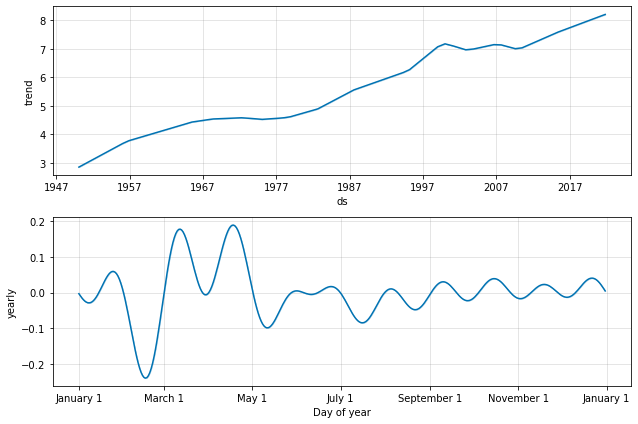

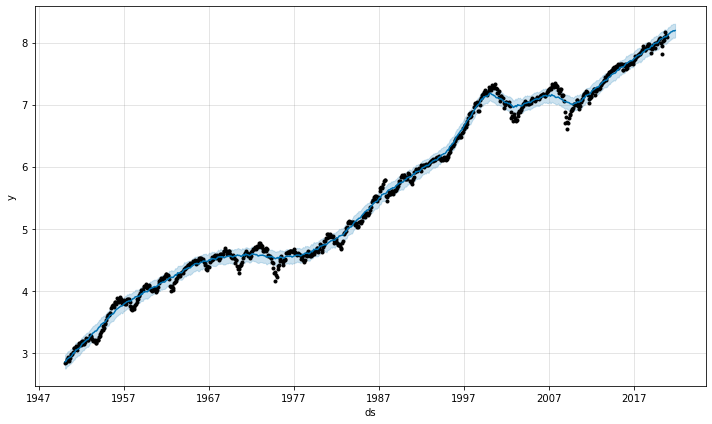

In [71]:
m = Prophet(changepoint_range = 0.95, seasonality_prior_scale = 5, changepoint_prior_scale=0.1)
m.fit(monthly_data_prophet)
future_dates = m.make_future_dataframe(periods=12, freq='MS')
forecast = m.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
m.plot_components(forecast);
m.plot(forecast);

## LSTM

In [15]:
lstm_data = monthly_data.set_index("Date")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type       | Params
----------------------------------------------
0 | lstm_layers    | ModuleList | 72.0 K
1 | dropout_layers | ModuleList | 0     
2 | linear         | Linear     | 51    
----------------------------------------------
72.1 K    Trainable params
0         Non-trainable params
72.1 K    Total params
0.288     Total estimated model params size (MB)


Sanity Checking: |                                                                           | 0/? [00:00<?, ?…

Training: |                                                                                  | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved. New best score: 58.892


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 6.371 >= min_delta = 0.0. New best score: 52.521
`Trainer.fit` stopped: `max_epochs=2` reached.


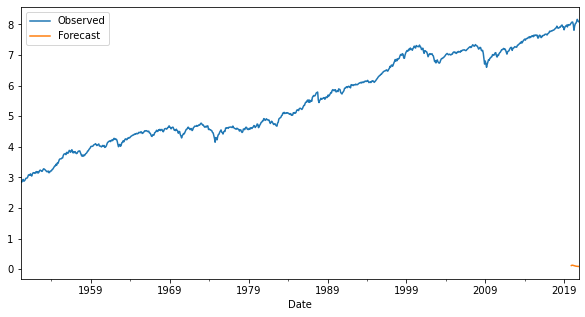

In [116]:
model = run_training_pipeline(lstm_data,
                      seq_length=12, batch_size=32, input_size=2, prediction_len=1,
                      hidden_layer_sizes=[100, 50], dropout_probs=[0.2, 0.2],                      
                      learning_rate=1e-4,max_epochs=2,name="test")
# for cutoff in cutoffs:
#     print(cutoff)
#     data = predict_iterativly(model, data, cutoff, add_forcast_to_frame = True)
#     plot_org_w_pred(data);

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type       | Params
----------------------------------------------
0 | lstm_layers    | ModuleList | 72.0 K
1 | dropout_layers | ModuleList | 0     
2 | linear         | Linear     | 51    
----------------------------------------------
72.1 K    Trainable params
0         Non-trainable params
72.1 K    Total params
0.288     Total estimated model params size (MB)


Sanity Checking: |                                                                           | 0/? [00:00<?, ?…

Training: |                                                                                  | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved. New best score: 59.850


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 4.294 >= min_delta = 0.0. New best score: 55.555


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 8.262 >= min_delta = 0.0. New best score: 47.293


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 10.437 >= min_delta = 0.0. New best score: 36.856


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 7.679 >= min_delta = 0.0. New best score: 29.177


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 5.437 >= min_delta = 0.0. New best score: 23.740


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 3.710 >= min_delta = 0.0. New best score: 20.030


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 2.550 >= min_delta = 0.0. New best score: 17.480


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.717 >= min_delta = 0.0. New best score: 15.764


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.289 >= min_delta = 0.0. New best score: 14.475


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.079 >= min_delta = 0.0. New best score: 13.395


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.855 >= min_delta = 0.0. New best score: 12.541


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.788 >= min_delta = 0.0. New best score: 11.753


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.650 >= min_delta = 0.0. New best score: 11.103


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.614 >= min_delta = 0.0. New best score: 10.488


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.472 >= min_delta = 0.0. New best score: 10.016


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.470 >= min_delta = 0.0. New best score: 9.546


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.460 >= min_delta = 0.0. New best score: 9.086


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.365 >= min_delta = 0.0. New best score: 8.721


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.258 >= min_delta = 0.0. New best score: 8.464


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.250 >= min_delta = 0.0. New best score: 8.214


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.280 >= min_delta = 0.0. New best score: 7.934


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.230 >= min_delta = 0.0. New best score: 7.704


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.220 >= min_delta = 0.0. New best score: 7.484


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.147 >= min_delta = 0.0. New best score: 7.337


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.174 >= min_delta = 0.0. New best score: 7.163


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.078 >= min_delta = 0.0. New best score: 7.085


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.122 >= min_delta = 0.0. New best score: 6.963


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 6.940


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.033 >= min_delta = 0.0. New best score: 6.907


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.040 >= min_delta = 0.0. New best score: 6.867


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.033 >= min_delta = 0.0. New best score: 6.834


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.029 >= min_delta = 0.0. New best score: 6.806


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.064 >= min_delta = 0.0. New best score: 6.742


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 6.727


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 6.706


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 6.691


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.226 >= min_delta = 0.0. New best score: 6.465


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.258 >= min_delta = 0.0. New best score: 6.207


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.339 >= min_delta = 0.0. New best score: 5.868


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.371 >= min_delta = 0.0. New best score: 5.497


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.380 >= min_delta = 0.0. New best score: 5.117


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.319 >= min_delta = 0.0. New best score: 4.799


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.287 >= min_delta = 0.0. New best score: 4.512


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.289 >= min_delta = 0.0. New best score: 4.223


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.269 >= min_delta = 0.0. New best score: 3.954


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.288 >= min_delta = 0.0. New best score: 3.666


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.213 >= min_delta = 0.0. New best score: 3.453


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.196 >= min_delta = 0.0. New best score: 3.257


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.192 >= min_delta = 0.0. New best score: 3.065


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.168 >= min_delta = 0.0. New best score: 2.897


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.174 >= min_delta = 0.0. New best score: 2.723


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.152 >= min_delta = 0.0. New best score: 2.571


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.150 >= min_delta = 0.0. New best score: 2.422


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.139 >= min_delta = 0.0. New best score: 2.283


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.106 >= min_delta = 0.0. New best score: 2.177


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.112 >= min_delta = 0.0. New best score: 2.064


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.111 >= min_delta = 0.0. New best score: 1.953


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.088 >= min_delta = 0.0. New best score: 1.866


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.082 >= min_delta = 0.0. New best score: 1.783


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.078 >= min_delta = 0.0. New best score: 1.705


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.096 >= min_delta = 0.0. New best score: 1.609


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.074 >= min_delta = 0.0. New best score: 1.535


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.064 >= min_delta = 0.0. New best score: 1.470


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.058 >= min_delta = 0.0. New best score: 1.413


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.066 >= min_delta = 0.0. New best score: 1.347


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.050 >= min_delta = 0.0. New best score: 1.297


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.044 >= min_delta = 0.0. New best score: 1.253


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.041 >= min_delta = 0.0. New best score: 1.212


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.038 >= min_delta = 0.0. New best score: 1.175


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.036 >= min_delta = 0.0. New best score: 1.139


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.049 >= min_delta = 0.0. New best score: 1.090


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.050 >= min_delta = 0.0. New best score: 1.040


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.054 >= min_delta = 0.0. New best score: 0.985


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 0.962


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.027 >= min_delta = 0.0. New best score: 0.935


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 0.913


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 0.897


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.030 >= min_delta = 0.0. New best score: 0.867


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 0.848


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.840


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.838


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 0.821


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.810


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.795


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.783


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.769


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.756


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.743


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.738


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.729


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.720


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.710


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.701


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.689


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.675


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 0.652


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.645


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.634


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.633


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.619


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.619


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.609


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 0.589


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.585


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 0.564


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.559


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.546


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 0.523


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.523


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.522


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.512


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.501


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 0.484


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.475


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.466


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.458


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.450


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.435


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.426


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.417


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 0.396


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.388


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.387


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.380


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.366


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.365


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.360


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.354


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.345


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 0.326


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 0.309


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.295


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.283


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.276


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.272


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.272


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.262


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.259


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.250


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.245
`Trainer.fit` stopped: `max_epochs=200` reached.


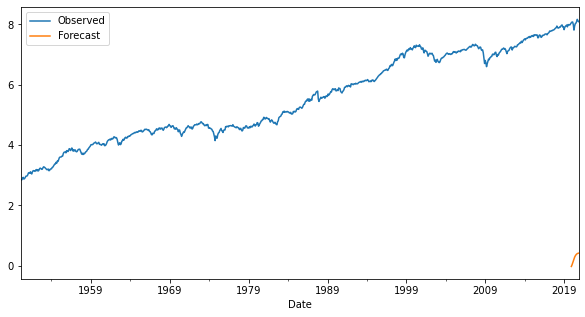

In [117]:
model = run_training_pipeline(lstm_data,
                      seq_length=12, batch_size=32, input_size=2, prediction_len=1,
                      hidden_layer_sizes=[100, 50], dropout_probs=[0.2, 0.2],                      
                      learning_rate=1e-4,max_epochs=500,name="bs32")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type       | Params
----------------------------------------------
0 | lstm_layers    | ModuleList | 72.0 K
1 | dropout_layers | ModuleList | 0     
2 | linear         | Linear     | 51    
----------------------------------------------
72.1 K    Trainable params
0         Non-trainable params
72.1 K    Total params
0.288     Total estimated model params size (MB)


Sanity Checking: |                                                                           | 0/? [00:00<?, ?…

Training: |                                                                                  | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved. New best score: 64.312


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.340 >= min_delta = 0.0. New best score: 63.972


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.350 >= min_delta = 0.0. New best score: 63.622


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.366 >= min_delta = 0.0. New best score: 63.256


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.395 >= min_delta = 0.0. New best score: 62.862


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.425 >= min_delta = 0.0. New best score: 62.437


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.443 >= min_delta = 0.0. New best score: 61.994


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.476 >= min_delta = 0.0. New best score: 61.518


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.521 >= min_delta = 0.0. New best score: 60.997


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.591 >= min_delta = 0.0. New best score: 60.407


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.636 >= min_delta = 0.0. New best score: 59.771


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.727 >= min_delta = 0.0. New best score: 59.044


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.786 >= min_delta = 0.0. New best score: 58.258


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.899 >= min_delta = 0.0. New best score: 57.360


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.983 >= min_delta = 0.0. New best score: 56.377


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.083 >= min_delta = 0.0. New best score: 55.294


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.207 >= min_delta = 0.0. New best score: 54.087


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.321 >= min_delta = 0.0. New best score: 52.766


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.449 >= min_delta = 0.0. New best score: 51.317


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.542 >= min_delta = 0.0. New best score: 49.775


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.596 >= min_delta = 0.0. New best score: 48.179


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.622 >= min_delta = 0.0. New best score: 46.557


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.618 >= min_delta = 0.0. New best score: 44.939


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.599 >= min_delta = 0.0. New best score: 43.340


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.531 >= min_delta = 0.0. New best score: 41.809


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.470 >= min_delta = 0.0. New best score: 40.339


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.394 >= min_delta = 0.0. New best score: 38.945


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.267 >= min_delta = 0.0. New best score: 37.677


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.183 >= min_delta = 0.0. New best score: 36.495


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.108 >= min_delta = 0.0. New best score: 35.387


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.020 >= min_delta = 0.0. New best score: 34.367


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.929 >= min_delta = 0.0. New best score: 33.438


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.871 >= min_delta = 0.0. New best score: 32.567


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.812 >= min_delta = 0.0. New best score: 31.755


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.719 >= min_delta = 0.0. New best score: 31.036


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.688 >= min_delta = 0.0. New best score: 30.348


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.638 >= min_delta = 0.0. New best score: 29.710


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.600 >= min_delta = 0.0. New best score: 29.110


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.557 >= min_delta = 0.0. New best score: 28.554


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.520 >= min_delta = 0.0. New best score: 28.034


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.503 >= min_delta = 0.0. New best score: 27.531


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.477 >= min_delta = 0.0. New best score: 27.054


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.462 >= min_delta = 0.0. New best score: 26.592


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.451 >= min_delta = 0.0. New best score: 26.140


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.448 >= min_delta = 0.0. New best score: 25.693


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.415 >= min_delta = 0.0. New best score: 25.277


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.413 >= min_delta = 0.0. New best score: 24.864


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.385 >= min_delta = 0.0. New best score: 24.479


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.381 >= min_delta = 0.0. New best score: 24.098


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.370 >= min_delta = 0.0. New best score: 23.727


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.360 >= min_delta = 0.0. New best score: 23.367


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.338 >= min_delta = 0.0. New best score: 23.030


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.338 >= min_delta = 0.0. New best score: 22.692


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.309 >= min_delta = 0.0. New best score: 22.383


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.300 >= min_delta = 0.0. New best score: 22.083


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.289 >= min_delta = 0.0. New best score: 21.794


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.280 >= min_delta = 0.0. New best score: 21.514


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.271 >= min_delta = 0.0. New best score: 21.243


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.276 >= min_delta = 0.0. New best score: 20.968


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.268 >= min_delta = 0.0. New best score: 20.699


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.264 >= min_delta = 0.0. New best score: 20.435


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.245 >= min_delta = 0.0. New best score: 20.191


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.234 >= min_delta = 0.0. New best score: 19.957


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.234 >= min_delta = 0.0. New best score: 19.723


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.226 >= min_delta = 0.0. New best score: 19.497


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.227 >= min_delta = 0.0. New best score: 19.270


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.218 >= min_delta = 0.0. New best score: 19.052


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.210 >= min_delta = 0.0. New best score: 18.841


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.208 >= min_delta = 0.0. New best score: 18.634


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.192 >= min_delta = 0.0. New best score: 18.442


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.188 >= min_delta = 0.0. New best score: 18.253


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.192 >= min_delta = 0.0. New best score: 18.061


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.181 >= min_delta = 0.0. New best score: 17.880


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.172 >= min_delta = 0.0. New best score: 17.709


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.176 >= min_delta = 0.0. New best score: 17.533


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.162 >= min_delta = 0.0. New best score: 17.371


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.158 >= min_delta = 0.0. New best score: 17.213


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.153 >= min_delta = 0.0. New best score: 17.060


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.161 >= min_delta = 0.0. New best score: 16.898


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.153 >= min_delta = 0.0. New best score: 16.745


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.147 >= min_delta = 0.0. New best score: 16.599


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.148 >= min_delta = 0.0. New best score: 16.451


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.147 >= min_delta = 0.0. New best score: 16.304


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.142 >= min_delta = 0.0. New best score: 16.162


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.131 >= min_delta = 0.0. New best score: 16.031


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.128 >= min_delta = 0.0. New best score: 15.903


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.131 >= min_delta = 0.0. New best score: 15.773


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.131 >= min_delta = 0.0. New best score: 15.642


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.130 >= min_delta = 0.0. New best score: 15.512


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.122 >= min_delta = 0.0. New best score: 15.390


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.115 >= min_delta = 0.0. New best score: 15.275


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.116 >= min_delta = 0.0. New best score: 15.159


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.122 >= min_delta = 0.0. New best score: 15.037


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.118 >= min_delta = 0.0. New best score: 14.919


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.110 >= min_delta = 0.0. New best score: 14.808


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.102 >= min_delta = 0.0. New best score: 14.706


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.110 >= min_delta = 0.0. New best score: 14.596


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.110 >= min_delta = 0.0. New best score: 14.485


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.102 >= min_delta = 0.0. New best score: 14.383


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.103 >= min_delta = 0.0. New best score: 14.280


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.102 >= min_delta = 0.0. New best score: 14.179


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.102 >= min_delta = 0.0. New best score: 14.077


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.107 >= min_delta = 0.0. New best score: 13.970


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.108 >= min_delta = 0.0. New best score: 13.861


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.097 >= min_delta = 0.0. New best score: 13.765


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.106 >= min_delta = 0.0. New best score: 13.659


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.097 >= min_delta = 0.0. New best score: 13.562


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.100 >= min_delta = 0.0. New best score: 13.462


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.095 >= min_delta = 0.0. New best score: 13.366


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.106 >= min_delta = 0.0. New best score: 13.260


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.105 >= min_delta = 0.0. New best score: 13.155


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.107 >= min_delta = 0.0. New best score: 13.049


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.100 >= min_delta = 0.0. New best score: 12.948


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.090 >= min_delta = 0.0. New best score: 12.858


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.098 >= min_delta = 0.0. New best score: 12.760


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.090 >= min_delta = 0.0. New best score: 12.670


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.095 >= min_delta = 0.0. New best score: 12.576


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.085 >= min_delta = 0.0. New best score: 12.491


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.091 >= min_delta = 0.0. New best score: 12.399


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.083 >= min_delta = 0.0. New best score: 12.316


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.084 >= min_delta = 0.0. New best score: 12.232


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.091 >= min_delta = 0.0. New best score: 12.142


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.085 >= min_delta = 0.0. New best score: 12.056


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.079 >= min_delta = 0.0. New best score: 11.978


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.073 >= min_delta = 0.0. New best score: 11.905


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.075 >= min_delta = 0.0. New best score: 11.830


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.077 >= min_delta = 0.0. New best score: 11.752


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.076 >= min_delta = 0.0. New best score: 11.676


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.069 >= min_delta = 0.0. New best score: 11.608


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.079 >= min_delta = 0.0. New best score: 11.529


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.069 >= min_delta = 0.0. New best score: 11.460


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.070 >= min_delta = 0.0. New best score: 11.390


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.074 >= min_delta = 0.0. New best score: 11.315


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.071 >= min_delta = 0.0. New best score: 11.244


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.067 >= min_delta = 0.0. New best score: 11.177


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.072 >= min_delta = 0.0. New best score: 11.105


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.062 >= min_delta = 0.0. New best score: 11.043


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.065 >= min_delta = 0.0. New best score: 10.978


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.063 >= min_delta = 0.0. New best score: 10.915


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.065 >= min_delta = 0.0. New best score: 10.850


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.062 >= min_delta = 0.0. New best score: 10.788


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.063 >= min_delta = 0.0. New best score: 10.725


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.068 >= min_delta = 0.0. New best score: 10.657


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.058 >= min_delta = 0.0. New best score: 10.599


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.054 >= min_delta = 0.0. New best score: 10.545


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.059 >= min_delta = 0.0. New best score: 10.486


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.058 >= min_delta = 0.0. New best score: 10.428


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.052 >= min_delta = 0.0. New best score: 10.376


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.056 >= min_delta = 0.0. New best score: 10.320


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.060 >= min_delta = 0.0. New best score: 10.260


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.063 >= min_delta = 0.0. New best score: 10.197


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.060 >= min_delta = 0.0. New best score: 10.137


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.049 >= min_delta = 0.0. New best score: 10.088


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.049 >= min_delta = 0.0. New best score: 10.040


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.054 >= min_delta = 0.0. New best score: 9.985


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.050 >= min_delta = 0.0. New best score: 9.936


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.050 >= min_delta = 0.0. New best score: 9.886


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.057 >= min_delta = 0.0. New best score: 9.829


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.050 >= min_delta = 0.0. New best score: 9.779


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.050 >= min_delta = 0.0. New best score: 9.729


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.051 >= min_delta = 0.0. New best score: 9.677


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.048 >= min_delta = 0.0. New best score: 9.629


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.051 >= min_delta = 0.0. New best score: 9.578


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.049 >= min_delta = 0.0. New best score: 9.529


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.051 >= min_delta = 0.0. New best score: 9.478


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.053 >= min_delta = 0.0. New best score: 9.425


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.050 >= min_delta = 0.0. New best score: 9.375


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.051 >= min_delta = 0.0. New best score: 9.324


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.046 >= min_delta = 0.0. New best score: 9.277


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.046 >= min_delta = 0.0. New best score: 9.231


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.051 >= min_delta = 0.0. New best score: 9.180


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.048 >= min_delta = 0.0. New best score: 9.132


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.051 >= min_delta = 0.0. New best score: 9.082


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.042 >= min_delta = 0.0. New best score: 9.040


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.048 >= min_delta = 0.0. New best score: 8.991


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.041 >= min_delta = 0.0. New best score: 8.951


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.042 >= min_delta = 0.0. New best score: 8.908


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.039 >= min_delta = 0.0. New best score: 8.869


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.038 >= min_delta = 0.0. New best score: 8.831


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.044 >= min_delta = 0.0. New best score: 8.787


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.036 >= min_delta = 0.0. New best score: 8.751


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.033 >= min_delta = 0.0. New best score: 8.718


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.038 >= min_delta = 0.0. New best score: 8.680


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.045 >= min_delta = 0.0. New best score: 8.634


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.037 >= min_delta = 0.0. New best score: 8.598


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.038 >= min_delta = 0.0. New best score: 8.560


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.044 >= min_delta = 0.0. New best score: 8.516


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.042 >= min_delta = 0.0. New best score: 8.474


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.036 >= min_delta = 0.0. New best score: 8.438


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.033 >= min_delta = 0.0. New best score: 8.405


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.035 >= min_delta = 0.0. New best score: 8.370


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.031 >= min_delta = 0.0. New best score: 8.339


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.028 >= min_delta = 0.0. New best score: 8.312


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.031 >= min_delta = 0.0. New best score: 8.280


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.034 >= min_delta = 0.0. New best score: 8.246


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.041 >= min_delta = 0.0. New best score: 8.204


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.042 >= min_delta = 0.0. New best score: 8.163


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.032 >= min_delta = 0.0. New best score: 8.131


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.031 >= min_delta = 0.0. New best score: 8.100


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 8.078
`Trainer.fit` stopped: `max_epochs=200` reached.


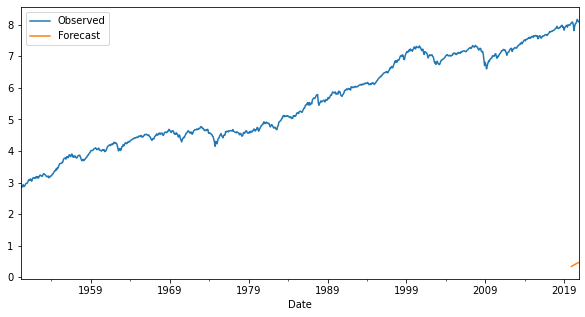

In [118]:
model = run_training_pipeline(lstm_data,
                      seq_length=12, batch_size=32, input_size=2, prediction_len=1,
                      hidden_layer_sizes=[100, 50], dropout_probs=[0.2, 0.2],                      
                      learning_rate=1e-5,max_epochs=500,name="bs32_1e-5")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type       | Params
----------------------------------------------
0 | lstm_layers    | ModuleList | 18.5 K
1 | dropout_layers | ModuleList | 0     
2 | linear         | Linear     | 26    
----------------------------------------------
18.5 K    Trainable params
0         Non-trainable params
18.5 K    Total params
0.074     Total estimated model params size (MB)


Sanity Checking: |                                                                           | 0/? [00:00<?, ?…

Training: |                                                                                  | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved. New best score: 62.802


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.601 >= min_delta = 0.0. New best score: 61.201


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 2.022 >= min_delta = 0.0. New best score: 59.179


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 2.791 >= min_delta = 0.0. New best score: 56.388


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 4.061 >= min_delta = 0.0. New best score: 52.328


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 4.873 >= min_delta = 0.0. New best score: 47.454


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 4.273 >= min_delta = 0.0. New best score: 43.181


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 3.712 >= min_delta = 0.0. New best score: 39.469


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 3.333 >= min_delta = 0.0. New best score: 36.136


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 2.838 >= min_delta = 0.0. New best score: 33.298


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 2.485 >= min_delta = 0.0. New best score: 30.812


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 2.210 >= min_delta = 0.0. New best score: 28.603


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 2.062 >= min_delta = 0.0. New best score: 26.541


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.912 >= min_delta = 0.0. New best score: 24.628


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.493 >= min_delta = 0.0. New best score: 23.135


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.177 >= min_delta = 0.0. New best score: 21.959


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.038 >= min_delta = 0.0. New best score: 20.920


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.035 >= min_delta = 0.0. New best score: 19.885


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.018 >= min_delta = 0.0. New best score: 18.867


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.922 >= min_delta = 0.0. New best score: 17.945


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.729 >= min_delta = 0.0. New best score: 17.216


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.646 >= min_delta = 0.0. New best score: 16.570


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.568 >= min_delta = 0.0. New best score: 16.002


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.518 >= min_delta = 0.0. New best score: 15.485


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.482 >= min_delta = 0.0. New best score: 15.003


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.463 >= min_delta = 0.0. New best score: 14.540


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.407 >= min_delta = 0.0. New best score: 14.133


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.388 >= min_delta = 0.0. New best score: 13.745


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.382 >= min_delta = 0.0. New best score: 13.363


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.378 >= min_delta = 0.0. New best score: 12.985


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.352 >= min_delta = 0.0. New best score: 12.634


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.306 >= min_delta = 0.0. New best score: 12.328


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.283 >= min_delta = 0.0. New best score: 12.044


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.283 >= min_delta = 0.0. New best score: 11.761


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.282 >= min_delta = 0.0. New best score: 11.479


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.253 >= min_delta = 0.0. New best score: 11.227


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.257 >= min_delta = 0.0. New best score: 10.970


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.238 >= min_delta = 0.0. New best score: 10.732


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.241 >= min_delta = 0.0. New best score: 10.491


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.240 >= min_delta = 0.0. New best score: 10.251


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.180 >= min_delta = 0.0. New best score: 10.070


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.193 >= min_delta = 0.0. New best score: 9.877


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.189 >= min_delta = 0.0. New best score: 9.688


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.146 >= min_delta = 0.0. New best score: 9.542


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.160 >= min_delta = 0.0. New best score: 9.382


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.158 >= min_delta = 0.0. New best score: 9.223


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.149 >= min_delta = 0.0. New best score: 9.074


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.124 >= min_delta = 0.0. New best score: 8.951


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.119 >= min_delta = 0.0. New best score: 8.832


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.133 >= min_delta = 0.0. New best score: 8.699


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.117 >= min_delta = 0.0. New best score: 8.582


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.100 >= min_delta = 0.0. New best score: 8.481


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.094 >= min_delta = 0.0. New best score: 8.387


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.096 >= min_delta = 0.0. New best score: 8.291


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.118 >= min_delta = 0.0. New best score: 8.173


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.106 >= min_delta = 0.0. New best score: 8.068


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.070 >= min_delta = 0.0. New best score: 7.998


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.096 >= min_delta = 0.0. New best score: 7.902


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.074 >= min_delta = 0.0. New best score: 7.828


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.085 >= min_delta = 0.0. New best score: 7.743


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.074 >= min_delta = 0.0. New best score: 7.670


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.060 >= min_delta = 0.0. New best score: 7.610


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.055 >= min_delta = 0.0. New best score: 7.555


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.088 >= min_delta = 0.0. New best score: 7.466


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.051 >= min_delta = 0.0. New best score: 7.415


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.069 >= min_delta = 0.0. New best score: 7.346


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.032 >= min_delta = 0.0. New best score: 7.315


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.047 >= min_delta = 0.0. New best score: 7.268


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.069 >= min_delta = 0.0. New best score: 7.199


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.042 >= min_delta = 0.0. New best score: 7.157


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 7.156


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 7.149


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 7.127


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.036 >= min_delta = 0.0. New best score: 7.091


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.052 >= min_delta = 0.0. New best score: 7.039


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 7.034


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.086 >= min_delta = 0.0. New best score: 6.948


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.182 >= min_delta = 0.0. New best score: 6.766


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.177 >= min_delta = 0.0. New best score: 6.589


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.240 >= min_delta = 0.0. New best score: 6.348


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.227 >= min_delta = 0.0. New best score: 6.121


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.199 >= min_delta = 0.0. New best score: 5.922


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.210 >= min_delta = 0.0. New best score: 5.712


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.201 >= min_delta = 0.0. New best score: 5.511


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.173 >= min_delta = 0.0. New best score: 5.338


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.162 >= min_delta = 0.0. New best score: 5.176


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.150 >= min_delta = 0.0. New best score: 5.026


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.152 >= min_delta = 0.0. New best score: 4.874


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.170 >= min_delta = 0.0. New best score: 4.704


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.145 >= min_delta = 0.0. New best score: 4.560


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.140 >= min_delta = 0.0. New best score: 4.420


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.114 >= min_delta = 0.0. New best score: 4.306


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.136 >= min_delta = 0.0. New best score: 4.170


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.124 >= min_delta = 0.0. New best score: 4.046


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.135 >= min_delta = 0.0. New best score: 3.911


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.109 >= min_delta = 0.0. New best score: 3.802


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.099 >= min_delta = 0.0. New best score: 3.703


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.112 >= min_delta = 0.0. New best score: 3.591


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.106 >= min_delta = 0.0. New best score: 3.485


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.097 >= min_delta = 0.0. New best score: 3.388


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.102 >= min_delta = 0.0. New best score: 3.286


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.092 >= min_delta = 0.0. New best score: 3.194


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.081 >= min_delta = 0.0. New best score: 3.113


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.085 >= min_delta = 0.0. New best score: 3.028


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.082 >= min_delta = 0.0. New best score: 2.946


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.081 >= min_delta = 0.0. New best score: 2.866


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.073 >= min_delta = 0.0. New best score: 2.792


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.069 >= min_delta = 0.0. New best score: 2.724


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.061 >= min_delta = 0.0. New best score: 2.662


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.057 >= min_delta = 0.0. New best score: 2.605


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.079 >= min_delta = 0.0. New best score: 2.526


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.066 >= min_delta = 0.0. New best score: 2.460


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.046 >= min_delta = 0.0. New best score: 2.415


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.065 >= min_delta = 0.0. New best score: 2.350


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.058 >= min_delta = 0.0. New best score: 2.293


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.051 >= min_delta = 0.0. New best score: 2.242


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.060 >= min_delta = 0.0. New best score: 2.182


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.039 >= min_delta = 0.0. New best score: 2.143


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.058 >= min_delta = 0.0. New best score: 2.085


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.051 >= min_delta = 0.0. New best score: 2.034


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.052 >= min_delta = 0.0. New best score: 1.982


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.044 >= min_delta = 0.0. New best score: 1.938


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.050 >= min_delta = 0.0. New best score: 1.888


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.035 >= min_delta = 0.0. New best score: 1.853


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.048 >= min_delta = 0.0. New best score: 1.805


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.047 >= min_delta = 0.0. New best score: 1.758


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.043 >= min_delta = 0.0. New best score: 1.716


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.030 >= min_delta = 0.0. New best score: 1.685


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.035 >= min_delta = 0.0. New best score: 1.650


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.037 >= min_delta = 0.0. New best score: 1.614


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.039 >= min_delta = 0.0. New best score: 1.575


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.043 >= min_delta = 0.0. New best score: 1.532


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 1.511


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.035 >= min_delta = 0.0. New best score: 1.476


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.041 >= min_delta = 0.0. New best score: 1.435


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.033 >= min_delta = 0.0. New best score: 1.402


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 1.382


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.032 >= min_delta = 0.0. New best score: 1.350


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 1.333


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 1.309


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.028 >= min_delta = 0.0. New best score: 1.281


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 1.260


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.031 >= min_delta = 0.0. New best score: 1.228


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 1.206


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.030 >= min_delta = 0.0. New best score: 1.176


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.040 >= min_delta = 0.0. New best score: 1.136


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 1.121


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 1.107


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.029 >= min_delta = 0.0. New best score: 1.078


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 1.056


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 1.038


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 1.026


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 1.012


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 0.990


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.975


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.967


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.953


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 0.931


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.926


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.912


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.898


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 0.879


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.872


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.865


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.856


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.841


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.839


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 0.815


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.805


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.792


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.788


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.785


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.778


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 0.756


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.756


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 0.735


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.726


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.721


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.719


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.705


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 0.687


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.672


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.668


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 0.647


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.644


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.643


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.635


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 0.613


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 0.595


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.591


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 0.574
`Trainer.fit` stopped: `max_epochs=200` reached.


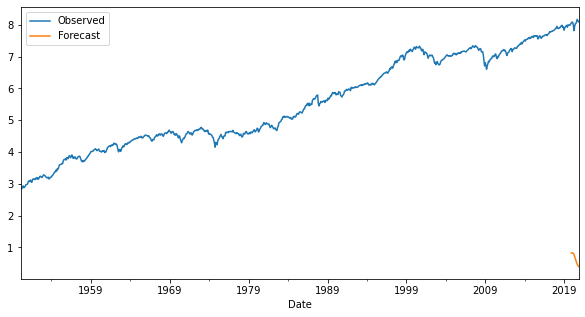

In [119]:
model = run_training_pipeline(lstm_data,
                      seq_length=12, batch_size=32, input_size=2, prediction_len=1,
                      hidden_layer_sizes=[50, 25], dropout_probs=[0.2, 0.2],                      
                      learning_rate=1e-4,max_epochs=500,name="bs32_50_25")

In [120]:
model = run_training_pipeline(lstm_data,
                      seq_length=24, batch_size=32, input_size=2, prediction_len=1,
                      hidden_layer_sizes=[100, 50], dropout_probs=[0.2, 0.2],                      
                      learning_rate=1e-4,max_epochs=500,name="bs32_2years")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type       | Params
----------------------------------------------
0 | lstm_layers    | ModuleList | 72.0 K
1 | dropout_layers | ModuleList | 0     
2 | linear         | Linear     | 51    
----------------------------------------------
72.1 K    Trainable params
0         Non-trainable params
72.1 K    Total params
0.288     Total estimated model params size (MB)


Sanity Checking: |                                                                           | 0/? [00:00<?, ?…

Training: |                                                                                  | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved. New best score: 60.724


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 4.508 >= min_delta = 0.0. New best score: 56.216


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 7.952 >= min_delta = 0.0. New best score: 48.263


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 10.580 >= min_delta = 0.0. New best score: 37.683


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 9.462 >= min_delta = 0.0. New best score: 28.221


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 5.972 >= min_delta = 0.0. New best score: 22.249


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 3.706 >= min_delta = 0.0. New best score: 18.543


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 2.455 >= min_delta = 0.0. New best score: 16.088


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.704 >= min_delta = 0.0. New best score: 14.383


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.311 >= min_delta = 0.0. New best score: 13.072


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.068 >= min_delta = 0.0. New best score: 12.005


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.830 >= min_delta = 0.0. New best score: 11.175


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.702 >= min_delta = 0.0. New best score: 10.473


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.547 >= min_delta = 0.0. New best score: 9.927


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.483 >= min_delta = 0.0. New best score: 9.444


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.404 >= min_delta = 0.0. New best score: 9.040


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.364 >= min_delta = 0.0. New best score: 8.676


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.301 >= min_delta = 0.0. New best score: 8.374


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.296 >= min_delta = 0.0. New best score: 8.078


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.224 >= min_delta = 0.0. New best score: 7.854


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.196 >= min_delta = 0.0. New best score: 7.658


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.187 >= min_delta = 0.0. New best score: 7.471


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.162 >= min_delta = 0.0. New best score: 7.310


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.141 >= min_delta = 0.0. New best score: 7.169


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.134 >= min_delta = 0.0. New best score: 7.034


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.102 >= min_delta = 0.0. New best score: 6.933


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.106 >= min_delta = 0.0. New best score: 6.826


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.051 >= min_delta = 0.0. New best score: 6.775


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.061 >= min_delta = 0.0. New best score: 6.714


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.033 >= min_delta = 0.0. New best score: 6.681


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.091 >= min_delta = 0.0. New best score: 6.590


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.153 >= min_delta = 0.0. New best score: 6.437


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.073 >= min_delta = 0.0. New best score: 6.364


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.230 >= min_delta = 0.0. New best score: 6.134


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.386 >= min_delta = 0.0. New best score: 5.748


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.388 >= min_delta = 0.0. New best score: 5.360


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.390 >= min_delta = 0.0. New best score: 4.971


KeyboardInterrupt: 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type       | Params
----------------------------------------------
0 | lstm_layers    | ModuleList | 72.0 K
1 | dropout_layers | ModuleList | 0     
2 | linear         | Linear     | 51    
----------------------------------------------
72.1 K    Trainable params
0         Non-trainable params
72.1 K    Total params
0.288     Total estimated model params size (MB)


Sanity Checking: |                                                                           | 0/? [00:00<?, ?…

Training: |                                                                                  | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved. New best score: 58.491


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 17.544 >= min_delta = 0.0. New best score: 40.947


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 13.823 >= min_delta = 0.0. New best score: 27.124


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 6.590 >= min_delta = 0.0. New best score: 20.534


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 3.778 >= min_delta = 0.0. New best score: 16.756


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 2.350 >= min_delta = 0.0. New best score: 14.406


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.743 >= min_delta = 0.0. New best score: 12.663


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.290 >= min_delta = 0.0. New best score: 11.373


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.027 >= min_delta = 0.0. New best score: 10.346


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.773 >= min_delta = 0.0. New best score: 9.574


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.694 >= min_delta = 0.0. New best score: 8.880


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.498 >= min_delta = 0.0. New best score: 8.382


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.429 >= min_delta = 0.0. New best score: 7.952


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.341 >= min_delta = 0.0. New best score: 7.612


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.304 >= min_delta = 0.0. New best score: 7.308


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.152 >= min_delta = 0.0. New best score: 7.156


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.211 >= min_delta = 0.0. New best score: 6.945


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.151 >= min_delta = 0.0. New best score: 6.794


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.047 >= min_delta = 0.0. New best score: 6.746


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.060 >= min_delta = 0.0. New best score: 6.686


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.071 >= min_delta = 0.0. New best score: 6.616


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.094 >= min_delta = 0.0. New best score: 6.522


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.056 >= min_delta = 0.0. New best score: 6.466


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.031 >= min_delta = 0.0. New best score: 6.435


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.674 >= min_delta = 0.0. New best score: 5.761


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.808 >= min_delta = 0.0. New best score: 4.953


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.664 >= min_delta = 0.0. New best score: 4.289


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.522 >= min_delta = 0.0. New best score: 3.767


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.417 >= min_delta = 0.0. New best score: 3.349


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.395 >= min_delta = 0.0. New best score: 2.954


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.313 >= min_delta = 0.0. New best score: 2.642


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.258 >= min_delta = 0.0. New best score: 2.383


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.217 >= min_delta = 0.0. New best score: 2.167


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.199 >= min_delta = 0.0. New best score: 1.968


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.182 >= min_delta = 0.0. New best score: 1.787


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.154 >= min_delta = 0.0. New best score: 1.633


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.121 >= min_delta = 0.0. New best score: 1.512


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.119 >= min_delta = 0.0. New best score: 1.393


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.113 >= min_delta = 0.0. New best score: 1.280


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.064 >= min_delta = 0.0. New best score: 1.216


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.097 >= min_delta = 0.0. New best score: 1.119


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.082 >= min_delta = 0.0. New best score: 1.036


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.066 >= min_delta = 0.0. New best score: 0.970


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.036 >= min_delta = 0.0. New best score: 0.934


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.055 >= min_delta = 0.0. New best score: 0.879


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.035 >= min_delta = 0.0. New best score: 0.844


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.025 >= min_delta = 0.0. New best score: 0.819


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 0.795


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 0.773


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.038 >= min_delta = 0.0. New best score: 0.736


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.724


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.027 >= min_delta = 0.0. New best score: 0.697


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.685


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 0.665


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 0.646


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.634


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.620


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 0.597


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 0.576


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.028 >= min_delta = 0.0. New best score: 0.548


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 0.526


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.526


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.520


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.025 >= min_delta = 0.0. New best score: 0.496


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.489


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 0.467


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.039 >= min_delta = 0.0. New best score: 0.428


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.417


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 0.401


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.394


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 0.374


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.364


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.353


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 0.335


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.329


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.318


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.305


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.292


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.277


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.267


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 0.251


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 0.227


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.221


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.210


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 0.189


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.186


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.025 >= min_delta = 0.0. New best score: 0.161


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.161. Signaling Trainer to stop.


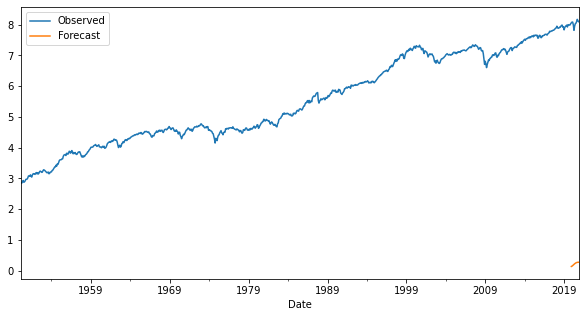

In [121]:
model = run_training_pipeline(lstm_data,
                      seq_length=12, batch_size=16, input_size=2, prediction_len=1,
                      hidden_layer_sizes=[100, 50], dropout_probs=[0.2, 0.2],                      
                      learning_rate=1e-4,max_epochs=500,name="bs16")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type       | Params
----------------------------------------------
0 | lstm_layers    | ModuleList | 72.0 K
1 | dropout_layers | ModuleList | 0     
2 | linear         | Linear     | 51    
----------------------------------------------
72.1 K    Trainable params
0         Non-trainable params
72.1 K    Total params
0.288     Total estimated model params size (MB)


Sanity Checking: |                                                                           | 0/? [00:00<?, ?…

Training: |                                                                                  | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved. New best score: 63.401


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 5.725 >= min_delta = 0.0. New best score: 57.676


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 13.561 >= min_delta = 0.0. New best score: 44.115


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 11.414 >= min_delta = 0.0. New best score: 32.702


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 7.127 >= min_delta = 0.0. New best score: 25.575


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 4.530 >= min_delta = 0.0. New best score: 21.045


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 2.762 >= min_delta = 0.0. New best score: 18.283


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.949 >= min_delta = 0.0. New best score: 16.335


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.431 >= min_delta = 0.0. New best score: 14.904


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.164 >= min_delta = 0.0. New best score: 13.740


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.945 >= min_delta = 0.0. New best score: 12.795


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.877 >= min_delta = 0.0. New best score: 11.919


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.701 >= min_delta = 0.0. New best score: 11.217


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.613 >= min_delta = 0.0. New best score: 10.605


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.516 >= min_delta = 0.0. New best score: 10.089


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.470 >= min_delta = 0.0. New best score: 9.619


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.361 >= min_delta = 0.0. New best score: 9.258


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.327 >= min_delta = 0.0. New best score: 8.931


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.313 >= min_delta = 0.0. New best score: 8.618


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.278 >= min_delta = 0.0. New best score: 8.340


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.228 >= min_delta = 0.0. New best score: 8.112


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.218 >= min_delta = 0.0. New best score: 7.893


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.173 >= min_delta = 0.0. New best score: 7.720


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.184 >= min_delta = 0.0. New best score: 7.536


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.145 >= min_delta = 0.0. New best score: 7.391


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.152 >= min_delta = 0.0. New best score: 7.239


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.095 >= min_delta = 0.0. New best score: 7.144


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.082 >= min_delta = 0.0. New best score: 7.062


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.287 >= min_delta = 0.0. New best score: 6.775


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.175 >= min_delta = 0.0. New best score: 6.600


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.202 >= min_delta = 0.0. New best score: 6.398


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.215 >= min_delta = 0.0. New best score: 6.184


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.188 >= min_delta = 0.0. New best score: 5.996


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.172 >= min_delta = 0.0. New best score: 5.824


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.194 >= min_delta = 0.0. New best score: 5.630


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.247 >= min_delta = 0.0. New best score: 5.384


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.264 >= min_delta = 0.0. New best score: 5.120


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.300 >= min_delta = 0.0. New best score: 4.820


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.341 >= min_delta = 0.0. New best score: 4.479


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.302 >= min_delta = 0.0. New best score: 4.177


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.278 >= min_delta = 0.0. New best score: 3.899


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.263 >= min_delta = 0.0. New best score: 3.636


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.225 >= min_delta = 0.0. New best score: 3.411


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.221 >= min_delta = 0.0. New best score: 3.190


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.198 >= min_delta = 0.0. New best score: 2.992


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.239 >= min_delta = 0.0. New best score: 2.753


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.251 >= min_delta = 0.0. New best score: 2.502


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.182 >= min_delta = 0.0. New best score: 2.321


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.156 >= min_delta = 0.0. New best score: 2.164


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.133 >= min_delta = 0.0. New best score: 2.031


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.117 >= min_delta = 0.0. New best score: 1.915


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.091 >= min_delta = 0.0. New best score: 1.824


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.099 >= min_delta = 0.0. New best score: 1.725


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.094 >= min_delta = 0.0. New best score: 1.631


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.075 >= min_delta = 0.0. New best score: 1.555


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.101 >= min_delta = 0.0. New best score: 1.454


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.055 >= min_delta = 0.0. New best score: 1.399


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.056 >= min_delta = 0.0. New best score: 1.344


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.059 >= min_delta = 0.0. New best score: 1.285


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.066 >= min_delta = 0.0. New best score: 1.219


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.045 >= min_delta = 0.0. New best score: 1.173


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.053 >= min_delta = 0.0. New best score: 1.120


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.040 >= min_delta = 0.0. New best score: 1.080


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.043 >= min_delta = 0.0. New best score: 1.038


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.031 >= min_delta = 0.0. New best score: 1.007


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.043 >= min_delta = 0.0. New best score: 0.963


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 0.944


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.025 >= min_delta = 0.0. New best score: 0.918


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.031 >= min_delta = 0.0. New best score: 0.887


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 0.866


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 0.843


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 0.824


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 0.808


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.035 >= min_delta = 0.0. New best score: 0.772


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.758


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 0.741


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.737


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.725


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.025 >= min_delta = 0.0. New best score: 0.700


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.697


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.694


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 0.675


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.666


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.651


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.643


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.642


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.631


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.628


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.627


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 0.608


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.602


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.593


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.026 >= min_delta = 0.0. New best score: 0.567


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 0.542


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.530


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.521


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.518


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 0.496


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.485


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.485


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.476


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.476


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.471


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.458


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.456


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.441


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.426


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.422


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.421


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 0.401


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.397


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.396


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 0.376


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.373


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.362


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.353


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.350


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.338


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.335


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.031 >= min_delta = 0.0. New best score: 0.304


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 0.286


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.277


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.276


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.272


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.271


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.267


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.263


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.028 >= min_delta = 0.0. New best score: 0.235


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.235. Signaling Trainer to stop.


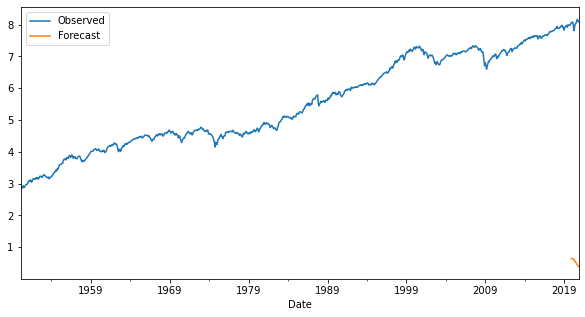

In [122]:
model = run_training_pipeline(lstm_data,
                      seq_length=12, batch_size=16, input_size=2, prediction_len=1,
                      hidden_layer_sizes=[100, 50], dropout_probs=[0.2, 0.2],                      
                      learning_rate=5e-5,max_epochs=500,name="bs16_5e-5")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type       | Params
----------------------------------------------
0 | lstm_layers    | ModuleList | 72.0 K
1 | dropout_layers | ModuleList | 0     
2 | linear         | Linear     | 51    
----------------------------------------------
72.1 K    Trainable params
0         Non-trainable params
72.1 K    Total params
0.288     Total estimated model params size (MB)


Sanity Checking: |                                                                           | 0/? [00:00<?, ?…

Training: |                                                                                  | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved. New best score: 59.047


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 19.666 >= min_delta = 0.0. New best score: 39.381


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 12.310 >= min_delta = 0.0. New best score: 27.072


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 5.874 >= min_delta = 0.0. New best score: 21.197


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 3.684 >= min_delta = 0.0. New best score: 17.513


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 2.506 >= min_delta = 0.0. New best score: 15.007


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.732 >= min_delta = 0.0. New best score: 13.276


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.322 >= min_delta = 0.0. New best score: 11.953


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.022 >= min_delta = 0.0. New best score: 10.931


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.872 >= min_delta = 0.0. New best score: 10.059


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.657 >= min_delta = 0.0. New best score: 9.401


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.685 >= min_delta = 0.0. New best score: 8.717


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.526 >= min_delta = 0.0. New best score: 8.191


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.406 >= min_delta = 0.0. New best score: 7.784


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.242 >= min_delta = 0.0. New best score: 7.542


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.289 >= min_delta = 0.0. New best score: 7.253


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.152 >= min_delta = 0.0. New best score: 7.101


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.174 >= min_delta = 0.0. New best score: 6.927


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.128 >= min_delta = 0.0. New best score: 6.799


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.094 >= min_delta = 0.0. New best score: 6.705


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.125 >= min_delta = 0.0. New best score: 6.580


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.445 >= min_delta = 0.0. New best score: 6.135


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.675 >= min_delta = 0.0. New best score: 5.460


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.550 >= min_delta = 0.0. New best score: 4.910


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.571 >= min_delta = 0.0. New best score: 4.339


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.485 >= min_delta = 0.0. New best score: 3.854


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.401 >= min_delta = 0.0. New best score: 3.453


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.356 >= min_delta = 0.0. New best score: 3.097


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.314 >= min_delta = 0.0. New best score: 2.783


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.266 >= min_delta = 0.0. New best score: 2.517


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.242 >= min_delta = 0.0. New best score: 2.276


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.222 >= min_delta = 0.0. New best score: 2.054


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.204 >= min_delta = 0.0. New best score: 1.850


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.136 >= min_delta = 0.0. New best score: 1.714


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.112 >= min_delta = 0.0. New best score: 1.602


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.113 >= min_delta = 0.0. New best score: 1.488


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.121 >= min_delta = 0.0. New best score: 1.367


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.080 >= min_delta = 0.0. New best score: 1.288


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.080 >= min_delta = 0.0. New best score: 1.208


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.061 >= min_delta = 0.0. New best score: 1.147


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.075 >= min_delta = 0.0. New best score: 1.072


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.055 >= min_delta = 0.0. New best score: 1.018


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.039 >= min_delta = 0.0. New best score: 0.978


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.046 >= min_delta = 0.0. New best score: 0.932


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.028 >= min_delta = 0.0. New best score: 0.904


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 0.882


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.027 >= min_delta = 0.0. New best score: 0.855


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.025 >= min_delta = 0.0. New best score: 0.830


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 0.810


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.797


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.791


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.780


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.036 >= min_delta = 0.0. New best score: 0.744


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 0.726


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.027 >= min_delta = 0.0. New best score: 0.698


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 0.675


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.036 >= min_delta = 0.0. New best score: 0.639


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.632


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.618


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 0.596


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 0.578


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.570


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 0.553


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.548


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.546


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.026 >= min_delta = 0.0. New best score: 0.520


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 0.502


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.038 >= min_delta = 0.0. New best score: 0.464


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.455


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.444


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 0.429


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.426


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.420


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.051 >= min_delta = 0.0. New best score: 0.369


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.354


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.348


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.341


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.340


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.337


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.325


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.319


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.027 >= min_delta = 0.0. New best score: 0.292


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.292. Signaling Trainer to stop.


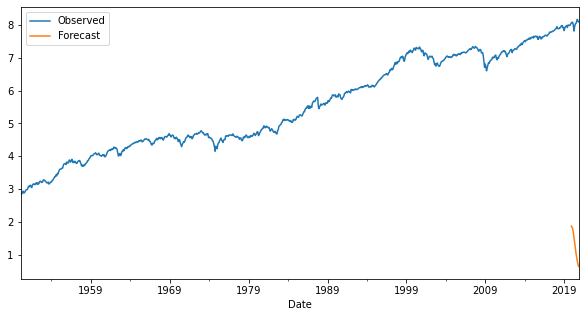

In [123]:
model = run_training_pipeline(lstm_data,
                      seq_length=24, batch_size=16, input_size=2, prediction_len=1,
                      hidden_layer_sizes=[100, 50], dropout_probs=[0.2, 0.2],                      
                      learning_rate=1e-4,max_epochs=500,name="bs16_2years")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type       | Params
----------------------------------------------
0 | lstm_layers    | ModuleList | 122 K 
1 | dropout_layers | ModuleList | 0     
2 | linear         | Linear     | 101   
----------------------------------------------
122 K     Trainable params
0         Non-trainable params
122 K     Total params
0.490     Total estimated model params size (MB)


Sanity Checking: |                                                                           | 0/? [00:00<?, ?…

Training: |                                                                                  | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved. New best score: 51.429


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 32.348 >= min_delta = 0.0. New best score: 19.080


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 9.755 >= min_delta = 0.0. New best score: 9.325


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 2.507 >= min_delta = 0.0. New best score: 6.819


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.334 >= min_delta = 0.0. New best score: 6.485


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.155 >= min_delta = 0.0. New best score: 6.330


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.653 >= min_delta = 0.0. New best score: 5.677


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.110 >= min_delta = 0.0. New best score: 4.566


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.317 >= min_delta = 0.0. New best score: 3.249


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.837 >= min_delta = 0.0. New best score: 2.412


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.543 >= min_delta = 0.0. New best score: 1.869


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.391 >= min_delta = 0.0. New best score: 1.479


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.235 >= min_delta = 0.0. New best score: 1.243


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.206 >= min_delta = 0.0. New best score: 1.038


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.163 >= min_delta = 0.0. New best score: 0.874


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.088 >= min_delta = 0.0. New best score: 0.786


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.071 >= min_delta = 0.0. New best score: 0.715


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.079 >= min_delta = 0.0. New best score: 0.636


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.034 >= min_delta = 0.0. New best score: 0.601


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.050 >= min_delta = 0.0. New best score: 0.551


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.064 >= min_delta = 0.0. New best score: 0.487


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.476


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.463


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.450


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.030 >= min_delta = 0.0. New best score: 0.420


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 0.396


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 0.373


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.358


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.354


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.343


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.031 >= min_delta = 0.0. New best score: 0.311


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 0.294


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.032 >= min_delta = 0.0. New best score: 0.262


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.251


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.245


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 0.225


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.030 >= min_delta = 0.0. New best score: 0.195


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.180


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.175


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.169


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.166


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.163


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.154


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 0.137


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.135


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.135. Signaling Trainer to stop.


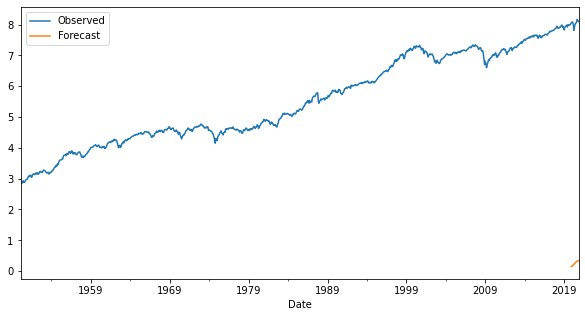

In [124]:
model = run_training_pipeline(lstm_data,
                      seq_length=12, batch_size=16, input_size=2, prediction_len=1,
                      hidden_layer_sizes=[100, 100], dropout_probs=[0.2, 0.2],                      
                      learning_rate=1e-4,max_epochs=500,name="bs16_100_100")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type       | Params
----------------------------------------------
0 | lstm_layers    | ModuleList | 284 K 
1 | dropout_layers | ModuleList | 0     
2 | linear         | Linear     | 101   
----------------------------------------------
284 K     Trainable params
0         Non-trainable params
284 K     Total params
1.136     Total estimated model params size (MB)


Sanity Checking: |                                                                           | 0/? [00:00<?, ?…

Training: |                                                                                  | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved. New best score: 33.051


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 21.856 >= min_delta = 0.0. New best score: 11.195


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 3.825 >= min_delta = 0.0. New best score: 7.370


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.781 >= min_delta = 0.0. New best score: 6.588


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.286 >= min_delta = 0.0. New best score: 6.303


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.277 >= min_delta = 0.0. New best score: 6.026


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.455 >= min_delta = 0.0. New best score: 5.571


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.146 >= min_delta = 0.0. New best score: 4.425


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.191 >= min_delta = 0.0. New best score: 3.234


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.805 >= min_delta = 0.0. New best score: 2.428


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.540 >= min_delta = 0.0. New best score: 1.889


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.408 >= min_delta = 0.0. New best score: 1.481


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.250 >= min_delta = 0.0. New best score: 1.231


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.174 >= min_delta = 0.0. New best score: 1.058


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.132 >= min_delta = 0.0. New best score: 0.925


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.090 >= min_delta = 0.0. New best score: 0.835


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.080 >= min_delta = 0.0. New best score: 0.754


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.060 >= min_delta = 0.0. New best score: 0.694


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.073 >= min_delta = 0.0. New best score: 0.621


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.619


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 0.596


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.584


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 0.566


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.029 >= min_delta = 0.0. New best score: 0.537


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.534


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.045 >= min_delta = 0.0. New best score: 0.489


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.034 >= min_delta = 0.0. New best score: 0.456


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.456


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.027 >= min_delta = 0.0. New best score: 0.429


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.420


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.413


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.035 >= min_delta = 0.0. New best score: 0.378


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 0.355


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.346


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.346


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 0.323


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 0.304


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.295


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.039 >= min_delta = 0.0. New best score: 0.255


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.251


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.034 >= min_delta = 0.0. New best score: 0.217


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.204


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.191


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.182


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.168


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 0.149


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.029 >= min_delta = 0.0. New best score: 0.120


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.105


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.098


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.098. Signaling Trainer to stop.


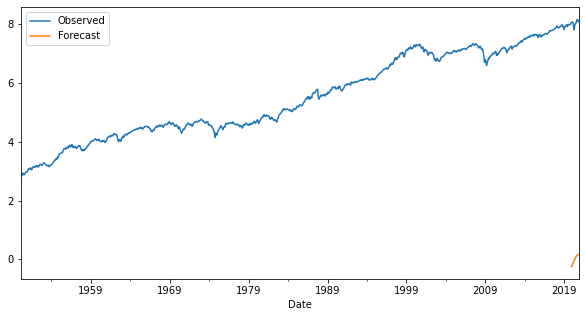

In [125]:
model = run_training_pipeline(lstm_data,
                      seq_length=12, batch_size=16, input_size=2, prediction_len=1,
                      hidden_layer_sizes=[200, 100], dropout_probs=[0.2, 0.2],                      
                      learning_rate=1e-4,max_epochs=500,name="bs16_200_100")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type       | Params
----------------------------------------------
0 | lstm_layers    | ModuleList | 72.0 K
1 | dropout_layers | ModuleList | 0     
2 | linear         | Linear     | 51    
----------------------------------------------
72.1 K    Trainable params
0         Non-trainable params
72.1 K    Total params
0.288     Total estimated model params size (MB)


Sanity Checking: |                                                                           | 0/? [00:00<?, ?…

Training: |                                                                                  | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved. New best score: 35.783


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 18.462 >= min_delta = 0.0. New best score: 17.321


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 5.648 >= min_delta = 0.0. New best score: 11.672


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 2.219 >= min_delta = 0.0. New best score: 9.453


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.271 >= min_delta = 0.0. New best score: 8.183


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.787 >= min_delta = 0.0. New best score: 7.396


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.396 >= min_delta = 0.0. New best score: 6.999


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.250 >= min_delta = 0.0. New best score: 6.750


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.694 >= min_delta = 0.0. New best score: 6.056


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.376 >= min_delta = 0.0. New best score: 4.680


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.007 >= min_delta = 0.0. New best score: 3.673


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.744 >= min_delta = 0.0. New best score: 2.930


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.526 >= min_delta = 0.0. New best score: 2.404


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.407 >= min_delta = 0.0. New best score: 1.997


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.289 >= min_delta = 0.0. New best score: 1.708


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.279 >= min_delta = 0.0. New best score: 1.429


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.177 >= min_delta = 0.0. New best score: 1.253


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.137 >= min_delta = 0.0. New best score: 1.116


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.109 >= min_delta = 0.0. New best score: 1.006


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.053 >= min_delta = 0.0. New best score: 0.954


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.072 >= min_delta = 0.0. New best score: 0.882


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.049 >= min_delta = 0.0. New best score: 0.833


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.060 >= min_delta = 0.0. New best score: 0.773


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.079 >= min_delta = 0.0. New best score: 0.694


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.686


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.052 >= min_delta = 0.0. New best score: 0.634


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 0.611


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.599


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.072 >= min_delta = 0.0. New best score: 0.527


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.026 >= min_delta = 0.0. New best score: 0.501


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 0.482


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 0.466


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.458


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.066 >= min_delta = 0.0. New best score: 0.392


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.027 >= min_delta = 0.0. New best score: 0.365


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.025 >= min_delta = 0.0. New best score: 0.340


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.052 >= min_delta = 0.0. New best score: 0.288


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.277


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.029 >= min_delta = 0.0. New best score: 0.249


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.242


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.031 >= min_delta = 0.0. New best score: 0.211


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.029 >= min_delta = 0.0. New best score: 0.182


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.181


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.027 >= min_delta = 0.0. New best score: 0.155


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.155. Signaling Trainer to stop.


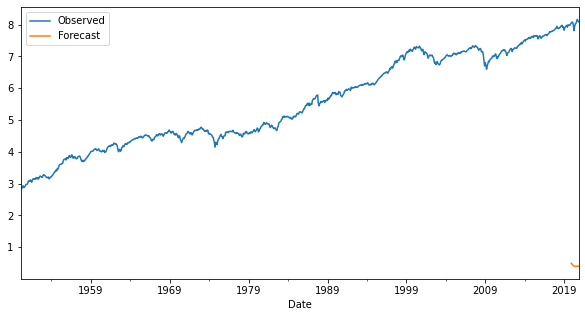

In [126]:
model = run_training_pipeline(lstm_data,
                      seq_length=12, batch_size=8, input_size=2, prediction_len=1,
                      hidden_layer_sizes=[100, 50], dropout_probs=[0.2, 0.2],                      
                      learning_rate=1e-4,max_epochs=500,name="bs8")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type       | Params
----------------------------------------------
0 | lstm_layers    | ModuleList | 72.0 K
1 | dropout_layers | ModuleList | 0     
2 | linear         | Linear     | 51    
----------------------------------------------
72.1 K    Trainable params
0         Non-trainable params
72.1 K    Total params
0.288     Total estimated model params size (MB)


Sanity Checking: |                                                                           | 0/? [00:00<?, ?…

Training: |                                                                                  | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved. New best score: 53.426


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 23.956 >= min_delta = 0.0. New best score: 29.470


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 10.468 >= min_delta = 0.0. New best score: 19.002


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 4.053 >= min_delta = 0.0. New best score: 14.949


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 2.121 >= min_delta = 0.0. New best score: 12.828


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.571 >= min_delta = 0.0. New best score: 11.256


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.134 >= min_delta = 0.0. New best score: 10.122


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.859 >= min_delta = 0.0. New best score: 9.263


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.671 >= min_delta = 0.0. New best score: 8.591


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.505 >= min_delta = 0.0. New best score: 8.086


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.395 >= min_delta = 0.0. New best score: 7.691


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.307 >= min_delta = 0.0. New best score: 7.384


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.243 >= min_delta = 0.0. New best score: 7.141


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.190 >= min_delta = 0.0. New best score: 6.951


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.311 >= min_delta = 0.0. New best score: 6.640


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.431 >= min_delta = 0.0. New best score: 6.209


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.679 >= min_delta = 0.0. New best score: 5.530


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.683 >= min_delta = 0.0. New best score: 4.847


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.645 >= min_delta = 0.0. New best score: 4.202


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.476 >= min_delta = 0.0. New best score: 3.726


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.440 >= min_delta = 0.0. New best score: 3.285


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.357 >= min_delta = 0.0. New best score: 2.929


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.314 >= min_delta = 0.0. New best score: 2.615


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.284 >= min_delta = 0.0. New best score: 2.331


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.231 >= min_delta = 0.0. New best score: 2.100


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.194 >= min_delta = 0.0. New best score: 1.907


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.184 >= min_delta = 0.0. New best score: 1.723


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.151 >= min_delta = 0.0. New best score: 1.572


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.145 >= min_delta = 0.0. New best score: 1.426


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.125 >= min_delta = 0.0. New best score: 1.302


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.097 >= min_delta = 0.0. New best score: 1.205


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.080 >= min_delta = 0.0. New best score: 1.125


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.071 >= min_delta = 0.0. New best score: 1.054


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.053 >= min_delta = 0.0. New best score: 1.001


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.064 >= min_delta = 0.0. New best score: 0.937


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.067 >= min_delta = 0.0. New best score: 0.870


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.032 >= min_delta = 0.0. New best score: 0.838


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.031 >= min_delta = 0.0. New best score: 0.807


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.052 >= min_delta = 0.0. New best score: 0.755


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.028 >= min_delta = 0.0. New best score: 0.727


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.716


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 0.692


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.686


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 0.664


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.038 >= min_delta = 0.0. New best score: 0.626


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.614


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.051 >= min_delta = 0.0. New best score: 0.562


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 0.539


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.038 >= min_delta = 0.0. New best score: 0.501


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.491


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.479


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.030 >= min_delta = 0.0. New best score: 0.449


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.025 >= min_delta = 0.0. New best score: 0.424


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.420


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.405


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.402


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.393


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 0.375


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.046 >= min_delta = 0.0. New best score: 0.329


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.322


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.025 >= min_delta = 0.0. New best score: 0.297


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.284


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.270


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.265


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.264


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.256


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.248


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 0.231


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.219


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.218


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.216


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.035 >= min_delta = 0.0. New best score: 0.181


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.180


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.176


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.166


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.155


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.154


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.149


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.140


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.134


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.128


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.126


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.126. Signaling Trainer to stop.


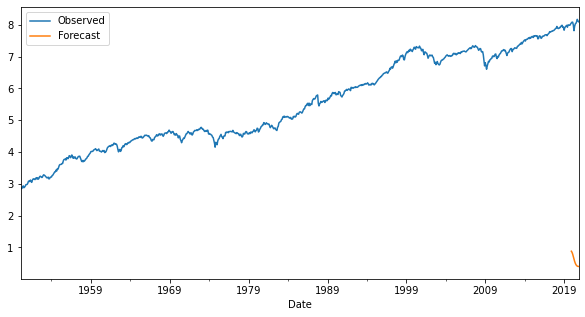

In [127]:
model = run_training_pipeline(lstm_data,
                      seq_length=12, batch_size=8, input_size=2, prediction_len=1,
                      hidden_layer_sizes=[100, 50], dropout_probs=[0.2, 0.2],                      
                      learning_rate=5e-5,max_epochs=500,name="bs8_5e-5")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type       | Params
----------------------------------------------
0 | lstm_layers    | ModuleList | 284 K 
1 | dropout_layers | ModuleList | 0     
2 | linear         | Linear     | 101   
----------------------------------------------
284 K     Trainable params
0         Non-trainable params
284 K     Total params
1.136     Total estimated model params size (MB)


Sanity Checking: |                                                                           | 0/? [00:00<?, ?…

Training: |                                                                                  | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved. New best score: 28.545


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 18.736 >= min_delta = 0.0. New best score: 9.809


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 2.456 >= min_delta = 0.0. New best score: 7.353


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.703 >= min_delta = 0.0. New best score: 6.650


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.361 >= min_delta = 0.0. New best score: 6.289


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.539 >= min_delta = 0.0. New best score: 4.750


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.432 >= min_delta = 0.0. New best score: 3.318


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.873 >= min_delta = 0.0. New best score: 2.445


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.526 >= min_delta = 0.0. New best score: 1.919


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.379 >= min_delta = 0.0. New best score: 1.540


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.251 >= min_delta = 0.0. New best score: 1.289


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.211 >= min_delta = 0.0. New best score: 1.078


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.155 >= min_delta = 0.0. New best score: 0.923


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.111 >= min_delta = 0.0. New best score: 0.813


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.084 >= min_delta = 0.0. New best score: 0.729


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.069 >= min_delta = 0.0. New best score: 0.660


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.051 >= min_delta = 0.0. New best score: 0.609


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.040 >= min_delta = 0.0. New best score: 0.569


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.044 >= min_delta = 0.0. New best score: 0.525


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.055 >= min_delta = 0.0. New best score: 0.470


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 0.450


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.443


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.061 >= min_delta = 0.0. New best score: 0.381


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 0.360


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.346


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.029 >= min_delta = 0.0. New best score: 0.317


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.315


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 0.294


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 0.270


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 0.249


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.234


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.062 >= min_delta = 0.0. New best score: 0.172


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.172. Signaling Trainer to stop.


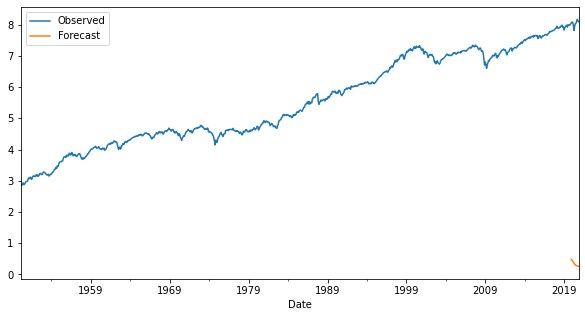

In [142]:
model = run_training_pipeline(lstm_data,
                      seq_length=12, batch_size=8, input_size=2, prediction_len=1,
                      hidden_layer_sizes=[200, 100], dropout_probs=[0.2, 0.2],                      
                      learning_rate=5e-5,max_epochs=500,name="bs8_5e-5_200_100")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type       | Params
----------------------------------------------
0 | lstm_layers    | ModuleList | 364 K 
1 | dropout_layers | ModuleList | 0     
2 | linear         | Linear     | 101   
----------------------------------------------
364 K     Trainable params
0         Non-trainable params
364 K     Total params
1.460     Total estimated model params size (MB)


Sanity Checking: |                                                                           | 0/? [00:00<?, ?…

Training: |                                                                                  | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved. New best score: 34.521


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 23.519 >= min_delta = 0.0. New best score: 11.003


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 3.414 >= min_delta = 0.0. New best score: 7.589


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.850 >= min_delta = 0.0. New best score: 6.739


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.290 >= min_delta = 0.0. New best score: 6.449


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.251 >= min_delta = 0.0. New best score: 6.198


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.722 >= min_delta = 0.0. New best score: 5.476


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.832 >= min_delta = 0.0. New best score: 3.644


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.003 >= min_delta = 0.0. New best score: 2.641


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.658 >= min_delta = 0.0. New best score: 1.983


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.417 >= min_delta = 0.0. New best score: 1.566


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.315 >= min_delta = 0.0. New best score: 1.251


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.191 >= min_delta = 0.0. New best score: 1.060


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.164 >= min_delta = 0.0. New best score: 0.896


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.086 >= min_delta = 0.0. New best score: 0.810


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.105 >= min_delta = 0.0. New best score: 0.705


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.048 >= min_delta = 0.0. New best score: 0.657


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.040 >= min_delta = 0.0. New best score: 0.616


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.044 >= min_delta = 0.0. New best score: 0.572


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.034 >= min_delta = 0.0. New best score: 0.539


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.536


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.044 >= min_delta = 0.0. New best score: 0.491


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 0.467


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 0.448


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 0.432


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.025 >= min_delta = 0.0. New best score: 0.406


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 0.391


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 0.374


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 0.356


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.031 >= min_delta = 0.0. New best score: 0.325


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 0.309


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.300


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.043 >= min_delta = 0.0. New best score: 0.257


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 0.242


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.237


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.237


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.225


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.211


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.027 >= min_delta = 0.0. New best score: 0.185


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.184


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.169


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 0.151


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.136


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.135


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.131


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.125


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.119


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.116


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.101


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.101


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.101. Signaling Trainer to stop.


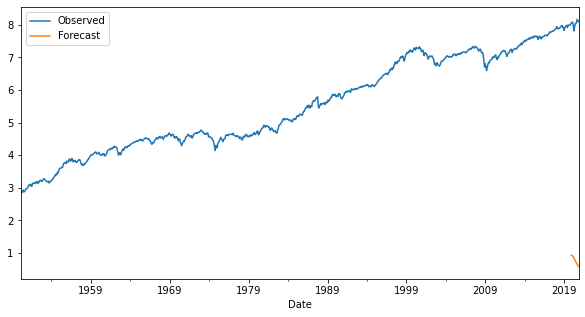

In [161]:
model = run_training_pipeline(lstm_data,
                      seq_length=12, batch_size=8, input_size=2, prediction_len=1,
                      hidden_layer_sizes=[200, 100, 100], dropout_probs=[0.2, 0.2,0.2],                      
                      learning_rate=5e-5,max_epochs=500,name="bs8_5e-5_200_100_100")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type       | Params
----------------------------------------------
0 | lstm_layers    | ModuleList | 72.0 K
1 | dropout_layers | ModuleList | 0     
2 | linear         | Linear     | 51    
----------------------------------------------
72.1 K    Trainable params
0         Non-trainable params
72.1 K    Total params
0.288     Total estimated model params size (MB)


Sanity Checking: |                                                                           | 0/? [00:00<?, ?…

Training: |                                                                                  | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved. New best score: 61.687


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.934 >= min_delta = 0.0. New best score: 59.753


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 2.533 >= min_delta = 0.0. New best score: 57.219


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 3.705 >= min_delta = 0.0. New best score: 53.515


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 5.552 >= min_delta = 0.0. New best score: 47.962


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 6.906 >= min_delta = 0.0. New best score: 41.056


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 6.116 >= min_delta = 0.0. New best score: 34.941


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 4.707 >= min_delta = 0.0. New best score: 30.234


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 3.760 >= min_delta = 0.0. New best score: 26.474


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 3.025 >= min_delta = 0.0. New best score: 23.449


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 2.239 >= min_delta = 0.0. New best score: 21.210


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.630 >= min_delta = 0.0. New best score: 19.581


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.311 >= min_delta = 0.0. New best score: 18.269


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.034 >= min_delta = 0.0. New best score: 17.236


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.912 >= min_delta = 0.0. New best score: 16.324


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.832 >= min_delta = 0.0. New best score: 15.492


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.773 >= min_delta = 0.0. New best score: 14.719


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.715 >= min_delta = 0.0. New best score: 14.004


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.649 >= min_delta = 0.0. New best score: 13.354


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.544 >= min_delta = 0.0. New best score: 12.810


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.469 >= min_delta = 0.0. New best score: 12.342


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.460 >= min_delta = 0.0. New best score: 11.882


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.398 >= min_delta = 0.0. New best score: 11.483


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.340 >= min_delta = 0.0. New best score: 11.143


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.341 >= min_delta = 0.0. New best score: 10.802


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.304 >= min_delta = 0.0. New best score: 10.498


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.289 >= min_delta = 0.0. New best score: 10.209


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.207 >= min_delta = 0.0. New best score: 10.001


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.245 >= min_delta = 0.0. New best score: 9.756


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.187 >= min_delta = 0.0. New best score: 9.569


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.191 >= min_delta = 0.0. New best score: 9.379


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.185 >= min_delta = 0.0. New best score: 9.193


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.166 >= min_delta = 0.0. New best score: 9.027


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.189 >= min_delta = 0.0. New best score: 8.839


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.167 >= min_delta = 0.0. New best score: 8.672


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.163 >= min_delta = 0.0. New best score: 8.509


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.100 >= min_delta = 0.0. New best score: 8.408


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.113 >= min_delta = 0.0. New best score: 8.295


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.096 >= min_delta = 0.0. New best score: 8.200


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.121 >= min_delta = 0.0. New best score: 8.079


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.138 >= min_delta = 0.0. New best score: 7.940


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.095 >= min_delta = 0.0. New best score: 7.845


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.124 >= min_delta = 0.0. New best score: 7.721


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.113 >= min_delta = 0.0. New best score: 7.608


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.086 >= min_delta = 0.0. New best score: 7.522


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.071 >= min_delta = 0.0. New best score: 7.451


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.079 >= min_delta = 0.0. New best score: 7.372


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.082 >= min_delta = 0.0. New best score: 7.290


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.072 >= min_delta = 0.0. New best score: 7.218


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.047 >= min_delta = 0.0. New best score: 7.171


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.034 >= min_delta = 0.0. New best score: 7.137


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.035 >= min_delta = 0.0. New best score: 7.102


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 7.080


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.037 >= min_delta = 0.0. New best score: 7.043


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.058 >= min_delta = 0.0. New best score: 6.985


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.133 >= min_delta = 0.0. New best score: 6.852


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.115 >= min_delta = 0.0. New best score: 6.737


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.131 >= min_delta = 0.0. New best score: 6.605


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.107 >= min_delta = 0.0. New best score: 6.498


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.094 >= min_delta = 0.0. New best score: 6.404


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.115 >= min_delta = 0.0. New best score: 6.290


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.089 >= min_delta = 0.0. New best score: 6.200


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.113 >= min_delta = 0.0. New best score: 6.087


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.116 >= min_delta = 0.0. New best score: 5.971


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.116 >= min_delta = 0.0. New best score: 5.855


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.169 >= min_delta = 0.0. New best score: 5.686


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.211 >= min_delta = 0.0. New best score: 5.475


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.219 >= min_delta = 0.0. New best score: 5.257


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.213 >= min_delta = 0.0. New best score: 5.043


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.210 >= min_delta = 0.0. New best score: 4.834


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.167 >= min_delta = 0.0. New best score: 4.666


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.155 >= min_delta = 0.0. New best score: 4.511


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.158 >= min_delta = 0.0. New best score: 4.353


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.147 >= min_delta = 0.0. New best score: 4.206


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.134 >= min_delta = 0.0. New best score: 4.072


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.136 >= min_delta = 0.0. New best score: 3.935


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.134 >= min_delta = 0.0. New best score: 3.802


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.123 >= min_delta = 0.0. New best score: 3.679


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.122 >= min_delta = 0.0. New best score: 3.557


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.115 >= min_delta = 0.0. New best score: 3.442


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.120 >= min_delta = 0.0. New best score: 3.322


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.115 >= min_delta = 0.0. New best score: 3.207


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.109 >= min_delta = 0.0. New best score: 3.098


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.110 >= min_delta = 0.0. New best score: 2.989


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.096 >= min_delta = 0.0. New best score: 2.893


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.081 >= min_delta = 0.0. New best score: 2.812


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.081 >= min_delta = 0.0. New best score: 2.731


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.090 >= min_delta = 0.0. New best score: 2.641


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.079 >= min_delta = 0.0. New best score: 2.562


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.071 >= min_delta = 0.0. New best score: 2.491


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.074 >= min_delta = 0.0. New best score: 2.417


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.065 >= min_delta = 0.0. New best score: 2.351


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.067 >= min_delta = 0.0. New best score: 2.284


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.056 >= min_delta = 0.0. New best score: 2.229


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.067 >= min_delta = 0.0. New best score: 2.162


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.047 >= min_delta = 0.0. New best score: 2.115


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.060 >= min_delta = 0.0. New best score: 2.055


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.054 >= min_delta = 0.0. New best score: 2.001


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.061 >= min_delta = 0.0. New best score: 1.940


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.055 >= min_delta = 0.0. New best score: 1.885


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.055 >= min_delta = 0.0. New best score: 1.830


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.058 >= min_delta = 0.0. New best score: 1.772


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.041 >= min_delta = 0.0. New best score: 1.730


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.044 >= min_delta = 0.0. New best score: 1.686


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.040 >= min_delta = 0.0. New best score: 1.646


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.041 >= min_delta = 0.0. New best score: 1.605


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.045 >= min_delta = 0.0. New best score: 1.560


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.037 >= min_delta = 0.0. New best score: 1.524


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.031 >= min_delta = 0.0. New best score: 1.492


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.037 >= min_delta = 0.0. New best score: 1.456


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.028 >= min_delta = 0.0. New best score: 1.428


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.028 >= min_delta = 0.0. New best score: 1.400


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.034 >= min_delta = 0.0. New best score: 1.365


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.037 >= min_delta = 0.0. New best score: 1.329


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.026 >= min_delta = 0.0. New best score: 1.303


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.028 >= min_delta = 0.0. New best score: 1.275


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.029 >= min_delta = 0.0. New best score: 1.246


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.031 >= min_delta = 0.0. New best score: 1.215


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 1.191


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.040 >= min_delta = 0.0. New best score: 1.151


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.037 >= min_delta = 0.0. New best score: 1.114


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.054 >= min_delta = 0.0. New best score: 1.061


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.036 >= min_delta = 0.0. New best score: 1.024


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.038 >= min_delta = 0.0. New best score: 0.986


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.026 >= min_delta = 0.0. New best score: 0.960


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.031 >= min_delta = 0.0. New best score: 0.929


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.923


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 0.904


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 0.884


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 0.867


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.863


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 0.844


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.832


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.830


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.815


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.804


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.789


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.774


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.758


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.756


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 0.736


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.730


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.723


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.720


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.715


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.708


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.702


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.690


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.683


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.678


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.670


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.665


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.655


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.651


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 0.635


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.633


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.628


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.620


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.620


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.611


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.599


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.593


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.586


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.583


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.570


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.569


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 0.553


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 0.533


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.531


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.529


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.527


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.513


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.500


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.488


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.486


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.482


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.473


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.460


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.456


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.454


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.446


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.439


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.437


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.425


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 0.410


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.403


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.393


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.393. Signaling Trainer to stop.


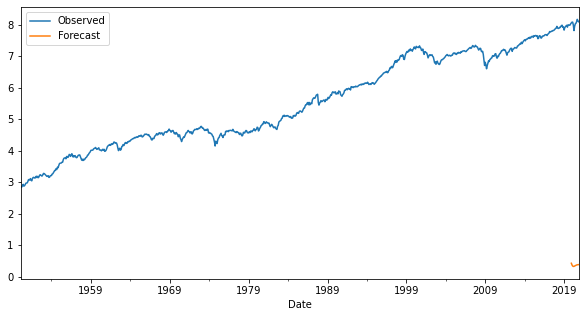

In [128]:
model = run_training_pipeline(lstm_data,
                      seq_length=12, batch_size=32, input_size=2, prediction_len=1,
                      hidden_layer_sizes=[100, 50], dropout_probs=[0.2, 0.2],                      
                      learning_rate=5e-5,max_epochs=500,name="bs32_5e-5")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type       | Params
----------------------------------------------
0 | lstm_layers    | ModuleList | 314 K 
1 | dropout_layers | ModuleList | 0     
2 | linear         | Linear     | 51    
----------------------------------------------
314 K     Trainable params
0         Non-trainable params
314 K     Total params
1.258     Total estimated model params size (MB)


Sanity Checking: |                                                                           | 0/? [00:00<?, ?…

Training: |                                                                                  | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved. New best score: 40.364


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 18.484 >= min_delta = 0.0. New best score: 21.881


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 6.414 >= min_delta = 0.0. New best score: 15.467


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 2.922 >= min_delta = 0.0. New best score: 12.545


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.755 >= min_delta = 0.0. New best score: 10.790


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.206 >= min_delta = 0.0. New best score: 9.583


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.832 >= min_delta = 0.0. New best score: 8.751


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.640 >= min_delta = 0.0. New best score: 8.111


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.525 >= min_delta = 0.0. New best score: 7.586


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.361 >= min_delta = 0.0. New best score: 7.225


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.216 >= min_delta = 0.0. New best score: 7.009


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.156 >= min_delta = 0.0. New best score: 6.853


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.116 >= min_delta = 0.0. New best score: 6.737


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.124 >= min_delta = 0.0. New best score: 6.613


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.043 >= min_delta = 0.0. New best score: 6.570


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.033 >= min_delta = 0.0. New best score: 6.538


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.051 >= min_delta = 0.0. New best score: 6.487


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.161 >= min_delta = 0.0. New best score: 6.326


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.132 >= min_delta = 0.0. New best score: 6.193


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.146 >= min_delta = 0.0. New best score: 5.047


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.939 >= min_delta = 0.0. New best score: 4.108


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.625 >= min_delta = 0.0. New best score: 3.483


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.477 >= min_delta = 0.0. New best score: 3.006


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.392 >= min_delta = 0.0. New best score: 2.614


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.352 >= min_delta = 0.0. New best score: 2.262


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.240 >= min_delta = 0.0. New best score: 2.022


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.231 >= min_delta = 0.0. New best score: 1.791


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.187 >= min_delta = 0.0. New best score: 1.605


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.173 >= min_delta = 0.0. New best score: 1.432


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.120 >= min_delta = 0.0. New best score: 1.312


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.116 >= min_delta = 0.0. New best score: 1.196


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.091 >= min_delta = 0.0. New best score: 1.104


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.067 >= min_delta = 0.0. New best score: 1.037


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.067 >= min_delta = 0.0. New best score: 0.970


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.046 >= min_delta = 0.0. New best score: 0.924


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.048 >= min_delta = 0.0. New best score: 0.877


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.036 >= min_delta = 0.0. New best score: 0.841


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.045 >= min_delta = 0.0. New best score: 0.796


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 0.779


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.044 >= min_delta = 0.0. New best score: 0.735


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.034 >= min_delta = 0.0. New best score: 0.701


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.688


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 0.665


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 0.642


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 0.620


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.605


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 0.581


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.569


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.554


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.539


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 0.520


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 0.498


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.025 >= min_delta = 0.0. New best score: 0.473


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.460


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.448


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.435


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.422


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.035 >= min_delta = 0.0. New best score: 0.387


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.384


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.382


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.036 >= min_delta = 0.0. New best score: 0.346


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.343


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.336


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.025 >= min_delta = 0.0. New best score: 0.311


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.297


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.285


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.283


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.269


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.265


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.257


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.256


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.250


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.248


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.247


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.238


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.224


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.214


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.209


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.202


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.199


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.187


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.182


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.172


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.172. Signaling Trainer to stop.


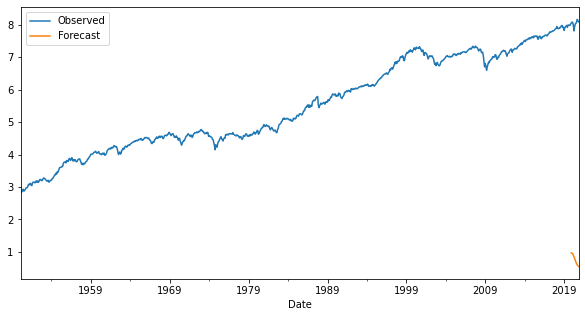

In [129]:
model = run_training_pipeline(lstm_data,
                      seq_length=12, batch_size=16, input_size=2, prediction_len=1,
                      hidden_layer_sizes=[200, 100, 50], dropout_probs=[0.2, 0.2, 0.2],                      
                      learning_rate=1e-4,max_epochs=500,name="bs16_200_100_50")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type       | Params
----------------------------------------------
0 | lstm_layers    | ModuleList | 314 K 
1 | dropout_layers | ModuleList | 0     
2 | linear         | Linear     | 51    
----------------------------------------------
314 K     Trainable params
0         Non-trainable params
314 K     Total params
1.258     Total estimated model params size (MB)


Sanity Checking: |                                                                           | 0/? [00:00<?, ?…

Training: |                                                                                  | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved. New best score: 59.504


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 15.354 >= min_delta = 0.0. New best score: 44.150


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 13.372 >= min_delta = 0.0. New best score: 30.777


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 7.420 >= min_delta = 0.0. New best score: 23.358


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 3.807 >= min_delta = 0.0. New best score: 19.551


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 2.264 >= min_delta = 0.0. New best score: 17.287


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.591 >= min_delta = 0.0. New best score: 15.696


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.304 >= min_delta = 0.0. New best score: 14.392


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.010 >= min_delta = 0.0. New best score: 13.382


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.863 >= min_delta = 0.0. New best score: 12.519


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.777 >= min_delta = 0.0. New best score: 11.741


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.661 >= min_delta = 0.0. New best score: 11.080


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.554 >= min_delta = 0.0. New best score: 10.526


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.523 >= min_delta = 0.0. New best score: 10.003


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.417 >= min_delta = 0.0. New best score: 9.586


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.437 >= min_delta = 0.0. New best score: 9.149


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.357 >= min_delta = 0.0. New best score: 8.792


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.279 >= min_delta = 0.0. New best score: 8.513


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.278 >= min_delta = 0.0. New best score: 8.235


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.234 >= min_delta = 0.0. New best score: 8.001


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.255 >= min_delta = 0.0. New best score: 7.746


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.189 >= min_delta = 0.0. New best score: 7.557


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.133 >= min_delta = 0.0. New best score: 7.425


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.138 >= min_delta = 0.0. New best score: 7.286


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.106 >= min_delta = 0.0. New best score: 7.180


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.143 >= min_delta = 0.0. New best score: 7.037


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.123 >= min_delta = 0.0. New best score: 6.914


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.094 >= min_delta = 0.0. New best score: 6.820


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.072 >= min_delta = 0.0. New best score: 6.748


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.046 >= min_delta = 0.0. New best score: 6.702


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.035 >= min_delta = 0.0. New best score: 6.667


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 6.657


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.047 >= min_delta = 0.0. New best score: 6.610


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.042 >= min_delta = 0.0. New best score: 6.568


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 6.565


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.045 >= min_delta = 0.0. New best score: 6.520


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.041 >= min_delta = 0.0. New best score: 6.479


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.029 >= min_delta = 0.0. New best score: 6.450


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 6.442


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 6.440


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.029 >= min_delta = 0.0. New best score: 6.411


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.265 >= min_delta = 0.0. New best score: 6.147


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.636 >= min_delta = 0.0. New best score: 5.510


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.558 >= min_delta = 0.0. New best score: 4.952


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.478 >= min_delta = 0.0. New best score: 4.474


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.396 >= min_delta = 0.0. New best score: 4.078


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.326 >= min_delta = 0.0. New best score: 3.752


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.316 >= min_delta = 0.0. New best score: 3.436


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.277 >= min_delta = 0.0. New best score: 3.159


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.257 >= min_delta = 0.0. New best score: 2.902


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.232 >= min_delta = 0.0. New best score: 2.670


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.203 >= min_delta = 0.0. New best score: 2.467


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.194 >= min_delta = 0.0. New best score: 2.273


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.152 >= min_delta = 0.0. New best score: 2.121


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.129 >= min_delta = 0.0. New best score: 1.992


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.118 >= min_delta = 0.0. New best score: 1.874


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.126 >= min_delta = 0.0. New best score: 1.748


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.097 >= min_delta = 0.0. New best score: 1.651


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.089 >= min_delta = 0.0. New best score: 1.562


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.079 >= min_delta = 0.0. New best score: 1.482


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.076 >= min_delta = 0.0. New best score: 1.406


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.067 >= min_delta = 0.0. New best score: 1.339


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.060 >= min_delta = 0.0. New best score: 1.278


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.048 >= min_delta = 0.0. New best score: 1.230


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.056 >= min_delta = 0.0. New best score: 1.175


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.043 >= min_delta = 0.0. New best score: 1.132


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.056 >= min_delta = 0.0. New best score: 1.076


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.046 >= min_delta = 0.0. New best score: 1.030


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.030 >= min_delta = 0.0. New best score: 1.000


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.040 >= min_delta = 0.0. New best score: 0.960


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 0.941


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.041 >= min_delta = 0.0. New best score: 0.900


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.033 >= min_delta = 0.0. New best score: 0.867


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 0.843


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.032 >= min_delta = 0.0. New best score: 0.811


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 0.791


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.028 >= min_delta = 0.0. New best score: 0.764


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.751


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.744


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.025 >= min_delta = 0.0. New best score: 0.719


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 0.696


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.681


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 0.664


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.651


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 0.631


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 0.615


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.600


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.598


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.583


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.576


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 0.556


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.551


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.543


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.532


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 0.516


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.504


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.498


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.496


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.483


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.478


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.466


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.454


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.444


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.430


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.430


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.029 >= min_delta = 0.0. New best score: 0.401


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.396


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.392


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 0.377


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.365


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.357


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.035 >= min_delta = 0.0. New best score: 0.322


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.308


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.307


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.307


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.300


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.292


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.285


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 0.263


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.258


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.255


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.253


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.244


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.230


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.228


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.219


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.207


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.201


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.200


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.190


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.188


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.178


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.175


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.172


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.172. Signaling Trainer to stop.


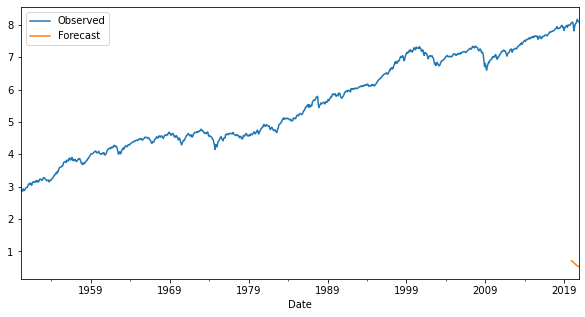

In [130]:
model = run_training_pipeline(lstm_data,
                      seq_length=12, batch_size=16, input_size=2, prediction_len=1,
                      hidden_layer_sizes=[200, 100, 50], dropout_probs=[0.2, 0.2, 0.2],                      
                      learning_rate=5e-5,max_epochs=500,name="bs16_200_100_50_5e5")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type       | Params
----------------------------------------------
0 | lstm_layers    | ModuleList | 163 K 
1 | dropout_layers | ModuleList | 0     
2 | linear         | Linear     | 201   
----------------------------------------------
163 K     Trainable params
0         Non-trainable params
163 K     Total params
0.654     Total estimated model params size (MB)


Sanity Checking: |                                                                           | 0/? [00:00<?, ?…

Training: |                                                                                  | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved. New best score: 39.881


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 32.576 >= min_delta = 0.0. New best score: 7.305


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.395 >= min_delta = 0.0. New best score: 5.910


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.188 >= min_delta = 0.0. New best score: 5.722


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.874 >= min_delta = 0.0. New best score: 3.848


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 2.495 >= min_delta = 0.0. New best score: 1.353


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.681 >= min_delta = 0.0. New best score: 0.672


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.202 >= min_delta = 0.0. New best score: 0.470


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.101 >= min_delta = 0.0. New best score: 0.369


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.046 >= min_delta = 0.0. New best score: 0.324


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.039 >= min_delta = 0.0. New best score: 0.285


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.050 >= min_delta = 0.0. New best score: 0.234


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.058 >= min_delta = 0.0. New best score: 0.176


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.162


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.154


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.147


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 0.131


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.041 >= min_delta = 0.0. New best score: 0.090


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.090. Signaling Trainer to stop.


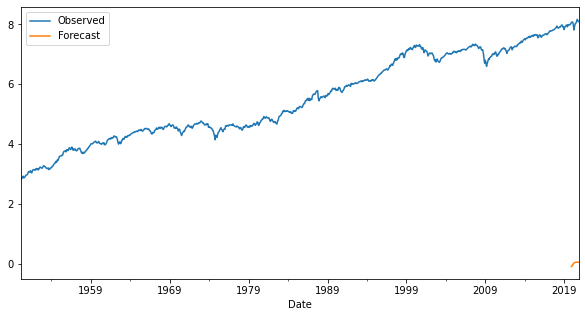

In [131]:
model = run_training_pipeline(lstm_data,
                      seq_length=12, batch_size=16, input_size=2, prediction_len=1,
                      hidden_layer_sizes=[200], dropout_probs=[0.2],                      
                      learning_rate=1e-4,max_epochs=500,name="bs16_200")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type       | Params
----------------------------------------------
0 | lstm_layers    | ModuleList | 163 K 
1 | dropout_layers | ModuleList | 0     
2 | linear         | Linear     | 201   
----------------------------------------------
163 K     Trainable params
0         Non-trainable params
163 K     Total params
0.654     Total estimated model params size (MB)


Sanity Checking: |                                                                           | 0/? [00:00<?, ?…

Training: |                                                                                  | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved. New best score: 40.562


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 33.087 >= min_delta = 0.0. New best score: 7.475


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.225 >= min_delta = 0.0. New best score: 6.250


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.642 >= min_delta = 0.0. New best score: 5.608


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 2.798 >= min_delta = 0.0. New best score: 2.811


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.974 >= min_delta = 0.0. New best score: 0.836


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.357 >= min_delta = 0.0. New best score: 0.479


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.124 >= min_delta = 0.0. New best score: 0.355


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.087 >= min_delta = 0.0. New best score: 0.269


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.261


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.029 >= min_delta = 0.0. New best score: 0.232


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.075 >= min_delta = 0.0. New best score: 0.157


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.032 >= min_delta = 0.0. New best score: 0.125


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.117


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.104


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.089


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.084


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.078


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.066


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.066. Signaling Trainer to stop.


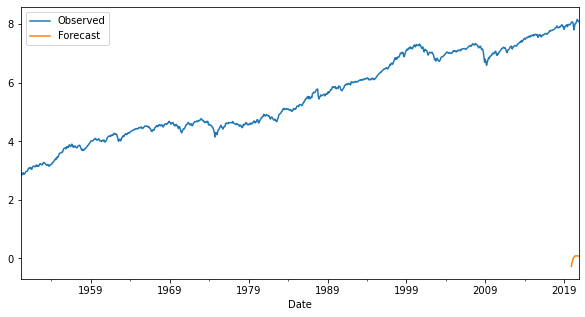

In [160]:
model = run_training_pipeline(lstm_data,
                      seq_length=12, batch_size=16, input_size=2, prediction_len=1,
                      hidden_layer_sizes=[200], dropout_probs=[0.1],                      
                      learning_rate=1e-4,max_epochs=500,name="bs16_200_do01")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type       | Params
----------------------------------------------
0 | lstm_layers    | ModuleList | 163 K 
1 | dropout_layers | ModuleList | 0     
2 | linear         | Linear     | 201   
----------------------------------------------
163 K     Trainable params
0         Non-trainable params
163 K     Total params
0.654     Total estimated model params size (MB)


Sanity Checking: |                                                                           | 0/? [00:00<?, ?…

Training: |                                                                                  | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved. New best score: 42.765


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 30.935 >= min_delta = 0.0. New best score: 11.830


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 5.598 >= min_delta = 0.0. New best score: 6.233


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 6.226


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.947 >= min_delta = 0.0. New best score: 5.279


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.469 >= min_delta = 0.0. New best score: 3.810


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 2.133 >= min_delta = 0.0. New best score: 1.677


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.716 >= min_delta = 0.0. New best score: 0.961


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.238 >= min_delta = 0.0. New best score: 0.722


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.118 >= min_delta = 0.0. New best score: 0.604


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.171 >= min_delta = 0.0. New best score: 0.434


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.038 >= min_delta = 0.0. New best score: 0.396


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.026 >= min_delta = 0.0. New best score: 0.370


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.091 >= min_delta = 0.0. New best score: 0.279


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.046 >= min_delta = 0.0. New best score: 0.234


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.227


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.038 >= min_delta = 0.0. New best score: 0.189


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.187


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.180


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.180


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.170


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.158


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.158. Signaling Trainer to stop.


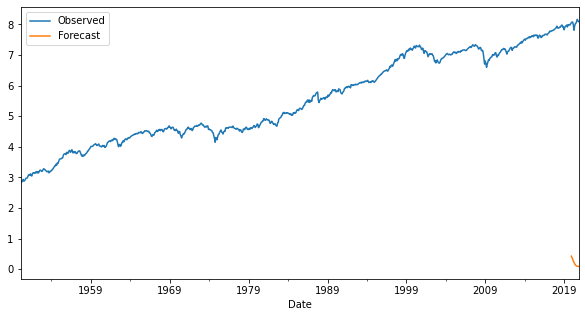

In [146]:
model = run_training_pipeline(lstm_data,
                      seq_length=12, batch_size=16, input_size=2, prediction_len=1,
                      hidden_layer_sizes=[200], dropout_probs=[0.3],                      
                      learning_rate=1e-4,max_epochs=500,name="bs16_200_do03")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type       | Params
----------------------------------------------
0 | lstm_layers    | ModuleList | 163 K 
1 | dropout_layers | ModuleList | 0     
2 | linear         | Linear     | 201   
----------------------------------------------
163 K     Trainable params
0         Non-trainable params
163 K     Total params
0.654     Total estimated model params size (MB)


Sanity Checking: |                                                                           | 0/? [00:00<?, ?…

Training: |                                                                                  | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved. New best score: 40.883


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 31.127 >= min_delta = 0.0. New best score: 9.757


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 3.490 >= min_delta = 0.0. New best score: 6.267


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.950 >= min_delta = 0.0. New best score: 5.317


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 3.105 >= min_delta = 0.0. New best score: 2.211


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.318 >= min_delta = 0.0. New best score: 0.894


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.218 >= min_delta = 0.0. New best score: 0.675


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.216 >= min_delta = 0.0. New best score: 0.460


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 0.440


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.113 >= min_delta = 0.0. New best score: 0.327


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.325


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.049 >= min_delta = 0.0. New best score: 0.276


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.046 >= min_delta = 0.0. New best score: 0.230


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 0.213


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.049 >= min_delta = 0.0. New best score: 0.164


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.152


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.038 >= min_delta = 0.0. New best score: 0.114


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.100


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.100. Signaling Trainer to stop.


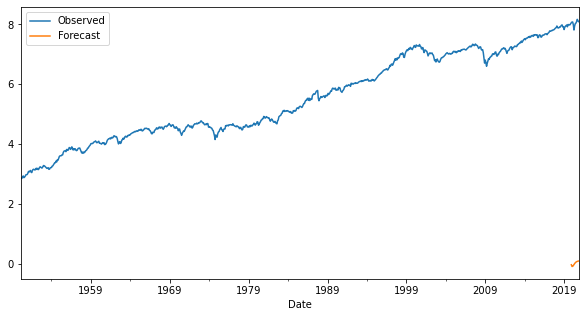

In [147]:
model = run_training_pipeline(lstm_data,
                      seq_length=12, batch_size=16, input_size=2, prediction_len=1,
                      hidden_layer_sizes=[200], dropout_probs=[0.4],                      
                      learning_rate=1e-4,max_epochs=500,name="bs16_200_do04")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type       | Params
----------------------------------------------
0 | lstm_layers    | ModuleList | 163 K 
1 | dropout_layers | ModuleList | 0     
2 | linear         | Linear     | 201   
----------------------------------------------
163 K     Trainable params
0         Non-trainable params
163 K     Total params
0.654     Total estimated model params size (MB)


Sanity Checking: |                                                                           | 0/? [00:00<?, ?…

Training: |                                                                                  | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved. New best score: 38.123


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 29.835 >= min_delta = 0.0. New best score: 8.288


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 2.064 >= min_delta = 0.0. New best score: 6.225


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.279 >= min_delta = 0.0. New best score: 5.946


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.166 >= min_delta = 0.0. New best score: 4.780


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.047 >= min_delta = 0.0. New best score: 3.733


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 2.239 >= min_delta = 0.0. New best score: 1.494


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.623 >= min_delta = 0.0. New best score: 0.871


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.257 >= min_delta = 0.0. New best score: 0.614


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.048 >= min_delta = 0.0. New best score: 0.567


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.051 >= min_delta = 0.0. New best score: 0.516


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.058 >= min_delta = 0.0. New best score: 0.457


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.049 >= min_delta = 0.0. New best score: 0.408


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.396


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 0.376


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.371


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.059 >= min_delta = 0.0. New best score: 0.312


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.302


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.031 >= min_delta = 0.0. New best score: 0.270


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.042 >= min_delta = 0.0. New best score: 0.228


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.227


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.223


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.032 >= min_delta = 0.0. New best score: 0.191


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.064 >= min_delta = 0.0. New best score: 0.127


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.127. Signaling Trainer to stop.


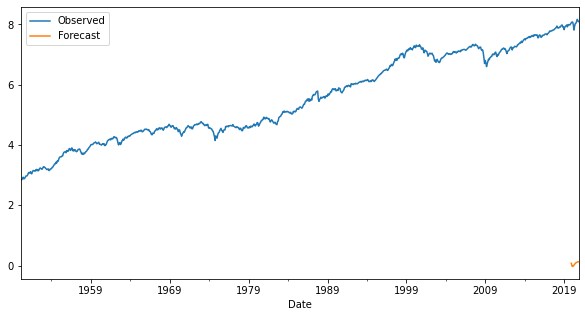

In [144]:
model = run_training_pipeline(lstm_data,
                      seq_length=24, batch_size=16, input_size=2, prediction_len=1,
                      hidden_layer_sizes=[200], dropout_probs=[0.2],                      
                      learning_rate=1e-4,max_epochs=500,name="bs16_200_2years")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type       | Params
----------------------------------------------
0 | lstm_layers    | ModuleList | 364 K 
1 | dropout_layers | ModuleList | 0     
2 | linear         | Linear     | 301   
----------------------------------------------
365 K     Trainable params
0         Non-trainable params
365 K     Total params
1.460     Total estimated model params size (MB)


Sanity Checking: |                                                                           | 0/? [00:00<?, ?…

Training: |                                                                                  | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved. New best score: 25.577


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 20.150 >= min_delta = 0.0. New best score: 5.427


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.338 >= min_delta = 0.0. New best score: 5.089


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 4.059 >= min_delta = 0.0. New best score: 1.030


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.572 >= min_delta = 0.0. New best score: 0.458


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.030 >= min_delta = 0.0. New best score: 0.428


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.099 >= min_delta = 0.0. New best score: 0.329


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.058 >= min_delta = 0.0. New best score: 0.270


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.038 >= min_delta = 0.0. New best score: 0.232


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.058 >= min_delta = 0.0. New best score: 0.174


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 0.150


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.038 >= min_delta = 0.0. New best score: 0.112


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.032 >= min_delta = 0.0. New best score: 0.079


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.079. Signaling Trainer to stop.


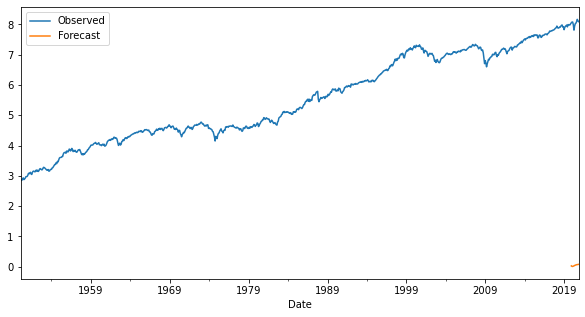

In [143]:
model = run_training_pipeline(lstm_data,
                      seq_length=12, batch_size=16, input_size=2, prediction_len=1,
                      hidden_layer_sizes=[300], dropout_probs=[0.2],                      
                      learning_rate=1e-4,max_epochs=500,name="bs16_300")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type       | Params
----------------------------------------------
0 | lstm_layers    | ModuleList | 364 K 
1 | dropout_layers | ModuleList | 0     
2 | linear         | Linear     | 301   
----------------------------------------------
365 K     Trainable params
0         Non-trainable params
365 K     Total params
1.460     Total estimated model params size (MB)


Sanity Checking: |                                                                           | 0/? [00:00<?, ?…

Training: |                                                                                  | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved. New best score: 23.173


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 17.249 >= min_delta = 0.0. New best score: 5.924


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.231 >= min_delta = 0.0. New best score: 5.693


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 2.650 >= min_delta = 0.0. New best score: 3.043


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 2.041 >= min_delta = 0.0. New best score: 1.001


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.417 >= min_delta = 0.0. New best score: 0.585


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.052 >= min_delta = 0.0. New best score: 0.533


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.524


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.064 >= min_delta = 0.0. New best score: 0.461


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.061 >= min_delta = 0.0. New best score: 0.400


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 0.376


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.038 >= min_delta = 0.0. New best score: 0.338


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.338


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.326


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.315


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.310


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.049 >= min_delta = 0.0. New best score: 0.261


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 0.241


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 0.221


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 0.198


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.196


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 0.180


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.033 >= min_delta = 0.0. New best score: 0.146


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.146. Signaling Trainer to stop.


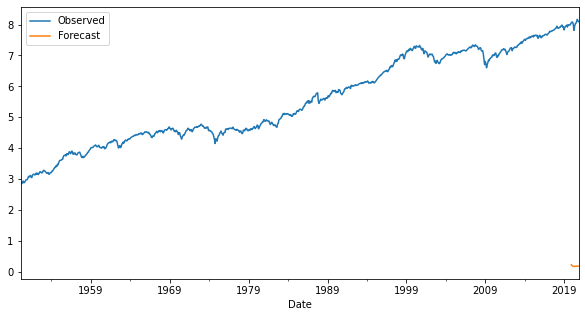

In [159]:
model = run_training_pipeline(lstm_data,
                      seq_length=24, batch_size=16, input_size=2, prediction_len=1,
                      hidden_layer_sizes=[300], dropout_probs=[0.2],                      
                      learning_rate=1e-4,max_epochs=500,name="bs16_300_2years")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type       | Params
----------------------------------------------
0 | lstm_layers    | ModuleList | 364 K 
1 | dropout_layers | ModuleList | 0     
2 | linear         | Linear     | 301   
----------------------------------------------
365 K     Trainable params
0         Non-trainable params
365 K     Total params
1.460     Total estimated model params size (MB)


Sanity Checking: |                                                                           | 0/? [00:00<?, ?…

Training: |                                                                                  | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved. New best score: 24.726


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 19.201 >= min_delta = 0.0. New best score: 5.525


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.034 >= min_delta = 0.0. New best score: 5.491


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.455 >= min_delta = 0.0. New best score: 5.036


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 2.142 >= min_delta = 0.0. New best score: 2.894


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.269 >= min_delta = 0.0. New best score: 1.625


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.591 >= min_delta = 0.0. New best score: 1.034


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.231 >= min_delta = 0.0. New best score: 0.803


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.070 >= min_delta = 0.0. New best score: 0.733


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 0.710


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.045 >= min_delta = 0.0. New best score: 0.665


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.656


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.649


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.644


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.025 >= min_delta = 0.0. New best score: 0.618


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.618. Signaling Trainer to stop.


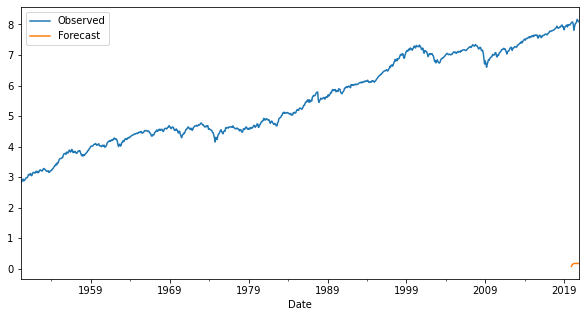

In [158]:
model = run_training_pipeline(lstm_data,
                      seq_length=60, batch_size=16, input_size=2, prediction_len=1,
                      hidden_layer_sizes=[300], dropout_probs=[0.2],                      
                      learning_rate=1e-4,max_epochs=500,name="bs16_300_5years")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type       | Params
----------------------------------------------
0 | lstm_layers    | ModuleList | 364 K 
1 | dropout_layers | ModuleList | 0     
2 | linear         | Linear     | 301   
----------------------------------------------
365 K     Trainable params
0         Non-trainable params
365 K     Total params
1.460     Total estimated model params size (MB)


Sanity Checking: |                                                                           | 0/? [00:00<?, ?…

Training: |                                                                                  | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved. New best score: 51.205


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 34.655 >= min_delta = 0.0. New best score: 16.550


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 10.522 >= min_delta = 0.0. New best score: 6.027


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.122 >= min_delta = 0.0. New best score: 5.905


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.748 >= min_delta = 0.0. New best score: 5.158


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 2.089 >= min_delta = 0.0. New best score: 3.069


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.952 >= min_delta = 0.0. New best score: 1.117


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.460 >= min_delta = 0.0. New best score: 0.657


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.098 >= min_delta = 0.0. New best score: 0.559


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.134 >= min_delta = 0.0. New best score: 0.425


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.081 >= min_delta = 0.0. New best score: 0.344


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.025 >= min_delta = 0.0. New best score: 0.319


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.052 >= min_delta = 0.0. New best score: 0.266


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.051 >= min_delta = 0.0. New best score: 0.215


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.052 >= min_delta = 0.0. New best score: 0.163


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.158


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.151


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.050 >= min_delta = 0.0. New best score: 0.100


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.100. Signaling Trainer to stop.


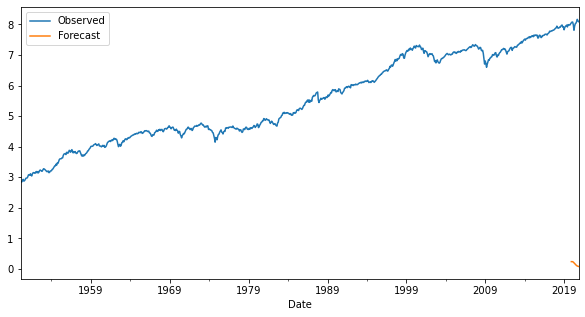

In [157]:
model = run_training_pipeline(lstm_data,
                      seq_length=12, batch_size=16, input_size=2, prediction_len=1,
                      hidden_layer_sizes=[300], dropout_probs=[0.2],                      
                      learning_rate=5e-5,max_epochs=500,name="bs16_300_5e5")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type       | Params
----------------------------------------------
0 | lstm_layers    | ModuleList | 364 K 
1 | dropout_layers | ModuleList | 0     
2 | linear         | Linear     | 301   
----------------------------------------------
365 K     Trainable params
0         Non-trainable params
365 K     Total params
1.460     Total estimated model params size (MB)


Sanity Checking: |                                                                           | 0/? [00:00<?, ?…

Training: |                                                                                  | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved. New best score: 13.941


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 7.498 >= min_delta = 0.0. New best score: 6.443


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 3.746 >= min_delta = 0.0. New best score: 2.697


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 2.149 >= min_delta = 0.0. New best score: 0.548


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.185 >= min_delta = 0.0. New best score: 0.363


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.040 >= min_delta = 0.0. New best score: 0.322


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.156 >= min_delta = 0.0. New best score: 0.167


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.066 >= min_delta = 0.0. New best score: 0.101


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.093


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.082


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.053 >= min_delta = 0.0. New best score: 0.029


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.029. Signaling Trainer to stop.


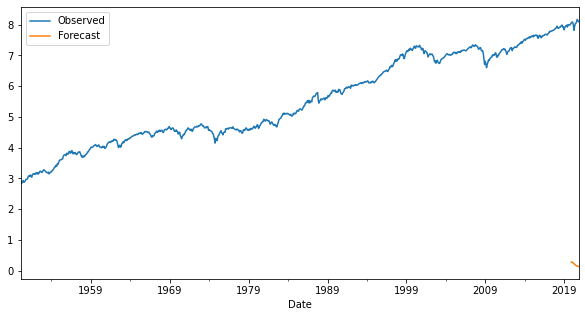

In [156]:
model = run_training_pipeline(lstm_data,
                      seq_length=12, batch_size=8, input_size=2, prediction_len=1,
                      hidden_layer_sizes=[300], dropout_probs=[0.2],                      
                      learning_rate=5e-5,max_epochs=500,name="bs8_300_5e5")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type       | Params
----------------------------------------------
0 | lstm_layers    | ModuleList | 1.0 M 
1 | dropout_layers | ModuleList | 0     
2 | linear         | Linear     | 501   
----------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.034     Total estimated model params size (MB)


Sanity Checking: |                                                                           | 0/? [00:00<?, ?…

Training: |                                                                                  | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved. New best score: 3.301


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.614 >= min_delta = 0.0. New best score: 2.687


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 2.381 >= min_delta = 0.0. New best score: 0.305


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.190 >= min_delta = 0.0. New best score: 0.116


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.100


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.087


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.081


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.033 >= min_delta = 0.0. New best score: 0.048


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.041


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.030


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.022


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.017


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.017. Signaling Trainer to stop.


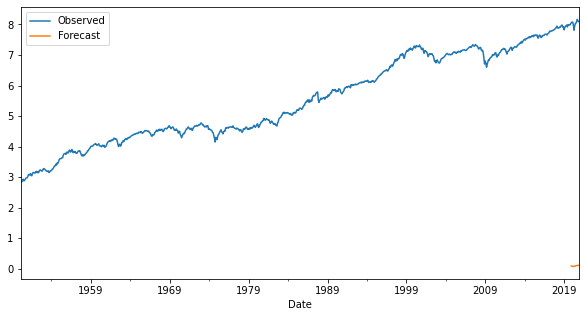

In [155]:
model = run_training_pipeline(lstm_data,
                      seq_length=12, batch_size=16, input_size=2, prediction_len=1,
                      hidden_layer_sizes=[500], dropout_probs=[0.01],                      
                      learning_rate=1e-4,max_epochs=500,name="bs16_500_do0")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type       | Params
----------------------------------------------
0 | lstm_layers    | ModuleList | 1.0 M 
1 | dropout_layers | ModuleList | 0     
2 | linear         | Linear     | 501   
----------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.034     Total estimated model params size (MB)


Sanity Checking: |                                                                           | 0/? [00:00<?, ?…

Training: |                                                                                  | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved. New best score: 2.889


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.316 >= min_delta = 0.0. New best score: 1.573


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.298 >= min_delta = 0.0. New best score: 0.275


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.175 >= min_delta = 0.0. New best score: 0.101


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.086


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.043 >= min_delta = 0.0. New best score: 0.043


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 0.024


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.024. Signaling Trainer to stop.


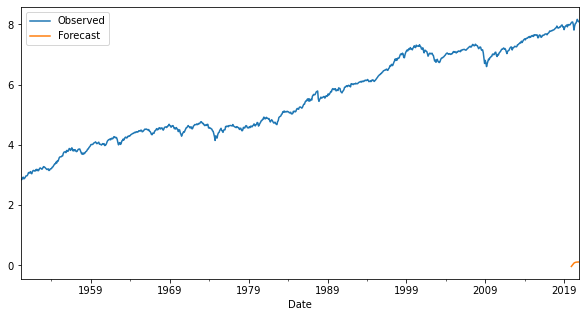

In [154]:
model = run_training_pipeline(lstm_data,
                      seq_length=12, batch_size=16, input_size=2, prediction_len=1,
                      hidden_layer_sizes=[500], dropout_probs=[0.2],                      
                      learning_rate=1e-4,max_epochs=500,name="bs16_500")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type       | Params
----------------------------------------------
0 | lstm_layers    | ModuleList | 1.0 M 
1 | dropout_layers | ModuleList | 0     
2 | linear         | Linear     | 501   
----------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.034     Total estimated model params size (MB)


Sanity Checking: |                                                                           | 0/? [00:00<?, ?…

Training: |                                                                                  | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved. New best score: 2.796


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.470 >= min_delta = 0.0. New best score: 1.326


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.088 >= min_delta = 0.0. New best score: 0.238


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.127 >= min_delta = 0.0. New best score: 0.111


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.035 >= min_delta = 0.0. New best score: 0.076


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.070


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.061


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.043 >= min_delta = 0.0. New best score: 0.018


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.018. Signaling Trainer to stop.


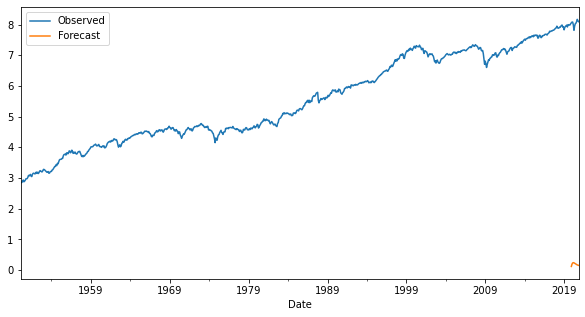

In [153]:
model = run_training_pipeline(lstm_data,
                      seq_length=12, batch_size=16, input_size=2, prediction_len=1,
                      hidden_layer_sizes=[500], dropout_probs=[0.5],                      
                      learning_rate=1e-4,max_epochs=500,name="bs16_500_do05")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type       | Params
----------------------------------------------
0 | lstm_layers    | ModuleList | 163 K 
1 | dropout_layers | ModuleList | 0     
2 | linear         | Linear     | 201   
----------------------------------------------
163 K     Trainable params
0         Non-trainable params
163 K     Total params
0.654     Total estimated model params size (MB)


Sanity Checking: |                                                                           | 0/? [00:00<?, ?…

Training: |                                                                                  | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved. New best score: 62.532


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.818 >= min_delta = 0.0. New best score: 60.714


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.922 >= min_delta = 0.0. New best score: 58.792


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 2.100 >= min_delta = 0.0. New best score: 56.692


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 2.384 >= min_delta = 0.0. New best score: 54.308


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 2.870 >= min_delta = 0.0. New best score: 51.438


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 3.645 >= min_delta = 0.0. New best score: 47.793


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 4.720 >= min_delta = 0.0. New best score: 43.073


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 5.875 >= min_delta = 0.0. New best score: 37.198


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 6.360 >= min_delta = 0.0. New best score: 30.838


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 5.778 >= min_delta = 0.0. New best score: 25.059


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 4.636 >= min_delta = 0.0. New best score: 20.424


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 3.492 >= min_delta = 0.0. New best score: 16.931


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 2.622 >= min_delta = 0.0. New best score: 14.309


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.964 >= min_delta = 0.0. New best score: 12.346


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.429 >= min_delta = 0.0. New best score: 10.917


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.108 >= min_delta = 0.0. New best score: 9.808


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.871 >= min_delta = 0.0. New best score: 8.938


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.608 >= min_delta = 0.0. New best score: 8.330


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.514 >= min_delta = 0.0. New best score: 7.816


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.426 >= min_delta = 0.0. New best score: 7.390


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.347 >= min_delta = 0.0. New best score: 7.043


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.199 >= min_delta = 0.0. New best score: 6.844


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.180 >= min_delta = 0.0. New best score: 6.664


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.184 >= min_delta = 0.0. New best score: 6.480


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.137 >= min_delta = 0.0. New best score: 6.342


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.168 >= min_delta = 0.0. New best score: 6.174


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.165 >= min_delta = 0.0. New best score: 6.010


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.127 >= min_delta = 0.0. New best score: 5.883


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.239 >= min_delta = 0.0. New best score: 5.644


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.223 >= min_delta = 0.0. New best score: 5.421


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.251 >= min_delta = 0.0. New best score: 5.170


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.237 >= min_delta = 0.0. New best score: 4.933


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.320 >= min_delta = 0.0. New best score: 4.613


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.249 >= min_delta = 0.0. New best score: 4.364


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.336 >= min_delta = 0.0. New best score: 4.028


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.291 >= min_delta = 0.0. New best score: 3.736


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.282 >= min_delta = 0.0. New best score: 3.454


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.355 >= min_delta = 0.0. New best score: 3.099


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.260 >= min_delta = 0.0. New best score: 2.839


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.266 >= min_delta = 0.0. New best score: 2.572


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.259 >= min_delta = 0.0. New best score: 2.313


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.190 >= min_delta = 0.0. New best score: 2.124


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.204 >= min_delta = 0.0. New best score: 1.920


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.165 >= min_delta = 0.0. New best score: 1.754


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.148 >= min_delta = 0.0. New best score: 1.606


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.131 >= min_delta = 0.0. New best score: 1.474


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.093 >= min_delta = 0.0. New best score: 1.381


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.121 >= min_delta = 0.0. New best score: 1.261


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.086 >= min_delta = 0.0. New best score: 1.175


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.062 >= min_delta = 0.0. New best score: 1.113


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.048 >= min_delta = 0.0. New best score: 1.065


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.081 >= min_delta = 0.0. New best score: 0.984


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.048 >= min_delta = 0.0. New best score: 0.936


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.053 >= min_delta = 0.0. New best score: 0.883


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.055 >= min_delta = 0.0. New best score: 0.828


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.037 >= min_delta = 0.0. New best score: 0.791


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.028 >= min_delta = 0.0. New best score: 0.763


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.036 >= min_delta = 0.0. New best score: 0.728


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.032 >= min_delta = 0.0. New best score: 0.695


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.047 >= min_delta = 0.0. New best score: 0.648


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.633


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.631


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.054 >= min_delta = 0.0. New best score: 0.577


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 0.560


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.547


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.026 >= min_delta = 0.0. New best score: 0.520


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.032 >= min_delta = 0.0. New best score: 0.488


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.487


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.478


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.035 >= min_delta = 0.0. New best score: 0.444


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 0.426


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.422


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.408


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 0.386


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.376


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.367


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 0.349


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.341


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.331


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.318


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 0.299


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.286


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.282


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.276


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.270


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.255


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.029 >= min_delta = 0.0. New best score: 0.226


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.217


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.215


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.215


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 0.196


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.192


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.188


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.183


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.183


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.179


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.179. Signaling Trainer to stop.


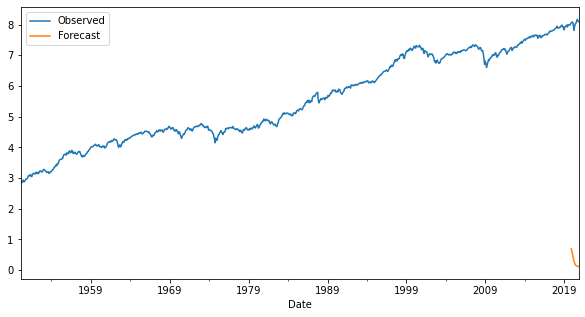

In [132]:
model = run_training_pipeline(lstm_data,
                      seq_length=12, batch_size=16, input_size=2, prediction_len=1,
                      hidden_layer_sizes=[200], dropout_probs=[0.2],                      
                      learning_rate=1e-5,max_epochs=500,name="bs16_200_1e5")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type       | Params
----------------------------------------------
0 | lstm_layers    | ModuleList | 163 K 
1 | dropout_layers | ModuleList | 0     
2 | linear         | Linear     | 201   
----------------------------------------------
163 K     Trainable params
0         Non-trainable params
163 K     Total params
0.654     Total estimated model params size (MB)


Sanity Checking: |                                                                           | 0/? [00:00<?, ?…

Training: |                                                                                  | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved. New best score: 62.017


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.741 >= min_delta = 0.0. New best score: 60.277


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.852 >= min_delta = 0.0. New best score: 58.425


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 2.053 >= min_delta = 0.0. New best score: 56.371


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 2.378 >= min_delta = 0.0. New best score: 53.994


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 2.895 >= min_delta = 0.0. New best score: 51.099


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 3.722 >= min_delta = 0.0. New best score: 47.377


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 4.798 >= min_delta = 0.0. New best score: 42.579


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 5.985 >= min_delta = 0.0. New best score: 36.594


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 6.468 >= min_delta = 0.0. New best score: 30.125


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 5.702 >= min_delta = 0.0. New best score: 24.423


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 4.509 >= min_delta = 0.0. New best score: 19.914


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 3.429 >= min_delta = 0.0. New best score: 16.485


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 2.561 >= min_delta = 0.0. New best score: 13.924


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.998 >= min_delta = 0.0. New best score: 11.926


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.543 >= min_delta = 0.0. New best score: 10.384


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.184 >= min_delta = 0.0. New best score: 9.200


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.820 >= min_delta = 0.0. New best score: 8.379


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.678 >= min_delta = 0.0. New best score: 7.701


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.522 >= min_delta = 0.0. New best score: 7.179


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.317 >= min_delta = 0.0. New best score: 6.862


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.287 >= min_delta = 0.0. New best score: 6.575


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.155 >= min_delta = 0.0. New best score: 6.420


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.174 >= min_delta = 0.0. New best score: 6.245


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.223 >= min_delta = 0.0. New best score: 6.023


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.162 >= min_delta = 0.0. New best score: 5.861


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.040 >= min_delta = 0.0. New best score: 5.821


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.095 >= min_delta = 0.0. New best score: 5.725


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.208 >= min_delta = 0.0. New best score: 5.517


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.185 >= min_delta = 0.0. New best score: 5.332


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.112 >= min_delta = 0.0. New best score: 5.220


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.339 >= min_delta = 0.0. New best score: 4.881


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.361 >= min_delta = 0.0. New best score: 4.520


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.265 >= min_delta = 0.0. New best score: 4.255


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.418 >= min_delta = 0.0. New best score: 3.837


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.311 >= min_delta = 0.0. New best score: 3.525


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.371 >= min_delta = 0.0. New best score: 3.154


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.280 >= min_delta = 0.0. New best score: 2.874


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.293 >= min_delta = 0.0. New best score: 2.581


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.263 >= min_delta = 0.0. New best score: 2.318


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.241 >= min_delta = 0.0. New best score: 2.077


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.201 >= min_delta = 0.0. New best score: 1.876


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.172 >= min_delta = 0.0. New best score: 1.704


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.177 >= min_delta = 0.0. New best score: 1.527


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.097 >= min_delta = 0.0. New best score: 1.429


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.151 >= min_delta = 0.0. New best score: 1.278


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.087 >= min_delta = 0.0. New best score: 1.191


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.075 >= min_delta = 0.0. New best score: 1.117


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.035 >= min_delta = 0.0. New best score: 1.082


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.061 >= min_delta = 0.0. New best score: 1.021


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 1.003


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.050 >= min_delta = 0.0. New best score: 0.953


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.088 >= min_delta = 0.0. New best score: 0.866


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.054 >= min_delta = 0.0. New best score: 0.812


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.799


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 0.781


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.073 >= min_delta = 0.0. New best score: 0.709


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.054 >= min_delta = 0.0. New best score: 0.655


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.654


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.035 >= min_delta = 0.0. New best score: 0.619


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 0.598


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 0.580


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.567


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.030 >= min_delta = 0.0. New best score: 0.537


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 0.520


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.037 >= min_delta = 0.0. New best score: 0.483


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.468


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.062 >= min_delta = 0.0. New best score: 0.406


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.399


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.396


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.394


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.055 >= min_delta = 0.0. New best score: 0.338


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.328


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.041 >= min_delta = 0.0. New best score: 0.288


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.288. Signaling Trainer to stop.


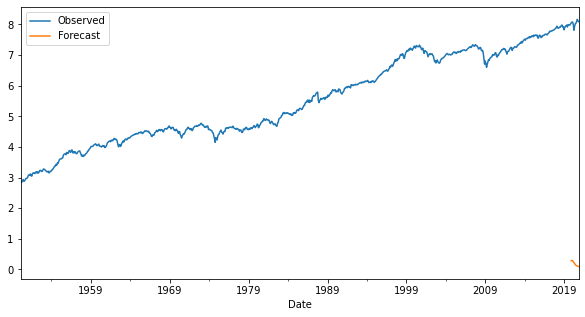

In [133]:
model = run_training_pipeline(lstm_data,
                      seq_length=12, batch_size=16, input_size=2, prediction_len=1,
                      hidden_layer_sizes=[200], dropout_probs=[0.5],                      
                      learning_rate=1e-5,max_epochs=500,name="bs16_200_1e5_do05")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type       | Params
----------------------------------------------
0 | lstm_layers    | ModuleList | 163 K 
1 | dropout_layers | ModuleList | 0     
2 | linear         | Linear     | 201   
----------------------------------------------
163 K     Trainable params
0         Non-trainable params
163 K     Total params
0.654     Total estimated model params size (MB)


Sanity Checking: |                                                                           | 0/? [00:00<?, ?…

Training: |                                                                                  | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved. New best score: 63.065


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.965 >= min_delta = 0.0. New best score: 62.100


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.978 >= min_delta = 0.0. New best score: 61.122


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.994 >= min_delta = 0.0. New best score: 60.128


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.022 >= min_delta = 0.0. New best score: 59.106


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.076 >= min_delta = 0.0. New best score: 58.030


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.138 >= min_delta = 0.0. New best score: 56.892


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.217 >= min_delta = 0.0. New best score: 55.675


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.308 >= min_delta = 0.0. New best score: 54.367


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.413 >= min_delta = 0.0. New best score: 52.954


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.571 >= min_delta = 0.0. New best score: 51.383


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.722 >= min_delta = 0.0. New best score: 49.661


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.921 >= min_delta = 0.0. New best score: 47.740


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 2.158 >= min_delta = 0.0. New best score: 45.582


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 2.454 >= min_delta = 0.0. New best score: 43.128


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 2.683 >= min_delta = 0.0. New best score: 40.445


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 2.897 >= min_delta = 0.0. New best score: 37.549


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 3.041 >= min_delta = 0.0. New best score: 34.508


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 3.050 >= min_delta = 0.0. New best score: 31.457


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 2.940 >= min_delta = 0.0. New best score: 28.518


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 2.714 >= min_delta = 0.0. New best score: 25.804


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 2.440 >= min_delta = 0.0. New best score: 23.364


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 2.180 >= min_delta = 0.0. New best score: 21.184


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.888 >= min_delta = 0.0. New best score: 19.295


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.609 >= min_delta = 0.0. New best score: 17.686


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.441 >= min_delta = 0.0. New best score: 16.245


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.241 >= min_delta = 0.0. New best score: 15.004


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.139 >= min_delta = 0.0. New best score: 13.865


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.985 >= min_delta = 0.0. New best score: 12.880


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.883 >= min_delta = 0.0. New best score: 11.997


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.772 >= min_delta = 0.0. New best score: 11.225


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.645 >= min_delta = 0.0. New best score: 10.580


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.595 >= min_delta = 0.0. New best score: 9.985


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.484 >= min_delta = 0.0. New best score: 9.501


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.464 >= min_delta = 0.0. New best score: 9.038


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.383 >= min_delta = 0.0. New best score: 8.655


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.379 >= min_delta = 0.0. New best score: 8.276


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.310 >= min_delta = 0.0. New best score: 7.966


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.274 >= min_delta = 0.0. New best score: 7.692


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.258 >= min_delta = 0.0. New best score: 7.434


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.197 >= min_delta = 0.0. New best score: 7.237


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.167 >= min_delta = 0.0. New best score: 7.070


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.157 >= min_delta = 0.0. New best score: 6.913


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.125 >= min_delta = 0.0. New best score: 6.789


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.104 >= min_delta = 0.0. New best score: 6.685


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.138 >= min_delta = 0.0. New best score: 6.547


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.109 >= min_delta = 0.0. New best score: 6.438


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.053 >= min_delta = 0.0. New best score: 6.385


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.085 >= min_delta = 0.0. New best score: 6.300


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.102 >= min_delta = 0.0. New best score: 6.198


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.086 >= min_delta = 0.0. New best score: 6.112


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.103 >= min_delta = 0.0. New best score: 6.009


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 5.989


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.041 >= min_delta = 0.0. New best score: 5.949


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.052 >= min_delta = 0.0. New best score: 5.897


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.078 >= min_delta = 0.0. New best score: 5.819


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.059 >= min_delta = 0.0. New best score: 5.760


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.123 >= min_delta = 0.0. New best score: 5.637


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.080 >= min_delta = 0.0. New best score: 5.557


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.105 >= min_delta = 0.0. New best score: 5.452


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.083 >= min_delta = 0.0. New best score: 5.369


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.074 >= min_delta = 0.0. New best score: 5.295


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.147 >= min_delta = 0.0. New best score: 5.148


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.147 >= min_delta = 0.0. New best score: 5.001


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.175 >= min_delta = 0.0. New best score: 4.826


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.118 >= min_delta = 0.0. New best score: 4.708


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.166 >= min_delta = 0.0. New best score: 4.542


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.199 >= min_delta = 0.0. New best score: 4.343


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.181 >= min_delta = 0.0. New best score: 4.162


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.251 >= min_delta = 0.0. New best score: 3.911


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.200 >= min_delta = 0.0. New best score: 3.711


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.206 >= min_delta = 0.0. New best score: 3.505


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.162 >= min_delta = 0.0. New best score: 3.343


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.214 >= min_delta = 0.0. New best score: 3.130


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.178 >= min_delta = 0.0. New best score: 2.952


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.192 >= min_delta = 0.0. New best score: 2.760


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.177 >= min_delta = 0.0. New best score: 2.583


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.182 >= min_delta = 0.0. New best score: 2.401


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.159 >= min_delta = 0.0. New best score: 2.242


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.178 >= min_delta = 0.0. New best score: 2.064


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.116 >= min_delta = 0.0. New best score: 1.948


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.126 >= min_delta = 0.0. New best score: 1.822


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.130 >= min_delta = 0.0. New best score: 1.692


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.109 >= min_delta = 0.0. New best score: 1.582


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.078 >= min_delta = 0.0. New best score: 1.504


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.095 >= min_delta = 0.0. New best score: 1.409


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.081 >= min_delta = 0.0. New best score: 1.327


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.065 >= min_delta = 0.0. New best score: 1.262


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.058 >= min_delta = 0.0. New best score: 1.204


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.068 >= min_delta = 0.0. New best score: 1.136


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.034 >= min_delta = 0.0. New best score: 1.102


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.058 >= min_delta = 0.0. New best score: 1.045


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.058 >= min_delta = 0.0. New best score: 0.986


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 0.962


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.027 >= min_delta = 0.0. New best score: 0.936


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.043 >= min_delta = 0.0. New best score: 0.893


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.029 >= min_delta = 0.0. New best score: 0.864


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.039 >= min_delta = 0.0. New best score: 0.825


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 0.803


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.035 >= min_delta = 0.0. New best score: 0.767


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.753


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.040 >= min_delta = 0.0. New best score: 0.713


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 0.689


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.676


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.025 >= min_delta = 0.0. New best score: 0.651


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 0.630


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.626


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.038 >= min_delta = 0.0. New best score: 0.588


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.578


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 0.554


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.548


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.034 >= min_delta = 0.0. New best score: 0.514


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.508


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.494


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.484


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.470


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 0.454


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.447


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 0.431


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.424


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.412


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.405


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 0.382


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.374


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 0.353


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.344


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.342


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.337


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.325


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.312


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.302


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.031 >= min_delta = 0.0. New best score: 0.270


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.270


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.260


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.260


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.256


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.255


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.248


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.242


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.227


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.219


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.216


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.215


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.208


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.208


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.200


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.197


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.197


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.197. Signaling Trainer to stop.


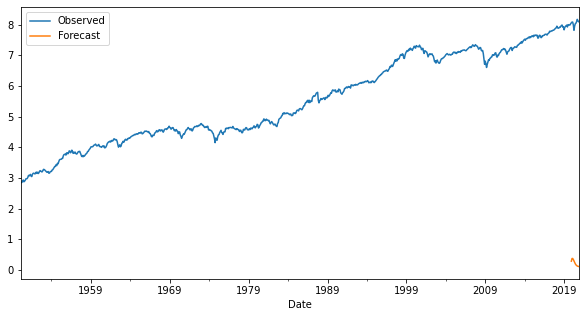

In [134]:
model = run_training_pipeline(lstm_data,
                      seq_length=12, batch_size=16, input_size=2, prediction_len=1,
                      hidden_layer_sizes=[200], dropout_probs=[0.2],                      
                      learning_rate=5e-6,max_epochs=500,name="bs16_200_5e6")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type       | Params
----------------------------------------------
0 | lstm_layers    | ModuleList | 163 K 
1 | dropout_layers | ModuleList | 0     
2 | linear         | Linear     | 201   
----------------------------------------------
163 K     Trainable params
0         Non-trainable params
163 K     Total params
0.654     Total estimated model params size (MB)


Sanity Checking: |                                                                           | 0/? [00:00<?, ?…

Training: |                                                                                  | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved. New best score: 54.848


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 16.706 >= min_delta = 0.0. New best score: 38.142


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 23.009 >= min_delta = 0.0. New best score: 15.133


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 6.746 >= min_delta = 0.0. New best score: 8.387


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.727 >= min_delta = 0.0. New best score: 6.660


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.279 >= min_delta = 0.0. New best score: 6.381


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.562 >= min_delta = 0.0. New best score: 5.819


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.659 >= min_delta = 0.0. New best score: 5.160


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.548 >= min_delta = 0.0. New best score: 3.612


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.581 >= min_delta = 0.0. New best score: 2.031


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.718 >= min_delta = 0.0. New best score: 1.313


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.344 >= min_delta = 0.0. New best score: 0.969


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.159 >= min_delta = 0.0. New best score: 0.810


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.147 >= min_delta = 0.0. New best score: 0.662


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.099 >= min_delta = 0.0. New best score: 0.563


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.044 >= min_delta = 0.0. New best score: 0.519


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.057 >= min_delta = 0.0. New best score: 0.462


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.454


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.111 >= min_delta = 0.0. New best score: 0.343


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 0.326


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.042 >= min_delta = 0.0. New best score: 0.284


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.028 >= min_delta = 0.0. New best score: 0.256


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.249


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.242


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 0.223


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 0.204


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.043 >= min_delta = 0.0. New best score: 0.161


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.161. Signaling Trainer to stop.


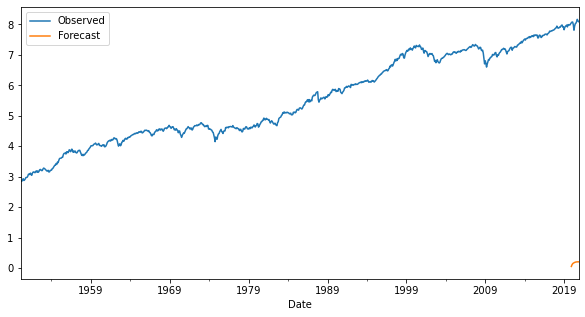

In [135]:
model = run_training_pipeline(lstm_data,
                      seq_length=12, batch_size=16, input_size=2, prediction_len=1,
                      hidden_layer_sizes=[200], dropout_probs=[0.2],                      
                      learning_rate=5e-5,max_epochs=500,name="bs16_200_5e5")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type       | Params
----------------------------------------------
0 | lstm_layers    | ModuleList | 284 K 
1 | dropout_layers | ModuleList | 0     
2 | linear         | Linear     | 101   
----------------------------------------------
284 K     Trainable params
0         Non-trainable params
284 K     Total params
1.136     Total estimated model params size (MB)


Sanity Checking: |                                                                           | 0/? [00:00<?, ?…

Training: |                                                                                  | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved. New best score: 64.050


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.613 >= min_delta = 0.0. New best score: 62.437


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.897 >= min_delta = 0.0. New best score: 60.540


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 2.458 >= min_delta = 0.0. New best score: 58.082


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 3.410 >= min_delta = 0.0. New best score: 54.672


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 4.971 >= min_delta = 0.0. New best score: 49.701


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 6.668 >= min_delta = 0.0. New best score: 43.034


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 7.214 >= min_delta = 0.0. New best score: 35.820


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 5.811 >= min_delta = 0.0. New best score: 30.009


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 4.306 >= min_delta = 0.0. New best score: 25.703


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 3.207 >= min_delta = 0.0. New best score: 22.495


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 2.616 >= min_delta = 0.0. New best score: 19.880


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 2.114 >= min_delta = 0.0. New best score: 17.765


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.734 >= min_delta = 0.0. New best score: 16.031


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.394 >= min_delta = 0.0. New best score: 14.637


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.120 >= min_delta = 0.0. New best score: 13.517


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.918 >= min_delta = 0.0. New best score: 12.599


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.694 >= min_delta = 0.0. New best score: 11.905


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.564 >= min_delta = 0.0. New best score: 11.342


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.497 >= min_delta = 0.0. New best score: 10.844


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.464 >= min_delta = 0.0. New best score: 10.380


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.407 >= min_delta = 0.0. New best score: 9.973


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.348 >= min_delta = 0.0. New best score: 9.625


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.316 >= min_delta = 0.0. New best score: 9.310


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.292 >= min_delta = 0.0. New best score: 9.018


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.251 >= min_delta = 0.0. New best score: 8.767


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.226 >= min_delta = 0.0. New best score: 8.542


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.204 >= min_delta = 0.0. New best score: 8.338


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.184 >= min_delta = 0.0. New best score: 8.154


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.179 >= min_delta = 0.0. New best score: 7.975


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.147 >= min_delta = 0.0. New best score: 7.828


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.122 >= min_delta = 0.0. New best score: 7.706


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.127 >= min_delta = 0.0. New best score: 7.579


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.122 >= min_delta = 0.0. New best score: 7.458


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.108 >= min_delta = 0.0. New best score: 7.350


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.087 >= min_delta = 0.0. New best score: 7.263


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.084 >= min_delta = 0.0. New best score: 7.180


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.067 >= min_delta = 0.0. New best score: 7.113


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.072 >= min_delta = 0.0. New best score: 7.041


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.062 >= min_delta = 0.0. New best score: 6.980


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.045 >= min_delta = 0.0. New best score: 6.935


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.089 >= min_delta = 0.0. New best score: 6.846


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.058 >= min_delta = 0.0. New best score: 6.788


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.076 >= min_delta = 0.0. New best score: 6.713


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.053 >= min_delta = 0.0. New best score: 6.660


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.080 >= min_delta = 0.0. New best score: 6.579


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.074 >= min_delta = 0.0. New best score: 6.505


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.126 >= min_delta = 0.0. New best score: 6.380


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.141 >= min_delta = 0.0. New best score: 6.238


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.224 >= min_delta = 0.0. New best score: 6.015


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.270 >= min_delta = 0.0. New best score: 5.745


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.258 >= min_delta = 0.0. New best score: 5.486


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.241 >= min_delta = 0.0. New best score: 5.245


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.246 >= min_delta = 0.0. New best score: 5.000


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.221 >= min_delta = 0.0. New best score: 4.779


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.195 >= min_delta = 0.0. New best score: 4.583


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.170 >= min_delta = 0.0. New best score: 4.413


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.171 >= min_delta = 0.0. New best score: 4.241


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.157 >= min_delta = 0.0. New best score: 4.085


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.143 >= min_delta = 0.0. New best score: 3.941


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.141 >= min_delta = 0.0. New best score: 3.801


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.140 >= min_delta = 0.0. New best score: 3.660


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.128 >= min_delta = 0.0. New best score: 3.532


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.131 >= min_delta = 0.0. New best score: 3.401


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.118 >= min_delta = 0.0. New best score: 3.283


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.116 >= min_delta = 0.0. New best score: 3.168


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.118 >= min_delta = 0.0. New best score: 3.050


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.103 >= min_delta = 0.0. New best score: 2.947


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.098 >= min_delta = 0.0. New best score: 2.848


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.083 >= min_delta = 0.0. New best score: 2.765


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.084 >= min_delta = 0.0. New best score: 2.682


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.087 >= min_delta = 0.0. New best score: 2.595


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.087 >= min_delta = 0.0. New best score: 2.509


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.080 >= min_delta = 0.0. New best score: 2.428


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.084 >= min_delta = 0.0. New best score: 2.345


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.067 >= min_delta = 0.0. New best score: 2.277


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.068 >= min_delta = 0.0. New best score: 2.209


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.077 >= min_delta = 0.0. New best score: 2.133


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.066 >= min_delta = 0.0. New best score: 2.067


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.056 >= min_delta = 0.0. New best score: 2.011


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.056 >= min_delta = 0.0. New best score: 1.955


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.055 >= min_delta = 0.0. New best score: 1.900


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.058 >= min_delta = 0.0. New best score: 1.842


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.058 >= min_delta = 0.0. New best score: 1.784


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.053 >= min_delta = 0.0. New best score: 1.731


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.039 >= min_delta = 0.0. New best score: 1.692


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.044 >= min_delta = 0.0. New best score: 1.648


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.038 >= min_delta = 0.0. New best score: 1.610


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.052 >= min_delta = 0.0. New best score: 1.558


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.039 >= min_delta = 0.0. New best score: 1.518


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.042 >= min_delta = 0.0. New best score: 1.477


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.045 >= min_delta = 0.0. New best score: 1.431


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.034 >= min_delta = 0.0. New best score: 1.397


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.036 >= min_delta = 0.0. New best score: 1.362


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.031 >= min_delta = 0.0. New best score: 1.330


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.039 >= min_delta = 0.0. New best score: 1.291


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.036 >= min_delta = 0.0. New best score: 1.255


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.044 >= min_delta = 0.0. New best score: 1.210


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 1.186


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.034 >= min_delta = 0.0. New best score: 1.152


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.029 >= min_delta = 0.0. New best score: 1.123


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 1.099


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.029 >= min_delta = 0.0. New best score: 1.070


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 1.047


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 1.028


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.034 >= min_delta = 0.0. New best score: 0.995


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 0.976


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 0.955


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 0.936


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.924


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 0.901


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 0.883


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 0.867


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 0.849


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.836


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.827


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 0.803


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.790


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.778


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.765


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 0.746


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 0.728


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.720


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.717


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.704


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.690


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.683


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 0.663


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.652


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.643


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.635


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.631


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.619


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.608


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.025 >= min_delta = 0.0. New best score: 0.583


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.579


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.574


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.570


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.557


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.551


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.538


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.528


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.522


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 0.504


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.500


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 0.484


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.477


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.466


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.453


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.447


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.028 >= min_delta = 0.0. New best score: 0.419


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.418


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.415


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.406


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.396


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.395


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.392


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 0.376


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.365


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.363


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 0.346


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.343


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.342


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.342


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 0.322


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.322


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 0.299


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.283


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.283


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.281


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.272


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.264


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.264. Signaling Trainer to stop.


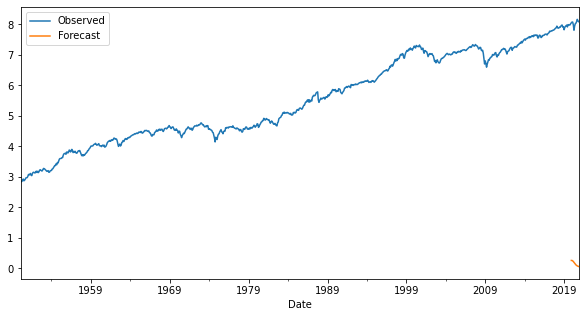

In [136]:
model = run_training_pipeline(lstm_data,
                      seq_length=12, batch_size=16, input_size=2, prediction_len=1,
                      hidden_layer_sizes=[200, 100], dropout_probs=[0.4, 0.3],                      
                      learning_rate=1e-5,max_epochs=500,name="bs16_200_100_more_do_1e5")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type       | Params
----------------------------------------------
0 | lstm_layers    | ModuleList | 284 K 
1 | dropout_layers | ModuleList | 0     
2 | linear         | Linear     | 101   
----------------------------------------------
284 K     Trainable params
0         Non-trainable params
284 K     Total params
1.136     Total estimated model params size (MB)


Sanity Checking: |                                                                           | 0/? [00:00<?, ?…

Training: |                                                                                  | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved. New best score: 35.431


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 24.852 >= min_delta = 0.0. New best score: 10.579


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 3.463 >= min_delta = 0.0. New best score: 7.116


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.562 >= min_delta = 0.0. New best score: 6.554


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.473 >= min_delta = 0.0. New best score: 6.081


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.151 >= min_delta = 0.0. New best score: 5.930


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.576 >= min_delta = 0.0. New best score: 5.354


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.494 >= min_delta = 0.0. New best score: 3.861


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.210 >= min_delta = 0.0. New best score: 2.650


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.710 >= min_delta = 0.0. New best score: 1.940


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.462 >= min_delta = 0.0. New best score: 1.478


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.255 >= min_delta = 0.0. New best score: 1.222


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.167 >= min_delta = 0.0. New best score: 1.056


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.116 >= min_delta = 0.0. New best score: 0.940


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.145 >= min_delta = 0.0. New best score: 0.794


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.054 >= min_delta = 0.0. New best score: 0.741


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.066 >= min_delta = 0.0. New best score: 0.674


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.074 >= min_delta = 0.0. New best score: 0.600


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.598


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.068 >= min_delta = 0.0. New best score: 0.530


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.025 >= min_delta = 0.0. New best score: 0.506


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.046 >= min_delta = 0.0. New best score: 0.459


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.455


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 0.432


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.030 >= min_delta = 0.0. New best score: 0.402


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 0.382


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.029 >= min_delta = 0.0. New best score: 0.352


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.035 >= min_delta = 0.0. New best score: 0.317


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 0.294


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.291


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.287


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.282


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 0.266


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.041 >= min_delta = 0.0. New best score: 0.225


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.225


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.216


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.208


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.197


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.189


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.025 >= min_delta = 0.0. New best score: 0.164


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.149


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.029 >= min_delta = 0.0. New best score: 0.120


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 0.103


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 0.084


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.084. Signaling Trainer to stop.


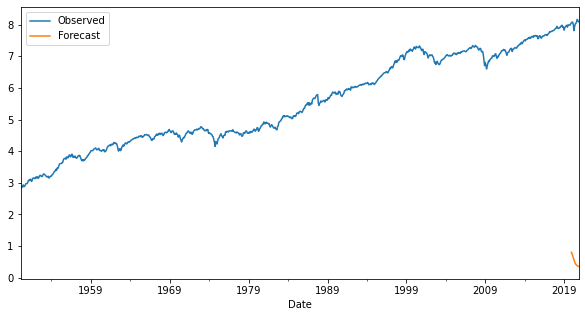

In [137]:
model = run_training_pipeline(lstm_data,
                      seq_length=12, batch_size=16, input_size=2, prediction_len=1,
                      hidden_layer_sizes=[200, 100], dropout_probs=[0.4, 0.3],                      
                      learning_rate=1e-4,max_epochs=500,name="bs16_200_100_more_do")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type       | Params
----------------------------------------------
0 | lstm_layers    | ModuleList | 484 K 
1 | dropout_layers | ModuleList | 0     
2 | linear         | Linear     | 201   
----------------------------------------------
485 K     Trainable params
0         Non-trainable params
485 K     Total params
1.940     Total estimated model params size (MB)


Sanity Checking: |                                                                           | 0/? [00:00<?, ?…

Training: |                                                                                  | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved. New best score: 14.680


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 8.959 >= min_delta = 0.0. New best score: 5.720


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.281 >= min_delta = 0.0. New best score: 4.440


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 3.302 >= min_delta = 0.0. New best score: 1.138


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.623 >= min_delta = 0.0. New best score: 0.515


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.175 >= min_delta = 0.0. New best score: 0.340


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.087 >= min_delta = 0.0. New best score: 0.254


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.066 >= min_delta = 0.0. New best score: 0.188


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.036 >= min_delta = 0.0. New best score: 0.151


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.138


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.129


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 0.107


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.025 >= min_delta = 0.0. New best score: 0.081


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.030 >= min_delta = 0.0. New best score: 0.052


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.051


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.051. Signaling Trainer to stop.


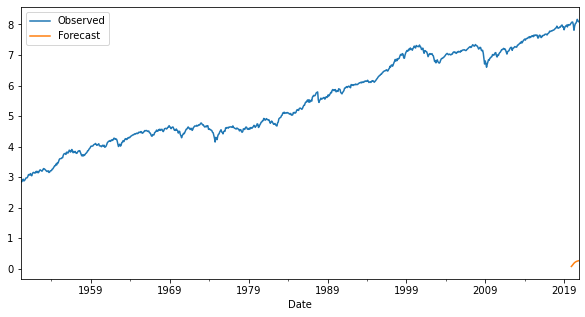

In [145]:
model = run_training_pipeline(lstm_data,
                      seq_length=12, batch_size=16, input_size=2, prediction_len=1,
                      hidden_layer_sizes=[200, 200], dropout_probs=[0.4, 0.3],                      
                      learning_rate=1e-4,max_epochs=500,name="bs16_200_200_more_do")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type       | Params
----------------------------------------------
0 | lstm_layers    | ModuleList | 284 K 
1 | dropout_layers | ModuleList | 0     
2 | linear         | Linear     | 101   
----------------------------------------------
284 K     Trainable params
0         Non-trainable params
284 K     Total params
1.136     Total estimated model params size (MB)


Sanity Checking: |                                                                           | 0/? [00:00<?, ?…

Training: |                                                                                  | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved. New best score: 53.296


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 28.890 >= min_delta = 0.0. New best score: 24.406


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 12.411 >= min_delta = 0.0. New best score: 11.995


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 3.293 >= min_delta = 0.0. New best score: 8.702


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.183 >= min_delta = 0.0. New best score: 7.519


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.648 >= min_delta = 0.0. New best score: 6.871


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.179 >= min_delta = 0.0. New best score: 6.692


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.186 >= min_delta = 0.0. New best score: 6.506


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.114 >= min_delta = 0.0. New best score: 6.392


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.341 >= min_delta = 0.0. New best score: 6.051


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.755 >= min_delta = 0.0. New best score: 5.296


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.071 >= min_delta = 0.0. New best score: 4.225


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.999 >= min_delta = 0.0. New best score: 3.226


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.556 >= min_delta = 0.0. New best score: 2.670


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.419 >= min_delta = 0.0. New best score: 2.251


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.289 >= min_delta = 0.0. New best score: 1.962


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.256 >= min_delta = 0.0. New best score: 1.706


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.212 >= min_delta = 0.0. New best score: 1.494


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.169 >= min_delta = 0.0. New best score: 1.325


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.123 >= min_delta = 0.0. New best score: 1.203


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.119 >= min_delta = 0.0. New best score: 1.084


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.081 >= min_delta = 0.0. New best score: 1.003


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.075 >= min_delta = 0.0. New best score: 0.928


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.073 >= min_delta = 0.0. New best score: 0.855


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.052 >= min_delta = 0.0. New best score: 0.803


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 0.783


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.040 >= min_delta = 0.0. New best score: 0.744


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.052 >= min_delta = 0.0. New best score: 0.691


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.035 >= min_delta = 0.0. New best score: 0.656


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.043 >= min_delta = 0.0. New best score: 0.613


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.045 >= min_delta = 0.0. New best score: 0.568


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 0.550


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 0.533


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.025 >= min_delta = 0.0. New best score: 0.507


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.026 >= min_delta = 0.0. New best score: 0.481


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.478


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.042 >= min_delta = 0.0. New best score: 0.436


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.431


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 0.408


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.402


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.401


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.386


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 0.365


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.036 >= min_delta = 0.0. New best score: 0.329


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.329


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 0.309


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 0.286


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.281


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.268


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.260


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.260


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.245


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 0.222


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 0.204


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.202


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.197


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.192


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.187


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.186


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.171


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.041 >= min_delta = 0.0. New best score: 0.130


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.130. Signaling Trainer to stop.


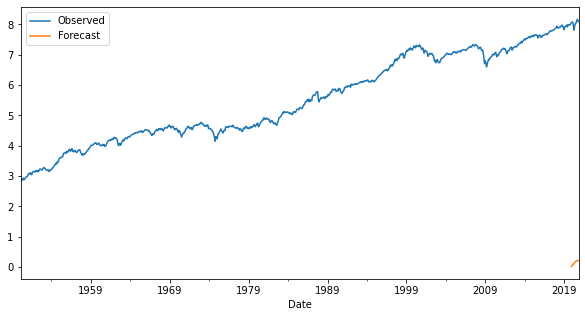

In [138]:
model = run_training_pipeline(lstm_data,
                      seq_length=12, batch_size=16, input_size=2, prediction_len=1,
                      hidden_layer_sizes=[200, 100], dropout_probs=[0.2, 0.2],                      
                      learning_rate=5e-5,max_epochs=500,name="bs16_200_100_5e5")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type       | Params
----------------------------------------------
0 | lstm_layers    | ModuleList | 284 K 
1 | dropout_layers | ModuleList | 0     
2 | linear         | Linear     | 101   
----------------------------------------------
284 K     Trainable params
0         Non-trainable params
284 K     Total params
1.136     Total estimated model params size (MB)


Sanity Checking: |                                                                           | 0/? [00:00<?, ?…

Training: |                                                                                  | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved. New best score: 32.305


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 23.600 >= min_delta = 0.0. New best score: 8.705


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 2.157 >= min_delta = 0.0. New best score: 6.548


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.254 >= min_delta = 0.0. New best score: 6.294


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.730 >= min_delta = 0.0. New best score: 5.564


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.162 >= min_delta = 0.0. New best score: 4.402


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.311 >= min_delta = 0.0. New best score: 3.091


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.799 >= min_delta = 0.0. New best score: 2.291


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.530 >= min_delta = 0.0. New best score: 1.761


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.342 >= min_delta = 0.0. New best score: 1.419


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.232 >= min_delta = 0.0. New best score: 1.187


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.131 >= min_delta = 0.0. New best score: 1.055


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.096 >= min_delta = 0.0. New best score: 0.959


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.102 >= min_delta = 0.0. New best score: 0.857


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.060 >= min_delta = 0.0. New best score: 0.797


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.060 >= min_delta = 0.0. New best score: 0.738


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.061 >= min_delta = 0.0. New best score: 0.677


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.025 >= min_delta = 0.0. New best score: 0.652


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.049 >= min_delta = 0.0. New best score: 0.603


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.595


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.587


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.040 >= min_delta = 0.0. New best score: 0.547


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.042 >= min_delta = 0.0. New best score: 0.504


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.499


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 0.476


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.461


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.047 >= min_delta = 0.0. New best score: 0.414


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.401


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.400


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.041 >= min_delta = 0.0. New best score: 0.359


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.050 >= min_delta = 0.0. New best score: 0.309


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.301


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.298


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 0.281


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.278


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 0.254


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 0.239


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.239. Signaling Trainer to stop.


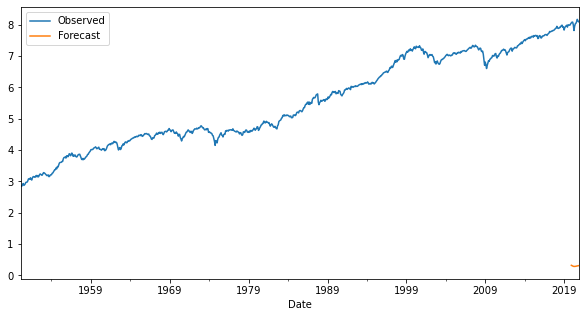

In [139]:
model = run_training_pipeline(lstm_data,
                      seq_length=24, batch_size=16, input_size=2, prediction_len=1,
                      hidden_layer_sizes=[200, 100], dropout_probs=[0.2, 0.2],                      
                      learning_rate=1e-4,max_epochs=500,name="bs16_200_100_2years")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type       | Params
----------------------------------------------
0 | lstm_layers    | ModuleList | 484 K 
1 | dropout_layers | ModuleList | 0     
2 | linear         | Linear     | 201   
----------------------------------------------
485 K     Trainable params
0         Non-trainable params
485 K     Total params
1.940     Total estimated model params size (MB)


Sanity Checking: |                                                                           | 0/? [00:00<?, ?…

Training: |                                                                                  | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved. New best score: 13.959


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 7.755 >= min_delta = 0.0. New best score: 6.203


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.273 >= min_delta = 0.0. New best score: 5.931


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 2.015 >= min_delta = 0.0. New best score: 3.915


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 2.756 >= min_delta = 0.0. New best score: 1.159


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.402 >= min_delta = 0.0. New best score: 0.757


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.140 >= min_delta = 0.0. New best score: 0.617


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.027 >= min_delta = 0.0. New best score: 0.589


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.028 >= min_delta = 0.0. New best score: 0.561


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.035 >= min_delta = 0.0. New best score: 0.525


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.111 >= min_delta = 0.0. New best score: 0.414


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.032 >= min_delta = 0.0. New best score: 0.382


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.377


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.046 >= min_delta = 0.0. New best score: 0.331


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.027 >= min_delta = 0.0. New best score: 0.304


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.034 >= min_delta = 0.0. New best score: 0.270


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.036 >= min_delta = 0.0. New best score: 0.233


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.032 >= min_delta = 0.0. New best score: 0.202


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 0.178


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 0.157


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.145


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.045 >= min_delta = 0.0. New best score: 0.100


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.100. Signaling Trainer to stop.


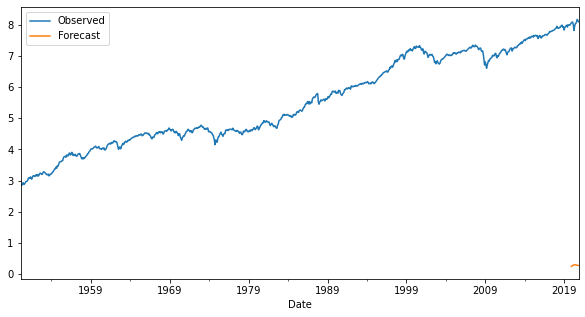

In [148]:
model = run_training_pipeline(lstm_data,
                      seq_length=24, batch_size=16, input_size=2, prediction_len=1,
                      hidden_layer_sizes=[200, 200], dropout_probs=[0.3, 0.3],                      
                      learning_rate=1e-4,max_epochs=500,name="bs16_200_200_2years_do3")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type       | Params
----------------------------------------------
0 | lstm_layers    | ModuleList | 284 K 
1 | dropout_layers | ModuleList | 0     
2 | linear         | Linear     | 101   
----------------------------------------------
284 K     Trainable params
0         Non-trainable params
284 K     Total params
1.136     Total estimated model params size (MB)


Sanity Checking: |                                                                           | 0/? [00:00<?, ?…

Training: |                                                                                  | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved. New best score: 34.967


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 24.291 >= min_delta = 0.0. New best score: 10.676


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 3.290 >= min_delta = 0.0. New best score: 7.386


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.903 >= min_delta = 0.0. New best score: 6.483


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.225 >= min_delta = 0.0. New best score: 6.259


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.210 >= min_delta = 0.0. New best score: 6.048


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.354 >= min_delta = 0.0. New best score: 4.694


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.433 >= min_delta = 0.0. New best score: 3.262


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.775 >= min_delta = 0.0. New best score: 2.486


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.512 >= min_delta = 0.0. New best score: 1.975


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.405 >= min_delta = 0.0. New best score: 1.570


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.264 >= min_delta = 0.0. New best score: 1.306


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.257 >= min_delta = 0.0. New best score: 1.049


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.123 >= min_delta = 0.0. New best score: 0.926


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.128 >= min_delta = 0.0. New best score: 0.798


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.063 >= min_delta = 0.0. New best score: 0.734


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.049 >= min_delta = 0.0. New best score: 0.686


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.050 >= min_delta = 0.0. New best score: 0.635


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 0.611


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.065 >= min_delta = 0.0. New best score: 0.546


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 0.525


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.519


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.048 >= min_delta = 0.0. New best score: 0.471


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.028 >= min_delta = 0.0. New best score: 0.443


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.437


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.430


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 0.409


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 0.387


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.381


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.063 >= min_delta = 0.0. New best score: 0.317


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.303


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 0.279


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.039 >= min_delta = 0.0. New best score: 0.240


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.238


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.230


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.224


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 0.202


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.048 >= min_delta = 0.0. New best score: 0.155


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.148


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.141


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.137


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.127


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.115


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.111


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 0.091


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.091


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.089


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.085


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.081


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.080


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.080. Signaling Trainer to stop.


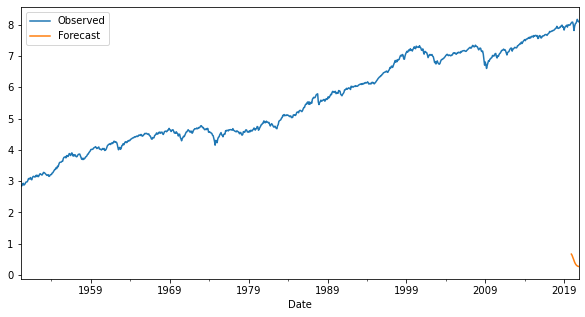

In [140]:
model = run_training_pipeline(lstm_data,
                      seq_length=12, batch_size=16, input_size=2, prediction_len=1,
                      hidden_layer_sizes=[200, 100], dropout_probs=[0.2, 0.2],                      
                      learning_rate=1e-4,max_epochs=500,name="bs16_200_100")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type       | Params
----------------------------------------------
0 | lstm_layers    | ModuleList | 284 K 
1 | dropout_layers | ModuleList | 0     
2 | linear         | Linear     | 101   
----------------------------------------------
284 K     Trainable params
0         Non-trainable params
284 K     Total params
1.136     Total estimated model params size (MB)


Sanity Checking: |                                                                           | 0/? [00:00<?, ?…

Training: |                                                                                  | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved. New best score: 45.055


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 30.121 >= min_delta = 0.0. New best score: 14.934


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 5.980 >= min_delta = 0.0. New best score: 8.955


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.734 >= min_delta = 0.0. New best score: 7.221


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.535 >= min_delta = 0.0. New best score: 6.686


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.167 >= min_delta = 0.0. New best score: 6.519


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.048 >= min_delta = 0.0. New best score: 6.470


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.442 >= min_delta = 0.0. New best score: 6.028


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.858 >= min_delta = 0.0. New best score: 5.170


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.015 >= min_delta = 0.0. New best score: 4.155


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.150 >= min_delta = 0.0. New best score: 3.005


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.718 >= min_delta = 0.0. New best score: 2.287


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.454 >= min_delta = 0.0. New best score: 1.833


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.316 >= min_delta = 0.0. New best score: 1.517


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.259 >= min_delta = 0.0. New best score: 1.258


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.161 >= min_delta = 0.0. New best score: 1.098


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.138 >= min_delta = 0.0. New best score: 0.960


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.096 >= min_delta = 0.0. New best score: 0.864


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.078 >= min_delta = 0.0. New best score: 0.785


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.047 >= min_delta = 0.0. New best score: 0.738


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.070 >= min_delta = 0.0. New best score: 0.668


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.028 >= min_delta = 0.0. New best score: 0.641


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 0.625


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.031 >= min_delta = 0.0. New best score: 0.594


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.027 >= min_delta = 0.0. New best score: 0.567


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.555


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.052 >= min_delta = 0.0. New best score: 0.503


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 0.479


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.477


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 0.454


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.444


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.441


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.433


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.423


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 0.404


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 0.381


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.377


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.371


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.043 >= min_delta = 0.0. New best score: 0.328


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 0.309


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.298


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.291


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.289


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.279


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.025 >= min_delta = 0.0. New best score: 0.254


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.253


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.245


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 0.229


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 0.207


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.204


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 0.188


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.182


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.041 >= min_delta = 0.0. New best score: 0.141


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.141. Signaling Trainer to stop.


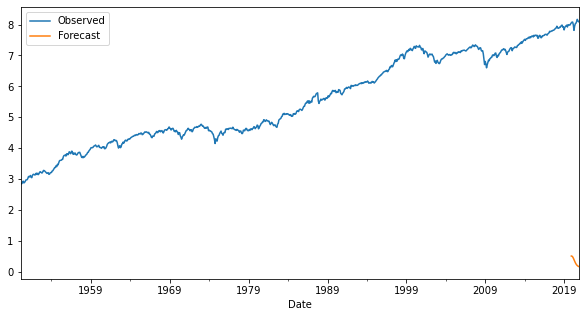

In [149]:
model = run_training_pipeline(lstm_data,
                      seq_length=12, batch_size=16, input_size=2, prediction_len=1,
                      hidden_layer_sizes=[200, 100], dropout_probs=[0.2, 0.2],                      
                      learning_rate=7.5e-5,max_epochs=500,name="bs16_200_100_75e-5")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type       | Params
----------------------------------------------
0 | lstm_layers    | ModuleList | 72.0 K
1 | dropout_layers | ModuleList | 0     
2 | linear         | Linear     | 51    
----------------------------------------------
72.1 K    Trainable params
0         Non-trainable params
72.1 K    Total params
0.288     Total estimated model params size (MB)


Sanity Checking: |                                                                           | 0/? [00:00<?, ?…

Training: |                                                                                  | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved. New best score: 52.379


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 24.456 >= min_delta = 0.0. New best score: 27.923


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 11.810 >= min_delta = 0.0. New best score: 16.113


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 4.024 >= min_delta = 0.0. New best score: 12.089


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.814 >= min_delta = 0.0. New best score: 10.275


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.146 >= min_delta = 0.0. New best score: 9.129


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.724 >= min_delta = 0.0. New best score: 8.405


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.501 >= min_delta = 0.0. New best score: 7.904


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.444 >= min_delta = 0.0. New best score: 7.461


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.282 >= min_delta = 0.0. New best score: 7.178


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.234 >= min_delta = 0.0. New best score: 6.945


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.173 >= min_delta = 0.0. New best score: 6.772


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.100 >= min_delta = 0.0. New best score: 6.672


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.121 >= min_delta = 0.0. New best score: 6.551


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.053 >= min_delta = 0.0. New best score: 6.498


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.636 >= min_delta = 0.0. New best score: 5.862


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.799 >= min_delta = 0.0. New best score: 5.063


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.641 >= min_delta = 0.0. New best score: 4.422


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.555 >= min_delta = 0.0. New best score: 3.867


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.505 >= min_delta = 0.0. New best score: 3.363


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.374 >= min_delta = 0.0. New best score: 2.989


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.303 >= min_delta = 0.0. New best score: 2.686


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.250 >= min_delta = 0.0. New best score: 2.435


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.227 >= min_delta = 0.0. New best score: 2.208


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.170 >= min_delta = 0.0. New best score: 2.038


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.182 >= min_delta = 0.0. New best score: 1.856


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.144 >= min_delta = 0.0. New best score: 1.712


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.124 >= min_delta = 0.0. New best score: 1.588


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.113 >= min_delta = 0.0. New best score: 1.475


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.086 >= min_delta = 0.0. New best score: 1.389


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.084 >= min_delta = 0.0. New best score: 1.305


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.071 >= min_delta = 0.0. New best score: 1.234


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.054 >= min_delta = 0.0. New best score: 1.180


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.060 >= min_delta = 0.0. New best score: 1.120


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.028 >= min_delta = 0.0. New best score: 1.093


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.050 >= min_delta = 0.0. New best score: 1.042


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.046 >= min_delta = 0.0. New best score: 0.997


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 0.977


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.051 >= min_delta = 0.0. New best score: 0.926


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.038 >= min_delta = 0.0. New best score: 0.887


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.884


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.870


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.039 >= min_delta = 0.0. New best score: 0.831


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.825


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.810


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.038 >= min_delta = 0.0. New best score: 0.772


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.764


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.755


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.749


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 0.730


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.031 >= min_delta = 0.0. New best score: 0.698


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.698. Signaling Trainer to stop.


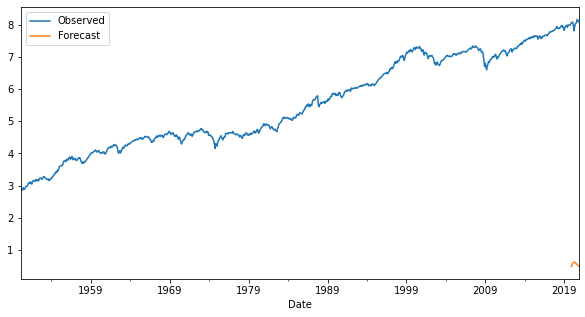

In [141]:
model = run_training_pipeline(lstm_data,
                      seq_length=36, batch_size=16, input_size=2, prediction_len=1,
                      hidden_layer_sizes=[100, 50], dropout_probs=[0.2, 0.2],                      
                      learning_rate=1e-4,max_epochs=500,name="bs16_3years")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type       | Params
----------------------------------------------
0 | lstm_layers    | ModuleList | 18.5 K
1 | dropout_layers | ModuleList | 0     
2 | linear         | Linear     | 26    
----------------------------------------------
18.5 K    Trainable params
0         Non-trainable params
18.5 K    Total params
0.074     Total estimated model params size (MB)


Sanity Checking: |                                                                           | 0/? [00:00<?, ?…

Training: |                                                                                  | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved. New best score: 64.397


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 4.213 >= min_delta = 0.0. New best score: 60.184


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 8.554 >= min_delta = 0.0. New best score: 51.630


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 8.665 >= min_delta = 0.0. New best score: 42.965


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 6.036 >= min_delta = 0.0. New best score: 36.930


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 4.887 >= min_delta = 0.0. New best score: 32.043


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 3.981 >= min_delta = 0.0. New best score: 28.062


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 2.915 >= min_delta = 0.0. New best score: 25.147


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 2.038 >= min_delta = 0.0. New best score: 23.109


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.565 >= min_delta = 0.0. New best score: 21.544


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.289 >= min_delta = 0.0. New best score: 20.255


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.138 >= min_delta = 0.0. New best score: 19.117


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.025 >= min_delta = 0.0. New best score: 18.092


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.914 >= min_delta = 0.0. New best score: 17.178


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.828 >= min_delta = 0.0. New best score: 16.350


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.763 >= min_delta = 0.0. New best score: 15.587


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.702 >= min_delta = 0.0. New best score: 14.885


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.650 >= min_delta = 0.0. New best score: 14.235


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.595 >= min_delta = 0.0. New best score: 13.639


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.538 >= min_delta = 0.0. New best score: 13.101


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.524 >= min_delta = 0.0. New best score: 12.577


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.496 >= min_delta = 0.0. New best score: 12.081


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.422 >= min_delta = 0.0. New best score: 11.659


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.422 >= min_delta = 0.0. New best score: 11.237


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.397 >= min_delta = 0.0. New best score: 10.840


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.320 >= min_delta = 0.0. New best score: 10.520


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.382 >= min_delta = 0.0. New best score: 10.138


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.339 >= min_delta = 0.0. New best score: 9.799


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.440 >= min_delta = 0.0. New best score: 9.359


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.647 >= min_delta = 0.0. New best score: 8.712


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.369 >= min_delta = 0.0. New best score: 8.343


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.253 >= min_delta = 0.0. New best score: 8.090


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.197 >= min_delta = 0.0. New best score: 7.893


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.146 >= min_delta = 0.0. New best score: 7.746


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.129 >= min_delta = 0.0. New best score: 7.618


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.098 >= min_delta = 0.0. New best score: 7.519


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.129 >= min_delta = 0.0. New best score: 7.390


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.147 >= min_delta = 0.0. New best score: 7.243


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.101 >= min_delta = 0.0. New best score: 7.142


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.084 >= min_delta = 0.0. New best score: 7.058


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.079 >= min_delta = 0.0. New best score: 6.978


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 6.955


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.263 >= min_delta = 0.0. New best score: 6.692


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.328 >= min_delta = 0.0. New best score: 6.364


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.329 >= min_delta = 0.0. New best score: 6.035


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.301 >= min_delta = 0.0. New best score: 5.733


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.303 >= min_delta = 0.0. New best score: 5.430


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.245 >= min_delta = 0.0. New best score: 5.185


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.210 >= min_delta = 0.0. New best score: 4.975


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.236 >= min_delta = 0.0. New best score: 4.739


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.225 >= min_delta = 0.0. New best score: 4.514


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.211 >= min_delta = 0.0. New best score: 4.303


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.207 >= min_delta = 0.0. New best score: 4.096


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.161 >= min_delta = 0.0. New best score: 3.935


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.164 >= min_delta = 0.0. New best score: 3.771


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.167 >= min_delta = 0.0. New best score: 3.604


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.146 >= min_delta = 0.0. New best score: 3.458


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.135 >= min_delta = 0.0. New best score: 3.323


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.129 >= min_delta = 0.0. New best score: 3.194


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.114 >= min_delta = 0.0. New best score: 3.080


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.122 >= min_delta = 0.0. New best score: 2.958


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.100 >= min_delta = 0.0. New best score: 2.858


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.115 >= min_delta = 0.0. New best score: 2.743


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.108 >= min_delta = 0.0. New best score: 2.635


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.103 >= min_delta = 0.0. New best score: 2.532


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.077 >= min_delta = 0.0. New best score: 2.454


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.079 >= min_delta = 0.0. New best score: 2.375


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.077 >= min_delta = 0.0. New best score: 2.299


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.094 >= min_delta = 0.0. New best score: 2.204


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.085 >= min_delta = 0.0. New best score: 2.119


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.062 >= min_delta = 0.0. New best score: 2.057


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.072 >= min_delta = 0.0. New best score: 1.984


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.075 >= min_delta = 0.0. New best score: 1.909


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.069 >= min_delta = 0.0. New best score: 1.840


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.037 >= min_delta = 0.0. New best score: 1.804


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.045 >= min_delta = 0.0. New best score: 1.758


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.055 >= min_delta = 0.0. New best score: 1.703


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.046 >= min_delta = 0.0. New best score: 1.658


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.053 >= min_delta = 0.0. New best score: 1.605


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.044 >= min_delta = 0.0. New best score: 1.561


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 1.539


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.034 >= min_delta = 0.0. New best score: 1.506


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.049 >= min_delta = 0.0. New best score: 1.457


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.038 >= min_delta = 0.0. New best score: 1.419


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.045 >= min_delta = 0.0. New best score: 1.374


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.034 >= min_delta = 0.0. New best score: 1.340


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.038 >= min_delta = 0.0. New best score: 1.302


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.045 >= min_delta = 0.0. New best score: 1.258


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.040 >= min_delta = 0.0. New best score: 1.218


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.029 >= min_delta = 0.0. New best score: 1.189


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.052 >= min_delta = 0.0. New best score: 1.137


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 1.114


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.043 >= min_delta = 0.0. New best score: 1.071


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 1.053


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.031 >= min_delta = 0.0. New best score: 1.022


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.031 >= min_delta = 0.0. New best score: 0.991


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.979


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.027 >= min_delta = 0.0. New best score: 0.951


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.035 >= min_delta = 0.0. New best score: 0.916


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.915


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.028 >= min_delta = 0.0. New best score: 0.887


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.034 >= min_delta = 0.0. New best score: 0.853


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.844


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.843


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.028 >= min_delta = 0.0. New best score: 0.815


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.028 >= min_delta = 0.0. New best score: 0.787


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 0.771


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.765


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.755


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.751


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.744


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.735


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.720


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 0.700


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.700. Signaling Trainer to stop.


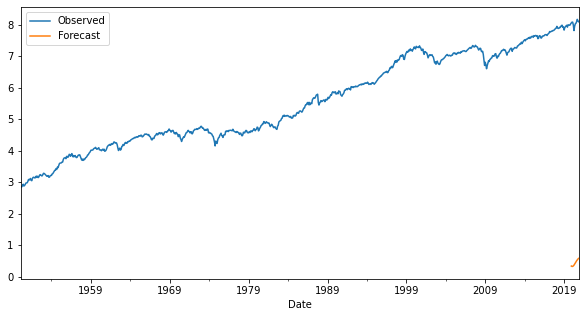

In [152]:
model = run_training_pipeline(lstm_data,
                      seq_length=36, batch_size=16, input_size=2, prediction_len=1,
                      hidden_layer_sizes=[50, 25], dropout_probs=[0.2, 0.2],                      
                      learning_rate=1e-4,max_epochs=500,name="bs16_3years_50_25")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type       | Params
----------------------------------------------
0 | lstm_layers    | ModuleList | 284 K 
1 | dropout_layers | ModuleList | 0     
2 | linear         | Linear     | 101   
----------------------------------------------
284 K     Trainable params
0         Non-trainable params
284 K     Total params
1.136     Total estimated model params size (MB)


Sanity Checking: |                                                                           | 0/? [00:00<?, ?…

Training: |                                                                                  | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved. New best score: 39.234


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 27.349 >= min_delta = 0.0. New best score: 11.885


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 4.699 >= min_delta = 0.0. New best score: 7.186


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.808 >= min_delta = 0.0. New best score: 6.378


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.114 >= min_delta = 0.0. New best score: 6.263


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.181 >= min_delta = 0.0. New best score: 6.082


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 6.073


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.422 >= min_delta = 0.0. New best score: 5.651


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.563 >= min_delta = 0.0. New best score: 5.088


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.303 >= min_delta = 0.0. New best score: 3.786


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.908 >= min_delta = 0.0. New best score: 2.878


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.593 >= min_delta = 0.0. New best score: 2.285


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.493 >= min_delta = 0.0. New best score: 1.791


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.214 >= min_delta = 0.0. New best score: 1.577


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.194 >= min_delta = 0.0. New best score: 1.383


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.142 >= min_delta = 0.0. New best score: 1.241


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.097 >= min_delta = 0.0. New best score: 1.144


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.063 >= min_delta = 0.0. New best score: 1.081


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.078 >= min_delta = 0.0. New best score: 1.003


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 0.984


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.029 >= min_delta = 0.0. New best score: 0.955


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.056 >= min_delta = 0.0. New best score: 0.899


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.887


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.033 >= min_delta = 0.0. New best score: 0.854


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 0.836


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 0.817


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.801


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.800


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.798


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.786


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.782


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.777


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 0.754


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.741


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.728


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.728. Signaling Trainer to stop.


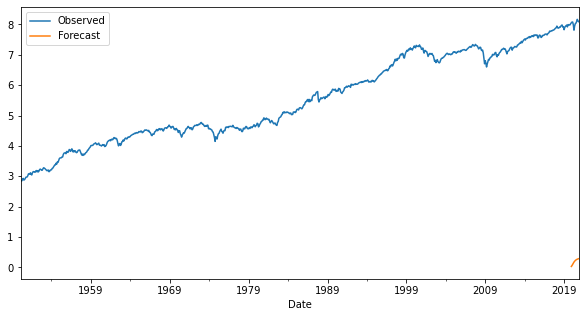

In [151]:
model = run_training_pipeline(lstm_data,
                      seq_length=60, batch_size=16, input_size=2, prediction_len=1,
                      hidden_layer_sizes=[200, 100], dropout_probs=[0.4, 0.3],                      
                      learning_rate=1e-4,max_epochs=500,name="bs16_5years")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type       | Params
----------------------------------------------
0 | lstm_layers    | ModuleList | 284 K 
1 | dropout_layers | ModuleList | 0     
2 | linear         | Linear     | 101   
----------------------------------------------
284 K     Trainable params
0         Non-trainable params
284 K     Total params
1.136     Total estimated model params size (MB)


Sanity Checking: |                                                                           | 0/? [00:00<?, ?…

Training: |                                                                                  | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved. New best score: 50.088


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 37.805 >= min_delta = 0.0. New best score: 12.284


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 4.691 >= min_delta = 0.0. New best score: 7.593


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.962 >= min_delta = 0.0. New best score: 6.631


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.265 >= min_delta = 0.0. New best score: 6.366


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.154 >= min_delta = 0.0. New best score: 6.211


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.073 >= min_delta = 0.0. New best score: 6.138


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.685 >= min_delta = 0.0. New best score: 5.453


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.999 >= min_delta = 0.0. New best score: 3.454


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.155 >= min_delta = 0.0. New best score: 2.299


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.634 >= min_delta = 0.0. New best score: 1.665


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.414 >= min_delta = 0.0. New best score: 1.251


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.275 >= min_delta = 0.0. New best score: 0.976


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.147 >= min_delta = 0.0. New best score: 0.829


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.082 >= min_delta = 0.0. New best score: 0.748


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.076 >= min_delta = 0.0. New best score: 0.672


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.048 >= min_delta = 0.0. New best score: 0.624


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.028 >= min_delta = 0.0. New best score: 0.595


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.045 >= min_delta = 0.0. New best score: 0.550


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 0.530


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.516


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 0.500


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.497


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 0.479


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.046 >= min_delta = 0.0. New best score: 0.432


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 0.409


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.398


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.025 >= min_delta = 0.0. New best score: 0.373


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 0.356


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.344


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.332


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.329


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.315


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 0.299


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 0.283


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.282


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.036 >= min_delta = 0.0. New best score: 0.245


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.238


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.225


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.218


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.035 >= min_delta = 0.0. New best score: 0.183


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.176


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.173


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.167


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.153


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.138


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.137


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.126


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.114


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.103


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.103. Signaling Trainer to stop.


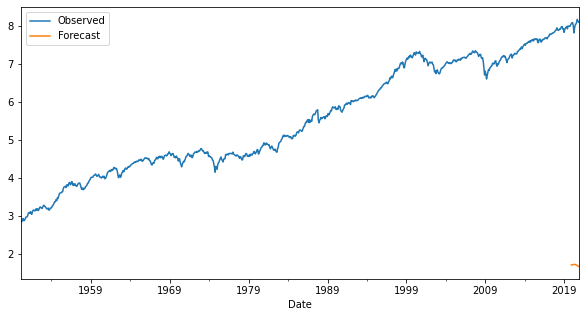

OSError: [WinError 123] The filename, directory name, or volume label syntax is incorrect: 'logs/bs16_100*4'

In [150]:
model = run_training_pipeline(lstm_data,
                      seq_length=12, batch_size=16, input_size=2, prediction_len=1,
                      hidden_layer_sizes=[100, 100,100,100], dropout_probs=[0.2, 0.2,0.2,0.2],                      
                      learning_rate=1e-4,max_epochs=500,name="bs16_100*4")

In [ ]:
s

In [ ]:
def predict_x_steps(model, data):
    model(data)

In [ ]:
cutoffs = pd.to_datetime([f'{year}-01-01' for year in [i*5 + 1960 for i in range(10)]])
fold_train = data

# appendix

Defalut

12:51:09 - cmdstanpy - INFO - Chain [1] start processing
12:51:33 - cmdstanpy - INFO - Chain [1] done processing


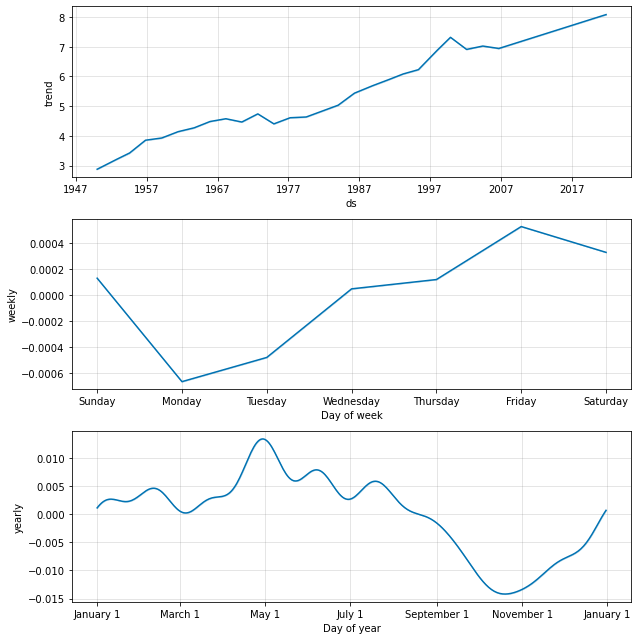

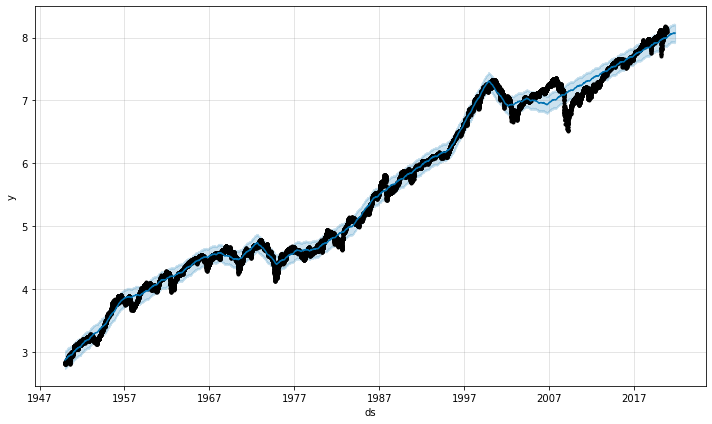

In [13]:
sp500_prophet = sp500.rename({"Date": "ds", "Log_Close": "y"}, axis =1)
m = Prophet()
m.fit(sp500_prophet)
future_dates = m.make_future_dataframe(periods=365)
forecast = m.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
m.plot_components(forecast);
m.plot(forecast);

changepoint_range = 0.95

12:51:45 - cmdstanpy - INFO - Chain [1] start processing
12:52:01 - cmdstanpy - INFO - Chain [1] done processing


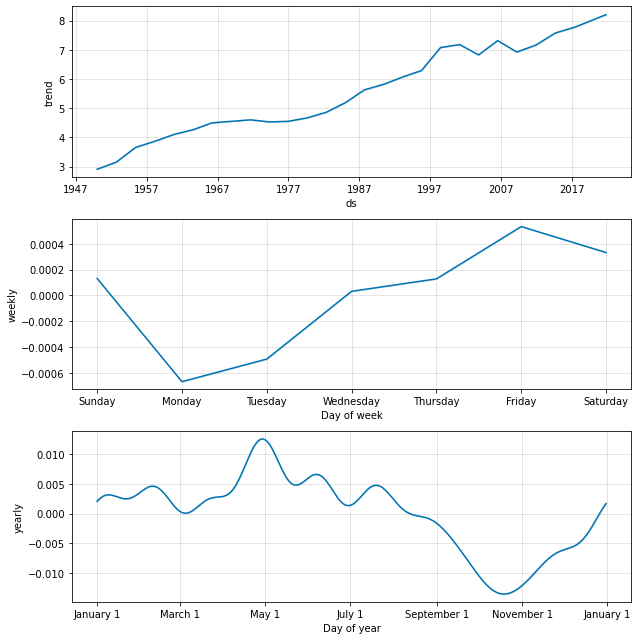

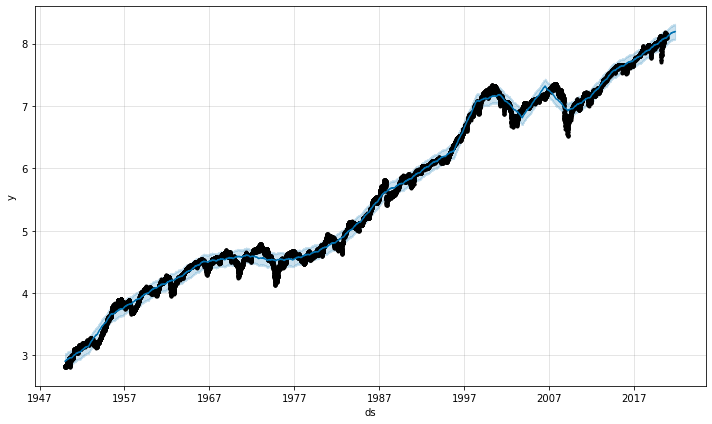

In [14]:
m = Prophet(changepoint_range = 0.95)
m.fit(sp500_prophet)
future_dates = m.make_future_dataframe(periods=365)
forecast = m.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
m.plot_components(forecast);
m.plot(forecast);

12:59:49 - cmdstanpy - INFO - Chain [1] start processing
13:02:01 - cmdstanpy - INFO - Chain [1] done processing


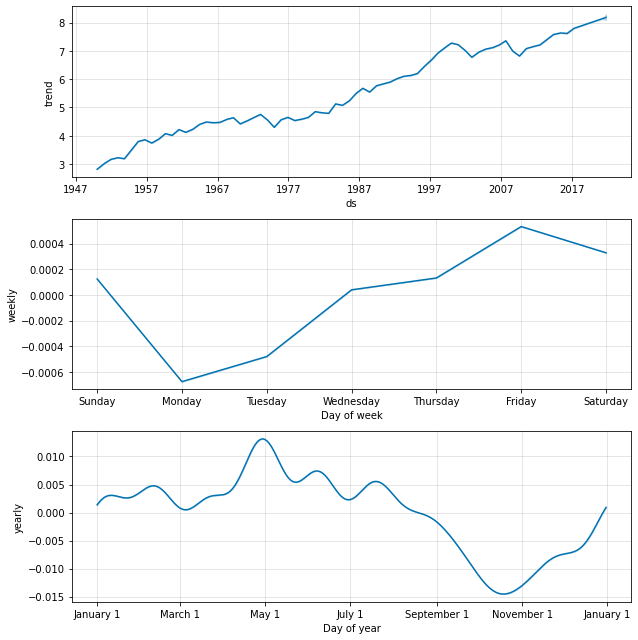

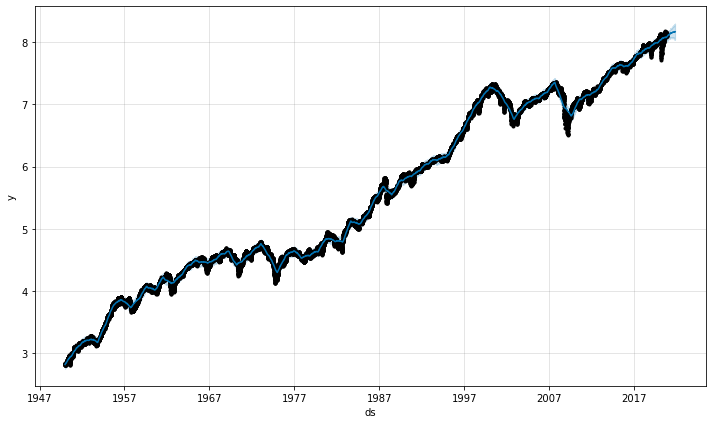

In [18]:
m = Prophet(changepoint_range = 0.95, n_changepoints=70)
m.fit(sp500_prophet)
future_dates = m.make_future_dataframe(periods=365)
forecast = m.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
m.plot_components(forecast);
m.plot(forecast);

Holidays

16:06:01 - cmdstanpy - INFO - Chain [1] start processing
16:06:25 - cmdstanpy - INFO - Chain [1] done processing


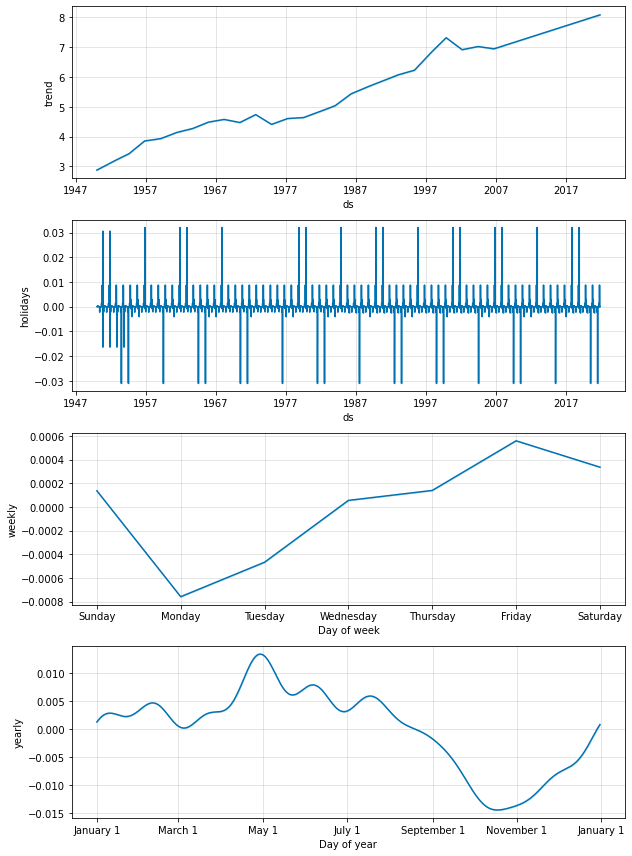

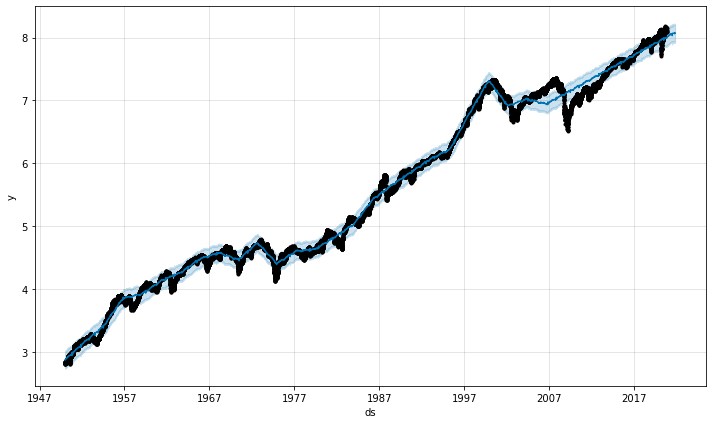

In [184]:
m = Prophet()
m.add_country_holidays(country_name='US')
m.fit(sp500_prophet)
future_dates = m.make_future_dataframe(periods=365)
forecast = m.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
m.plot_components(forecast);
m.plot(forecast);

Volume + changepoint_range 0.95

16:49:00 - cmdstanpy - INFO - Chain [1] start processing
16:49:14 - cmdstanpy - INFO - Chain [1] done processing


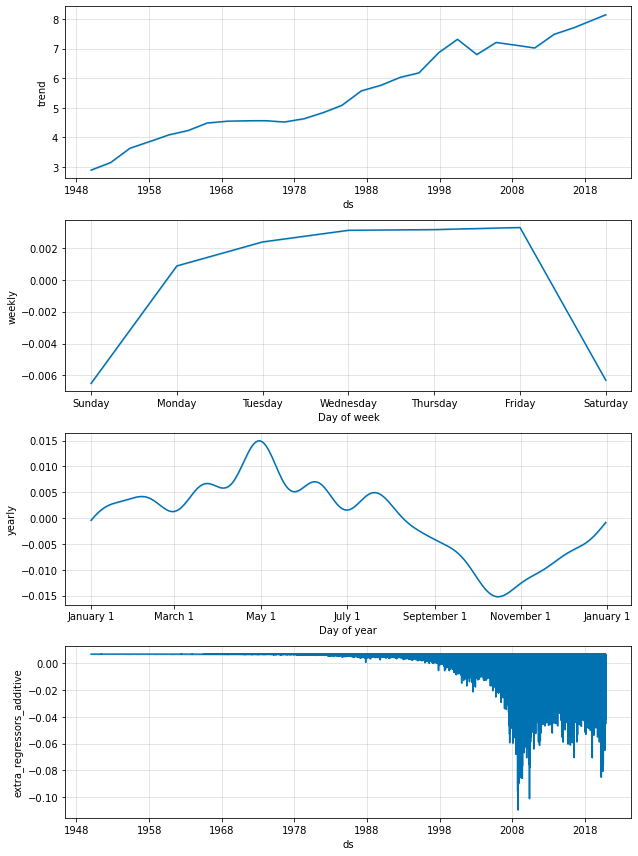

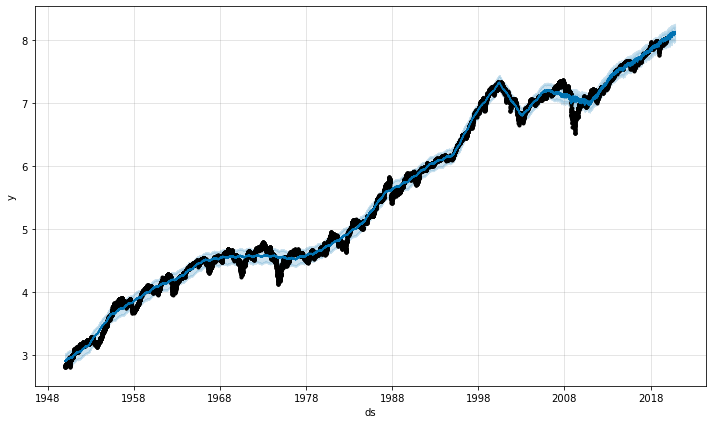

In [221]:
m = Prophet(changepoint_range = 0.95)
m.add_regressor("Volume")
m.fit(sp500_prophet[:-365])
future_dates = m.make_future_dataframe(periods=365)
future_dates['Volume'] = sp500_prophet['Volume']
forecast = m.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
m.plot_components(forecast);
m.plot(forecast);

with monthly seasonality

16:24:38 - cmdstanpy - INFO - Chain [1] start processing
16:25:06 - cmdstanpy - INFO - Chain [1] done processing


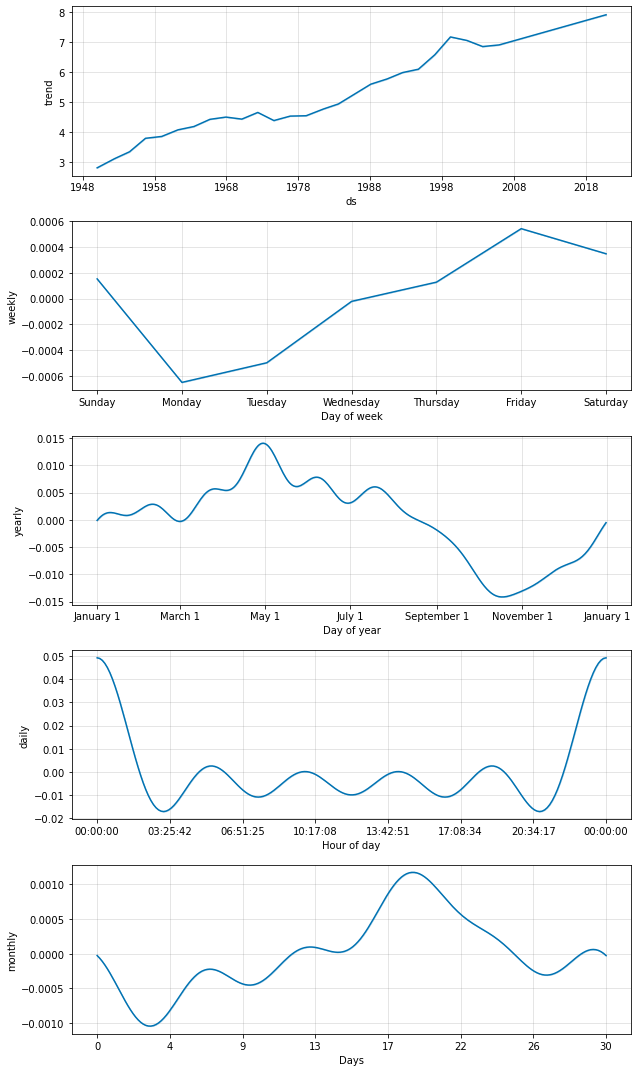

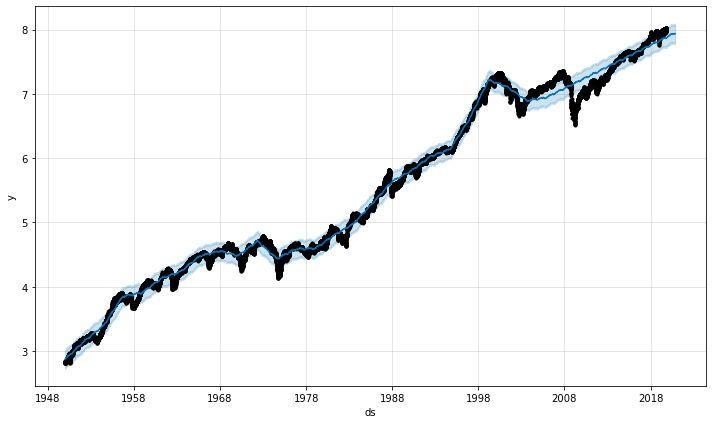

In [42]:
m = Prophet()
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
m.fit(sp500_prophet[:-365])
future_dates = m.make_future_dataframe(periods=365)
forecast = m.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
m.plot_components(forecast);
m.plot(forecast);

In [188]:
def years_until_next_election(year):
    return (4 - (year % 4)) % 4

def fill_party_periods(periods, party):
    return {year: party for start, end in periods for year in range(start, end)}

def generate_presidential_parties():
    democrat_periods = [(1940, 1952), (1961, 1969), (1977, 1981), (1993, 2001), (2009, 2017), (2021, 2024)]
    republican_periods = [(1953, 1961), (1969, 1977), (1981, 1993), (2001, 2009), (2017, 2021)]
    parties = {}
    parties.update(fill_party_periods(democrat_periods, 'Democrat'))
    parties.update(fill_party_periods(republican_periods, 'Republican'))
    return parties

def generate_president_party_dataset(last_year=2023):
    presidential_parties = generate_presidential_parties()
    start_date = '1940-01-01'
    end_date = f'{last_year}-12-31'
    dates = pd.date_range(start=start_date, end=end_date, freq='D')

    data = {'Date': [], 'Years Until Next US Election': [], 'Presidential Party': []}
    for date in dates:
        year = date.year
        party = presidential_parties.get(year, 'Unknown')
        data['Date'].append(date)
        data['Years Until Next US Election'].append(years_until_next_election(year))
        data['Presidential Party'].append(party)
    
    df = pd.DataFrame(data)
    return df

president_party_df = generate_president_party_dataset()
president_party_df['Democrat'] = president_party_df['Presidential Party'] == 'Democrat'
president_party_df['Republican'] = president_party_df['Presidential Party'] == 'Republican'
president_party_df['Democrat'] = president_party_df['Democrat'].astype(int)
president_party_df['Republican'] = president_party_df['Republican'].astype(int)


In [193]:
sp500_prophet_enriched = sp500_prophet.merge(president_party_df[['Date', 'Years Until Next US Election', 
                                                                 'Democrat', 'Republican']],
                                             left_on='ds', right_on='Date', how='left')

Democrat party regressor

16:07:47 - cmdstanpy - INFO - Chain [1] start processing
16:08:04 - cmdstanpy - INFO - Chain [1] done processing


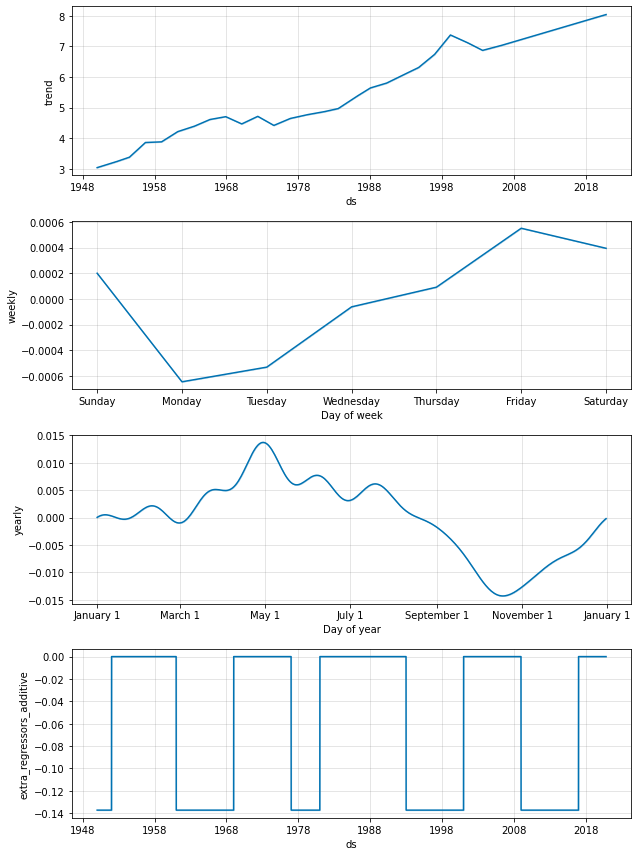

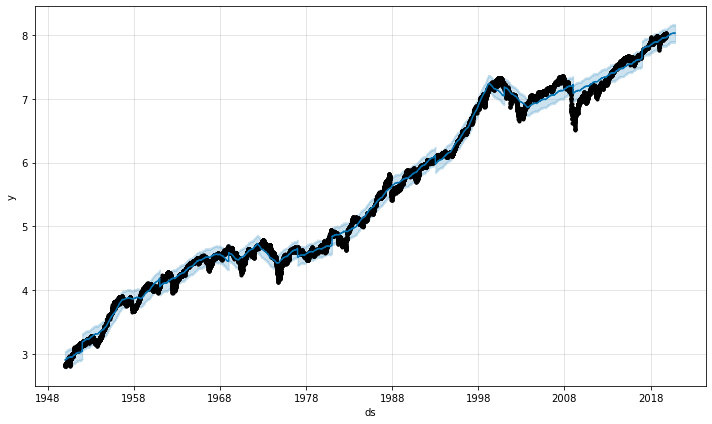

In [190]:
m = Prophet()
# m.add_regressor("Years Until Next US Election")
m.add_regressor("Democrat")
m.fit(sp500_prophet_enriched[:-365])
future_dates = m.make_future_dataframe(periods=365)
future_dates['Democrat'] = sp500_prophet_enriched['Democrat']
# future_dates['Years Until Next US Election'] = sp500_prophet_enriched['Years Until Next US Election']
forecast = m.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
m.plot_components(forecast);
m.plot(forecast);

In [ ]:
Democrat Republican, seasonality

16:15:22 - cmdstanpy - INFO - Chain [1] start processing
16:15:53 - cmdstanpy - INFO - Chain [1] done processing


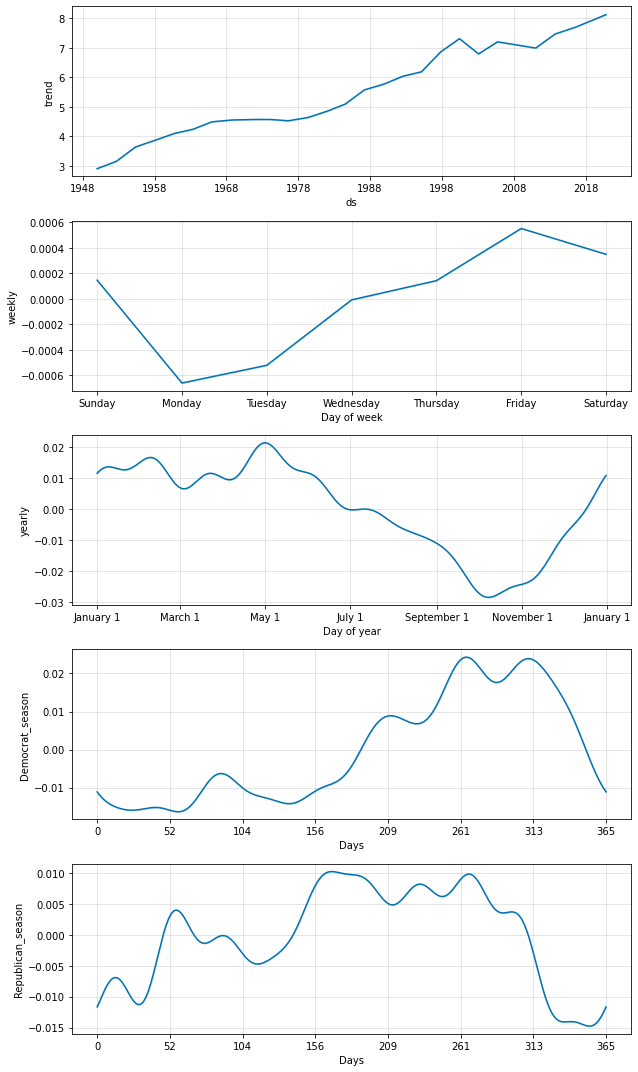

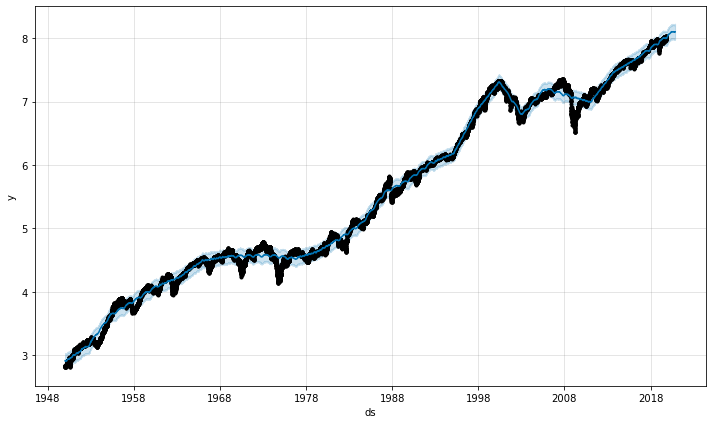

In [195]:
m = Prophet(changepoint_range = 0.95)
# m.add_regressor("Years Until Next US Election")
m.add_seasonality(name='Democrat_season', period=365, fourier_order=10, condition_name='Democrat')
m.add_seasonality(name='Republican_season', period=365, fourier_order=10, condition_name='Republican')
m.fit(sp500_prophet_enriched[:-365])
future_dates = m.make_future_dataframe(periods=365)
future_dates['Democrat'] = sp500_prophet_enriched['Democrat']
future_dates['Republican'] = sp500_prophet_enriched['Republican']
# future_dates['Years Until Next US Election'] = sp500_prophet_enriched['Years Until Next US Election']
forecast = m.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
m.plot_components(forecast);
m.plot(forecast);

cross validation

In [204]:
cutoffs = pd.to_datetime([f'{year}-01-01' for year in [i*5 + 1960 for i in range(12)]])
df_cv = cross_validation(m, cutoffs=cutoffs, horizon='365 days', parallel="processes")

  0%|          | 0/12 [00:00<?, ?it/s]

16:24:16 - cmdstanpy - INFO - Chain [1] start processing
16:24:20 - cmdstanpy - INFO - Chain [1] done processing
16:24:21 - cmdstanpy - INFO - Chain [1] start processing
16:24:30 - cmdstanpy - INFO - Chain [1] done processing
16:24:32 - cmdstanpy - INFO - Chain [1] start processing
16:24:39 - cmdstanpy - INFO - Chain [1] done processing
16:24:41 - cmdstanpy - INFO - Chain [1] start processing
16:24:52 - cmdstanpy - INFO - Chain [1] done processing
16:24:54 - cmdstanpy - INFO - Chain [1] start processing
16:25:07 - cmdstanpy - INFO - Chain [1] done processing
16:25:10 - cmdstanpy - INFO - Chain [1] start processing
16:25:23 - cmdstanpy - INFO - Chain [1] done processing
16:25:25 - cmdstanpy - INFO - Chain [1] start processing
16:25:42 - cmdstanpy - INFO - Chain [1] done processing
16:25:45 - cmdstanpy - INFO - Chain [1] start processing
16:26:04 - cmdstanpy - INFO - Chain [1] done processing
16:26:07 - cmdstanpy - INFO - Chain [1] start processing
16:26:34 - cmdstanpy - INFO - Chain [1]

In [220]:
performance_metrics(df_cv, rolling_window=0)

horizon       mse      rmse       mae      mape     mdape     smape  coverage
0     1 days  0.004991  0.070647  0.047767  0.008133  0.006869  0.008173  0.833333
1     2 days  0.005055  0.071097  0.049558  0.008514  0.007680  0.008553  0.833333
2     3 days  0.005737  0.075745  0.052922  0.008994  0.007580  0.009034  0.833333
3     4 days  0.005858  0.076537  0.054681  0.009312  0.007859  0.009354  0.750000
4     5 days  0.005991  0.077401  0.055563  0.009406  0.007558  0.009450  0.833333
..       ...       ...       ...       ...       ...       ...       ...       ...
360 361 days  0.075474  0.274725  0.216659  0.039015  0.028109  0.040147  0.416667
361 362 days  0.075554  0.274872  0.216065  0.038965  0.027944  0.040112  0.500000
362 363 days  0.075736  0.275201  0.216113  0.038881  0.026647  0.040012  0.583333
363 364 days  0.076483  0.276555  0.217155  0.039030  0.026840  0.040172  0.333333
364 365 days  0.076734  0.277009  0.217538  0.039086  0.027165  0.040230  0.500000

[365 rows x 8 columns]